In [1]:
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)

/home/team4/anaconda3/envs/gpu/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/team4/anaconda3/envs/gpu/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/team4/anaconda3/envs/gpu/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/team4/anaconda3/envs/gpu/lib/python3.7/site-packages

In [2]:
import keras
import pandas as pd
import tensorflow as tf

import numpy as np
# from keras.models import Sequential, Model
# from keras.layers import Dense, Dropout, Activation, Flatten, Convolution2D, MaxPooling2D, GlobalAveragePooling2D
from keras.utils import np_utils

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Convolution2D, MaxPooling2D, GlobalAveragePooling2D, Input,AveragePooling2D, BatchNormalization, LeakyReLU

# from keras.applications import MobileNet
# from keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2, InceptionV3
from tensorflow.keras.optimizers import Adam

from matplotlib import pyplot as plt
import os
from sklearn.model_selection import train_test_split

import seaborn as sns
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.model_selection import KFold

from collections import defaultdict,Counter
from imblearn.over_sampling import SMOTE
from PIL import Image

from kerastuner import HyperModel

Using TensorFlow backend.


<h2>Data Loading and Preparation</h2>

In [3]:
def getSpeciesCode(x):
    part = x.split('_')
    if part[0] == 'ASETRI':
        return 0
    elif part[0] == 'EPTBOT':
        return 1
    elif part[0] == 'MYOEMA':
        return 2
    elif part[0] == 'PIPKUH':
        return 3
    elif part[0] == 'RHIMUS':
        return 4
    elif part[0] == 'RHYNAS':
        return 5
    elif part[0] == 'ROUAEG':
        return 6
    elif part[0] == 'TAPPER':
        return 7
    else:
        return 'Unknown'
    
def getSpecies(x):
    if x == 0:
        return 'A.tridens'
    elif x == 1:
        return 'E.bottae'
    elif x == 2:
        return 'M.emarginatus'
    elif x == 3:
        return 'P.kuhli'
    elif x == 4:
        return 'R.muscatellum'
    elif x == 5:
        return 'R.nasutus'
    elif x == 6:
        return 'R.aegyptius'
    elif x == 7:
        return 'T.perforatus'
    else:
        return 'Unknown'
    
    
def generate_actual_predicted(Y_pred, X_test, Y_test): 
    predicted = list()
    for i in range(len(Y_pred)):
        predicted.append(np.argmax(Y_pred[i]))
        
    actual = list()
    for i in range(len(Y_test)):
        actual.append(np.argmax(Y_test[i]))
        
    return actual, predicted

In [4]:
image_folder_path = '../data/refspec'
file_paths = [f for f in os.listdir(image_folder_path)]
species = []
for file_name in file_paths:
    sp = file_name.split('_')
    species.append(sp[0])

df = pd.DataFrame(species, columns=['Species'])
df['Species'].value_counts()

RHIMUS    1665
TAPPER     403
PIPKUH     299
RHYNAS     269
EPTBOT     124
ROUAEG     121
MYOEMA     112
ASETRI      25
Name: Species, dtype: int64

In [5]:
X_all = []
Y_all = []

image_folder_path = '../data/refspec'
file_paths = [f for f in os.listdir(image_folder_path)]

for file_name in file_paths:
    spectrogram = Image.open(image_folder_path + '/' + file_name)
    spectrogram = spectrogram.convert('RGB')
    spectrogram = spectrogram.resize((170, 112))  
    spectrogram = np.array(spectrogram)
    #spectrogram = np.expand_dims(spectrogram, axis=2) 
    X_all.append(spectrogram)
    Y_all.append(getSpeciesCode(file_name))


In [6]:
X_all = np.array(X_all)
Y_all = np.array(Y_all)

print(X_all.shape)
print(Y_all.shape)

X_all = X_all.astype('float32')
X_all /= 255

Y_all = np_utils.to_categorical(Y_all, num_classes=8) 


(3018, 112, 170, 3)
(3018,)


In [7]:
# train /test= 80/20% split
# Data is stratified
X_train, X_test, Y_train, Y_test = train_test_split(X_all, Y_all, test_size=0.2, random_state = 245, stratify=Y_all)


<h2>Keras Tuner</h2>

In [32]:
class CNNHyperModel(HyperModel):
    def __init__(self, input_shape, num_classes):
        self.input_shape = input_shape
        self.num_classes = num_classes

    def build(self, hp):        
        inp = Input(shape=self.input_shape)
        c1 = Convolution2D(filters=hp.Int('conv1',
                                 min_value=8,
                                 max_value=256,
                                 step=16,
                                 default=64),kernel_size=(7,7),strides=(2,2),padding='same')(inp)
        bt = BatchNormalization()(c1)
        bt = Activation('relu')(bt)
        mpool = MaxPooling2D(pool_size=(2,2),strides=2,padding='same')(bt)
        mpool = Dropout(0.2)(mpool)


        c2 = Convolution2D(filters=hp.Int('conv2',
                                 min_value=8,
                                 max_value=256,
                                 step=16,
                                 default=64),kernel_size=(5,5),strides=(2,2),padding='same')(mpool)
        bt = BatchNormalization()(c2)
        bt = Activation('relu')(bt)
        #bt = LeakyReLU(alpha=0.01)(bt)
        mpool = AveragePooling2D(pool_size=(2,2),strides=2,padding='same')(bt)
        mpool = Dropout(0.3)(mpool)

        c2 = Convolution2D(filters=hp.Int('conv3',
                                 min_value=8,
                                 max_value=256,
                                 step=16,
                                 default=64),kernel_size=(3,3),strides=(1,1),padding='same')(mpool)
        bt = BatchNormalization()(c2)
        bt = Activation('relu')(bt)
        #bt = LeakyReLU(alpha=0.01)(bt)
        mpool = AveragePooling2D(pool_size=(2,2),strides=2,padding='same')(bt)
        mpool = Dropout(rate=0.3)(mpool)

        c3 = Convolution2D(filters=hp.Int('conv4',
                                 min_value=8,
                                 max_value=256,
                                 step=16,
                                 default=64),kernel_size=(3,3),strides=(1,1),padding='same')(mpool)
        bt = BatchNormalization()(c3)
        bt = Activation('relu')(bt)
        #bt = LeakyReLU(alpha=0.01)(bt)
        mpool = AveragePooling2D(pool_size=(2,2),strides=2,padding='same')(bt)
        mpool = Dropout(rate=0.4)(mpool)

        f = Flatten()(mpool)

        x_dense = Dense(512)(f)
        bt = BatchNormalization()(x_dense)
        bt = Activation('relu')(bt)
        bt = Dropout(0.4)(bt)


        x_dense = Dense(256)(bt)
        bt = BatchNormalization()(x_dense)
        bt = Activation('relu')(bt)
        bt = Dropout(0.3)(bt)

        x_dense = Dense(128)(bt)
        bt = BatchNormalization()(x_dense)
        bt = Activation('relu')(bt)
        bt = Dropout(0.2)(bt)

        x_out = Dense(8, name='output', activation='softmax')(bt)
        model = Model(inputs=inp, outputs=x_out)
        model.compile(
            optimizer=Adam(lr=0.003),
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )
        return model

In [33]:
from kerastuner.tuners import RandomSearch

hypermodel = CNNHyperModel(input_shape=(112,170,3), num_classes=8)

tuner = RandomSearch(
    hypermodel,
    objective='val_acc',
    seed=1,
    max_trials=5,
    executions_per_trial=2,
    directory='random_search',
    project_name='bat'
)

In [34]:
tuner.search(X_train, Y_train, epochs=70, validation_split=0.1, batch_size=8, verbose=1)

Train on 2172 samples, validate on 242 samples
Epoch 1/70
2172/2172 [==============================] - ETA: 1:54 - loss: 1.7226 - acc: 0.375 - ETA: 15s - loss: 2.0265 - acc: 0.343 - ETA: 9s - loss: 1.8795 - acc: 0.4196 - ETA: 7s - loss: 1.7824 - acc: 0.467 - ETA: 6s - loss: 1.7359 - acc: 0.484 - ETA: 5s - loss: 1.7565 - acc: 0.495 - ETA: 5s - loss: 1.7293 - acc: 0.500 - ETA: 4s - loss: 1.7212 - acc: 0.493 - ETA: 3s - loss: 1.7123 - acc: 0.502 - ETA: 3s - loss: 1.7083 - acc: 0.495 - ETA: 3s - loss: 1.6812 - acc: 0.493 - ETA: 3s - loss: 1.6969 - acc: 0.488 - ETA: 3s - loss: 1.6797 - acc: 0.487 - ETA: 2s - loss: 1.6525 - acc: 0.490 - ETA: 2s - loss: 1.6252 - acc: 0.494 - ETA: 2s - loss: 1.6352 - acc: 0.489 - ETA: 2s - loss: 1.6352 - acc: 0.483 - ETA: 2s - loss: 1.6117 - acc: 0.493 - ETA: 1s - loss: 1.5953 - acc: 0.496 - ETA: 1s - loss: 1.5745 - acc: 0.497 - ETA: 1s - loss: 1.5733 - acc: 0.501 - ETA: 1s - loss: 1.5770 - acc: 0.500 - ETA: 1s - loss: 1.5799 - acc: 0.499 - ETA: 1s - loss: 1.5

Epoch 6/70
2172/2172 [==============================] - ETA: 2s - loss: 0.4897 - acc: 0.875 - ETA: 1s - loss: 1.2273 - acc: 0.597 - ETA: 1s - loss: 1.1060 - acc: 0.652 - ETA: 1s - loss: 1.1040 - acc: 0.638 - ETA: 1s - loss: 1.0919 - acc: 0.646 - ETA: 1s - loss: 1.0895 - acc: 0.645 - ETA: 1s - loss: 1.1030 - acc: 0.632 - ETA: 1s - loss: 1.0992 - acc: 0.638 - ETA: 1s - loss: 1.1104 - acc: 0.641 - ETA: 1s - loss: 1.1172 - acc: 0.635 - ETA: 1s - loss: 1.1135 - acc: 0.634 - ETA: 1s - loss: 1.0973 - acc: 0.641 - ETA: 1s - loss: 1.0892 - acc: 0.641 - ETA: 1s - loss: 1.0825 - acc: 0.645 - ETA: 1s - loss: 1.0726 - acc: 0.645 - ETA: 1s - loss: 1.0737 - acc: 0.646 - ETA: 1s - loss: 1.0650 - acc: 0.651 - ETA: 1s - loss: 1.0618 - acc: 0.651 - ETA: 1s - loss: 1.0837 - acc: 0.645 - ETA: 0s - loss: 1.0852 - acc: 0.643 - ETA: 0s - loss: 1.0847 - acc: 0.642 - ETA: 0s - loss: 1.0841 - acc: 0.639 - ETA: 0s - loss: 1.0873 - acc: 0.635 - ETA: 0s - loss: 1.0813 - acc: 0.637 - ETA: 0s - loss: 1.0812 - acc: 0.

2172/2172 [==============================] - ETA: 2s - loss: 1.4725 - acc: 0.500 - ETA: 2s - loss: 0.7279 - acc: 0.714 - ETA: 2s - loss: 0.6995 - acc: 0.759 - ETA: 2s - loss: 0.7324 - acc: 0.725 - ETA: 2s - loss: 0.7319 - acc: 0.730 - ETA: 2s - loss: 0.7198 - acc: 0.742 - ETA: 2s - loss: 0.7013 - acc: 0.756 - ETA: 1s - loss: 0.6916 - acc: 0.764 - ETA: 1s - loss: 0.6817 - acc: 0.762 - ETA: 1s - loss: 0.7024 - acc: 0.758 - ETA: 1s - loss: 0.7113 - acc: 0.764 - ETA: 1s - loss: 0.7108 - acc: 0.763 - ETA: 1s - loss: 0.7167 - acc: 0.763 - ETA: 1s - loss: 0.7237 - acc: 0.755 - ETA: 1s - loss: 0.7332 - acc: 0.753 - ETA: 1s - loss: 0.7425 - acc: 0.751 - ETA: 1s - loss: 0.7497 - acc: 0.748 - ETA: 1s - loss: 0.7590 - acc: 0.745 - ETA: 1s - loss: 0.7594 - acc: 0.742 - ETA: 1s - loss: 0.7592 - acc: 0.745 - ETA: 1s - loss: 0.7513 - acc: 0.748 - ETA: 0s - loss: 0.7441 - acc: 0.749 - ETA: 0s - loss: 0.7426 - acc: 0.753 - ETA: 0s - loss: 0.7426 - acc: 0.751 - ETA: 0s - loss: 0.7374 - acc: 0.753 - ETA: 

2172/2172 [==============================] - ETA: 2s - loss: 0.8582 - acc: 0.625 - ETA: 2s - loss: 0.7949 - acc: 0.696 - ETA: 2s - loss: 0.8040 - acc: 0.721 - ETA: 2s - loss: 0.7566 - acc: 0.750 - ETA: 2s - loss: 0.7198 - acc: 0.755 - ETA: 2s - loss: 0.6815 - acc: 0.758 - ETA: 1s - loss: 0.6032 - acc: 0.796 - ETA: 1s - loss: 0.5633 - acc: 0.816 - ETA: 1s - loss: 0.5723 - acc: 0.810 - ETA: 1s - loss: 0.5685 - acc: 0.811 - ETA: 1s - loss: 0.5632 - acc: 0.810 - ETA: 1s - loss: 0.5570 - acc: 0.806 - ETA: 1s - loss: 0.5647 - acc: 0.806 - ETA: 1s - loss: 0.5544 - acc: 0.809 - ETA: 1s - loss: 0.5550 - acc: 0.807 - ETA: 1s - loss: 0.5505 - acc: 0.807 - ETA: 1s - loss: 0.5532 - acc: 0.804 - ETA: 1s - loss: 0.5487 - acc: 0.805 - ETA: 1s - loss: 0.5454 - acc: 0.808 - ETA: 1s - loss: 0.5442 - acc: 0.812 - ETA: 0s - loss: 0.5443 - acc: 0.812 - ETA: 0s - loss: 0.5479 - acc: 0.812 - ETA: 0s - loss: 0.5389 - acc: 0.816 - ETA: 0s - loss: 0.5454 - acc: 0.815 - ETA: 0s - loss: 0.5445 - acc: 0.814 - ETA: 

2172/2172 [==============================] - ETA: 2s - loss: 0.2049 - acc: 0.875 - ETA: 3s - loss: 0.2161 - acc: 0.958 - ETA: 2s - loss: 0.3601 - acc: 0.897 - ETA: 3s - loss: 0.3352 - acc: 0.900 - ETA: 3s - loss: 0.3311 - acc: 0.901 - ETA: 3s - loss: 0.3252 - acc: 0.896 - ETA: 3s - loss: 0.3631 - acc: 0.870 - ETA: 3s - loss: 0.3608 - acc: 0.875 - ETA: 3s - loss: 0.3421 - acc: 0.886 - ETA: 3s - loss: 0.3539 - acc: 0.888 - ETA: 3s - loss: 0.3762 - acc: 0.881 - ETA: 3s - loss: 0.3834 - acc: 0.878 - ETA: 3s - loss: 0.3877 - acc: 0.872 - ETA: 3s - loss: 0.4675 - acc: 0.864 - ETA: 3s - loss: 0.4898 - acc: 0.858 - ETA: 3s - loss: 0.4807 - acc: 0.861 - ETA: 3s - loss: 0.4868 - acc: 0.858 - ETA: 3s - loss: 0.4878 - acc: 0.857 - ETA: 3s - loss: 0.4863 - acc: 0.852 - ETA: 2s - loss: 0.4718 - acc: 0.857 - ETA: 2s - loss: 0.4592 - acc: 0.862 - ETA: 2s - loss: 0.4597 - acc: 0.866 - ETA: 2s - loss: 0.4611 - acc: 0.865 - ETA: 2s - loss: 0.4594 - acc: 0.861 - ETA: 2s - loss: 0.4562 - acc: 0.863 - ETA: 

2172/2172 [==============================] - ETA: 2s - loss: 0.2471 - acc: 0.875 - ETA: 2s - loss: 0.4265 - acc: 0.875 - ETA: 2s - loss: 0.6515 - acc: 0.803 - ETA: 2s - loss: 0.6432 - acc: 0.800 - ETA: 2s - loss: 0.6049 - acc: 0.802 - ETA: 1s - loss: 0.5322 - acc: 0.825 - ETA: 1s - loss: 0.5504 - acc: 0.824 - ETA: 1s - loss: 0.5209 - acc: 0.835 - ETA: 1s - loss: 0.5154 - acc: 0.834 - ETA: 1s - loss: 0.5015 - acc: 0.835 - ETA: 1s - loss: 0.5038 - acc: 0.834 - ETA: 1s - loss: 0.4905 - acc: 0.838 - ETA: 1s - loss: 0.5012 - acc: 0.831 - ETA: 1s - loss: 0.4843 - acc: 0.836 - ETA: 1s - loss: 0.4643 - acc: 0.842 - ETA: 1s - loss: 0.4647 - acc: 0.841 - ETA: 1s - loss: 0.4548 - acc: 0.842 - ETA: 0s - loss: 0.4411 - acc: 0.846 - ETA: 0s - loss: 0.4432 - acc: 0.846 - ETA: 0s - loss: 0.4335 - acc: 0.851 - ETA: 0s - loss: 0.4462 - acc: 0.850 - ETA: 0s - loss: 0.4441 - acc: 0.851 - ETA: 0s - loss: 0.4418 - acc: 0.852 - ETA: 0s - loss: 0.4413 - acc: 0.853 - ETA: 0s - loss: 0.4429 - acc: 0.852 - ETA: 

2172/2172 [==============================] - ETA: 2s - loss: 0.3336 - acc: 0.875 - ETA: 2s - loss: 0.2345 - acc: 0.906 - ETA: 2s - loss: 0.2807 - acc: 0.900 - ETA: 1s - loss: 0.2410 - acc: 0.920 - ETA: 1s - loss: 0.2521 - acc: 0.922 - ETA: 1s - loss: 0.2656 - acc: 0.920 - ETA: 1s - loss: 0.2675 - acc: 0.910 - ETA: 1s - loss: 0.2802 - acc: 0.904 - ETA: 1s - loss: 0.2682 - acc: 0.911 - ETA: 1s - loss: 0.2976 - acc: 0.903 - ETA: 1s - loss: 0.2993 - acc: 0.901 - ETA: 1s - loss: 0.3084 - acc: 0.896 - ETA: 1s - loss: 0.3144 - acc: 0.896 - ETA: 1s - loss: 0.3131 - acc: 0.895 - ETA: 1s - loss: 0.3192 - acc: 0.892 - ETA: 1s - loss: 0.3177 - acc: 0.891 - ETA: 1s - loss: 0.3145 - acc: 0.893 - ETA: 1s - loss: 0.3109 - acc: 0.893 - ETA: 1s - loss: 0.3229 - acc: 0.889 - ETA: 1s - loss: 0.3268 - acc: 0.891 - ETA: 1s - loss: 0.3231 - acc: 0.892 - ETA: 1s - loss: 0.3232 - acc: 0.891 - ETA: 1s - loss: 0.3303 - acc: 0.889 - ETA: 1s - loss: 0.3264 - acc: 0.892 - ETA: 1s - loss: 0.3308 - acc: 0.892 - ETA: 

Epoch 35/70
2172/2172 [==============================] - ETA: 1s - loss: 0.7717 - acc: 0.750 - ETA: 1s - loss: 0.3825 - acc: 0.850 - ETA: 1s - loss: 0.2807 - acc: 0.902 - ETA: 1s - loss: 0.2972 - acc: 0.895 - ETA: 1s - loss: 0.2756 - acc: 0.911 - ETA: 1s - loss: 0.2644 - acc: 0.918 - ETA: 1s - loss: 0.2760 - acc: 0.916 - ETA: 1s - loss: 0.2656 - acc: 0.918 - ETA: 1s - loss: 0.2697 - acc: 0.918 - ETA: 1s - loss: 0.2716 - acc: 0.914 - ETA: 1s - loss: 0.2699 - acc: 0.913 - ETA: 1s - loss: 0.2532 - acc: 0.919 - ETA: 1s - loss: 0.2446 - acc: 0.921 - ETA: 1s - loss: 0.2539 - acc: 0.922 - ETA: 1s - loss: 0.2483 - acc: 0.921 - ETA: 1s - loss: 0.2363 - acc: 0.924 - ETA: 1s - loss: 0.2291 - acc: 0.926 - ETA: 1s - loss: 0.2283 - acc: 0.927 - ETA: 1s - loss: 0.2208 - acc: 0.928 - ETA: 0s - loss: 0.2244 - acc: 0.927 - ETA: 0s - loss: 0.2185 - acc: 0.930 - ETA: 0s - loss: 0.2193 - acc: 0.930 - ETA: 0s - loss: 0.2269 - acc: 0.928 - ETA: 0s - loss: 0.2311 - acc: 0.925 - ETA: 0s - loss: 0.2253 - acc: 0

2172/2172 [==============================] - ETA: 3s - loss: 4.3690 - acc: 0.500 - ETA: 3s - loss: 0.9250 - acc: 0.875 - ETA: 3s - loss: 0.5150 - acc: 0.931 - ETA: 2s - loss: 0.3946 - acc: 0.926 - ETA: 2s - loss: 0.3066 - acc: 0.942 - ETA: 2s - loss: 0.2914 - acc: 0.943 - ETA: 2s - loss: 0.2835 - acc: 0.940 - ETA: 1s - loss: 0.2696 - acc: 0.938 - ETA: 1s - loss: 0.2488 - acc: 0.940 - ETA: 1s - loss: 0.2399 - acc: 0.942 - ETA: 1s - loss: 0.2417 - acc: 0.940 - ETA: 1s - loss: 0.2813 - acc: 0.937 - ETA: 1s - loss: 0.2755 - acc: 0.936 - ETA: 1s - loss: 0.2996 - acc: 0.929 - ETA: 1s - loss: 0.2855 - acc: 0.932 - ETA: 1s - loss: 0.2755 - acc: 0.931 - ETA: 1s - loss: 0.2787 - acc: 0.926 - ETA: 1s - loss: 0.2760 - acc: 0.926 - ETA: 1s - loss: 0.2658 - acc: 0.929 - ETA: 1s - loss: 0.2659 - acc: 0.929 - ETA: 1s - loss: 0.2754 - acc: 0.929 - ETA: 1s - loss: 0.2677 - acc: 0.931 - ETA: 1s - loss: 0.2619 - acc: 0.932 - ETA: 1s - loss: 0.2589 - acc: 0.932 - ETA: 0s - loss: 0.2574 - acc: 0.932 - ETA: 

2172/2172 [==============================] - ETA: 1s - loss: 0.1963 - acc: 0.875 - ETA: 1s - loss: 0.1039 - acc: 0.950 - ETA: 1s - loss: 0.0767 - acc: 0.973 - ETA: 1s - loss: 0.0949 - acc: 0.967 - ETA: 1s - loss: 0.1126 - acc: 0.964 - ETA: 1s - loss: 0.1388 - acc: 0.955 - ETA: 1s - loss: 0.1427 - acc: 0.955 - ETA: 1s - loss: 0.1458 - acc: 0.953 - ETA: 1s - loss: 0.1449 - acc: 0.955 - ETA: 1s - loss: 0.1528 - acc: 0.953 - ETA: 1s - loss: 0.1501 - acc: 0.952 - ETA: 1s - loss: 0.1545 - acc: 0.952 - ETA: 1s - loss: 0.1490 - acc: 0.954 - ETA: 1s - loss: 0.1714 - acc: 0.947 - ETA: 1s - loss: 0.1646 - acc: 0.950 - ETA: 1s - loss: 0.1620 - acc: 0.951 - ETA: 1s - loss: 0.1725 - acc: 0.949 - ETA: 0s - loss: 0.1702 - acc: 0.950 - ETA: 0s - loss: 0.1686 - acc: 0.949 - ETA: 0s - loss: 0.1660 - acc: 0.951 - ETA: 0s - loss: 0.1646 - acc: 0.951 - ETA: 0s - loss: 0.1661 - acc: 0.951 - ETA: 0s - loss: 0.1666 - acc: 0.950 - ETA: 0s - loss: 0.1752 - acc: 0.948 - ETA: 0s - loss: 0.1743 - acc: 0.947 - ETA: 

2172/2172 [==============================] - ETA: 5s - loss: 0.0165 - acc: 1.000 - ETA: 4s - loss: 0.0252 - acc: 1.000 - ETA: 4s - loss: 0.0883 - acc: 0.982 - ETA: 4s - loss: 0.0879 - acc: 0.977 - ETA: 3s - loss: 0.1170 - acc: 0.960 - ETA: 2s - loss: 0.1364 - acc: 0.959 - ETA: 2s - loss: 0.1256 - acc: 0.960 - ETA: 2s - loss: 0.1147 - acc: 0.965 - ETA: 2s - loss: 0.1457 - acc: 0.958 - ETA: 2s - loss: 0.1528 - acc: 0.952 - ETA: 2s - loss: 0.2196 - acc: 0.946 - ETA: 1s - loss: 0.2802 - acc: 0.940 - ETA: 1s - loss: 0.3102 - acc: 0.928 - ETA: 1s - loss: 0.3128 - acc: 0.924 - ETA: 1s - loss: 0.3331 - acc: 0.921 - ETA: 1s - loss: 0.3216 - acc: 0.923 - ETA: 1s - loss: 0.3214 - acc: 0.923 - ETA: 1s - loss: 0.3020 - acc: 0.927 - ETA: 1s - loss: 0.2929 - acc: 0.930 - ETA: 1s - loss: 0.2882 - acc: 0.930 - ETA: 1s - loss: 0.2771 - acc: 0.932 - ETA: 1s - loss: 0.2777 - acc: 0.933 - ETA: 0s - loss: 0.2747 - acc: 0.933 - ETA: 0s - loss: 0.2764 - acc: 0.931 - ETA: 0s - loss: 0.2974 - acc: 0.924 - ETA: 

2172/2172 [==============================] - ETA: 4s - loss: 0.0852 - acc: 1.000 - ETA: 3s - loss: 0.1546 - acc: 0.950 - ETA: 3s - loss: 0.0969 - acc: 0.972 - ETA: 3s - loss: 0.1242 - acc: 0.971 - ETA: 3s - loss: 0.1522 - acc: 0.955 - ETA: 2s - loss: 0.1482 - acc: 0.950 - ETA: 2s - loss: 0.1465 - acc: 0.947 - ETA: 2s - loss: 0.2173 - acc: 0.932 - ETA: 2s - loss: 0.2872 - acc: 0.926 - ETA: 1s - loss: 0.2656 - acc: 0.928 - ETA: 1s - loss: 0.2593 - acc: 0.926 - ETA: 1s - loss: 0.2533 - acc: 0.925 - ETA: 1s - loss: 0.2401 - acc: 0.930 - ETA: 1s - loss: 0.2328 - acc: 0.931 - ETA: 1s - loss: 0.2195 - acc: 0.935 - ETA: 1s - loss: 0.2132 - acc: 0.936 - ETA: 1s - loss: 0.2405 - acc: 0.936 - ETA: 1s - loss: 0.2318 - acc: 0.938 - ETA: 1s - loss: 0.2343 - acc: 0.935 - ETA: 1s - loss: 0.2308 - acc: 0.936 - ETA: 1s - loss: 0.2291 - acc: 0.936 - ETA: 1s - loss: 0.2289 - acc: 0.932 - ETA: 0s - loss: 0.2261 - acc: 0.932 - ETA: 0s - loss: 0.2256 - acc: 0.931 - ETA: 0s - loss: 0.2215 - acc: 0.933 - ETA: 

2172/2172 [==============================] - ETA: 2s - loss: 0.1385 - acc: 1.000 - ETA: 1s - loss: 0.1331 - acc: 0.968 - ETA: 1s - loss: 0.1388 - acc: 0.966 - ETA: 1s - loss: 0.1356 - acc: 0.964 - ETA: 1s - loss: 0.1333 - acc: 0.968 - ETA: 1s - loss: 0.1454 - acc: 0.966 - ETA: 1s - loss: 0.1339 - acc: 0.966 - ETA: 1s - loss: 0.1208 - acc: 0.969 - ETA: 1s - loss: 0.1106 - acc: 0.973 - ETA: 1s - loss: 0.1049 - acc: 0.972 - ETA: 1s - loss: 0.1197 - acc: 0.968 - ETA: 1s - loss: 0.1246 - acc: 0.968 - ETA: 1s - loss: 0.1301 - acc: 0.967 - ETA: 1s - loss: 0.1350 - acc: 0.965 - ETA: 1s - loss: 0.1335 - acc: 0.964 - ETA: 1s - loss: 0.1324 - acc: 0.964 - ETA: 1s - loss: 0.1327 - acc: 0.965 - ETA: 1s - loss: 0.1326 - acc: 0.964 - ETA: 1s - loss: 0.1379 - acc: 0.963 - ETA: 1s - loss: 0.1360 - acc: 0.963 - ETA: 1s - loss: 0.1380 - acc: 0.964 - ETA: 1s - loss: 0.1419 - acc: 0.962 - ETA: 1s - loss: 0.1433 - acc: 0.961 - ETA: 1s - loss: 0.1453 - acc: 0.959 - ETA: 0s - loss: 0.1413 - acc: 0.960 - ETA: 

2172/2172 [==============================] - ETA: 2s - loss: 0.1420 - acc: 1.000 - ETA: 2s - loss: 0.1935 - acc: 0.937 - ETA: 2s - loss: 0.1967 - acc: 0.933 - ETA: 1s - loss: 0.1753 - acc: 0.942 - ETA: 1s - loss: 0.1483 - acc: 0.954 - ETA: 1s - loss: 0.1511 - acc: 0.956 - ETA: 1s - loss: 0.1462 - acc: 0.960 - ETA: 1s - loss: 0.1433 - acc: 0.959 - ETA: 1s - loss: 0.1449 - acc: 0.959 - ETA: 1s - loss: 0.1560 - acc: 0.958 - ETA: 1s - loss: 0.1563 - acc: 0.958 - ETA: 1s - loss: 0.1484 - acc: 0.960 - ETA: 1s - loss: 0.1456 - acc: 0.959 - ETA: 1s - loss: 0.1433 - acc: 0.960 - ETA: 1s - loss: 0.1373 - acc: 0.962 - ETA: 1s - loss: 0.1453 - acc: 0.958 - ETA: 1s - loss: 0.1447 - acc: 0.957 - ETA: 0s - loss: 0.1394 - acc: 0.958 - ETA: 0s - loss: 0.1377 - acc: 0.959 - ETA: 0s - loss: 0.1338 - acc: 0.959 - ETA: 0s - loss: 0.1303 - acc: 0.960 - ETA: 0s - loss: 0.1277 - acc: 0.959 - ETA: 0s - loss: 0.1284 - acc: 0.958 - ETA: 0s - loss: 0.1268 - acc: 0.959 - ETA: 0s - loss: 0.1223 - acc: 0.960 - ETA: 

2172/2172 [==============================] - ETA: 5s - loss: 0.4183 - acc: 0.875 - ETA: 5s - loss: 0.1556 - acc: 0.937 - ETA: 4s - loss: 0.2778 - acc: 0.937 - ETA: 4s - loss: 0.2159 - acc: 0.947 - ETA: 3s - loss: 0.1744 - acc: 0.960 - ETA: 3s - loss: 0.1849 - acc: 0.956 - ETA: 3s - loss: 0.1552 - acc: 0.963 - ETA: 2s - loss: 0.1509 - acc: 0.961 - ETA: 2s - loss: 0.1305 - acc: 0.968 - ETA: 2s - loss: 0.1435 - acc: 0.968 - ETA: 2s - loss: 0.1487 - acc: 0.962 - ETA: 1s - loss: 0.1506 - acc: 0.963 - ETA: 1s - loss: 0.1427 - acc: 0.963 - ETA: 1s - loss: 0.1485 - acc: 0.960 - ETA: 1s - loss: 0.1429 - acc: 0.962 - ETA: 1s - loss: 0.1380 - acc: 0.963 - ETA: 1s - loss: 0.1362 - acc: 0.961 - ETA: 1s - loss: 0.1329 - acc: 0.962 - ETA: 1s - loss: 0.1357 - acc: 0.959 - ETA: 1s - loss: 0.1495 - acc: 0.958 - ETA: 1s - loss: 0.1486 - acc: 0.958 - ETA: 1s - loss: 0.1476 - acc: 0.958 - ETA: 1s - loss: 0.1461 - acc: 0.958 - ETA: 1s - loss: 0.1452 - acc: 0.957 - ETA: 1s - loss: 0.1422 - acc: 0.958 - ETA: 

2172/2172 [==============================] - ETA: 1:56 - loss: 2.6033 - acc: 0.125 - ETA: 15s - loss: 2.1211 - acc: 0.281 - ETA: 9s - loss: 2.0334 - acc: 0.3083 - ETA: 7s - loss: 1.9075 - acc: 0.363 - ETA: 6s - loss: 1.9215 - acc: 0.379 - ETA: 5s - loss: 1.9603 - acc: 0.395 - ETA: 5s - loss: 1.9154 - acc: 0.400 - ETA: 4s - loss: 1.8626 - acc: 0.404 - ETA: 3s - loss: 1.8218 - acc: 0.415 - ETA: 3s - loss: 1.8223 - acc: 0.418 - ETA: 3s - loss: 1.8153 - acc: 0.422 - ETA: 3s - loss: 1.7947 - acc: 0.429 - ETA: 2s - loss: 1.7470 - acc: 0.441 - ETA: 2s - loss: 1.7627 - acc: 0.436 - ETA: 2s - loss: 1.7306 - acc: 0.444 - ETA: 2s - loss: 1.7203 - acc: 0.452 - ETA: 2s - loss: 1.6962 - acc: 0.452 - ETA: 2s - loss: 1.6767 - acc: 0.457 - ETA: 2s - loss: 1.6774 - acc: 0.456 - ETA: 2s - loss: 1.6869 - acc: 0.455 - ETA: 2s - loss: 1.6668 - acc: 0.458 - ETA: 2s - loss: 1.6609 - acc: 0.460 - ETA: 1s - loss: 1.6268 - acc: 0.472 - ETA: 1s - loss: 1.6089 - acc: 0.477 - ETA: 1s - loss: 1.6017 - acc: 0.480 - E

2172/2172 [==============================] - ETA: 3s - loss: 1.0638 - acc: 0.750 - ETA: 2s - loss: 1.3295 - acc: 0.541 - ETA: 2s - loss: 1.1674 - acc: 0.613 - ETA: 2s - loss: 1.1547 - acc: 0.601 - ETA: 2s - loss: 1.1973 - acc: 0.556 - ETA: 2s - loss: 1.1643 - acc: 0.571 - ETA: 2s - loss: 1.1403 - acc: 0.588 - ETA: 2s - loss: 1.1574 - acc: 0.585 - ETA: 2s - loss: 1.1281 - acc: 0.588 - ETA: 2s - loss: 1.1311 - acc: 0.597 - ETA: 1s - loss: 1.1168 - acc: 0.606 - ETA: 2s - loss: 1.1216 - acc: 0.603 - ETA: 2s - loss: 1.1054 - acc: 0.614 - ETA: 2s - loss: 1.0919 - acc: 0.621 - ETA: 2s - loss: 1.0908 - acc: 0.621 - ETA: 2s - loss: 1.0783 - acc: 0.623 - ETA: 2s - loss: 1.0896 - acc: 0.620 - ETA: 2s - loss: 1.0816 - acc: 0.625 - ETA: 2s - loss: 1.0738 - acc: 0.627 - ETA: 2s - loss: 1.0911 - acc: 0.626 - ETA: 2s - loss: 1.0995 - acc: 0.622 - ETA: 1s - loss: 1.1088 - acc: 0.617 - ETA: 1s - loss: 1.1180 - acc: 0.614 - ETA: 1s - loss: 1.1151 - acc: 0.616 - ETA: 1s - loss: 1.1119 - acc: 0.617 - ETA: 

2172/2172 [==============================] - ETA: 1s - loss: 0.9331 - acc: 0.750 - ETA: 1s - loss: 0.9180 - acc: 0.652 - ETA: 2s - loss: 0.8525 - acc: 0.716 - ETA: 2s - loss: 0.9358 - acc: 0.693 - ETA: 2s - loss: 0.8850 - acc: 0.710 - ETA: 2s - loss: 0.8295 - acc: 0.733 - ETA: 2s - loss: 0.8272 - acc: 0.739 - ETA: 2s - loss: 0.8626 - acc: 0.729 - ETA: 1s - loss: 0.8750 - acc: 0.721 - ETA: 1s - loss: 0.8649 - acc: 0.727 - ETA: 1s - loss: 0.8456 - acc: 0.729 - ETA: 1s - loss: 0.8178 - acc: 0.737 - ETA: 1s - loss: 0.8423 - acc: 0.729 - ETA: 1s - loss: 0.8302 - acc: 0.732 - ETA: 1s - loss: 0.8350 - acc: 0.730 - ETA: 1s - loss: 0.8589 - acc: 0.721 - ETA: 1s - loss: 0.8473 - acc: 0.724 - ETA: 1s - loss: 0.8538 - acc: 0.721 - ETA: 1s - loss: 0.8749 - acc: 0.717 - ETA: 1s - loss: 0.8677 - acc: 0.718 - ETA: 1s - loss: 0.8539 - acc: 0.723 - ETA: 1s - loss: 0.8458 - acc: 0.727 - ETA: 1s - loss: 0.8384 - acc: 0.728 - ETA: 1s - loss: 0.8361 - acc: 0.726 - ETA: 1s - loss: 0.8414 - acc: 0.723 - ETA: 

2172/2172 [==============================] - ETA: 2s - loss: 0.8768 - acc: 0.750 - ETA: 1s - loss: 0.6361 - acc: 0.819 - ETA: 1s - loss: 0.5370 - acc: 0.845 - ETA: 1s - loss: 0.5559 - acc: 0.831 - ETA: 1s - loss: 0.5888 - acc: 0.823 - ETA: 1s - loss: 0.6240 - acc: 0.819 - ETA: 1s - loss: 0.6188 - acc: 0.813 - ETA: 1s - loss: 0.6348 - acc: 0.806 - ETA: 1s - loss: 0.6564 - acc: 0.799 - ETA: 1s - loss: 0.6555 - acc: 0.793 - ETA: 1s - loss: 0.6323 - acc: 0.801 - ETA: 1s - loss: 0.6349 - acc: 0.800 - ETA: 1s - loss: 0.6325 - acc: 0.800 - ETA: 1s - loss: 0.6261 - acc: 0.802 - ETA: 1s - loss: 0.6210 - acc: 0.804 - ETA: 1s - loss: 0.6149 - acc: 0.808 - ETA: 1s - loss: 0.6168 - acc: 0.808 - ETA: 1s - loss: 0.6241 - acc: 0.803 - ETA: 1s - loss: 0.6199 - acc: 0.805 - ETA: 1s - loss: 0.6193 - acc: 0.800 - ETA: 1s - loss: 0.6176 - acc: 0.801 - ETA: 1s - loss: 0.6133 - acc: 0.801 - ETA: 1s - loss: 0.6194 - acc: 0.798 - ETA: 1s - loss: 0.6205 - acc: 0.796 - ETA: 1s - loss: 0.6155 - acc: 0.799 - ETA: 

2172/2172 [==============================] - ETA: 4s - loss: 0.1004 - acc: 1.000 - ETA: 4s - loss: 0.2193 - acc: 0.900 - ETA: 3s - loss: 0.3065 - acc: 0.875 - ETA: 3s - loss: 0.3487 - acc: 0.850 - ETA: 2s - loss: 0.4059 - acc: 0.839 - ETA: 2s - loss: 0.4225 - acc: 0.828 - ETA: 2s - loss: 0.4893 - acc: 0.814 - ETA: 2s - loss: 0.4874 - acc: 0.817 - ETA: 2s - loss: 0.5284 - acc: 0.811 - ETA: 2s - loss: 0.5098 - acc: 0.822 - ETA: 1s - loss: 0.4944 - acc: 0.826 - ETA: 1s - loss: 0.4845 - acc: 0.831 - ETA: 1s - loss: 0.4757 - acc: 0.835 - ETA: 1s - loss: 0.4853 - acc: 0.835 - ETA: 1s - loss: 0.4769 - acc: 0.839 - ETA: 1s - loss: 0.4758 - acc: 0.839 - ETA: 1s - loss: 0.4751 - acc: 0.838 - ETA: 1s - loss: 0.4676 - acc: 0.841 - ETA: 1s - loss: 0.4824 - acc: 0.837 - ETA: 1s - loss: 0.4747 - acc: 0.840 - ETA: 1s - loss: 0.4795 - acc: 0.839 - ETA: 1s - loss: 0.4734 - acc: 0.841 - ETA: 1s - loss: 0.4715 - acc: 0.841 - ETA: 0s - loss: 0.4705 - acc: 0.841 - ETA: 0s - loss: 0.4771 - acc: 0.841 - ETA: 

2172/2172 [==============================] - ETA: 3s - loss: 0.2675 - acc: 0.875 - ETA: 2s - loss: 0.2660 - acc: 0.916 - ETA: 2s - loss: 0.3906 - acc: 0.883 - ETA: 2s - loss: 0.5447 - acc: 0.875 - ETA: 1s - loss: 0.5017 - acc: 0.870 - ETA: 1s - loss: 0.4732 - acc: 0.864 - ETA: 1s - loss: 0.4919 - acc: 0.855 - ETA: 1s - loss: 0.4746 - acc: 0.857 - ETA: 1s - loss: 0.4497 - acc: 0.868 - ETA: 1s - loss: 0.4341 - acc: 0.867 - ETA: 1s - loss: 0.4304 - acc: 0.869 - ETA: 1s - loss: 0.4354 - acc: 0.868 - ETA: 1s - loss: 0.4538 - acc: 0.867 - ETA: 1s - loss: 0.4443 - acc: 0.866 - ETA: 1s - loss: 0.4342 - acc: 0.867 - ETA: 1s - loss: 0.4256 - acc: 0.867 - ETA: 1s - loss: 0.4248 - acc: 0.867 - ETA: 1s - loss: 0.4261 - acc: 0.865 - ETA: 1s - loss: 0.4540 - acc: 0.861 - ETA: 1s - loss: 0.4479 - acc: 0.863 - ETA: 1s - loss: 0.4526 - acc: 0.860 - ETA: 1s - loss: 0.4496 - acc: 0.859 - ETA: 1s - loss: 0.4415 - acc: 0.862 - ETA: 1s - loss: 0.4399 - acc: 0.863 - ETA: 1s - loss: 0.4382 - acc: 0.861 - ETA: 

2172/2172 [==============================] - ETA: 1s - loss: 0.4547 - acc: 0.750 - ETA: 1s - loss: 0.5464 - acc: 0.819 - ETA: 1s - loss: 0.5236 - acc: 0.828 - ETA: 1s - loss: 0.4857 - acc: 0.840 - ETA: 1s - loss: 0.4935 - acc: 0.825 - ETA: 1s - loss: 0.4887 - acc: 0.823 - ETA: 1s - loss: 0.4722 - acc: 0.834 - ETA: 1s - loss: 0.5131 - acc: 0.832 - ETA: 1s - loss: 0.4932 - acc: 0.836 - ETA: 1s - loss: 0.4618 - acc: 0.847 - ETA: 1s - loss: 0.4676 - acc: 0.843 - ETA: 1s - loss: 0.4524 - acc: 0.848 - ETA: 1s - loss: 0.4334 - acc: 0.854 - ETA: 1s - loss: 0.4274 - acc: 0.854 - ETA: 1s - loss: 0.4177 - acc: 0.858 - ETA: 1s - loss: 0.4221 - acc: 0.856 - ETA: 1s - loss: 0.4153 - acc: 0.859 - ETA: 1s - loss: 0.4121 - acc: 0.860 - ETA: 1s - loss: 0.4084 - acc: 0.861 - ETA: 1s - loss: 0.4158 - acc: 0.861 - ETA: 1s - loss: 0.4086 - acc: 0.863 - ETA: 1s - loss: 0.4014 - acc: 0.864 - ETA: 1s - loss: 0.3967 - acc: 0.865 - ETA: 1s - loss: 0.3954 - acc: 0.864 - ETA: 0s - loss: 0.3994 - acc: 0.863 - ETA: 

2172/2172 [==============================] - ETA: 4s - loss: 0.3704 - acc: 0.875 - ETA: 4s - loss: 0.3021 - acc: 0.900 - ETA: 2s - loss: 0.4835 - acc: 0.865 - ETA: 2s - loss: 0.4475 - acc: 0.856 - ETA: 2s - loss: 0.4052 - acc: 0.875 - ETA: 2s - loss: 0.4400 - acc: 0.862 - ETA: 2s - loss: 0.4042 - acc: 0.875 - ETA: 2s - loss: 0.3735 - acc: 0.883 - ETA: 2s - loss: 0.3961 - acc: 0.885 - ETA: 2s - loss: 0.3971 - acc: 0.888 - ETA: 1s - loss: 0.3867 - acc: 0.885 - ETA: 1s - loss: 0.3714 - acc: 0.892 - ETA: 1s - loss: 0.3667 - acc: 0.890 - ETA: 1s - loss: 0.3566 - acc: 0.894 - ETA: 1s - loss: 0.3473 - acc: 0.894 - ETA: 1s - loss: 0.3429 - acc: 0.895 - ETA: 1s - loss: 0.3413 - acc: 0.895 - ETA: 1s - loss: 0.3350 - acc: 0.896 - ETA: 1s - loss: 0.3446 - acc: 0.894 - ETA: 1s - loss: 0.3385 - acc: 0.897 - ETA: 1s - loss: 0.3384 - acc: 0.896 - ETA: 1s - loss: 0.3369 - acc: 0.896 - ETA: 1s - loss: 0.3365 - acc: 0.897 - ETA: 1s - loss: 0.3307 - acc: 0.897 - ETA: 1s - loss: 0.3255 - acc: 0.898 - ETA: 

2172/2172 [==============================] - ETA: 2s - loss: 0.2304 - acc: 0.875 - ETA: 2s - loss: 0.2563 - acc: 0.953 - ETA: 1s - loss: 0.2814 - acc: 0.929 - ETA: 1s - loss: 0.2966 - acc: 0.905 - ETA: 1s - loss: 0.2850 - acc: 0.905 - ETA: 1s - loss: 0.2805 - acc: 0.908 - ETA: 1s - loss: 0.2731 - acc: 0.906 - ETA: 1s - loss: 0.2684 - acc: 0.909 - ETA: 1s - loss: 0.2553 - acc: 0.911 - ETA: 1s - loss: 0.2486 - acc: 0.909 - ETA: 1s - loss: 0.2351 - acc: 0.917 - ETA: 1s - loss: 0.2345 - acc: 0.918 - ETA: 1s - loss: 0.2269 - acc: 0.922 - ETA: 1s - loss: 0.2242 - acc: 0.922 - ETA: 1s - loss: 0.2221 - acc: 0.924 - ETA: 1s - loss: 0.2147 - acc: 0.927 - ETA: 1s - loss: 0.2095 - acc: 0.927 - ETA: 1s - loss: 0.2077 - acc: 0.929 - ETA: 1s - loss: 0.2434 - acc: 0.928 - ETA: 1s - loss: 0.2462 - acc: 0.928 - ETA: 0s - loss: 0.2433 - acc: 0.930 - ETA: 0s - loss: 0.2402 - acc: 0.929 - ETA: 0s - loss: 0.2383 - acc: 0.929 - ETA: 0s - loss: 0.2379 - acc: 0.929 - ETA: 0s - loss: 0.2365 - acc: 0.929 - ETA: 

2172/2172 [==============================] - ETA: 4s - loss: 1.4865 - acc: 0.500 - ETA: 3s - loss: 1.4107 - acc: 0.500 - ETA: 3s - loss: 1.3201 - acc: 0.534 - ETA: 3s - loss: 1.2640 - acc: 0.575 - ETA: 3s - loss: 1.2240 - acc: 0.606 - ETA: 3s - loss: 1.1979 - acc: 0.614 - ETA: 3s - loss: 1.2212 - acc: 0.597 - ETA: 3s - loss: 1.2785 - acc: 0.570 - ETA: 3s - loss: 1.2603 - acc: 0.579 - ETA: 3s - loss: 1.2597 - acc: 0.578 - ETA: 3s - loss: 1.2951 - acc: 0.576 - ETA: 3s - loss: 1.2809 - acc: 0.577 - ETA: 3s - loss: 1.2753 - acc: 0.580 - ETA: 3s - loss: 1.2705 - acc: 0.588 - ETA: 2s - loss: 1.2584 - acc: 0.590 - ETA: 2s - loss: 1.2696 - acc: 0.588 - ETA: 2s - loss: 1.2654 - acc: 0.594 - ETA: 2s - loss: 1.2451 - acc: 0.602 - ETA: 2s - loss: 1.2491 - acc: 0.602 - ETA: 2s - loss: 1.2352 - acc: 0.611 - ETA: 2s - loss: 1.2336 - acc: 0.610 - ETA: 2s - loss: 1.2343 - acc: 0.607 - ETA: 2s - loss: 1.2315 - acc: 0.605 - ETA: 2s - loss: 1.2193 - acc: 0.608 - ETA: 2s - loss: 1.2085 - acc: 0.611 - ETA: 

2172/2172 [==============================] - ETA: 3s - loss: 1.0703 - acc: 0.625 - ETA: 3s - loss: 0.7546 - acc: 0.700 - ETA: 3s - loss: 0.9437 - acc: 0.708 - ETA: 3s - loss: 0.9776 - acc: 0.678 - ETA: 3s - loss: 0.9466 - acc: 0.677 - ETA: 3s - loss: 0.9167 - acc: 0.687 - ETA: 2s - loss: 0.9833 - acc: 0.676 - ETA: 2s - loss: 1.0249 - acc: 0.674 - ETA: 2s - loss: 1.0255 - acc: 0.679 - ETA: 2s - loss: 1.0219 - acc: 0.676 - ETA: 3s - loss: 1.0123 - acc: 0.673 - ETA: 3s - loss: 1.0132 - acc: 0.672 - ETA: 3s - loss: 0.9994 - acc: 0.680 - ETA: 3s - loss: 0.9998 - acc: 0.676 - ETA: 3s - loss: 1.0139 - acc: 0.668 - ETA: 3s - loss: 0.9872 - acc: 0.675 - ETA: 2s - loss: 0.9702 - acc: 0.679 - ETA: 2s - loss: 0.9642 - acc: 0.676 - ETA: 2s - loss: 0.9805 - acc: 0.670 - ETA: 2s - loss: 0.9810 - acc: 0.673 - ETA: 2s - loss: 0.9741 - acc: 0.675 - ETA: 2s - loss: 0.9743 - acc: 0.675 - ETA: 2s - loss: 0.9736 - acc: 0.674 - ETA: 2s - loss: 0.9799 - acc: 0.671 - ETA: 2s - loss: 0.9808 - acc: 0.671 - ETA: 

2172/2172 [==============================] - ETA: 6s - loss: 0.9446 - acc: 0.625 - ETA: 6s - loss: 0.7229 - acc: 0.687 - ETA: 5s - loss: 0.6645 - acc: 0.750 - ETA: 4s - loss: 0.8082 - acc: 0.681 - ETA: 4s - loss: 0.7646 - acc: 0.718 - ETA: 3s - loss: 0.7518 - acc: 0.731 - ETA: 3s - loss: 0.7760 - acc: 0.733 - ETA: 3s - loss: 0.7581 - acc: 0.736 - ETA: 3s - loss: 0.7625 - acc: 0.734 - ETA: 3s - loss: 0.7432 - acc: 0.739 - ETA: 3s - loss: 0.7482 - acc: 0.737 - ETA: 3s - loss: 0.7364 - acc: 0.738 - ETA: 3s - loss: 0.7349 - acc: 0.739 - ETA: 3s - loss: 0.7372 - acc: 0.739 - ETA: 3s - loss: 0.7257 - acc: 0.745 - ETA: 3s - loss: 0.7252 - acc: 0.747 - ETA: 3s - loss: 0.7292 - acc: 0.746 - ETA: 3s - loss: 0.7249 - acc: 0.750 - ETA: 2s - loss: 0.7326 - acc: 0.750 - ETA: 2s - loss: 0.7508 - acc: 0.744 - ETA: 2s - loss: 0.7615 - acc: 0.741 - ETA: 2s - loss: 0.7807 - acc: 0.739 - ETA: 2s - loss: 0.7724 - acc: 0.744 - ETA: 2s - loss: 0.7915 - acc: 0.739 - ETA: 2s - loss: 0.8029 - acc: 0.735 - ETA: 

2172/2172 [==============================] - ETA: 3s - loss: 0.8330 - acc: 0.625 - ETA: 3s - loss: 0.7730 - acc: 0.729 - ETA: 3s - loss: 0.8758 - acc: 0.715 - ETA: 3s - loss: 0.8346 - acc: 0.726 - ETA: 3s - loss: 0.7621 - acc: 0.761 - ETA: 2s - loss: 0.7441 - acc: 0.754 - ETA: 2s - loss: 0.7248 - acc: 0.758 - ETA: 2s - loss: 0.7101 - acc: 0.757 - ETA: 2s - loss: 0.7557 - acc: 0.750 - ETA: 2s - loss: 0.7416 - acc: 0.761 - ETA: 2s - loss: 0.7713 - acc: 0.750 - ETA: 2s - loss: 0.7452 - acc: 0.757 - ETA: 2s - loss: 0.7445 - acc: 0.758 - ETA: 2s - loss: 0.7630 - acc: 0.758 - ETA: 2s - loss: 0.7542 - acc: 0.759 - ETA: 2s - loss: 0.7466 - acc: 0.767 - ETA: 2s - loss: 0.7409 - acc: 0.771 - ETA: 2s - loss: 0.7420 - acc: 0.770 - ETA: 2s - loss: 0.7337 - acc: 0.775 - ETA: 2s - loss: 0.7647 - acc: 0.765 - ETA: 2s - loss: 0.7735 - acc: 0.760 - ETA: 2s - loss: 0.7809 - acc: 0.756 - ETA: 2s - loss: 0.7816 - acc: 0.756 - ETA: 2s - loss: 0.7773 - acc: 0.757 - ETA: 2s - loss: 0.7751 - acc: 0.758 - ETA: 

2172/2172 [==============================] - ETA: 4s - loss: 0.4163 - acc: 0.750 - ETA: 3s - loss: 0.6157 - acc: 0.750 - ETA: 3s - loss: 0.6444 - acc: 0.761 - ETA: 3s - loss: 0.6417 - acc: 0.789 - ETA: 3s - loss: 0.6090 - acc: 0.787 - ETA: 3s - loss: 0.5889 - acc: 0.796 - ETA: 3s - loss: 0.5631 - acc: 0.810 - ETA: 3s - loss: 0.5970 - acc: 0.806 - ETA: 3s - loss: 0.5948 - acc: 0.805 - ETA: 3s - loss: 0.5768 - acc: 0.809 - ETA: 3s - loss: 0.6168 - acc: 0.798 - ETA: 3s - loss: 0.6980 - acc: 0.778 - ETA: 3s - loss: 0.6877 - acc: 0.783 - ETA: 3s - loss: 0.6831 - acc: 0.789 - ETA: 3s - loss: 0.6890 - acc: 0.787 - ETA: 3s - loss: 0.6876 - acc: 0.789 - ETA: 3s - loss: 0.6934 - acc: 0.791 - ETA: 3s - loss: 0.6869 - acc: 0.788 - ETA: 3s - loss: 0.6828 - acc: 0.790 - ETA: 3s - loss: 0.6864 - acc: 0.788 - ETA: 3s - loss: 0.7140 - acc: 0.776 - ETA: 3s - loss: 0.7172 - acc: 0.776 - ETA: 2s - loss: 0.7116 - acc: 0.778 - ETA: 2s - loss: 0.7173 - acc: 0.771 - ETA: 2s - loss: 0.7260 - acc: 0.764 - ETA: 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



2172/2172 [==============================] - ETA: 0s - loss: 0.1622 - acc: 0.946 - ETA: 0s - loss: 0.1628 - acc: 0.946 - ETA: 0s - loss: 0.1653 - acc: 0.945 - ETA: 0s - loss: 0.1648 - acc: 0.946 - ETA: 0s - loss: 0.1637 - acc: 0.946 - ETA: 0s - loss: 0.1622 - acc: 0.946 - ETA: 0s - loss: 0.1629 - acc: 0.946 - ETA: 0s - loss: 0.1621 - acc: 0.946 - ETA: 0s - loss: 0.1607 - acc: 0.947 - ETA: 0s - loss: 0.1649 - acc: 0.947 - 4s 2ms/sample - loss: 0.1664 - acc: 0.9471 - val_loss: 0.1381 - val_acc: 0.9421
Epoch 50/70
2172/2172 [==============================] - ETA: 6s - loss: 0.0097 - acc: 1.000 - ETA: 6s - loss: 0.1166 - acc: 0.916 - ETA: 6s - loss: 0.2042 - acc: 0.900 - ETA: 5s - loss: 0.1700 - acc: 0.937 - ETA: 5s - loss: 0.1900 - acc: 0.931 - ETA: 5s - loss: 0.1878 - acc: 0.928 - ETA: 4s - loss: 0.2304 - acc: 0.923 - ETA: 4s - loss: 0.2108 - acc: 0.926 - ETA: 4s - loss: 0.1858 - acc: 0.939 - ETA: 4s - loss: 0.1740 - acc: 0.945 - ETA: 4s - loss: 0.1675 - acc: 0.947 - ETA: 4s - loss: 0.15

2172/2172 [==============================] - ETA: 3s - loss: 0.0455 - acc: 1.000 - ETA: 3s - loss: 0.1858 - acc: 0.925 - ETA: 3s - loss: 0.2136 - acc: 0.937 - ETA: 3s - loss: 0.1606 - acc: 0.955 - ETA: 3s - loss: 0.1576 - acc: 0.951 - ETA: 3s - loss: 0.1704 - acc: 0.954 - ETA: 3s - loss: 0.1547 - acc: 0.960 - ETA: 3s - loss: 0.1689 - acc: 0.955 - ETA: 3s - loss: 0.1524 - acc: 0.960 - ETA: 3s - loss: 0.1519 - acc: 0.962 - ETA: 3s - loss: 0.1501 - acc: 0.958 - ETA: 3s - loss: 0.1477 - acc: 0.956 - ETA: 3s - loss: 0.1538 - acc: 0.956 - ETA: 3s - loss: 0.1573 - acc: 0.952 - ETA: 3s - loss: 0.1505 - acc: 0.956 - ETA: 2s - loss: 0.1444 - acc: 0.955 - ETA: 2s - loss: 0.1527 - acc: 0.952 - ETA: 2s - loss: 0.1524 - acc: 0.952 - ETA: 2s - loss: 0.1629 - acc: 0.947 - ETA: 2s - loss: 0.1717 - acc: 0.943 - ETA: 2s - loss: 0.1681 - acc: 0.944 - ETA: 2s - loss: 0.1666 - acc: 0.944 - ETA: 2s - loss: 0.1608 - acc: 0.948 - ETA: 2s - loss: 0.1569 - acc: 0.950 - ETA: 2s - loss: 0.1530 - acc: 0.951 - ETA: 

2172/2172 [==============================] - ETA: 5s - loss: 0.4625 - acc: 0.875 - ETA: 5s - loss: 0.2799 - acc: 0.937 - ETA: 3s - loss: 0.1747 - acc: 0.958 - ETA: 3s - loss: 0.1550 - acc: 0.964 - ETA: 3s - loss: 0.1272 - acc: 0.972 - ETA: 3s - loss: 0.1152 - acc: 0.977 - ETA: 3s - loss: 0.1154 - acc: 0.975 - ETA: 3s - loss: 0.1191 - acc: 0.969 - ETA: 3s - loss: 0.1142 - acc: 0.973 - ETA: 3s - loss: 0.1123 - acc: 0.972 - ETA: 3s - loss: 0.1117 - acc: 0.971 - ETA: 3s - loss: 0.1184 - acc: 0.968 - ETA: 3s - loss: 0.1285 - acc: 0.962 - ETA: 3s - loss: 0.1271 - acc: 0.963 - ETA: 3s - loss: 0.1379 - acc: 0.959 - ETA: 3s - loss: 0.1409 - acc: 0.957 - ETA: 3s - loss: 0.1427 - acc: 0.959 - ETA: 3s - loss: 0.1519 - acc: 0.957 - ETA: 3s - loss: 0.1560 - acc: 0.954 - ETA: 2s - loss: 0.1526 - acc: 0.955 - ETA: 2s - loss: 0.1533 - acc: 0.956 - ETA: 2s - loss: 0.1482 - acc: 0.958 - ETA: 2s - loss: 0.1476 - acc: 0.957 - ETA: 2s - loss: 0.1435 - acc: 0.958 - ETA: 2s - loss: 0.1456 - acc: 0.959 - ETA: 

2172/2172 [==============================] - ETA: 4s - loss: 0.1181 - acc: 1.000 - ETA: 4s - loss: 0.1026 - acc: 0.975 - ETA: 4s - loss: 0.0884 - acc: 0.984 - ETA: 4s - loss: 0.0752 - acc: 0.989 - ETA: 3s - loss: 0.0736 - acc: 0.985 - ETA: 3s - loss: 0.0822 - acc: 0.982 - ETA: 3s - loss: 0.0836 - acc: 0.980 - ETA: 3s - loss: 0.0952 - acc: 0.975 - ETA: 3s - loss: 0.0950 - acc: 0.974 - ETA: 3s - loss: 0.0883 - acc: 0.976 - ETA: 3s - loss: 0.0840 - acc: 0.978 - ETA: 3s - loss: 0.0808 - acc: 0.978 - ETA: 3s - loss: 0.0796 - acc: 0.977 - ETA: 3s - loss: 0.0916 - acc: 0.974 - ETA: 3s - loss: 0.0898 - acc: 0.975 - ETA: 3s - loss: 0.0933 - acc: 0.974 - ETA: 3s - loss: 0.1093 - acc: 0.970 - ETA: 3s - loss: 0.1063 - acc: 0.970 - ETA: 3s - loss: 0.1045 - acc: 0.971 - ETA: 3s - loss: 0.1022 - acc: 0.971 - ETA: 2s - loss: 0.1083 - acc: 0.971 - ETA: 2s - loss: 0.1057 - acc: 0.971 - ETA: 2s - loss: 0.1105 - acc: 0.969 - ETA: 2s - loss: 0.1116 - acc: 0.968 - ETA: 2s - loss: 0.1103 - acc: 0.968 - ETA: 

2172/2172 [==============================] - ETA: 6s - loss: 0.1099 - acc: 1.000 - ETA: 6s - loss: 0.1517 - acc: 0.968 - ETA: 6s - loss: 0.1129 - acc: 0.982 - ETA: 5s - loss: 0.1264 - acc: 0.962 - ETA: 4s - loss: 0.1616 - acc: 0.933 - ETA: 4s - loss: 0.1785 - acc: 0.934 - ETA: 4s - loss: 0.1888 - acc: 0.931 - ETA: 4s - loss: 0.1761 - acc: 0.937 - ETA: 3s - loss: 0.1752 - acc: 0.941 - ETA: 3s - loss: 0.1755 - acc: 0.941 - ETA: 3s - loss: 0.1674 - acc: 0.944 - ETA: 3s - loss: 0.1591 - acc: 0.947 - ETA: 3s - loss: 0.1501 - acc: 0.952 - ETA: 3s - loss: 0.1482 - acc: 0.950 - ETA: 3s - loss: 0.1507 - acc: 0.949 - ETA: 3s - loss: 0.1477 - acc: 0.949 - ETA: 3s - loss: 0.1412 - acc: 0.952 - ETA: 3s - loss: 0.1482 - acc: 0.950 - ETA: 3s - loss: 0.1445 - acc: 0.952 - ETA: 2s - loss: 0.1422 - acc: 0.953 - ETA: 2s - loss: 0.1423 - acc: 0.954 - ETA: 2s - loss: 0.1417 - acc: 0.954 - ETA: 2s - loss: 0.1376 - acc: 0.956 - ETA: 2s - loss: 0.1471 - acc: 0.953 - ETA: 2s - loss: 0.1453 - acc: 0.953 - ETA: 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



2172/2172 [==============================] - ETA: 1s - loss: 0.2850 - acc: 0.909 - ETA: 1s - loss: 0.2873 - acc: 0.909 - ETA: 1s - loss: 0.2876 - acc: 0.907 - ETA: 1s - loss: 0.2870 - acc: 0.907 - ETA: 1s - loss: 0.2963 - acc: 0.906 - ETA: 1s - loss: 0.2976 - acc: 0.904 - ETA: 1s - loss: 0.2932 - acc: 0.906 - ETA: 1s - loss: 0.2923 - acc: 0.906 - ETA: 1s - loss: 0.2953 - acc: 0.906 - ETA: 1s - loss: 0.2988 - acc: 0.907 - ETA: 0s - loss: 0.2979 - acc: 0.907 - ETA: 0s - loss: 0.3000 - acc: 0.906 - ETA: 0s - loss: 0.2985 - acc: 0.906 - ETA: 0s - loss: 0.2967 - acc: 0.907 - ETA: 0s - loss: 0.2973 - acc: 0.907 - ETA: 0s - loss: 0.2990 - acc: 0.906 - ETA: 0s - loss: 0.3007 - acc: 0.904 - ETA: 0s - loss: 0.3027 - acc: 0.903 - ETA: 0s - loss: 0.3014 - acc: 0.903 - ETA: 0s - loss: 0.3044 - acc: 0.902 - ETA: 0s - loss: 0.3048 - acc: 0.901 - ETA: 0s - loss: 0.3109 - acc: 0.901 - ETA: 0s - loss: 0.3105 - acc: 0.901 - ETA: 0s - loss: 0.3143 - acc: 0.900 - ETA: 0s - loss: 0.3136 - acc: 0.900 - ETA: 

2172/2172 [==============================] - ETA: 6s - loss: 0.3521 - acc: 0.875 - ETA: 6s - loss: 0.2512 - acc: 0.906 - ETA: 5s - loss: 0.3321 - acc: 0.892 - ETA: 5s - loss: 0.3910 - acc: 0.875 - ETA: 4s - loss: 0.3309 - acc: 0.898 - ETA: 3s - loss: 0.3184 - acc: 0.892 - ETA: 3s - loss: 0.2983 - acc: 0.905 - ETA: 3s - loss: 0.2847 - acc: 0.909 - ETA: 3s - loss: 0.3155 - acc: 0.904 - ETA: 3s - loss: 0.2890 - acc: 0.910 - ETA: 3s - loss: 0.2680 - acc: 0.918 - ETA: 3s - loss: 0.2603 - acc: 0.922 - ETA: 3s - loss: 0.2736 - acc: 0.918 - ETA: 3s - loss: 0.2650 - acc: 0.920 - ETA: 3s - loss: 0.2641 - acc: 0.918 - ETA: 3s - loss: 0.2712 - acc: 0.914 - ETA: 3s - loss: 0.2808 - acc: 0.912 - ETA: 3s - loss: 0.2893 - acc: 0.909 - ETA: 3s - loss: 0.2821 - acc: 0.912 - ETA: 3s - loss: 0.2832 - acc: 0.910 - ETA: 3s - loss: 0.2879 - acc: 0.909 - ETA: 3s - loss: 0.2930 - acc: 0.902 - ETA: 3s - loss: 0.2885 - acc: 0.905 - ETA: 2s - loss: 0.2844 - acc: 0.905 - ETA: 2s - loss: 0.2784 - acc: 0.908 - ETA: 

2172/2172 [==============================] - ETA: 5s - loss: 0.4779 - acc: 0.750 - ETA: 5s - loss: 0.3397 - acc: 0.812 - ETA: 5s - loss: 0.2769 - acc: 0.839 - ETA: 4s - loss: 0.2587 - acc: 0.886 - ETA: 4s - loss: 0.2844 - acc: 0.892 - ETA: 4s - loss: 0.2554 - acc: 0.904 - ETA: 4s - loss: 0.2779 - acc: 0.900 - ETA: 4s - loss: 0.2614 - acc: 0.910 - ETA: 4s - loss: 0.2544 - acc: 0.909 - ETA: 3s - loss: 0.2571 - acc: 0.912 - ETA: 3s - loss: 0.2689 - acc: 0.908 - ETA: 3s - loss: 0.2873 - acc: 0.908 - ETA: 3s - loss: 0.2904 - acc: 0.909 - ETA: 3s - loss: 0.2894 - acc: 0.909 - ETA: 3s - loss: 0.2934 - acc: 0.910 - ETA: 3s - loss: 0.2889 - acc: 0.910 - ETA: 3s - loss: 0.2980 - acc: 0.905 - ETA: 3s - loss: 0.3060 - acc: 0.901 - ETA: 3s - loss: 0.3065 - acc: 0.900 - ETA: 3s - loss: 0.3134 - acc: 0.898 - ETA: 3s - loss: 0.3030 - acc: 0.902 - ETA: 3s - loss: 0.3005 - acc: 0.905 - ETA: 3s - loss: 0.2940 - acc: 0.905 - ETA: 3s - loss: 0.2972 - acc: 0.906 - ETA: 3s - loss: 0.2938 - acc: 0.907 - ETA: 

2172/2172 [==============================] - ETA: 5s - loss: 0.1759 - acc: 0.875 - ETA: 3s - loss: 0.1817 - acc: 0.925 - ETA: 3s - loss: 0.1722 - acc: 0.930 - ETA: 3s - loss: 0.2219 - acc: 0.928 - ETA: 3s - loss: 0.2399 - acc: 0.923 - ETA: 3s - loss: 0.2212 - acc: 0.934 - ETA: 3s - loss: 0.2205 - acc: 0.937 - ETA: 4s - loss: 0.2190 - acc: 0.939 - ETA: 4s - loss: 0.2208 - acc: 0.937 - ETA: 4s - loss: 0.2413 - acc: 0.935 - ETA: 4s - loss: 0.2717 - acc: 0.927 - ETA: 4s - loss: 0.2525 - acc: 0.932 - ETA: 4s - loss: 0.2441 - acc: 0.934 - ETA: 3s - loss: 0.2481 - acc: 0.929 - ETA: 3s - loss: 0.2439 - acc: 0.930 - ETA: 3s - loss: 0.2436 - acc: 0.928 - ETA: 3s - loss: 0.2537 - acc: 0.927 - ETA: 3s - loss: 0.2632 - acc: 0.922 - ETA: 3s - loss: 0.2544 - acc: 0.924 - ETA: 3s - loss: 0.2489 - acc: 0.925 - ETA: 3s - loss: 0.2455 - acc: 0.927 - ETA: 3s - loss: 0.2437 - acc: 0.928 - ETA: 3s - loss: 0.2505 - acc: 0.927 - ETA: 3s - loss: 0.2551 - acc: 0.926 - ETA: 3s - loss: 0.2493 - acc: 0.925 - ETA: 

2172/2172 [==============================] - ETA: 4s - loss: 0.1691 - acc: 0.875 - ETA: 4s - loss: 0.0747 - acc: 0.968 - ETA: 5s - loss: 0.0940 - acc: 0.964 - ETA: 5s - loss: 0.1125 - acc: 0.950 - ETA: 5s - loss: 0.1363 - acc: 0.942 - ETA: 4s - loss: 0.1279 - acc: 0.948 - ETA: 4s - loss: 0.1163 - acc: 0.956 - ETA: 4s - loss: 0.1159 - acc: 0.953 - ETA: 4s - loss: 0.1195 - acc: 0.956 - ETA: 3s - loss: 0.1301 - acc: 0.950 - ETA: 3s - loss: 0.1440 - acc: 0.952 - ETA: 3s - loss: 0.1387 - acc: 0.954 - ETA: 3s - loss: 0.1493 - acc: 0.950 - ETA: 3s - loss: 0.1510 - acc: 0.949 - ETA: 3s - loss: 0.1522 - acc: 0.948 - ETA: 3s - loss: 0.1555 - acc: 0.946 - ETA: 3s - loss: 0.1500 - acc: 0.949 - ETA: 3s - loss: 0.1448 - acc: 0.951 - ETA: 3s - loss: 0.1492 - acc: 0.950 - ETA: 3s - loss: 0.1467 - acc: 0.951 - ETA: 3s - loss: 0.1419 - acc: 0.952 - ETA: 3s - loss: 0.1449 - acc: 0.950 - ETA: 3s - loss: 0.1469 - acc: 0.949 - ETA: 3s - loss: 0.1435 - acc: 0.951 - ETA: 2s - loss: 0.1434 - acc: 0.951 - ETA: 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



2172/2172 [==============================] - ETA: 1s - loss: 0.9183 - acc: 0.698 - ETA: 1s - loss: 0.9110 - acc: 0.701 - ETA: 1s - loss: 0.8988 - acc: 0.704 - ETA: 1s - loss: 0.9004 - acc: 0.703 - ETA: 1s - loss: 0.9029 - acc: 0.702 - ETA: 1s - loss: 0.8944 - acc: 0.707 - ETA: 1s - loss: 0.8981 - acc: 0.707 - ETA: 1s - loss: 0.9158 - acc: 0.703 - ETA: 1s - loss: 0.9208 - acc: 0.703 - ETA: 1s - loss: 0.9146 - acc: 0.705 - ETA: 1s - loss: 0.9104 - acc: 0.707 - ETA: 1s - loss: 0.9080 - acc: 0.706 - ETA: 0s - loss: 0.9127 - acc: 0.706 - ETA: 0s - loss: 0.9049 - acc: 0.708 - ETA: 0s - loss: 0.8969 - acc: 0.711 - ETA: 0s - loss: 0.8958 - acc: 0.709 - ETA: 0s - loss: 0.8965 - acc: 0.709 - ETA: 0s - loss: 0.8942 - acc: 0.710 - ETA: 0s - loss: 0.9013 - acc: 0.707 - ETA: 0s - loss: 0.8943 - acc: 0.709 - ETA: 0s - loss: 0.8881 - acc: 0.711 - ETA: 0s - loss: 0.8920 - acc: 0.710 - ETA: 0s - loss: 0.8869 - acc: 0.711 - ETA: 0s - loss: 0.8843 - acc: 0.713 - ETA: 0s - loss: 0.8845 - acc: 0.711 - ETA: 

2172/2172 [==============================] - ETA: 3s - loss: 0.2189 - acc: 1.000 - ETA: 2s - loss: 0.4726 - acc: 0.875 - ETA: 2s - loss: 0.5739 - acc: 0.822 - ETA: 2s - loss: 0.6463 - acc: 0.798 - ETA: 2s - loss: 0.6891 - acc: 0.778 - ETA: 2s - loss: 0.6934 - acc: 0.773 - ETA: 2s - loss: 0.7028 - acc: 0.768 - ETA: 2s - loss: 0.7035 - acc: 0.766 - ETA: 2s - loss: 0.7043 - acc: 0.762 - ETA: 2s - loss: 0.7112 - acc: 0.764 - ETA: 2s - loss: 0.7238 - acc: 0.768 - ETA: 2s - loss: 0.7290 - acc: 0.764 - ETA: 2s - loss: 0.7363 - acc: 0.758 - ETA: 2s - loss: 0.7340 - acc: 0.758 - ETA: 2s - loss: 0.7337 - acc: 0.757 - ETA: 2s - loss: 0.7173 - acc: 0.766 - ETA: 2s - loss: 0.7078 - acc: 0.767 - ETA: 2s - loss: 0.7033 - acc: 0.769 - ETA: 2s - loss: 0.6940 - acc: 0.772 - ETA: 2s - loss: 0.6773 - acc: 0.777 - ETA: 2s - loss: 0.6837 - acc: 0.775 - ETA: 2s - loss: 0.6791 - acc: 0.775 - ETA: 2s - loss: 0.6887 - acc: 0.775 - ETA: 2s - loss: 0.6922 - acc: 0.772 - ETA: 1s - loss: 0.6974 - acc: 0.766 - ETA: 

2172/2172 [==============================] - ETA: 2s - loss: 0.6300 - acc: 0.750 - ETA: 2s - loss: 0.5966 - acc: 0.785 - ETA: 2s - loss: 0.5828 - acc: 0.770 - ETA: 2s - loss: 0.5985 - acc: 0.781 - ETA: 3s - loss: 0.5553 - acc: 0.800 - ETA: 2s - loss: 0.5296 - acc: 0.815 - ETA: 2s - loss: 0.5092 - acc: 0.834 - ETA: 2s - loss: 0.4946 - acc: 0.843 - ETA: 2s - loss: 0.4895 - acc: 0.844 - ETA: 2s - loss: 0.4860 - acc: 0.839 - ETA: 2s - loss: 0.4719 - acc: 0.846 - ETA: 2s - loss: 0.4783 - acc: 0.841 - ETA: 2s - loss: 0.4889 - acc: 0.840 - ETA: 2s - loss: 0.5155 - acc: 0.831 - ETA: 2s - loss: 0.5074 - acc: 0.836 - ETA: 2s - loss: 0.5141 - acc: 0.834 - ETA: 2s - loss: 0.5152 - acc: 0.834 - ETA: 2s - loss: 0.5055 - acc: 0.836 - ETA: 2s - loss: 0.5055 - acc: 0.838 - ETA: 2s - loss: 0.5036 - acc: 0.840 - ETA: 2s - loss: 0.5062 - acc: 0.837 - ETA: 2s - loss: 0.5025 - acc: 0.840 - ETA: 2s - loss: 0.5021 - acc: 0.840 - ETA: 2s - loss: 0.5073 - acc: 0.840 - ETA: 1s - loss: 0.5178 - acc: 0.834 - ETA: 

2172/2172 [==============================] - ETA: 2s - loss: 0.6238 - acc: 0.750 - ETA: 2s - loss: 0.3975 - acc: 0.857 - ETA: 2s - loss: 0.3199 - acc: 0.894 - ETA: 2s - loss: 0.3198 - acc: 0.894 - ETA: 2s - loss: 0.3315 - acc: 0.885 - ETA: 2s - loss: 0.3268 - acc: 0.879 - ETA: 2s - loss: 0.3347 - acc: 0.879 - ETA: 2s - loss: 0.3559 - acc: 0.875 - ETA: 2s - loss: 0.3852 - acc: 0.864 - ETA: 3s - loss: 0.3806 - acc: 0.871 - ETA: 2s - loss: 0.3761 - acc: 0.872 - ETA: 2s - loss: 0.3853 - acc: 0.872 - ETA: 2s - loss: 0.4021 - acc: 0.868 - ETA: 2s - loss: 0.3908 - acc: 0.873 - ETA: 2s - loss: 0.3929 - acc: 0.873 - ETA: 2s - loss: 0.3952 - acc: 0.871 - ETA: 2s - loss: 0.4021 - acc: 0.868 - ETA: 2s - loss: 0.4118 - acc: 0.864 - ETA: 2s - loss: 0.4550 - acc: 0.854 - ETA: 2s - loss: 0.4513 - acc: 0.853 - ETA: 2s - loss: 0.4448 - acc: 0.855 - ETA: 2s - loss: 0.4486 - acc: 0.857 - ETA: 2s - loss: 0.4475 - acc: 0.855 - ETA: 2s - loss: 0.4468 - acc: 0.855 - ETA: 2s - loss: 0.4394 - acc: 0.858 - ETA: 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



2172/2172 [==============================] - ETA: 1s - loss: 0.1403 - acc: 0.967 - ETA: 1s - loss: 0.1370 - acc: 0.968 - ETA: 1s - loss: 0.1349 - acc: 0.968 - ETA: 1s - loss: 0.1358 - acc: 0.968 - ETA: 1s - loss: 0.1371 - acc: 0.968 - ETA: 0s - loss: 0.1359 - acc: 0.968 - ETA: 0s - loss: 0.1336 - acc: 0.969 - ETA: 0s - loss: 0.1318 - acc: 0.969 - ETA: 0s - loss: 0.1333 - acc: 0.967 - ETA: 0s - loss: 0.1302 - acc: 0.968 - ETA: 0s - loss: 0.1288 - acc: 0.968 - ETA: 0s - loss: 0.1282 - acc: 0.968 - ETA: 0s - loss: 0.1287 - acc: 0.968 - ETA: 0s - loss: 0.1290 - acc: 0.968 - ETA: 0s - loss: 0.1284 - acc: 0.968 - ETA: 0s - loss: 0.1266 - acc: 0.968 - ETA: 0s - loss: 0.1252 - acc: 0.969 - ETA: 0s - loss: 0.1238 - acc: 0.969 - ETA: 0s - loss: 0.1236 - acc: 0.969 - ETA: 0s - loss: 0.1219 - acc: 0.970 - ETA: 0s - loss: 0.1265 - acc: 0.969 - 4s 2ms/sample - loss: 0.1294 - acc: 0.9692 - val_loss: 0.2946 - val_acc: 0.9339
Epoch 65/70
2172/2172 [==============================] - ETA: 4s - loss: 1.68

2172/2172 [==============================] - ETA: 4s - loss: 0.0034 - acc: 1.000 - ETA: 4s - loss: 0.0143 - acc: 1.000 - ETA: 4s - loss: 0.1045 - acc: 0.953 - ETA: 3s - loss: 0.0703 - acc: 0.973 - ETA: 3s - loss: 0.0649 - acc: 0.975 - ETA: 3s - loss: 0.0768 - acc: 0.974 - ETA: 3s - loss: 0.0698 - acc: 0.977 - ETA: 2s - loss: 0.0700 - acc: 0.977 - ETA: 2s - loss: 0.0720 - acc: 0.977 - ETA: 2s - loss: 0.0698 - acc: 0.979 - ETA: 2s - loss: 0.0764 - acc: 0.976 - ETA: 2s - loss: 0.0818 - acc: 0.974 - ETA: 2s - loss: 0.0890 - acc: 0.974 - ETA: 2s - loss: 0.0900 - acc: 0.973 - ETA: 2s - loss: 0.0864 - acc: 0.974 - ETA: 2s - loss: 0.0830 - acc: 0.976 - ETA: 2s - loss: 0.0823 - acc: 0.976 - ETA: 2s - loss: 0.0789 - acc: 0.977 - ETA: 2s - loss: 0.0929 - acc: 0.973 - ETA: 2s - loss: 0.0896 - acc: 0.974 - ETA: 2s - loss: 0.0883 - acc: 0.975 - ETA: 1s - loss: 0.0852 - acc: 0.976 - ETA: 1s - loss: 0.0939 - acc: 0.976 - ETA: 1s - loss: 0.0909 - acc: 0.977 - ETA: 1s - loss: 0.0879 - acc: 0.978 - ETA: 

2172/2172 [==============================] - ETA: 1:57 - loss: 2.3954 - acc: 0.125 - ETA: 21s - loss: 2.3875 - acc: 0.187 - ETA: 12s - loss: 2.3156 - acc: 0.22 - ETA: 9s - loss: 2.2403 - acc: 0.2422 - ETA: 7s - loss: 2.0482 - acc: 0.315 - ETA: 6s - loss: 1.9135 - acc: 0.365 - ETA: 5s - loss: 1.8764 - acc: 0.390 - ETA: 5s - loss: 1.8397 - acc: 0.412 - ETA: 4s - loss: 1.8258 - acc: 0.428 - ETA: 4s - loss: 1.7572 - acc: 0.452 - ETA: 4s - loss: 1.7308 - acc: 0.463 - ETA: 4s - loss: 1.7177 - acc: 0.461 - ETA: 4s - loss: 1.7031 - acc: 0.469 - ETA: 3s - loss: 1.7030 - acc: 0.471 - ETA: 3s - loss: 1.6730 - acc: 0.481 - ETA: 3s - loss: 1.6645 - acc: 0.484 - ETA: 3s - loss: 1.6319 - acc: 0.492 - ETA: 3s - loss: 1.6284 - acc: 0.494 - ETA: 2s - loss: 1.6043 - acc: 0.498 - ETA: 2s - loss: 1.6070 - acc: 0.497 - ETA: 2s - loss: 1.6202 - acc: 0.491 - ETA: 2s - loss: 1.6134 - acc: 0.497 - ETA: 2s - loss: 1.5980 - acc: 0.502 - ETA: 2s - loss: 1.6072 - acc: 0.496 - ETA: 2s - loss: 1.6013 - acc: 0.495 - E

2172/2172 [==============================] - ETA: 3s - loss: 2.0322 - acc: 0.375 - ETA: 3s - loss: 1.5413 - acc: 0.500 - ETA: 3s - loss: 1.3424 - acc: 0.568 - ETA: 2s - loss: 1.2878 - acc: 0.566 - ETA: 2s - loss: 1.2429 - acc: 0.570 - ETA: 2s - loss: 1.2347 - acc: 0.583 - ETA: 2s - loss: 1.2352 - acc: 0.584 - ETA: 2s - loss: 1.2315 - acc: 0.587 - ETA: 2s - loss: 1.2294 - acc: 0.587 - ETA: 2s - loss: 1.2124 - acc: 0.586 - ETA: 2s - loss: 1.2022 - acc: 0.590 - ETA: 2s - loss: 1.1860 - acc: 0.593 - ETA: 2s - loss: 1.1903 - acc: 0.587 - ETA: 2s - loss: 1.1925 - acc: 0.588 - ETA: 2s - loss: 1.1894 - acc: 0.591 - ETA: 2s - loss: 1.2024 - acc: 0.589 - ETA: 2s - loss: 1.1916 - acc: 0.589 - ETA: 1s - loss: 1.1882 - acc: 0.593 - ETA: 1s - loss: 1.1759 - acc: 0.597 - ETA: 1s - loss: 1.1858 - acc: 0.595 - ETA: 1s - loss: 1.1856 - acc: 0.595 - ETA: 1s - loss: 1.1889 - acc: 0.592 - ETA: 1s - loss: 1.2123 - acc: 0.584 - ETA: 1s - loss: 1.2100 - acc: 0.585 - ETA: 1s - loss: 1.2117 - acc: 0.587 - ETA: 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



2172/2172 [==============================] - ETA: 0s - loss: 0.1292 - acc: 0.960 - ETA: 0s - loss: 0.1284 - acc: 0.961 - ETA: 0s - loss: 0.1275 - acc: 0.961 - ETA: 0s - loss: 0.1274 - acc: 0.961 - ETA: 0s - loss: 0.1261 - acc: 0.961 - ETA: 0s - loss: 0.1478 - acc: 0.958 - ETA: 0s - loss: 0.1468 - acc: 0.959 - ETA: 0s - loss: 0.1460 - acc: 0.959 - 3s 2ms/sample - loss: 0.1450 - acc: 0.9595 - val_loss: 0.1860 - val_acc: 0.9504
Epoch 51/70
2172/2172 [==============================] - ETA: 3s - loss: 0.0154 - acc: 1.000 - ETA: 3s - loss: 0.0990 - acc: 0.958 - ETA: 3s - loss: 0.0653 - acc: 0.977 - ETA: 2s - loss: 0.0823 - acc: 0.977 - ETA: 2s - loss: 0.1206 - acc: 0.967 - ETA: 2s - loss: 0.1497 - acc: 0.959 - ETA: 2s - loss: 0.1502 - acc: 0.958 - ETA: 2s - loss: 0.1561 - acc: 0.960 - ETA: 2s - loss: 0.1456 - acc: 0.960 - ETA: 2s - loss: 0.1397 - acc: 0.960 - ETA: 2s - loss: 0.1464 - acc: 0.956 - ETA: 2s - loss: 0.1445 - acc: 0.954 - ETA: 2s - loss: 0.1598 - acc: 0.955 - ETA: 2s - loss: 0.16

2172/2172 [==============================] - ETA: 4s - loss: 0.2527 - acc: 0.875 - ETA: 5s - loss: 0.1522 - acc: 0.968 - ETA: 3s - loss: 0.1095 - acc: 0.975 - ETA: 3s - loss: 0.1152 - acc: 0.966 - ETA: 2s - loss: 0.1361 - acc: 0.956 - ETA: 2s - loss: 0.1316 - acc: 0.955 - ETA: 2s - loss: 0.1419 - acc: 0.947 - ETA: 2s - loss: 0.1351 - acc: 0.952 - ETA: 2s - loss: 0.1260 - acc: 0.957 - ETA: 2s - loss: 0.1241 - acc: 0.957 - ETA: 2s - loss: 0.1165 - acc: 0.959 - ETA: 2s - loss: 0.1118 - acc: 0.960 - ETA: 2s - loss: 0.1119 - acc: 0.961 - ETA: 2s - loss: 0.1064 - acc: 0.963 - ETA: 2s - loss: 0.1060 - acc: 0.963 - ETA: 2s - loss: 0.1015 - acc: 0.965 - ETA: 2s - loss: 0.1008 - acc: 0.965 - ETA: 2s - loss: 0.1036 - acc: 0.964 - ETA: 2s - loss: 0.1009 - acc: 0.966 - ETA: 2s - loss: 0.1009 - acc: 0.965 - ETA: 2s - loss: 0.0985 - acc: 0.966 - ETA: 2s - loss: 0.1018 - acc: 0.965 - ETA: 2s - loss: 0.1148 - acc: 0.964 - ETA: 1s - loss: 0.1175 - acc: 0.963 - ETA: 1s - loss: 0.1312 - acc: 0.960 - ETA: 

2172/2172 [==============================] - ETA: 4s - loss: 0.1578 - acc: 0.875 - ETA: 3s - loss: 0.0485 - acc: 0.975 - ETA: 3s - loss: 0.0407 - acc: 0.988 - ETA: 2s - loss: 0.1108 - acc: 0.953 - ETA: 2s - loss: 0.1059 - acc: 0.958 - ETA: 2s - loss: 0.1001 - acc: 0.961 - ETA: 2s - loss: 0.0951 - acc: 0.959 - ETA: 2s - loss: 0.1030 - acc: 0.961 - ETA: 2s - loss: 0.0975 - acc: 0.963 - ETA: 2s - loss: 0.0953 - acc: 0.965 - ETA: 2s - loss: 0.0910 - acc: 0.968 - ETA: 2s - loss: 0.0959 - acc: 0.965 - ETA: 2s - loss: 0.1005 - acc: 0.964 - ETA: 2s - loss: 0.0965 - acc: 0.966 - ETA: 2s - loss: 0.0947 - acc: 0.966 - ETA: 2s - loss: 0.0904 - acc: 0.969 - ETA: 2s - loss: 0.0906 - acc: 0.969 - ETA: 2s - loss: 0.0998 - acc: 0.968 - ETA: 2s - loss: 0.1007 - acc: 0.967 - ETA: 2s - loss: 0.1171 - acc: 0.964 - ETA: 2s - loss: 0.1149 - acc: 0.964 - ETA: 2s - loss: 0.1096 - acc: 0.966 - ETA: 2s - loss: 0.1062 - acc: 0.968 - ETA: 2s - loss: 0.1039 - acc: 0.968 - ETA: 1s - loss: 0.1033 - acc: 0.968 - ETA: 

2172/2172 [==============================] - ETA: 5s - loss: 0.0211 - acc: 1.000 - ETA: 4s - loss: 0.2028 - acc: 0.975 - ETA: 3s - loss: 0.1341 - acc: 0.965 - ETA: 3s - loss: 0.0991 - acc: 0.976 - ETA: 3s - loss: 0.1078 - acc: 0.967 - ETA: 3s - loss: 0.1015 - acc: 0.967 - ETA: 2s - loss: 0.1143 - acc: 0.961 - ETA: 2s - loss: 0.1298 - acc: 0.964 - ETA: 2s - loss: 0.1236 - acc: 0.963 - ETA: 2s - loss: 0.1199 - acc: 0.962 - ETA: 2s - loss: 0.1112 - acc: 0.965 - ETA: 2s - loss: 0.1058 - acc: 0.968 - ETA: 2s - loss: 0.1109 - acc: 0.967 - ETA: 2s - loss: 0.1168 - acc: 0.965 - ETA: 2s - loss: 0.1109 - acc: 0.966 - ETA: 2s - loss: 0.1092 - acc: 0.967 - ETA: 2s - loss: 0.1151 - acc: 0.964 - ETA: 2s - loss: 0.1161 - acc: 0.962 - ETA: 1s - loss: 0.1120 - acc: 0.964 - ETA: 1s - loss: 0.1216 - acc: 0.959 - ETA: 1s - loss: 0.1219 - acc: 0.958 - ETA: 1s - loss: 0.1170 - acc: 0.959 - ETA: 1s - loss: 0.1155 - acc: 0.960 - ETA: 1s - loss: 0.1141 - acc: 0.960 - ETA: 1s - loss: 0.1112 - acc: 0.961 - ETA: 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



2172/2172 [==============================] - ETA: 0s - loss: 0.2118 - acc: 0.934 - ETA: 0s - loss: 0.2127 - acc: 0.932 - ETA: 0s - loss: 0.2116 - acc: 0.933 - ETA: 0s - loss: 0.2064 - acc: 0.935 - ETA: 0s - loss: 0.2035 - acc: 0.936 - ETA: 0s - loss: 0.2000 - acc: 0.937 - ETA: 0s - loss: 0.2009 - acc: 0.937 - ETA: 0s - loss: 0.1989 - acc: 0.937 - ETA: 0s - loss: 0.1964 - acc: 0.938 - ETA: 0s - loss: 0.1953 - acc: 0.938 - ETA: 0s - loss: 0.1935 - acc: 0.938 - ETA: 0s - loss: 0.1910 - acc: 0.939 - ETA: 0s - loss: 0.1892 - acc: 0.940 - ETA: 0s - loss: 0.1864 - acc: 0.941 - ETA: 0s - loss: 0.1855 - acc: 0.941 - 2s 1ms/sample - loss: 0.1852 - acc: 0.9415 - val_loss: 0.2064 - val_acc: 0.9298
Epoch 47/70
2172/2172 [==============================] - ETA: 2s - loss: 0.0301 - acc: 1.000 - ETA: 2s - loss: 0.2367 - acc: 0.928 - ETA: 2s - loss: 0.2409 - acc: 0.901 - ETA: 1s - loss: 0.2021 - acc: 0.920 - ETA: 1s - loss: 0.2055 - acc: 0.918 - ETA: 1s - loss: 0.1810 - acc: 0.930 - ETA: 1s - loss: 0.18

Epoch 51/70
2172/2172 [==============================] - ETA: 4s - loss: 0.0224 - acc: 1.000 - ETA: 3s - loss: 0.0461 - acc: 1.000 - ETA: 2s - loss: 0.0866 - acc: 0.980 - ETA: 2s - loss: 0.0845 - acc: 0.981 - ETA: 2s - loss: 0.1277 - acc: 0.976 - ETA: 1s - loss: 0.1139 - acc: 0.981 - ETA: 1s - loss: 0.1603 - acc: 0.963 - ETA: 1s - loss: 0.1467 - acc: 0.966 - ETA: 1s - loss: 0.1545 - acc: 0.961 - ETA: 1s - loss: 0.1595 - acc: 0.956 - ETA: 1s - loss: 0.1527 - acc: 0.957 - ETA: 1s - loss: 0.1551 - acc: 0.957 - ETA: 1s - loss: 0.1671 - acc: 0.952 - ETA: 1s - loss: 0.1585 - acc: 0.956 - ETA: 1s - loss: 0.1581 - acc: 0.955 - ETA: 1s - loss: 0.1520 - acc: 0.957 - ETA: 1s - loss: 0.1793 - acc: 0.952 - ETA: 1s - loss: 0.1752 - acc: 0.953 - ETA: 1s - loss: 0.1792 - acc: 0.951 - ETA: 1s - loss: 0.1786 - acc: 0.950 - ETA: 1s - loss: 0.1838 - acc: 0.947 - ETA: 1s - loss: 0.1889 - acc: 0.947 - ETA: 1s - loss: 0.1850 - acc: 0.948 - ETA: 1s - loss: 0.1875 - acc: 0.946 - ETA: 0s - loss: 0.1820 - acc: 0

2172/2172 [==============================] - ETA: 3s - loss: 0.0376 - acc: 1.000 - ETA: 3s - loss: 0.2258 - acc: 0.925 - ETA: 3s - loss: 0.1676 - acc: 0.930 - ETA: 3s - loss: 0.1545 - acc: 0.937 - ETA: 3s - loss: 0.1353 - acc: 0.950 - ETA: 4s - loss: 0.1150 - acc: 0.958 - ETA: 4s - loss: 0.1240 - acc: 0.952 - ETA: 3s - loss: 0.1590 - acc: 0.956 - ETA: 3s - loss: 0.1746 - acc: 0.949 - ETA: 3s - loss: 0.1812 - acc: 0.944 - ETA: 2s - loss: 0.1975 - acc: 0.947 - ETA: 2s - loss: 0.1778 - acc: 0.953 - ETA: 2s - loss: 0.1918 - acc: 0.951 - ETA: 2s - loss: 0.2046 - acc: 0.946 - ETA: 2s - loss: 0.2036 - acc: 0.945 - ETA: 2s - loss: 0.2053 - acc: 0.945 - ETA: 2s - loss: 0.2040 - acc: 0.948 - ETA: 2s - loss: 0.1979 - acc: 0.948 - ETA: 1s - loss: 0.2021 - acc: 0.948 - ETA: 1s - loss: 0.1981 - acc: 0.948 - ETA: 1s - loss: 0.1933 - acc: 0.950 - ETA: 1s - loss: 0.1910 - acc: 0.950 - ETA: 1s - loss: 0.1878 - acc: 0.949 - ETA: 1s - loss: 0.1893 - acc: 0.947 - ETA: 1s - loss: 0.1883 - acc: 0.948 - ETA: 

2172/2172 [==============================] - ETA: 2s - loss: 0.0567 - acc: 1.000 - ETA: 2s - loss: 0.1607 - acc: 0.937 - ETA: 2s - loss: 0.1336 - acc: 0.947 - ETA: 2s - loss: 0.1579 - acc: 0.947 - ETA: 2s - loss: 0.1468 - acc: 0.951 - ETA: 2s - loss: 0.1399 - acc: 0.947 - ETA: 1s - loss: 0.1589 - acc: 0.945 - ETA: 1s - loss: 0.1632 - acc: 0.943 - ETA: 1s - loss: 0.1522 - acc: 0.947 - ETA: 1s - loss: 0.1568 - acc: 0.946 - ETA: 1s - loss: 0.1572 - acc: 0.944 - ETA: 1s - loss: 0.1513 - acc: 0.946 - ETA: 1s - loss: 0.1504 - acc: 0.945 - ETA: 1s - loss: 0.1431 - acc: 0.948 - ETA: 1s - loss: 0.1381 - acc: 0.951 - ETA: 1s - loss: 0.1448 - acc: 0.951 - ETA: 1s - loss: 0.1469 - acc: 0.950 - ETA: 1s - loss: 0.1453 - acc: 0.951 - ETA: 1s - loss: 0.1464 - acc: 0.950 - ETA: 1s - loss: 0.1453 - acc: 0.950 - ETA: 1s - loss: 0.1497 - acc: 0.949 - ETA: 1s - loss: 0.1504 - acc: 0.948 - ETA: 1s - loss: 0.1511 - acc: 0.948 - ETA: 1s - loss: 0.1453 - acc: 0.950 - ETA: 1s - loss: 0.1428 - acc: 0.951 - ETA: 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



2172/2172 [==============================] - ETA: 0s - loss: 0.8304 - acc: 0.731 - ETA: 0s - loss: 0.8309 - acc: 0.732 - ETA: 0s - loss: 0.8224 - acc: 0.735 - ETA: 0s - loss: 0.8152 - acc: 0.738 - ETA: 0s - loss: 0.8082 - acc: 0.741 - ETA: 0s - loss: 0.8228 - acc: 0.737 - ETA: 0s - loss: 0.8275 - acc: 0.735 - ETA: 0s - loss: 0.8313 - acc: 0.735 - ETA: 0s - loss: 0.8276 - acc: 0.735 - ETA: 0s - loss: 0.8449 - acc: 0.730 - ETA: 0s - loss: 0.8474 - acc: 0.728 - ETA: 0s - loss: 0.8480 - acc: 0.729 - ETA: 0s - loss: 0.8541 - acc: 0.725 - 2s 1ms/sample - loss: 0.8544 - acc: 0.7247 - val_loss: 0.8648 - val_acc: 0.7190
Epoch 9/70
2172/2172 [==============================] - ETA: 2s - loss: 0.7796 - acc: 0.625 - ETA: 2s - loss: 0.8615 - acc: 0.714 - ETA: 2s - loss: 0.8106 - acc: 0.721 - ETA: 2s - loss: 0.8323 - acc: 0.737 - ETA: 2s - loss: 0.9156 - acc: 0.711 - ETA: 1s - loss: 0.8480 - acc: 0.731 - ETA: 1s - loss: 0.8241 - acc: 0.738 - ETA: 1s - loss: 0.8033 - acc: 0.739 - ETA: 1s - loss: 0.785

2172/2172 [==============================] - ETA: 2s - loss: 0.2437 - acc: 0.875 - ETA: 2s - loss: 0.4686 - acc: 0.843 - ETA: 1s - loss: 0.5114 - acc: 0.820 - ETA: 1s - loss: 0.5255 - acc: 0.822 - ETA: 1s - loss: 0.5537 - acc: 0.810 - ETA: 1s - loss: 0.5816 - acc: 0.805 - ETA: 1s - loss: 0.5780 - acc: 0.807 - ETA: 1s - loss: 0.6004 - acc: 0.796 - ETA: 1s - loss: 0.5783 - acc: 0.799 - ETA: 1s - loss: 0.6093 - acc: 0.796 - ETA: 1s - loss: 0.6215 - acc: 0.786 - ETA: 1s - loss: 0.6017 - acc: 0.796 - ETA: 1s - loss: 0.6045 - acc: 0.798 - ETA: 1s - loss: 0.6044 - acc: 0.796 - ETA: 1s - loss: 0.6014 - acc: 0.796 - ETA: 1s - loss: 0.5958 - acc: 0.795 - ETA: 1s - loss: 0.6138 - acc: 0.787 - ETA: 1s - loss: 0.6074 - acc: 0.790 - ETA: 1s - loss: 0.6092 - acc: 0.792 - ETA: 0s - loss: 0.6151 - acc: 0.791 - ETA: 0s - loss: 0.6093 - acc: 0.793 - ETA: 0s - loss: 0.6067 - acc: 0.792 - ETA: 0s - loss: 0.6074 - acc: 0.794 - ETA: 0s - loss: 0.6084 - acc: 0.795 - ETA: 0s - loss: 0.6114 - acc: 0.795 - ETA: 

2172/2172 [==============================] - ETA: 4s - loss: 0.2365 - acc: 0.875 - ETA: 4s - loss: 0.6808 - acc: 0.750 - ETA: 4s - loss: 0.9068 - acc: 0.734 - ETA: 2s - loss: 0.7686 - acc: 0.773 - ETA: 2s - loss: 0.6509 - acc: 0.818 - ETA: 2s - loss: 0.6129 - acc: 0.830 - ETA: 2s - loss: 0.5965 - acc: 0.839 - ETA: 1s - loss: 0.5864 - acc: 0.834 - ETA: 1s - loss: 0.6073 - acc: 0.818 - ETA: 1s - loss: 0.5918 - acc: 0.821 - ETA: 1s - loss: 0.5975 - acc: 0.814 - ETA: 1s - loss: 0.5893 - acc: 0.809 - ETA: 1s - loss: 0.5716 - acc: 0.817 - ETA: 1s - loss: 0.5750 - acc: 0.815 - ETA: 1s - loss: 0.5757 - acc: 0.816 - ETA: 1s - loss: 0.5644 - acc: 0.818 - ETA: 1s - loss: 0.5494 - acc: 0.821 - ETA: 1s - loss: 0.5332 - acc: 0.824 - ETA: 1s - loss: 0.5192 - acc: 0.830 - ETA: 1s - loss: 0.5141 - acc: 0.829 - ETA: 1s - loss: 0.5110 - acc: 0.830 - ETA: 1s - loss: 0.5045 - acc: 0.834 - ETA: 1s - loss: 0.5043 - acc: 0.834 - ETA: 0s - loss: 0.5065 - acc: 0.833 - ETA: 0s - loss: 0.5028 - acc: 0.834 - ETA: 

2172/2172 [==============================] - ETA: 3s - loss: 0.1825 - acc: 1.000 - ETA: 2s - loss: 0.2970 - acc: 0.910 - ETA: 2s - loss: 0.2645 - acc: 0.925 - ETA: 1s - loss: 0.3044 - acc: 0.902 - ETA: 1s - loss: 0.4070 - acc: 0.866 - ETA: 1s - loss: 0.4088 - acc: 0.861 - ETA: 1s - loss: 0.4094 - acc: 0.852 - ETA: 1s - loss: 0.3953 - acc: 0.858 - ETA: 1s - loss: 0.3783 - acc: 0.862 - ETA: 1s - loss: 0.3833 - acc: 0.865 - ETA: 1s - loss: 0.3907 - acc: 0.869 - ETA: 1s - loss: 0.3827 - acc: 0.871 - ETA: 1s - loss: 0.3817 - acc: 0.873 - ETA: 1s - loss: 0.3721 - acc: 0.875 - ETA: 1s - loss: 0.3638 - acc: 0.878 - ETA: 1s - loss: 0.3773 - acc: 0.875 - ETA: 1s - loss: 0.3772 - acc: 0.876 - ETA: 1s - loss: 0.3722 - acc: 0.877 - ETA: 1s - loss: 0.3677 - acc: 0.877 - ETA: 1s - loss: 0.3655 - acc: 0.876 - ETA: 1s - loss: 0.3672 - acc: 0.878 - ETA: 0s - loss: 0.3609 - acc: 0.879 - ETA: 0s - loss: 0.3651 - acc: 0.879 - ETA: 0s - loss: 0.3715 - acc: 0.879 - ETA: 0s - loss: 0.3708 - acc: 0.880 - ETA: 

2172/2172 [==============================] - ETA: 2s - loss: 0.1983 - acc: 0.875 - ETA: 2s - loss: 0.2174 - acc: 0.921 - ETA: 2s - loss: 0.2627 - acc: 0.891 - ETA: 1s - loss: 0.3410 - acc: 0.869 - ETA: 1s - loss: 0.3268 - acc: 0.879 - ETA: 1s - loss: 0.3386 - acc: 0.875 - ETA: 1s - loss: 0.3303 - acc: 0.877 - ETA: 1s - loss: 0.3442 - acc: 0.877 - ETA: 1s - loss: 0.3448 - acc: 0.870 - ETA: 1s - loss: 0.3491 - acc: 0.871 - ETA: 1s - loss: 0.3430 - acc: 0.873 - ETA: 1s - loss: 0.3293 - acc: 0.879 - ETA: 1s - loss: 0.3409 - acc: 0.875 - ETA: 1s - loss: 0.3358 - acc: 0.876 - ETA: 1s - loss: 0.3371 - acc: 0.873 - ETA: 1s - loss: 0.3320 - acc: 0.876 - ETA: 1s - loss: 0.3397 - acc: 0.877 - ETA: 1s - loss: 0.3654 - acc: 0.871 - ETA: 1s - loss: 0.3616 - acc: 0.874 - ETA: 1s - loss: 0.3603 - acc: 0.875 - ETA: 1s - loss: 0.3676 - acc: 0.873 - ETA: 0s - loss: 0.3564 - acc: 0.878 - ETA: 0s - loss: 0.3528 - acc: 0.879 - ETA: 0s - loss: 0.3489 - acc: 0.882 - ETA: 0s - loss: 0.3557 - acc: 0.881 - ETA: 

Epoch 33/70
2172/2172 [==============================] - ETA: 2s - loss: 1.1523 - acc: 0.750 - ETA: 2s - loss: 0.3191 - acc: 0.895 - ETA: 2s - loss: 0.3490 - acc: 0.897 - ETA: 2s - loss: 0.7305 - acc: 0.843 - ETA: 2s - loss: 0.6329 - acc: 0.852 - ETA: 3s - loss: 0.5801 - acc: 0.860 - ETA: 3s - loss: 0.5444 - acc: 0.866 - ETA: 2s - loss: 0.4994 - acc: 0.871 - ETA: 2s - loss: 0.4772 - acc: 0.872 - ETA: 2s - loss: 0.4520 - acc: 0.877 - ETA: 2s - loss: 0.4218 - acc: 0.885 - ETA: 1s - loss: 0.3956 - acc: 0.888 - ETA: 1s - loss: 0.3955 - acc: 0.891 - ETA: 1s - loss: 0.3771 - acc: 0.894 - ETA: 1s - loss: 0.3604 - acc: 0.899 - ETA: 1s - loss: 0.3507 - acc: 0.902 - ETA: 1s - loss: 0.3479 - acc: 0.902 - ETA: 1s - loss: 0.3745 - acc: 0.900 - ETA: 1s - loss: 0.3595 - acc: 0.905 - ETA: 1s - loss: 0.3501 - acc: 0.905 - ETA: 1s - loss: 0.3447 - acc: 0.906 - ETA: 1s - loss: 0.3525 - acc: 0.903 - ETA: 0s - loss: 0.3397 - acc: 0.906 - ETA: 0s - loss: 0.3354 - acc: 0.907 - ETA: 0s - loss: 0.3284 - acc: 0

2172/2172 [==============================] - ETA: 2s - loss: 0.2613 - acc: 0.875 - ETA: 2s - loss: 0.1432 - acc: 0.946 - ETA: 2s - loss: 0.1478 - acc: 0.958 - ETA: 1s - loss: 0.1867 - acc: 0.934 - ETA: 1s - loss: 0.2228 - acc: 0.918 - ETA: 1s - loss: 0.2143 - acc: 0.919 - ETA: 1s - loss: 0.2346 - acc: 0.919 - ETA: 1s - loss: 0.2238 - acc: 0.924 - ETA: 1s - loss: 0.2121 - acc: 0.931 - ETA: 1s - loss: 0.2099 - acc: 0.932 - ETA: 1s - loss: 0.2154 - acc: 0.930 - ETA: 1s - loss: 0.2183 - acc: 0.927 - ETA: 1s - loss: 0.2381 - acc: 0.919 - ETA: 1s - loss: 0.2421 - acc: 0.920 - ETA: 1s - loss: 0.2564 - acc: 0.913 - ETA: 1s - loss: 0.2637 - acc: 0.912 - ETA: 1s - loss: 0.2787 - acc: 0.912 - ETA: 1s - loss: 0.2831 - acc: 0.912 - ETA: 1s - loss: 0.2809 - acc: 0.913 - ETA: 0s - loss: 0.2770 - acc: 0.915 - ETA: 0s - loss: 0.2807 - acc: 0.914 - ETA: 0s - loss: 0.2856 - acc: 0.911 - ETA: 0s - loss: 0.2807 - acc: 0.913 - ETA: 0s - loss: 0.2774 - acc: 0.914 - ETA: 0s - loss: 0.2783 - acc: 0.912 - ETA: 

2172/2172 [==============================] - ETA: 2s - loss: 0.0789 - acc: 1.000 - ETA: 1s - loss: 0.1834 - acc: 0.950 - ETA: 1s - loss: 0.2622 - acc: 0.926 - ETA: 1s - loss: 0.2891 - acc: 0.906 - ETA: 1s - loss: 0.3828 - acc: 0.910 - ETA: 1s - loss: 0.3277 - acc: 0.926 - ETA: 1s - loss: 0.3283 - acc: 0.921 - ETA: 1s - loss: 0.3090 - acc: 0.917 - ETA: 1s - loss: 0.3104 - acc: 0.914 - ETA: 1s - loss: 0.2982 - acc: 0.914 - ETA: 1s - loss: 0.2822 - acc: 0.919 - ETA: 1s - loss: 0.3001 - acc: 0.914 - ETA: 1s - loss: 0.2989 - acc: 0.915 - ETA: 1s - loss: 0.2874 - acc: 0.917 - ETA: 1s - loss: 0.2794 - acc: 0.917 - ETA: 1s - loss: 0.2744 - acc: 0.918 - ETA: 1s - loss: 0.2710 - acc: 0.920 - ETA: 1s - loss: 0.2714 - acc: 0.921 - ETA: 1s - loss: 0.2849 - acc: 0.917 - ETA: 0s - loss: 0.2797 - acc: 0.918 - ETA: 0s - loss: 0.2767 - acc: 0.917 - ETA: 0s - loss: 0.2732 - acc: 0.918 - ETA: 0s - loss: 0.2736 - acc: 0.917 - ETA: 0s - loss: 0.2720 - acc: 0.917 - ETA: 0s - loss: 0.2658 - acc: 0.919 - ETA: 

2172/2172 [==============================] - ETA: 2s - loss: 0.0590 - acc: 1.000 - ETA: 2s - loss: 0.0849 - acc: 0.964 - ETA: 2s - loss: 0.0928 - acc: 0.973 - ETA: 1s - loss: 0.1300 - acc: 0.960 - ETA: 2s - loss: 0.1207 - acc: 0.958 - ETA: 2s - loss: 0.1205 - acc: 0.960 - ETA: 2s - loss: 0.1195 - acc: 0.962 - ETA: 2s - loss: 0.1328 - acc: 0.957 - ETA: 2s - loss: 0.1398 - acc: 0.955 - ETA: 2s - loss: 0.1473 - acc: 0.951 - ETA: 2s - loss: 0.1434 - acc: 0.953 - ETA: 1s - loss: 0.1336 - acc: 0.957 - ETA: 1s - loss: 0.1376 - acc: 0.954 - ETA: 1s - loss: 0.1457 - acc: 0.951 - ETA: 1s - loss: 0.1534 - acc: 0.949 - ETA: 1s - loss: 0.1549 - acc: 0.948 - ETA: 1s - loss: 0.1510 - acc: 0.949 - ETA: 1s - loss: 0.1495 - acc: 0.949 - ETA: 1s - loss: 0.1434 - acc: 0.950 - ETA: 1s - loss: 0.1456 - acc: 0.950 - ETA: 1s - loss: 0.1416 - acc: 0.952 - ETA: 1s - loss: 0.1425 - acc: 0.952 - ETA: 1s - loss: 0.1415 - acc: 0.952 - ETA: 1s - loss: 0.1423 - acc: 0.953 - ETA: 1s - loss: 0.1438 - acc: 0.953 - ETA: 

2172/2172 [==============================] - ETA: 1s - loss: 3.3456e-04 - acc: 1.000 - ETA: 1s - loss: 0.0736 - acc: 0.9861    - ETA: 1s - loss: 0.0914 - acc: 0.977 - ETA: 1s - loss: 0.0810 - acc: 0.979 - ETA: 1s - loss: 0.1005 - acc: 0.967 - ETA: 1s - loss: 0.0893 - acc: 0.971 - ETA: 1s - loss: 0.1079 - acc: 0.962 - ETA: 1s - loss: 0.0967 - acc: 0.966 - ETA: 1s - loss: 0.1229 - acc: 0.959 - ETA: 1s - loss: 0.1303 - acc: 0.954 - ETA: 1s - loss: 0.1275 - acc: 0.955 - ETA: 1s - loss: 0.1544 - acc: 0.950 - ETA: 1s - loss: 0.1560 - acc: 0.948 - ETA: 1s - loss: 0.1513 - acc: 0.949 - ETA: 1s - loss: 0.1496 - acc: 0.950 - ETA: 1s - loss: 0.1604 - acc: 0.949 - ETA: 1s - loss: 0.1630 - acc: 0.947 - ETA: 1s - loss: 0.1682 - acc: 0.944 - ETA: 1s - loss: 0.1812 - acc: 0.942 - ETA: 1s - loss: 0.1813 - acc: 0.941 - ETA: 1s - loss: 0.1854 - acc: 0.940 - ETA: 1s - loss: 0.1941 - acc: 0.936 - ETA: 0s - loss: 0.1939 - acc: 0.935 - ETA: 0s - loss: 0.1975 - acc: 0.935 - ETA: 0s - loss: 0.2034 - acc: 0.932

2172/2172 [==============================] - ETA: 4s - loss: 0.3316 - acc: 0.875 - ETA: 2s - loss: 0.1431 - acc: 0.964 - ETA: 1s - loss: 0.1382 - acc: 0.953 - ETA: 1s - loss: 0.2751 - acc: 0.923 - ETA: 1s - loss: 0.2328 - acc: 0.937 - ETA: 1s - loss: 0.2117 - acc: 0.942 - ETA: 1s - loss: 0.1916 - acc: 0.946 - ETA: 1s - loss: 0.2015 - acc: 0.945 - ETA: 1s - loss: 0.2008 - acc: 0.943 - ETA: 1s - loss: 0.2038 - acc: 0.941 - ETA: 1s - loss: 0.1939 - acc: 0.944 - ETA: 1s - loss: 0.1910 - acc: 0.946 - ETA: 1s - loss: 0.2016 - acc: 0.942 - ETA: 1s - loss: 0.1958 - acc: 0.943 - ETA: 1s - loss: 0.1850 - acc: 0.947 - ETA: 1s - loss: 0.1760 - acc: 0.949 - ETA: 1s - loss: 0.1748 - acc: 0.948 - ETA: 1s - loss: 0.1700 - acc: 0.951 - ETA: 1s - loss: 0.1598 - acc: 0.954 - ETA: 1s - loss: 0.1578 - acc: 0.955 - ETA: 0s - loss: 0.1535 - acc: 0.955 - ETA: 0s - loss: 0.1521 - acc: 0.955 - ETA: 0s - loss: 0.1498 - acc: 0.955 - ETA: 0s - loss: 0.1532 - acc: 0.953 - ETA: 0s - loss: 0.1548 - acc: 0.954 - ETA: 

2172/2172 [==============================] - ETA: 2s - loss: 0.0073 - acc: 1.000 - ETA: 1s - loss: 0.0780 - acc: 0.986 - ETA: 1s - loss: 0.1232 - acc: 0.958 - ETA: 1s - loss: 0.1198 - acc: 0.961 - ETA: 1s - loss: 0.1129 - acc: 0.968 - ETA: 1s - loss: 0.1062 - acc: 0.973 - ETA: 1s - loss: 0.1204 - acc: 0.969 - ETA: 1s - loss: 0.1291 - acc: 0.964 - ETA: 1s - loss: 0.1175 - acc: 0.968 - ETA: 1s - loss: 0.1218 - acc: 0.965 - ETA: 1s - loss: 0.1101 - acc: 0.969 - ETA: 1s - loss: 0.1081 - acc: 0.969 - ETA: 1s - loss: 0.1040 - acc: 0.969 - ETA: 1s - loss: 0.1027 - acc: 0.969 - ETA: 1s - loss: 0.1000 - acc: 0.969 - ETA: 1s - loss: 0.0947 - acc: 0.971 - ETA: 1s - loss: 0.0982 - acc: 0.970 - ETA: 0s - loss: 0.0970 - acc: 0.969 - ETA: 0s - loss: 0.1087 - acc: 0.966 - ETA: 0s - loss: 0.1060 - acc: 0.966 - ETA: 0s - loss: 0.1062 - acc: 0.966 - ETA: 0s - loss: 0.1131 - acc: 0.964 - ETA: 0s - loss: 0.1096 - acc: 0.965 - ETA: 0s - loss: 0.1083 - acc: 0.965 - ETA: 0s - loss: 0.1109 - acc: 0.964 - ETA: 

2172/2172 [==============================] - ETA: 2s - loss: 0.0992 - acc: 1.000 - ETA: 2s - loss: 0.1193 - acc: 0.958 - ETA: 2s - loss: 0.1768 - acc: 0.954 - ETA: 2s - loss: 0.1277 - acc: 0.972 - ETA: 2s - loss: 0.1971 - acc: 0.947 - ETA: 2s - loss: 0.1811 - acc: 0.949 - ETA: 2s - loss: 0.1839 - acc: 0.950 - ETA: 2s - loss: 0.1872 - acc: 0.943 - ETA: 1s - loss: 0.1701 - acc: 0.946 - ETA: 1s - loss: 0.1786 - acc: 0.942 - ETA: 1s - loss: 0.1850 - acc: 0.940 - ETA: 1s - loss: 0.1696 - acc: 0.946 - ETA: 1s - loss: 0.1656 - acc: 0.946 - ETA: 1s - loss: 0.1582 - acc: 0.950 - ETA: 1s - loss: 0.1545 - acc: 0.952 - ETA: 1s - loss: 0.1478 - acc: 0.955 - ETA: 1s - loss: 0.1472 - acc: 0.956 - ETA: 1s - loss: 0.1462 - acc: 0.956 - ETA: 1s - loss: 0.1492 - acc: 0.954 - ETA: 1s - loss: 0.1519 - acc: 0.954 - ETA: 1s - loss: 0.1666 - acc: 0.952 - ETA: 1s - loss: 0.1630 - acc: 0.952 - ETA: 1s - loss: 0.1627 - acc: 0.953 - ETA: 0s - loss: 0.1633 - acc: 0.952 - ETA: 0s - loss: 0.1651 - acc: 0.951 - ETA: 

2172/2172 [==============================] - ETA: 2s - loss: 0.1862 - acc: 0.875 - ETA: 2s - loss: 0.2682 - acc: 0.928 - ETA: 2s - loss: 0.2040 - acc: 0.928 - ETA: 1s - loss: 0.2456 - acc: 0.920 - ETA: 1s - loss: 0.2126 - acc: 0.933 - ETA: 1s - loss: 0.1966 - acc: 0.941 - ETA: 1s - loss: 0.1870 - acc: 0.943 - ETA: 1s - loss: 0.1729 - acc: 0.945 - ETA: 1s - loss: 0.1541 - acc: 0.952 - ETA: 1s - loss: 0.1375 - acc: 0.957 - ETA: 1s - loss: 0.1277 - acc: 0.962 - ETA: 1s - loss: 0.1167 - acc: 0.966 - ETA: 1s - loss: 0.1118 - acc: 0.968 - ETA: 1s - loss: 0.1116 - acc: 0.966 - ETA: 1s - loss: 0.1070 - acc: 0.966 - ETA: 1s - loss: 0.1049 - acc: 0.966 - ETA: 1s - loss: 0.1067 - acc: 0.967 - ETA: 1s - loss: 0.1118 - acc: 0.965 - ETA: 1s - loss: 0.1146 - acc: 0.964 - ETA: 0s - loss: 0.1132 - acc: 0.964 - ETA: 0s - loss: 0.1131 - acc: 0.964 - ETA: 0s - loss: 0.1090 - acc: 0.965 - ETA: 0s - loss: 0.1066 - acc: 0.966 - ETA: 0s - loss: 0.1048 - acc: 0.966 - ETA: 0s - loss: 0.1035 - acc: 0.966 - ETA: 

Train on 2172 samples, validate on 242 samples
Epoch 1/70
2172/2172 [==============================] - ETA: 2:17 - loss: 2.9121 - acc: 0.0000e+0 - ETA: 24s - loss: 2.2837 - acc: 0.2083    - ETA: 14s - loss: 2.1913 - acc: 0.26 - ETA: 10s - loss: 2.0987 - acc: 0.32 - ETA: 7s - loss: 1.9881 - acc: 0.3533 - ETA: 6s - loss: 1.9730 - acc: 0.366 - ETA: 5s - loss: 1.9540 - acc: 0.386 - ETA: 5s - loss: 1.9013 - acc: 0.406 - ETA: 4s - loss: 1.8352 - acc: 0.426 - ETA: 4s - loss: 1.8187 - acc: 0.427 - ETA: 3s - loss: 1.8073 - acc: 0.429 - ETA: 3s - loss: 1.8039 - acc: 0.427 - ETA: 3s - loss: 1.7759 - acc: 0.429 - ETA: 3s - loss: 1.7710 - acc: 0.429 - ETA: 3s - loss: 1.7686 - acc: 0.432 - ETA: 3s - loss: 1.7621 - acc: 0.430 - ETA: 3s - loss: 1.7516 - acc: 0.431 - ETA: 3s - loss: 1.7259 - acc: 0.436 - ETA: 3s - loss: 1.7180 - acc: 0.442 - ETA: 2s - loss: 1.7159 - acc: 0.444 - ETA: 2s - loss: 1.7018 - acc: 0.450 - ETA: 2s - loss: 1.6749 - acc: 0.456 - ETA: 2s - loss: 1.6489 - acc: 0.466 - ETA: 2s - l

2172/2172 [==============================] - ETA: 2s - loss: 0.9334 - acc: 0.750 - ETA: 3s - loss: 1.0620 - acc: 0.675 - ETA: 3s - loss: 0.9860 - acc: 0.675 - ETA: 3s - loss: 0.9636 - acc: 0.675 - ETA: 3s - loss: 1.0890 - acc: 0.656 - ETA: 3s - loss: 1.0955 - acc: 0.656 - ETA: 3s - loss: 1.0897 - acc: 0.652 - ETA: 3s - loss: 1.1073 - acc: 0.645 - ETA: 3s - loss: 1.0780 - acc: 0.655 - ETA: 3s - loss: 1.0561 - acc: 0.652 - ETA: 3s - loss: 1.0402 - acc: 0.643 - ETA: 3s - loss: 1.0605 - acc: 0.633 - ETA: 3s - loss: 1.0751 - acc: 0.630 - ETA: 2s - loss: 1.0800 - acc: 0.629 - ETA: 2s - loss: 1.0814 - acc: 0.637 - ETA: 2s - loss: 1.0962 - acc: 0.634 - ETA: 2s - loss: 1.1101 - acc: 0.631 - ETA: 2s - loss: 1.1108 - acc: 0.631 - ETA: 2s - loss: 1.1078 - acc: 0.632 - ETA: 2s - loss: 1.1391 - acc: 0.618 - ETA: 2s - loss: 1.1360 - acc: 0.621 - ETA: 2s - loss: 1.1337 - acc: 0.623 - ETA: 1s - loss: 1.1279 - acc: 0.621 - ETA: 1s - loss: 1.1216 - acc: 0.623 - ETA: 1s - loss: 1.1211 - acc: 0.620 - ETA: 

2172/2172 [==============================] - ETA: 2s - loss: 0.6316 - acc: 1.000 - ETA: 2s - loss: 0.9526 - acc: 0.666 - ETA: 2s - loss: 0.9058 - acc: 0.677 - ETA: 2s - loss: 0.8375 - acc: 0.687 - ETA: 2s - loss: 0.8276 - acc: 0.682 - ETA: 2s - loss: 0.8032 - acc: 0.683 - ETA: 2s - loss: 0.7686 - acc: 0.704 - ETA: 2s - loss: 0.8015 - acc: 0.699 - ETA: 2s - loss: 0.7980 - acc: 0.703 - ETA: 2s - loss: 0.7802 - acc: 0.717 - ETA: 2s - loss: 0.7813 - acc: 0.725 - ETA: 2s - loss: 0.7837 - acc: 0.727 - ETA: 2s - loss: 0.7738 - acc: 0.728 - ETA: 2s - loss: 0.7665 - acc: 0.735 - ETA: 2s - loss: 0.7657 - acc: 0.739 - ETA: 2s - loss: 0.7718 - acc: 0.735 - ETA: 1s - loss: 0.7956 - acc: 0.725 - ETA: 1s - loss: 0.7889 - acc: 0.726 - ETA: 1s - loss: 0.7945 - acc: 0.725 - ETA: 1s - loss: 0.7819 - acc: 0.730 - ETA: 1s - loss: 0.7817 - acc: 0.731 - ETA: 1s - loss: 0.7935 - acc: 0.723 - ETA: 1s - loss: 0.7824 - acc: 0.728 - ETA: 1s - loss: 0.7657 - acc: 0.734 - ETA: 1s - loss: 0.7675 - acc: 0.737 - ETA: 

2172/2172 [==============================] - ETA: 4s - loss: 0.8791 - acc: 0.625 - ETA: 4s - loss: 0.5069 - acc: 0.812 - ETA: 4s - loss: 0.6750 - acc: 0.750 - ETA: 3s - loss: 0.6088 - acc: 0.791 - ETA: 3s - loss: 0.5824 - acc: 0.798 - ETA: 3s - loss: 0.6217 - acc: 0.782 - ETA: 2s - loss: 0.6120 - acc: 0.784 - ETA: 2s - loss: 0.6174 - acc: 0.778 - ETA: 2s - loss: 0.6208 - acc: 0.778 - ETA: 2s - loss: 0.6300 - acc: 0.766 - ETA: 2s - loss: 0.6289 - acc: 0.767 - ETA: 2s - loss: 0.6197 - acc: 0.770 - ETA: 2s - loss: 0.6158 - acc: 0.772 - ETA: 2s - loss: 0.6088 - acc: 0.782 - ETA: 2s - loss: 0.6270 - acc: 0.779 - ETA: 2s - loss: 0.6109 - acc: 0.786 - ETA: 2s - loss: 0.6193 - acc: 0.781 - ETA: 1s - loss: 0.6194 - acc: 0.782 - ETA: 1s - loss: 0.6142 - acc: 0.784 - ETA: 1s - loss: 0.6264 - acc: 0.780 - ETA: 1s - loss: 0.6210 - acc: 0.781 - ETA: 1s - loss: 0.6296 - acc: 0.779 - ETA: 1s - loss: 0.6402 - acc: 0.775 - ETA: 1s - loss: 0.6382 - acc: 0.776 - ETA: 1s - loss: 0.6372 - acc: 0.776 - ETA: 

2172/2172 [==============================] - ETA: 3s - loss: 0.1627 - acc: 1.000 - ETA: 2s - loss: 0.4477 - acc: 0.833 - ETA: 2s - loss: 0.4133 - acc: 0.852 - ETA: 2s - loss: 0.4534 - acc: 0.852 - ETA: 2s - loss: 0.4410 - acc: 0.858 - ETA: 2s - loss: 0.4383 - acc: 0.860 - ETA: 2s - loss: 0.4201 - acc: 0.862 - ETA: 2s - loss: 0.4175 - acc: 0.859 - ETA: 2s - loss: 0.4353 - acc: 0.855 - ETA: 2s - loss: 0.4748 - acc: 0.845 - ETA: 2s - loss: 0.4736 - acc: 0.849 - ETA: 2s - loss: 0.4814 - acc: 0.846 - ETA: 2s - loss: 0.4835 - acc: 0.847 - ETA: 2s - loss: 0.4845 - acc: 0.845 - ETA: 2s - loss: 0.4767 - acc: 0.847 - ETA: 2s - loss: 0.4699 - acc: 0.849 - ETA: 2s - loss: 0.4683 - acc: 0.845 - ETA: 2s - loss: 0.4691 - acc: 0.843 - ETA: 2s - loss: 0.4645 - acc: 0.845 - ETA: 2s - loss: 0.4660 - acc: 0.845 - ETA: 2s - loss: 0.4697 - acc: 0.843 - ETA: 2s - loss: 0.4709 - acc: 0.843 - ETA: 2s - loss: 0.4767 - acc: 0.840 - ETA: 1s - loss: 0.4915 - acc: 0.838 - ETA: 1s - loss: 0.4894 - acc: 0.836 - ETA: 

2172/2172 [==============================] - ETA: 2s - loss: 0.1045 - acc: 1.000 - ETA: 2s - loss: 0.4693 - acc: 0.812 - ETA: 2s - loss: 0.5296 - acc: 0.806 - ETA: 2s - loss: 0.5840 - acc: 0.812 - ETA: 2s - loss: 0.5701 - acc: 0.809 - ETA: 2s - loss: 0.5599 - acc: 0.800 - ETA: 2s - loss: 0.5758 - acc: 0.802 - ETA: 2s - loss: 0.5637 - acc: 0.805 - ETA: 2s - loss: 0.5626 - acc: 0.807 - ETA: 2s - loss: 0.5524 - acc: 0.815 - ETA: 2s - loss: 0.5335 - acc: 0.821 - ETA: 2s - loss: 0.4989 - acc: 0.834 - ETA: 2s - loss: 0.4956 - acc: 0.838 - ETA: 2s - loss: 0.4835 - acc: 0.845 - ETA: 2s - loss: 0.4876 - acc: 0.841 - ETA: 2s - loss: 0.4816 - acc: 0.842 - ETA: 2s - loss: 0.4655 - acc: 0.848 - ETA: 2s - loss: 0.4715 - acc: 0.844 - ETA: 1s - loss: 0.4665 - acc: 0.844 - ETA: 1s - loss: 0.4615 - acc: 0.847 - ETA: 1s - loss: 0.4517 - acc: 0.850 - ETA: 1s - loss: 0.4490 - acc: 0.854 - ETA: 1s - loss: 0.4537 - acc: 0.851 - ETA: 1s - loss: 0.4648 - acc: 0.847 - ETA: 1s - loss: 0.4644 - acc: 0.847 - ETA: 

2172/2172 [==============================] - ETA: 2s - loss: 1.5281 - acc: 0.625 - ETA: 2s - loss: 0.4345 - acc: 0.910 - ETA: 2s - loss: 0.4287 - acc: 0.875 - ETA: 2s - loss: 0.4200 - acc: 0.881 - ETA: 2s - loss: 0.4086 - acc: 0.869 - ETA: 2s - loss: 0.3492 - acc: 0.892 - ETA: 2s - loss: 0.3914 - acc: 0.885 - ETA: 2s - loss: 0.3764 - acc: 0.878 - ETA: 2s - loss: 0.3890 - acc: 0.875 - ETA: 2s - loss: 0.3931 - acc: 0.870 - ETA: 2s - loss: 0.3878 - acc: 0.870 - ETA: 2s - loss: 0.3892 - acc: 0.866 - ETA: 2s - loss: 0.4114 - acc: 0.856 - ETA: 1s - loss: 0.4004 - acc: 0.859 - ETA: 1s - loss: 0.3807 - acc: 0.868 - ETA: 1s - loss: 0.3898 - acc: 0.863 - ETA: 1s - loss: 0.3872 - acc: 0.865 - ETA: 1s - loss: 0.3922 - acc: 0.863 - ETA: 1s - loss: 0.3801 - acc: 0.866 - ETA: 1s - loss: 0.3771 - acc: 0.866 - ETA: 1s - loss: 0.3756 - acc: 0.866 - ETA: 1s - loss: 0.3906 - acc: 0.859 - ETA: 1s - loss: 0.3940 - acc: 0.858 - ETA: 1s - loss: 0.3867 - acc: 0.860 - ETA: 1s - loss: 0.3854 - acc: 0.862 - ETA: 

2172/2172 [==============================] - ETA: 3s - loss: 0.4850 - acc: 0.750 - ETA: 3s - loss: 0.2874 - acc: 0.900 - ETA: 3s - loss: 0.4495 - acc: 0.861 - ETA: 3s - loss: 0.4391 - acc: 0.858 - ETA: 2s - loss: 0.3975 - acc: 0.862 - ETA: 2s - loss: 0.3613 - acc: 0.880 - ETA: 2s - loss: 0.3833 - acc: 0.871 - ETA: 2s - loss: 0.3658 - acc: 0.871 - ETA: 2s - loss: 0.3403 - acc: 0.881 - ETA: 2s - loss: 0.3555 - acc: 0.877 - ETA: 2s - loss: 0.3382 - acc: 0.886 - ETA: 2s - loss: 0.3391 - acc: 0.883 - ETA: 2s - loss: 0.3381 - acc: 0.882 - ETA: 2s - loss: 0.3241 - acc: 0.889 - ETA: 2s - loss: 0.3169 - acc: 0.891 - ETA: 1s - loss: 0.3008 - acc: 0.898 - ETA: 1s - loss: 0.3027 - acc: 0.900 - ETA: 1s - loss: 0.2985 - acc: 0.902 - ETA: 1s - loss: 0.2910 - acc: 0.904 - ETA: 1s - loss: 0.2880 - acc: 0.906 - ETA: 1s - loss: 0.2916 - acc: 0.905 - ETA: 1s - loss: 0.2949 - acc: 0.903 - ETA: 1s - loss: 0.2995 - acc: 0.903 - ETA: 1s - loss: 0.3000 - acc: 0.900 - ETA: 1s - loss: 0.3031 - acc: 0.896 - ETA: 

2172/2172 [==============================] - ETA: 3s - loss: 0.1581 - acc: 0.875 - ETA: 3s - loss: 0.2917 - acc: 0.895 - ETA: 3s - loss: 0.3114 - acc: 0.887 - ETA: 2s - loss: 0.2705 - acc: 0.898 - ETA: 2s - loss: 0.3173 - acc: 0.886 - ETA: 2s - loss: 0.3921 - acc: 0.870 - ETA: 2s - loss: 0.3649 - acc: 0.878 - ETA: 2s - loss: 0.3645 - acc: 0.875 - ETA: 2s - loss: 0.3596 - acc: 0.875 - ETA: 2s - loss: 0.3403 - acc: 0.880 - ETA: 2s - loss: 0.3295 - acc: 0.884 - ETA: 2s - loss: 0.3457 - acc: 0.885 - ETA: 2s - loss: 0.3427 - acc: 0.886 - ETA: 2s - loss: 0.3463 - acc: 0.883 - ETA: 2s - loss: 0.3450 - acc: 0.880 - ETA: 2s - loss: 0.3301 - acc: 0.887 - ETA: 1s - loss: 0.3215 - acc: 0.889 - ETA: 1s - loss: 0.3194 - acc: 0.891 - ETA: 1s - loss: 0.3121 - acc: 0.894 - ETA: 1s - loss: 0.3047 - acc: 0.898 - ETA: 1s - loss: 0.3052 - acc: 0.897 - ETA: 1s - loss: 0.3011 - acc: 0.898 - ETA: 1s - loss: 0.2981 - acc: 0.898 - ETA: 1s - loss: 0.3060 - acc: 0.896 - ETA: 1s - loss: 0.3074 - acc: 0.894 - ETA: 

2172/2172 [==============================] - ETA: 2s - loss: 0.4902 - acc: 0.625 - ETA: 2s - loss: 0.2145 - acc: 0.890 - ETA: 2s - loss: 0.2124 - acc: 0.901 - ETA: 2s - loss: 0.1941 - acc: 0.918 - ETA: 2s - loss: 0.1652 - acc: 0.935 - ETA: 2s - loss: 0.1875 - acc: 0.935 - ETA: 2s - loss: 0.2081 - acc: 0.927 - ETA: 2s - loss: 0.3621 - acc: 0.917 - ETA: 2s - loss: 0.3612 - acc: 0.910 - ETA: 2s - loss: 0.3804 - acc: 0.906 - ETA: 2s - loss: 0.3667 - acc: 0.904 - ETA: 2s - loss: 0.3654 - acc: 0.900 - ETA: 2s - loss: 0.3495 - acc: 0.906 - ETA: 2s - loss: 0.3414 - acc: 0.906 - ETA: 2s - loss: 0.3479 - acc: 0.905 - ETA: 2s - loss: 0.3462 - acc: 0.904 - ETA: 2s - loss: 0.3484 - acc: 0.903 - ETA: 2s - loss: 0.3384 - acc: 0.906 - ETA: 2s - loss: 0.3375 - acc: 0.906 - ETA: 2s - loss: 0.3320 - acc: 0.905 - ETA: 2s - loss: 0.3297 - acc: 0.906 - ETA: 1s - loss: 0.3224 - acc: 0.908 - ETA: 1s - loss: 0.3188 - acc: 0.910 - ETA: 1s - loss: 0.3142 - acc: 0.913 - ETA: 1s - loss: 0.3418 - acc: 0.909 - ETA: 

2172/2172 [==============================] - ETA: 3s - loss: 0.0198 - acc: 1.000 - ETA: 2s - loss: 0.2151 - acc: 0.916 - ETA: 2s - loss: 0.1405 - acc: 0.954 - ETA: 2s - loss: 0.1419 - acc: 0.948 - ETA: 2s - loss: 0.1298 - acc: 0.956 - ETA: 2s - loss: 0.1581 - acc: 0.942 - ETA: 2s - loss: 0.1664 - acc: 0.935 - ETA: 2s - loss: 0.1658 - acc: 0.937 - ETA: 2s - loss: 0.1835 - acc: 0.934 - ETA: 2s - loss: 0.1900 - acc: 0.933 - ETA: 2s - loss: 0.1827 - acc: 0.937 - ETA: 2s - loss: 0.1767 - acc: 0.941 - ETA: 2s - loss: 0.1863 - acc: 0.939 - ETA: 2s - loss: 0.1848 - acc: 0.940 - ETA: 2s - loss: 0.1893 - acc: 0.940 - ETA: 2s - loss: 0.1853 - acc: 0.940 - ETA: 2s - loss: 0.1831 - acc: 0.942 - ETA: 2s - loss: 0.1889 - acc: 0.936 - ETA: 2s - loss: 0.1875 - acc: 0.937 - ETA: 1s - loss: 0.1931 - acc: 0.934 - ETA: 1s - loss: 0.1910 - acc: 0.935 - ETA: 1s - loss: 0.1921 - acc: 0.934 - ETA: 1s - loss: 0.1890 - acc: 0.935 - ETA: 1s - loss: 0.1898 - acc: 0.934 - ETA: 1s - loss: 0.2026 - acc: 0.933 - ETA: 

2172/2172 [==============================] - ETA: 2s - loss: 0.2089 - acc: 1.000 - ETA: 2s - loss: 0.3058 - acc: 0.916 - ETA: 3s - loss: 0.2354 - acc: 0.937 - ETA: 3s - loss: 0.2737 - acc: 0.919 - ETA: 3s - loss: 0.2782 - acc: 0.902 - ETA: 2s - loss: 0.3127 - acc: 0.900 - ETA: 2s - loss: 0.2953 - acc: 0.905 - ETA: 2s - loss: 0.2875 - acc: 0.907 - ETA: 2s - loss: 0.2603 - acc: 0.917 - ETA: 2s - loss: 0.2557 - acc: 0.921 - ETA: 2s - loss: 0.2452 - acc: 0.920 - ETA: 2s - loss: 0.2353 - acc: 0.925 - ETA: 2s - loss: 0.2345 - acc: 0.922 - ETA: 2s - loss: 0.2326 - acc: 0.921 - ETA: 2s - loss: 0.2404 - acc: 0.920 - ETA: 2s - loss: 0.2319 - acc: 0.922 - ETA: 2s - loss: 0.2431 - acc: 0.921 - ETA: 2s - loss: 0.2366 - acc: 0.923 - ETA: 1s - loss: 0.2410 - acc: 0.923 - ETA: 1s - loss: 0.2408 - acc: 0.923 - ETA: 1s - loss: 0.2376 - acc: 0.924 - ETA: 1s - loss: 0.2387 - acc: 0.923 - ETA: 1s - loss: 0.2440 - acc: 0.919 - ETA: 1s - loss: 0.2444 - acc: 0.920 - ETA: 1s - loss: 0.2472 - acc: 0.919 - ETA: 

2172/2172 [==============================] - ETA: 4s - loss: 1.6467e-04 - acc: 1.000 - ETA: 4s - loss: 0.3271 - acc: 0.9250    - ETA: 3s - loss: 0.2443 - acc: 0.944 - ETA: 3s - loss: 0.2109 - acc: 0.946 - ETA: 3s - loss: 0.1638 - acc: 0.960 - ETA: 2s - loss: 0.1652 - acc: 0.958 - ETA: 2s - loss: 0.1564 - acc: 0.961 - ETA: 2s - loss: 0.1590 - acc: 0.955 - ETA: 2s - loss: 0.1904 - acc: 0.942 - ETA: 2s - loss: 0.2196 - acc: 0.925 - ETA: 2s - loss: 0.2436 - acc: 0.921 - ETA: 2s - loss: 0.2328 - acc: 0.926 - ETA: 2s - loss: 0.2387 - acc: 0.927 - ETA: 2s - loss: 0.2457 - acc: 0.924 - ETA: 2s - loss: 0.2472 - acc: 0.926 - ETA: 2s - loss: 0.2456 - acc: 0.926 - ETA: 2s - loss: 0.2426 - acc: 0.926 - ETA: 1s - loss: 0.2493 - acc: 0.922 - ETA: 1s - loss: 0.2502 - acc: 0.921 - ETA: 1s - loss: 0.2644 - acc: 0.919 - ETA: 1s - loss: 0.2600 - acc: 0.921 - ETA: 1s - loss: 0.2645 - acc: 0.919 - ETA: 1s - loss: 0.2608 - acc: 0.921 - ETA: 1s - loss: 0.2622 - acc: 0.918 - ETA: 1s - loss: 0.2615 - acc: 0.916

2172/2172 [==============================] - ETA: 4s - loss: 0.0486 - acc: 1.000 - ETA: 3s - loss: 0.1164 - acc: 0.975 - ETA: 2s - loss: 0.0854 - acc: 0.977 - ETA: 2s - loss: 0.0992 - acc: 0.963 - ETA: 2s - loss: 0.0860 - acc: 0.971 - ETA: 2s - loss: 0.0826 - acc: 0.972 - ETA: 2s - loss: 0.0817 - acc: 0.972 - ETA: 2s - loss: 0.1118 - acc: 0.962 - ETA: 2s - loss: 0.1316 - acc: 0.957 - ETA: 2s - loss: 0.1422 - acc: 0.952 - ETA: 2s - loss: 0.1503 - acc: 0.951 - ETA: 2s - loss: 0.1576 - acc: 0.946 - ETA: 2s - loss: 0.1645 - acc: 0.943 - ETA: 2s - loss: 0.1637 - acc: 0.944 - ETA: 2s - loss: 0.1787 - acc: 0.940 - ETA: 2s - loss: 0.1819 - acc: 0.939 - ETA: 1s - loss: 0.1793 - acc: 0.942 - ETA: 1s - loss: 0.1855 - acc: 0.942 - ETA: 1s - loss: 0.1808 - acc: 0.944 - ETA: 1s - loss: 0.1771 - acc: 0.945 - ETA: 1s - loss: 0.1723 - acc: 0.947 - ETA: 1s - loss: 0.1685 - acc: 0.948 - ETA: 1s - loss: 0.1625 - acc: 0.950 - ETA: 1s - loss: 0.1671 - acc: 0.948 - ETA: 1s - loss: 0.1783 - acc: 0.945 - ETA: 

2172/2172 [==============================] - ETA: 2s - loss: 0.1567 - acc: 0.875 - ETA: 2s - loss: 0.1042 - acc: 0.953 - ETA: 2s - loss: 0.1046 - acc: 0.961 - ETA: 2s - loss: 0.0992 - acc: 0.965 - ETA: 2s - loss: 0.1140 - acc: 0.953 - ETA: 2s - loss: 0.1143 - acc: 0.956 - ETA: 2s - loss: 0.1085 - acc: 0.957 - ETA: 2s - loss: 0.1126 - acc: 0.957 - ETA: 2s - loss: 0.1304 - acc: 0.948 - ETA: 2s - loss: 0.1275 - acc: 0.951 - ETA: 2s - loss: 0.1446 - acc: 0.943 - ETA: 2s - loss: 0.1466 - acc: 0.943 - ETA: 1s - loss: 0.1427 - acc: 0.944 - ETA: 1s - loss: 0.1379 - acc: 0.945 - ETA: 1s - loss: 0.1352 - acc: 0.946 - ETA: 1s - loss: 0.1412 - acc: 0.943 - ETA: 1s - loss: 0.1363 - acc: 0.946 - ETA: 1s - loss: 0.1365 - acc: 0.947 - ETA: 1s - loss: 0.1407 - acc: 0.949 - ETA: 1s - loss: 0.1410 - acc: 0.950 - ETA: 1s - loss: 0.1391 - acc: 0.950 - ETA: 1s - loss: 0.1346 - acc: 0.952 - ETA: 1s - loss: 0.1330 - acc: 0.951 - ETA: 1s - loss: 0.1319 - acc: 0.951 - ETA: 1s - loss: 0.1329 - acc: 0.950 - ETA: 

2172/2172 [==============================] - ETA: 4s - loss: 0.0209 - acc: 1.000 - ETA: 3s - loss: 0.5791 - acc: 0.900 - ETA: 3s - loss: 0.3273 - acc: 0.943 - ETA: 2s - loss: 0.2483 - acc: 0.955 - ETA: 2s - loss: 0.2149 - acc: 0.948 - ETA: 2s - loss: 0.2143 - acc: 0.949 - ETA: 2s - loss: 0.1882 - acc: 0.953 - ETA: 2s - loss: 0.1697 - acc: 0.959 - ETA: 2s - loss: 0.2006 - acc: 0.952 - ETA: 2s - loss: 0.1899 - acc: 0.954 - ETA: 2s - loss: 0.1982 - acc: 0.950 - ETA: 2s - loss: 0.1902 - acc: 0.953 - ETA: 2s - loss: 0.1777 - acc: 0.955 - ETA: 2s - loss: 0.1703 - acc: 0.956 - ETA: 2s - loss: 0.1711 - acc: 0.953 - ETA: 2s - loss: 0.1705 - acc: 0.952 - ETA: 2s - loss: 0.1761 - acc: 0.950 - ETA: 2s - loss: 0.1712 - acc: 0.951 - ETA: 1s - loss: 0.1684 - acc: 0.951 - ETA: 1s - loss: 0.1639 - acc: 0.952 - ETA: 1s - loss: 0.2044 - acc: 0.946 - ETA: 1s - loss: 0.2061 - acc: 0.943 - ETA: 1s - loss: 0.2084 - acc: 0.943 - ETA: 1s - loss: 0.2067 - acc: 0.942 - ETA: 1s - loss: 0.2010 - acc: 0.943 - ETA: 

2172/2172 [==============================] - ETA: 5s - loss: 0.1153 - acc: 0.875 - ETA: 3s - loss: 0.2643 - acc: 0.900 - ETA: 3s - loss: 0.1817 - acc: 0.920 - ETA: 2s - loss: 0.2021 - acc: 0.914 - ETA: 2s - loss: 0.2061 - acc: 0.922 - ETA: 2s - loss: 0.1979 - acc: 0.925 - ETA: 2s - loss: 0.1783 - acc: 0.933 - ETA: 2s - loss: 0.1714 - acc: 0.934 - ETA: 2s - loss: 0.1965 - acc: 0.926 - ETA: 2s - loss: 0.2099 - acc: 0.926 - ETA: 2s - loss: 0.1988 - acc: 0.931 - ETA: 2s - loss: 0.1901 - acc: 0.936 - ETA: 2s - loss: 0.1941 - acc: 0.934 - ETA: 2s - loss: 0.1930 - acc: 0.933 - ETA: 2s - loss: 0.1858 - acc: 0.936 - ETA: 2s - loss: 0.1884 - acc: 0.935 - ETA: 2s - loss: 0.1807 - acc: 0.939 - ETA: 2s - loss: 0.1818 - acc: 0.939 - ETA: 2s - loss: 0.1727 - acc: 0.942 - ETA: 1s - loss: 0.1812 - acc: 0.939 - ETA: 1s - loss: 0.1762 - acc: 0.940 - ETA: 1s - loss: 0.1704 - acc: 0.943 - ETA: 1s - loss: 0.1693 - acc: 0.942 - ETA: 1s - loss: 0.1640 - acc: 0.945 - ETA: 1s - loss: 0.1593 - acc: 0.947 - ETA: 

2172/2172 [==============================] - ETA: 3s - loss: 0.1483 - acc: 0.875 - ETA: 3s - loss: 0.2759 - acc: 0.875 - ETA: 3s - loss: 0.1859 - acc: 0.925 - ETA: 3s - loss: 0.1473 - acc: 0.933 - ETA: 3s - loss: 0.1283 - acc: 0.947 - ETA: 3s - loss: 0.1255 - acc: 0.947 - ETA: 2s - loss: 0.1133 - acc: 0.954 - ETA: 2s - loss: 0.1044 - acc: 0.959 - ETA: 2s - loss: 0.1028 - acc: 0.961 - ETA: 2s - loss: 0.1022 - acc: 0.961 - ETA: 2s - loss: 0.0937 - acc: 0.965 - ETA: 2s - loss: 0.0988 - acc: 0.961 - ETA: 2s - loss: 0.1381 - acc: 0.956 - ETA: 2s - loss: 0.1398 - acc: 0.953 - ETA: 2s - loss: 0.1482 - acc: 0.953 - ETA: 2s - loss: 0.1463 - acc: 0.954 - ETA: 2s - loss: 0.1390 - acc: 0.957 - ETA: 1s - loss: 0.1409 - acc: 0.956 - ETA: 1s - loss: 0.1389 - acc: 0.957 - ETA: 1s - loss: 0.1322 - acc: 0.960 - ETA: 1s - loss: 0.1280 - acc: 0.961 - ETA: 1s - loss: 0.1288 - acc: 0.958 - ETA: 1s - loss: 0.1329 - acc: 0.956 - ETA: 1s - loss: 0.1283 - acc: 0.958 - ETA: 1s - loss: 0.1248 - acc: 0.958 - ETA: 

2172/2172 [==============================] - ETA: 5s - loss: 0.2964 - acc: 0.875 - ETA: 5s - loss: 0.1517 - acc: 0.937 - ETA: 3s - loss: 0.1247 - acc: 0.958 - ETA: 3s - loss: 0.0940 - acc: 0.975 - ETA: 2s - loss: 0.0843 - acc: 0.976 - ETA: 2s - loss: 0.1035 - acc: 0.966 - ETA: 2s - loss: 0.1333 - acc: 0.959 - ETA: 2s - loss: 0.1391 - acc: 0.958 - ETA: 2s - loss: 0.1459 - acc: 0.957 - ETA: 2s - loss: 0.1546 - acc: 0.953 - ETA: 2s - loss: 0.1469 - acc: 0.955 - ETA: 2s - loss: 0.1373 - acc: 0.959 - ETA: 2s - loss: 0.1455 - acc: 0.956 - ETA: 2s - loss: 0.1408 - acc: 0.957 - ETA: 2s - loss: 0.1352 - acc: 0.958 - ETA: 2s - loss: 0.1444 - acc: 0.957 - ETA: 2s - loss: 0.1480 - acc: 0.955 - ETA: 2s - loss: 0.1421 - acc: 0.957 - ETA: 2s - loss: 0.1389 - acc: 0.957 - ETA: 2s - loss: 0.1356 - acc: 0.958 - ETA: 2s - loss: 0.1426 - acc: 0.956 - ETA: 1s - loss: 0.1417 - acc: 0.956 - ETA: 1s - loss: 0.1424 - acc: 0.955 - ETA: 1s - loss: 0.1405 - acc: 0.956 - ETA: 1s - loss: 0.1419 - acc: 0.954 - ETA: 

2172/2172 [==============================] - ETA: 4s - loss: 0.1112 - acc: 0.875 - ETA: 3s - loss: 0.0828 - acc: 0.950 - ETA: 3s - loss: 0.0969 - acc: 0.962 - ETA: 2s - loss: 0.0722 - acc: 0.975 - ETA: 2s - loss: 0.1262 - acc: 0.968 - ETA: 2s - loss: 0.1120 - acc: 0.968 - ETA: 2s - loss: 0.0951 - acc: 0.970 - ETA: 2s - loss: 0.0845 - acc: 0.975 - ETA: 2s - loss: 0.0726 - acc: 0.978 - ETA: 2s - loss: 0.0711 - acc: 0.980 - ETA: 2s - loss: 0.0817 - acc: 0.974 - ETA: 2s - loss: 0.0819 - acc: 0.973 - ETA: 2s - loss: 0.0865 - acc: 0.970 - ETA: 2s - loss: 0.0853 - acc: 0.970 - ETA: 2s - loss: 0.1184 - acc: 0.964 - ETA: 2s - loss: 0.1184 - acc: 0.963 - ETA: 2s - loss: 0.1118 - acc: 0.965 - ETA: 2s - loss: 0.1072 - acc: 0.968 - ETA: 2s - loss: 0.1057 - acc: 0.967 - ETA: 2s - loss: 0.1012 - acc: 0.968 - ETA: 1s - loss: 0.0994 - acc: 0.969 - ETA: 1s - loss: 0.0961 - acc: 0.970 - ETA: 1s - loss: 0.0967 - acc: 0.969 - ETA: 1s - loss: 0.1093 - acc: 0.967 - ETA: 1s - loss: 0.1102 - acc: 0.965 - ETA: 

2172/2172 [==============================] - ETA: 4s - loss: 0.5634 - acc: 0.875 - ETA: 3s - loss: 0.1223 - acc: 0.975 - ETA: 3s - loss: 0.1046 - acc: 0.975 - ETA: 3s - loss: 0.0854 - acc: 0.982 - ETA: 3s - loss: 0.0788 - acc: 0.979 - ETA: 3s - loss: 0.0699 - acc: 0.983 - ETA: 2s - loss: 0.0684 - acc: 0.977 - ETA: 2s - loss: 0.0966 - acc: 0.972 - ETA: 2s - loss: 0.1233 - acc: 0.967 - ETA: 2s - loss: 0.1100 - acc: 0.970 - ETA: 2s - loss: 0.3397 - acc: 0.963 - ETA: 2s - loss: 0.3186 - acc: 0.962 - ETA: 2s - loss: 0.3044 - acc: 0.961 - ETA: 2s - loss: 0.2909 - acc: 0.960 - ETA: 2s - loss: 0.2843 - acc: 0.955 - ETA: 2s - loss: 0.2699 - acc: 0.958 - ETA: 2s - loss: 0.2519 - acc: 0.959 - ETA: 2s - loss: 0.2434 - acc: 0.961 - ETA: 2s - loss: 0.2314 - acc: 0.961 - ETA: 1s - loss: 0.2210 - acc: 0.963 - ETA: 1s - loss: 0.2162 - acc: 0.963 - ETA: 1s - loss: 0.2092 - acc: 0.964 - ETA: 1s - loss: 0.2073 - acc: 0.961 - ETA: 1s - loss: 0.1983 - acc: 0.963 - ETA: 1s - loss: 0.2015 - acc: 0.962 - ETA: 

2172/2172 [==============================] - ETA: 2s - loss: 0.0654 - acc: 1.000 - ETA: 2s - loss: 0.0302 - acc: 1.000 - ETA: 2s - loss: 0.0189 - acc: 1.000 - ETA: 2s - loss: 0.0213 - acc: 1.000 - ETA: 2s - loss: 0.0184 - acc: 1.000 - ETA: 2s - loss: 0.0183 - acc: 1.000 - ETA: 2s - loss: 0.0301 - acc: 0.992 - ETA: 2s - loss: 0.0440 - acc: 0.983 - ETA: 2s - loss: 0.0396 - acc: 0.985 - ETA: 2s - loss: 0.0678 - acc: 0.976 - ETA: 2s - loss: 0.0646 - acc: 0.978 - ETA: 2s - loss: 0.0637 - acc: 0.978 - ETA: 2s - loss: 0.0769 - acc: 0.974 - ETA: 2s - loss: 0.0972 - acc: 0.970 - ETA: 2s - loss: 0.0918 - acc: 0.972 - ETA: 2s - loss: 0.0926 - acc: 0.971 - ETA: 1s - loss: 0.0890 - acc: 0.973 - ETA: 1s - loss: 0.0879 - acc: 0.973 - ETA: 1s - loss: 0.0845 - acc: 0.975 - ETA: 1s - loss: 0.0856 - acc: 0.975 - ETA: 1s - loss: 0.0829 - acc: 0.976 - ETA: 1s - loss: 0.0837 - acc: 0.976 - ETA: 1s - loss: 0.0884 - acc: 0.975 - ETA: 1s - loss: 0.0907 - acc: 0.975 - ETA: 1s - loss: 0.0921 - acc: 0.975 - ETA: 

2172/2172 [==============================] - ETA: 4s - loss: 0.0365 - acc: 1.000 - ETA: 4s - loss: 0.0862 - acc: 0.968 - ETA: 3s - loss: 0.0820 - acc: 0.972 - ETA: 3s - loss: 0.0682 - acc: 0.975 - ETA: 2s - loss: 0.0731 - acc: 0.975 - ETA: 2s - loss: 0.0647 - acc: 0.979 - ETA: 2s - loss: 0.0671 - acc: 0.978 - ETA: 2s - loss: 0.0672 - acc: 0.977 - ETA: 2s - loss: 0.0854 - acc: 0.970 - ETA: 2s - loss: 0.0980 - acc: 0.962 - ETA: 2s - loss: 0.0891 - acc: 0.966 - ETA: 2s - loss: 0.0861 - acc: 0.968 - ETA: 2s - loss: 0.1056 - acc: 0.960 - ETA: 2s - loss: 0.1109 - acc: 0.957 - ETA: 2s - loss: 0.1052 - acc: 0.960 - ETA: 2s - loss: 0.1057 - acc: 0.957 - ETA: 2s - loss: 0.1056 - acc: 0.957 - ETA: 2s - loss: 0.1019 - acc: 0.958 - ETA: 2s - loss: 0.0982 - acc: 0.961 - ETA: 1s - loss: 0.0961 - acc: 0.961 - ETA: 1s - loss: 0.0922 - acc: 0.963 - ETA: 1s - loss: 0.0908 - acc: 0.964 - ETA: 1s - loss: 0.0896 - acc: 0.965 - ETA: 1s - loss: 0.0861 - acc: 0.966 - ETA: 1s - loss: 0.0826 - acc: 0.968 - ETA: 

2172/2172 [==============================] - ETA: 1:54 - loss: 2.7617 - acc: 0.0000e+0 - ETA: 21s - loss: 2.3796 - acc: 0.1250    - ETA: 12s - loss: 2.1304 - acc: 0.21 - ETA: 9s - loss: 2.0932 - acc: 0.2656 - ETA: 7s - loss: 2.0762 - acc: 0.285 - ETA: 6s - loss: 1.9875 - acc: 0.317 - ETA: 5s - loss: 1.9088 - acc: 0.366 - ETA: 5s - loss: 1.8439 - acc: 0.415 - ETA: 4s - loss: 1.8522 - acc: 0.430 - ETA: 4s - loss: 1.8267 - acc: 0.442 - ETA: 3s - loss: 1.8433 - acc: 0.444 - ETA: 3s - loss: 1.8508 - acc: 0.439 - ETA: 3s - loss: 1.8416 - acc: 0.443 - ETA: 3s - loss: 1.7945 - acc: 0.456 - ETA: 3s - loss: 1.7780 - acc: 0.459 - ETA: 2s - loss: 1.7596 - acc: 0.460 - ETA: 2s - loss: 1.7384 - acc: 0.465 - ETA: 2s - loss: 1.7378 - acc: 0.466 - ETA: 2s - loss: 1.7393 - acc: 0.464 - ETA: 2s - loss: 1.7265 - acc: 0.464 - ETA: 2s - loss: 1.7146 - acc: 0.466 - ETA: 2s - loss: 1.7132 - acc: 0.465 - ETA: 2s - loss: 1.7100 - acc: 0.465 - ETA: 2s - loss: 1.7012 - acc: 0.467 - ETA: 2s - loss: 1.6854 - acc: 0

2172/2172 [==============================] - ETA: 2s - loss: 0.8673 - acc: 0.750 - ETA: 2s - loss: 1.1491 - acc: 0.687 - ETA: 2s - loss: 1.1341 - acc: 0.687 - ETA: 2s - loss: 1.1246 - acc: 0.677 - ETA: 2s - loss: 1.1534 - acc: 0.655 - ETA: 2s - loss: 1.1629 - acc: 0.649 - ETA: 2s - loss: 1.2249 - acc: 0.621 - ETA: 2s - loss: 1.2052 - acc: 0.625 - ETA: 2s - loss: 1.2027 - acc: 0.622 - ETA: 2s - loss: 1.2096 - acc: 0.610 - ETA: 2s - loss: 1.2399 - acc: 0.598 - ETA: 2s - loss: 1.2374 - acc: 0.592 - ETA: 2s - loss: 1.2425 - acc: 0.589 - ETA: 2s - loss: 1.2399 - acc: 0.586 - ETA: 2s - loss: 1.2471 - acc: 0.581 - ETA: 1s - loss: 1.2458 - acc: 0.580 - ETA: 1s - loss: 1.2475 - acc: 0.579 - ETA: 1s - loss: 1.2596 - acc: 0.577 - ETA: 1s - loss: 1.2510 - acc: 0.581 - ETA: 1s - loss: 1.2426 - acc: 0.583 - ETA: 1s - loss: 1.2459 - acc: 0.579 - ETA: 1s - loss: 1.2611 - acc: 0.573 - ETA: 1s - loss: 1.2597 - acc: 0.571 - ETA: 1s - loss: 1.2481 - acc: 0.574 - ETA: 1s - loss: 1.2669 - acc: 0.568 - ETA: 

2172/2172 [==============================] - ETA: 4s - loss: 2.3288 - acc: 0.375 - ETA: 3s - loss: 1.2515 - acc: 0.687 - ETA: 2s - loss: 1.1454 - acc: 0.636 - ETA: 2s - loss: 1.0453 - acc: 0.648 - ETA: 2s - loss: 1.1097 - acc: 0.613 - ETA: 2s - loss: 1.0667 - acc: 0.615 - ETA: 2s - loss: 1.0240 - acc: 0.649 - ETA: 2s - loss: 1.0388 - acc: 0.648 - ETA: 2s - loss: 1.0385 - acc: 0.648 - ETA: 2s - loss: 1.0361 - acc: 0.655 - ETA: 2s - loss: 1.0185 - acc: 0.662 - ETA: 2s - loss: 1.0367 - acc: 0.650 - ETA: 2s - loss: 1.0346 - acc: 0.648 - ETA: 2s - loss: 1.0480 - acc: 0.639 - ETA: 2s - loss: 1.0368 - acc: 0.645 - ETA: 2s - loss: 1.0116 - acc: 0.655 - ETA: 2s - loss: 1.0035 - acc: 0.656 - ETA: 2s - loss: 1.0177 - acc: 0.654 - ETA: 2s - loss: 1.0081 - acc: 0.655 - ETA: 1s - loss: 1.0088 - acc: 0.655 - ETA: 1s - loss: 1.0062 - acc: 0.657 - ETA: 1s - loss: 0.9901 - acc: 0.663 - ETA: 1s - loss: 1.0040 - acc: 0.661 - ETA: 1s - loss: 1.0088 - acc: 0.657 - ETA: 1s - loss: 1.0011 - acc: 0.661 - ETA: 

2172/2172 [==============================] - ETA: 3s - loss: 0.3503 - acc: 0.875 - ETA: 3s - loss: 0.5545 - acc: 0.812 - ETA: 2s - loss: 0.7557 - acc: 0.750 - ETA: 2s - loss: 0.8422 - acc: 0.713 - ETA: 2s - loss: 0.9302 - acc: 0.687 - ETA: 2s - loss: 0.9112 - acc: 0.692 - ETA: 2s - loss: 0.8973 - acc: 0.689 - ETA: 3s - loss: 0.8977 - acc: 0.689 - ETA: 3s - loss: 0.9296 - acc: 0.679 - ETA: 2s - loss: 0.9444 - acc: 0.671 - ETA: 2s - loss: 0.9622 - acc: 0.667 - ETA: 2s - loss: 0.9585 - acc: 0.663 - ETA: 2s - loss: 0.9638 - acc: 0.661 - ETA: 2s - loss: 0.9568 - acc: 0.662 - ETA: 2s - loss: 0.9457 - acc: 0.667 - ETA: 2s - loss: 0.9562 - acc: 0.667 - ETA: 2s - loss: 0.9520 - acc: 0.669 - ETA: 2s - loss: 0.9450 - acc: 0.677 - ETA: 2s - loss: 0.9361 - acc: 0.683 - ETA: 2s - loss: 0.9442 - acc: 0.683 - ETA: 2s - loss: 0.9343 - acc: 0.686 - ETA: 1s - loss: 0.9288 - acc: 0.688 - ETA: 1s - loss: 0.9143 - acc: 0.692 - ETA: 1s - loss: 0.9125 - acc: 0.693 - ETA: 1s - loss: 0.9138 - acc: 0.693 - ETA: 

2172/2172 [==============================] - ETA: 4s - loss: 0.5968 - acc: 0.750 - ETA: 4s - loss: 0.7044 - acc: 0.750 - ETA: 4s - loss: 1.0184 - acc: 0.714 - ETA: 4s - loss: 0.8636 - acc: 0.762 - ETA: 4s - loss: 0.8101 - acc: 0.785 - ETA: 3s - loss: 0.7539 - acc: 0.789 - ETA: 3s - loss: 0.7348 - acc: 0.795 - ETA: 3s - loss: 0.7522 - acc: 0.774 - ETA: 3s - loss: 0.7379 - acc: 0.774 - ETA: 3s - loss: 0.7335 - acc: 0.776 - ETA: 3s - loss: 0.7002 - acc: 0.787 - ETA: 2s - loss: 0.6861 - acc: 0.791 - ETA: 2s - loss: 0.6588 - acc: 0.800 - ETA: 2s - loss: 0.6679 - acc: 0.800 - ETA: 2s - loss: 0.6509 - acc: 0.807 - ETA: 2s - loss: 0.6326 - acc: 0.815 - ETA: 2s - loss: 0.6388 - acc: 0.814 - ETA: 2s - loss: 0.6368 - acc: 0.815 - ETA: 2s - loss: 0.6423 - acc: 0.809 - ETA: 2s - loss: 0.6531 - acc: 0.801 - ETA: 2s - loss: 0.6524 - acc: 0.799 - ETA: 2s - loss: 0.6479 - acc: 0.801 - ETA: 2s - loss: 0.6532 - acc: 0.798 - ETA: 2s - loss: 0.6465 - acc: 0.798 - ETA: 1s - loss: 0.6393 - acc: 0.801 - ETA: 

2172/2172 [==============================] - ETA: 2s - loss: 0.4907 - acc: 0.875 - ETA: 2s - loss: 0.4420 - acc: 0.895 - ETA: 2s - loss: 0.4225 - acc: 0.886 - ETA: 2s - loss: 0.6128 - acc: 0.808 - ETA: 2s - loss: 0.6351 - acc: 0.788 - ETA: 2s - loss: 0.6081 - acc: 0.802 - ETA: 2s - loss: 0.5996 - acc: 0.806 - ETA: 2s - loss: 0.5939 - acc: 0.803 - ETA: 2s - loss: 0.5761 - acc: 0.802 - ETA: 2s - loss: 0.5647 - acc: 0.805 - ETA: 2s - loss: 0.5676 - acc: 0.807 - ETA: 2s - loss: 0.5581 - acc: 0.813 - ETA: 2s - loss: 0.5494 - acc: 0.823 - ETA: 2s - loss: 0.5711 - acc: 0.811 - ETA: 2s - loss: 0.5666 - acc: 0.810 - ETA: 2s - loss: 0.5775 - acc: 0.805 - ETA: 2s - loss: 0.5621 - acc: 0.808 - ETA: 1s - loss: 0.5506 - acc: 0.816 - ETA: 1s - loss: 0.5535 - acc: 0.815 - ETA: 1s - loss: 0.5386 - acc: 0.821 - ETA: 1s - loss: 0.5410 - acc: 0.823 - ETA: 1s - loss: 0.5418 - acc: 0.822 - ETA: 1s - loss: 0.5437 - acc: 0.822 - ETA: 1s - loss: 0.5417 - acc: 0.819 - ETA: 1s - loss: 0.5352 - acc: 0.820 - ETA: 

2172/2172 [==============================] - ETA: 3s - loss: 0.1838 - acc: 1.000 - ETA: 3s - loss: 0.3013 - acc: 0.916 - ETA: 2s - loss: 0.3323 - acc: 0.897 - ETA: 2s - loss: 0.3803 - acc: 0.875 - ETA: 2s - loss: 0.4834 - acc: 0.853 - ETA: 2s - loss: 0.5257 - acc: 0.840 - ETA: 2s - loss: 0.5455 - acc: 0.828 - ETA: 2s - loss: 0.5338 - acc: 0.823 - ETA: 2s - loss: 0.5180 - acc: 0.827 - ETA: 2s - loss: 0.5072 - acc: 0.829 - ETA: 2s - loss: 0.4885 - acc: 0.837 - ETA: 2s - loss: 0.4841 - acc: 0.841 - ETA: 2s - loss: 0.4773 - acc: 0.843 - ETA: 2s - loss: 0.4850 - acc: 0.837 - ETA: 2s - loss: 0.4801 - acc: 0.837 - ETA: 2s - loss: 0.4612 - acc: 0.843 - ETA: 2s - loss: 0.4477 - acc: 0.848 - ETA: 2s - loss: 0.4463 - acc: 0.846 - ETA: 1s - loss: 0.4375 - acc: 0.850 - ETA: 1s - loss: 0.4314 - acc: 0.853 - ETA: 1s - loss: 0.4341 - acc: 0.851 - ETA: 1s - loss: 0.4380 - acc: 0.851 - ETA: 1s - loss: 0.4323 - acc: 0.855 - ETA: 1s - loss: 0.4308 - acc: 0.857 - ETA: 1s - loss: 0.4264 - acc: 0.859 - ETA: 

2172/2172 [==============================] - ETA: 4s - loss: 0.1137 - acc: 1.000 - ETA: 4s - loss: 0.2908 - acc: 0.906 - ETA: 3s - loss: 0.4357 - acc: 0.875 - ETA: 3s - loss: 0.4794 - acc: 0.858 - ETA: 3s - loss: 0.5200 - acc: 0.861 - ETA: 3s - loss: 0.5368 - acc: 0.858 - ETA: 3s - loss: 0.4983 - acc: 0.857 - ETA: 2s - loss: 0.4972 - acc: 0.856 - ETA: 2s - loss: 0.4770 - acc: 0.855 - ETA: 2s - loss: 0.4642 - acc: 0.852 - ETA: 2s - loss: 0.4476 - acc: 0.862 - ETA: 2s - loss: 0.4360 - acc: 0.868 - ETA: 2s - loss: 0.4379 - acc: 0.868 - ETA: 2s - loss: 0.4246 - acc: 0.870 - ETA: 2s - loss: 0.4164 - acc: 0.875 - ETA: 2s - loss: 0.4144 - acc: 0.871 - ETA: 2s - loss: 0.4130 - acc: 0.871 - ETA: 2s - loss: 0.4173 - acc: 0.872 - ETA: 2s - loss: 0.4343 - acc: 0.866 - ETA: 2s - loss: 0.4331 - acc: 0.867 - ETA: 1s - loss: 0.4355 - acc: 0.864 - ETA: 1s - loss: 0.4404 - acc: 0.863 - ETA: 1s - loss: 0.4383 - acc: 0.862 - ETA: 1s - loss: 0.4371 - acc: 0.861 - ETA: 1s - loss: 0.4328 - acc: 0.862 - ETA: 

2172/2172 [==============================] - ETA: 3s - loss: 0.5585 - acc: 0.875 - ETA: 3s - loss: 0.4738 - acc: 0.875 - ETA: 3s - loss: 0.3101 - acc: 0.920 - ETA: 2s - loss: 0.3939 - acc: 0.889 - ETA: 2s - loss: 0.3866 - acc: 0.886 - ETA: 2s - loss: 0.3533 - acc: 0.895 - ETA: 2s - loss: 0.3438 - acc: 0.892 - ETA: 2s - loss: 0.3349 - acc: 0.900 - ETA: 2s - loss: 0.3283 - acc: 0.900 - ETA: 2s - loss: 0.3177 - acc: 0.900 - ETA: 2s - loss: 0.3150 - acc: 0.900 - ETA: 2s - loss: 0.3147 - acc: 0.900 - ETA: 2s - loss: 0.3007 - acc: 0.903 - ETA: 2s - loss: 0.3076 - acc: 0.899 - ETA: 2s - loss: 0.3219 - acc: 0.897 - ETA: 2s - loss: 0.3175 - acc: 0.899 - ETA: 2s - loss: 0.3141 - acc: 0.897 - ETA: 2s - loss: 0.3165 - acc: 0.895 - ETA: 2s - loss: 0.3044 - acc: 0.899 - ETA: 1s - loss: 0.3043 - acc: 0.898 - ETA: 1s - loss: 0.2980 - acc: 0.898 - ETA: 1s - loss: 0.2981 - acc: 0.899 - ETA: 1s - loss: 0.2914 - acc: 0.901 - ETA: 1s - loss: 0.2851 - acc: 0.903 - ETA: 1s - loss: 0.2827 - acc: 0.904 - ETA: 

2172/2172 [==============================] - ETA: 4s - loss: 0.3307 - acc: 1.000 - ETA: 4s - loss: 0.2543 - acc: 0.968 - ETA: 4s - loss: 0.3070 - acc: 0.937 - ETA: 3s - loss: 0.2512 - acc: 0.928 - ETA: 2s - loss: 0.2166 - acc: 0.937 - ETA: 2s - loss: 0.2206 - acc: 0.940 - ETA: 2s - loss: 0.2106 - acc: 0.937 - ETA: 2s - loss: 0.2145 - acc: 0.937 - ETA: 2s - loss: 0.2156 - acc: 0.940 - ETA: 2s - loss: 0.2230 - acc: 0.941 - ETA: 2s - loss: 0.2325 - acc: 0.936 - ETA: 2s - loss: 0.2326 - acc: 0.934 - ETA: 2s - loss: 0.2252 - acc: 0.935 - ETA: 2s - loss: 0.2216 - acc: 0.935 - ETA: 2s - loss: 0.2235 - acc: 0.934 - ETA: 1s - loss: 0.2685 - acc: 0.925 - ETA: 1s - loss: 0.2762 - acc: 0.921 - ETA: 1s - loss: 0.2754 - acc: 0.922 - ETA: 1s - loss: 0.2778 - acc: 0.920 - ETA: 1s - loss: 0.2814 - acc: 0.918 - ETA: 1s - loss: 0.2780 - acc: 0.917 - ETA: 1s - loss: 0.2771 - acc: 0.915 - ETA: 1s - loss: 0.2793 - acc: 0.915 - ETA: 1s - loss: 0.2787 - acc: 0.916 - ETA: 1s - loss: 0.2762 - acc: 0.915 - ETA: 

2172/2172 [==============================] - ETA: 4s - loss: 0.2855 - acc: 0.875 - ETA: 4s - loss: 0.2899 - acc: 0.906 - ETA: 3s - loss: 0.2460 - acc: 0.912 - ETA: 3s - loss: 0.2118 - acc: 0.916 - ETA: 2s - loss: 0.2210 - acc: 0.912 - ETA: 2s - loss: 0.2124 - acc: 0.915 - ETA: 2s - loss: 0.1888 - acc: 0.927 - ETA: 2s - loss: 0.1821 - acc: 0.930 - ETA: 2s - loss: 0.1879 - acc: 0.932 - ETA: 2s - loss: 0.2062 - acc: 0.928 - ETA: 2s - loss: 0.2551 - acc: 0.914 - ETA: 2s - loss: 0.2548 - acc: 0.915 - ETA: 2s - loss: 0.2617 - acc: 0.915 - ETA: 2s - loss: 0.2541 - acc: 0.916 - ETA: 2s - loss: 0.2539 - acc: 0.919 - ETA: 2s - loss: 0.2447 - acc: 0.921 - ETA: 2s - loss: 0.2423 - acc: 0.923 - ETA: 2s - loss: 0.2412 - acc: 0.922 - ETA: 2s - loss: 0.2362 - acc: 0.925 - ETA: 2s - loss: 0.2353 - acc: 0.927 - ETA: 2s - loss: 0.2340 - acc: 0.925 - ETA: 1s - loss: 0.2327 - acc: 0.925 - ETA: 1s - loss: 0.2375 - acc: 0.922 - ETA: 1s - loss: 0.2512 - acc: 0.920 - ETA: 1s - loss: 0.2542 - acc: 0.920 - ETA: 

2172/2172 [==============================] - ETA: 2s - loss: 0.2863 - acc: 0.875 - ETA: 2s - loss: 0.2878 - acc: 0.916 - ETA: 2s - loss: 0.2646 - acc: 0.937 - ETA: 2s - loss: 0.2469 - acc: 0.941 - ETA: 2s - loss: 0.2720 - acc: 0.920 - ETA: 2s - loss: 0.3062 - acc: 0.903 - ETA: 2s - loss: 0.3234 - acc: 0.895 - ETA: 2s - loss: 0.3171 - acc: 0.895 - ETA: 2s - loss: 0.3325 - acc: 0.895 - ETA: 2s - loss: 0.3224 - acc: 0.898 - ETA: 2s - loss: 0.3098 - acc: 0.899 - ETA: 2s - loss: 0.2956 - acc: 0.901 - ETA: 2s - loss: 0.2939 - acc: 0.901 - ETA: 2s - loss: 0.3045 - acc: 0.895 - ETA: 2s - loss: 0.3051 - acc: 0.894 - ETA: 2s - loss: 0.2959 - acc: 0.896 - ETA: 2s - loss: 0.2904 - acc: 0.899 - ETA: 2s - loss: 0.2887 - acc: 0.900 - ETA: 1s - loss: 0.2941 - acc: 0.900 - ETA: 1s - loss: 0.2885 - acc: 0.903 - ETA: 1s - loss: 0.2811 - acc: 0.906 - ETA: 1s - loss: 0.2761 - acc: 0.908 - ETA: 1s - loss: 0.2678 - acc: 0.911 - ETA: 1s - loss: 0.2662 - acc: 0.910 - ETA: 1s - loss: 0.2695 - acc: 0.907 - ETA: 

2172/2172 [==============================] - ETA: 4s - loss: 0.3630 - acc: 0.875 - ETA: 4s - loss: 0.2789 - acc: 0.875 - ETA: 3s - loss: 0.3117 - acc: 0.887 - ETA: 3s - loss: 0.3196 - acc: 0.908 - ETA: 2s - loss: 0.2837 - acc: 0.904 - ETA: 2s - loss: 0.2578 - acc: 0.918 - ETA: 2s - loss: 0.2396 - acc: 0.927 - ETA: 2s - loss: 0.2238 - acc: 0.929 - ETA: 2s - loss: 0.2135 - acc: 0.930 - ETA: 2s - loss: 0.2272 - acc: 0.920 - ETA: 2s - loss: 0.2141 - acc: 0.925 - ETA: 2s - loss: 0.2049 - acc: 0.930 - ETA: 2s - loss: 0.1963 - acc: 0.933 - ETA: 2s - loss: 0.1947 - acc: 0.933 - ETA: 2s - loss: 0.2096 - acc: 0.926 - ETA: 1s - loss: 0.2059 - acc: 0.925 - ETA: 1s - loss: 0.1999 - acc: 0.928 - ETA: 1s - loss: 0.1931 - acc: 0.931 - ETA: 1s - loss: 0.1947 - acc: 0.933 - ETA: 1s - loss: 0.1985 - acc: 0.931 - ETA: 1s - loss: 0.2006 - acc: 0.929 - ETA: 1s - loss: 0.2087 - acc: 0.924 - ETA: 1s - loss: 0.2071 - acc: 0.926 - ETA: 1s - loss: 0.2054 - acc: 0.927 - ETA: 1s - loss: 0.2005 - acc: 0.929 - ETA: 

2172/2172 [==============================] - ETA: 4s - loss: 0.4442 - acc: 0.875 - ETA: 4s - loss: 0.1840 - acc: 0.968 - ETA: 4s - loss: 0.1507 - acc: 0.968 - ETA: 3s - loss: 0.2148 - acc: 0.937 - ETA: 3s - loss: 0.2203 - acc: 0.927 - ETA: 2s - loss: 0.2081 - acc: 0.932 - ETA: 2s - loss: 0.1971 - acc: 0.937 - ETA: 2s - loss: 0.1728 - acc: 0.945 - ETA: 2s - loss: 0.1981 - acc: 0.937 - ETA: 2s - loss: 0.1880 - acc: 0.940 - ETA: 2s - loss: 0.1764 - acc: 0.945 - ETA: 2s - loss: 0.1824 - acc: 0.940 - ETA: 2s - loss: 0.1847 - acc: 0.939 - ETA: 2s - loss: 0.1802 - acc: 0.941 - ETA: 2s - loss: 0.1816 - acc: 0.942 - ETA: 2s - loss: 0.1931 - acc: 0.937 - ETA: 1s - loss: 0.1985 - acc: 0.938 - ETA: 1s - loss: 0.2032 - acc: 0.938 - ETA: 1s - loss: 0.1999 - acc: 0.939 - ETA: 1s - loss: 0.1930 - acc: 0.941 - ETA: 1s - loss: 0.1955 - acc: 0.938 - ETA: 1s - loss: 0.2067 - acc: 0.934 - ETA: 1s - loss: 0.2035 - acc: 0.935 - ETA: 1s - loss: 0.2043 - acc: 0.934 - ETA: 1s - loss: 0.2101 - acc: 0.933 - ETA: 

2172/2172 [==============================] - ETA: 4s - loss: 0.4183 - acc: 0.875 - ETA: 4s - loss: 0.3062 - acc: 0.906 - ETA: 3s - loss: 0.2800 - acc: 0.875 - ETA: 2s - loss: 0.2748 - acc: 0.891 - ETA: 2s - loss: 0.3352 - acc: 0.898 - ETA: 2s - loss: 0.3129 - acc: 0.899 - ETA: 2s - loss: 0.2978 - acc: 0.908 - ETA: 2s - loss: 0.2884 - acc: 0.906 - ETA: 2s - loss: 0.2698 - acc: 0.911 - ETA: 2s - loss: 0.2979 - acc: 0.905 - ETA: 2s - loss: 0.2815 - acc: 0.910 - ETA: 2s - loss: 0.2736 - acc: 0.912 - ETA: 2s - loss: 0.2584 - acc: 0.918 - ETA: 2s - loss: 0.2461 - acc: 0.923 - ETA: 2s - loss: 0.2345 - acc: 0.927 - ETA: 2s - loss: 0.2371 - acc: 0.928 - ETA: 2s - loss: 0.2245 - acc: 0.934 - ETA: 2s - loss: 0.2280 - acc: 0.932 - ETA: 2s - loss: 0.2237 - acc: 0.931 - ETA: 2s - loss: 0.2176 - acc: 0.932 - ETA: 2s - loss: 0.2234 - acc: 0.933 - ETA: 1s - loss: 0.2178 - acc: 0.935 - ETA: 1s - loss: 0.2114 - acc: 0.936 - ETA: 1s - loss: 0.2044 - acc: 0.938 - ETA: 1s - loss: 0.1962 - acc: 0.940 - ETA: 

2172/2172 [==============================] - ETA: 3s - loss: 0.2202 - acc: 0.875 - ETA: 2s - loss: 0.2215 - acc: 0.895 - ETA: 2s - loss: 0.2113 - acc: 0.916 - ETA: 2s - loss: 0.2242 - acc: 0.904 - ETA: 2s - loss: 0.1913 - acc: 0.923 - ETA: 2s - loss: 0.1689 - acc: 0.933 - ETA: 2s - loss: 0.1712 - acc: 0.931 - ETA: 2s - loss: 0.1798 - acc: 0.937 - ETA: 2s - loss: 0.1714 - acc: 0.939 - ETA: 2s - loss: 0.2094 - acc: 0.927 - ETA: 2s - loss: 0.1967 - acc: 0.929 - ETA: 2s - loss: 0.2052 - acc: 0.928 - ETA: 2s - loss: 0.2141 - acc: 0.925 - ETA: 2s - loss: 0.2065 - acc: 0.927 - ETA: 2s - loss: 0.1955 - acc: 0.932 - ETA: 2s - loss: 0.1906 - acc: 0.933 - ETA: 1s - loss: 0.1824 - acc: 0.936 - ETA: 1s - loss: 0.1837 - acc: 0.936 - ETA: 1s - loss: 0.1798 - acc: 0.937 - ETA: 1s - loss: 0.1783 - acc: 0.938 - ETA: 1s - loss: 0.1926 - acc: 0.936 - ETA: 1s - loss: 0.1914 - acc: 0.935 - ETA: 1s - loss: 0.1990 - acc: 0.935 - ETA: 1s - loss: 0.1970 - acc: 0.936 - ETA: 1s - loss: 0.1949 - acc: 0.936 - ETA: 

2172/2172 [==============================] - ETA: 4s - loss: 0.2845 - acc: 0.875 - ETA: 4s - loss: 0.1081 - acc: 0.937 - ETA: 4s - loss: 0.1560 - acc: 0.946 - ETA: 4s - loss: 0.2126 - acc: 0.931 - ETA: 3s - loss: 0.1948 - acc: 0.945 - ETA: 3s - loss: 0.1568 - acc: 0.958 - ETA: 3s - loss: 0.1560 - acc: 0.953 - ETA: 2s - loss: 0.1534 - acc: 0.954 - ETA: 2s - loss: 0.2826 - acc: 0.940 - ETA: 2s - loss: 0.2607 - acc: 0.940 - ETA: 2s - loss: 0.2427 - acc: 0.943 - ETA: 2s - loss: 0.2374 - acc: 0.941 - ETA: 2s - loss: 0.2284 - acc: 0.941 - ETA: 2s - loss: 0.2177 - acc: 0.942 - ETA: 2s - loss: 0.2099 - acc: 0.943 - ETA: 2s - loss: 0.2043 - acc: 0.941 - ETA: 2s - loss: 0.2089 - acc: 0.939 - ETA: 2s - loss: 0.2007 - acc: 0.941 - ETA: 2s - loss: 0.2043 - acc: 0.936 - ETA: 2s - loss: 0.1991 - acc: 0.936 - ETA: 2s - loss: 0.1951 - acc: 0.938 - ETA: 1s - loss: 0.1977 - acc: 0.937 - ETA: 1s - loss: 0.1957 - acc: 0.937 - ETA: 1s - loss: 0.1910 - acc: 0.939 - ETA: 1s - loss: 0.1884 - acc: 0.940 - ETA: 

2172/2172 [==============================] - ETA: 2s - loss: 0.0111 - acc: 1.000 - ETA: 2s - loss: 0.1016 - acc: 0.982 - ETA: 2s - loss: 0.1071 - acc: 0.958 - ETA: 2s - loss: 0.1611 - acc: 0.955 - ETA: 2s - loss: 0.1461 - acc: 0.954 - ETA: 2s - loss: 0.1260 - acc: 0.963 - ETA: 2s - loss: 0.1155 - acc: 0.966 - ETA: 2s - loss: 0.1110 - acc: 0.965 - ETA: 2s - loss: 0.1247 - acc: 0.963 - ETA: 2s - loss: 0.1175 - acc: 0.965 - ETA: 2s - loss: 0.1176 - acc: 0.965 - ETA: 2s - loss: 0.1306 - acc: 0.961 - ETA: 2s - loss: 0.1272 - acc: 0.960 - ETA: 2s - loss: 0.1243 - acc: 0.959 - ETA: 2s - loss: 0.1238 - acc: 0.957 - ETA: 2s - loss: 0.1205 - acc: 0.958 - ETA: 2s - loss: 0.1173 - acc: 0.958 - ETA: 2s - loss: 0.1207 - acc: 0.958 - ETA: 1s - loss: 0.1162 - acc: 0.959 - ETA: 1s - loss: 0.1185 - acc: 0.958 - ETA: 1s - loss: 0.1224 - acc: 0.955 - ETA: 1s - loss: 0.1243 - acc: 0.954 - ETA: 1s - loss: 0.1228 - acc: 0.955 - ETA: 1s - loss: 0.1234 - acc: 0.955 - ETA: 1s - loss: 0.1364 - acc: 0.952 - ETA: 

2172/2172 [==============================] - ETA: 2s - loss: 0.0253 - acc: 1.000 - ETA: 3s - loss: 0.0602 - acc: 0.979 - ETA: 3s - loss: 0.0974 - acc: 0.965 - ETA: 2s - loss: 0.0998 - acc: 0.963 - ETA: 2s - loss: 0.0956 - acc: 0.965 - ETA: 2s - loss: 0.1193 - acc: 0.963 - ETA: 2s - loss: 0.1341 - acc: 0.960 - ETA: 2s - loss: 0.1475 - acc: 0.957 - ETA: 2s - loss: 0.1469 - acc: 0.953 - ETA: 2s - loss: 0.1583 - acc: 0.951 - ETA: 2s - loss: 0.1553 - acc: 0.949 - ETA: 2s - loss: 0.1562 - acc: 0.948 - ETA: 2s - loss: 0.1879 - acc: 0.938 - ETA: 2s - loss: 0.1907 - acc: 0.935 - ETA: 2s - loss: 0.1805 - acc: 0.938 - ETA: 2s - loss: 0.1713 - acc: 0.939 - ETA: 1s - loss: 0.1632 - acc: 0.942 - ETA: 1s - loss: 0.1664 - acc: 0.941 - ETA: 1s - loss: 0.1584 - acc: 0.944 - ETA: 1s - loss: 0.1547 - acc: 0.945 - ETA: 1s - loss: 0.1544 - acc: 0.946 - ETA: 1s - loss: 0.1563 - acc: 0.946 - ETA: 1s - loss: 0.1543 - acc: 0.944 - ETA: 1s - loss: 0.1548 - acc: 0.944 - ETA: 1s - loss: 0.1491 - acc: 0.946 - ETA: 

2172/2172 [==============================] - ETA: 2s - loss: 0.0021 - acc: 1.000 - ETA: 2s - loss: 0.0945 - acc: 0.964 - ETA: 2s - loss: 0.1137 - acc: 0.951 - ETA: 2s - loss: 0.0917 - acc: 0.965 - ETA: 2s - loss: 0.1302 - acc: 0.951 - ETA: 2s - loss: 0.1486 - acc: 0.944 - ETA: 2s - loss: 0.1361 - acc: 0.946 - ETA: 2s - loss: 0.1332 - acc: 0.950 - ETA: 2s - loss: 0.1372 - acc: 0.947 - ETA: 2s - loss: 0.1300 - acc: 0.950 - ETA: 2s - loss: 0.1355 - acc: 0.950 - ETA: 2s - loss: 0.1324 - acc: 0.952 - ETA: 2s - loss: 0.1339 - acc: 0.951 - ETA: 2s - loss: 0.1384 - acc: 0.948 - ETA: 2s - loss: 0.1335 - acc: 0.949 - ETA: 1s - loss: 0.1291 - acc: 0.951 - ETA: 1s - loss: 0.1291 - acc: 0.949 - ETA: 1s - loss: 0.1235 - acc: 0.953 - ETA: 1s - loss: 0.1205 - acc: 0.954 - ETA: 1s - loss: 0.1165 - acc: 0.956 - ETA: 1s - loss: 0.1118 - acc: 0.958 - ETA: 1s - loss: 0.1079 - acc: 0.960 - ETA: 1s - loss: 0.1041 - acc: 0.962 - ETA: 1s - loss: 0.1055 - acc: 0.962 - ETA: 1s - loss: 0.1082 - acc: 0.962 - ETA: 

2172/2172 [==============================] - ETA: 2s - loss: 0.0113 - acc: 1.000 - ETA: 2s - loss: 0.2078 - acc: 0.937 - ETA: 2s - loss: 0.1352 - acc: 0.964 - ETA: 2s - loss: 0.1277 - acc: 0.967 - ETA: 2s - loss: 0.1179 - acc: 0.967 - ETA: 2s - loss: 0.1054 - acc: 0.972 - ETA: 2s - loss: 0.1084 - acc: 0.970 - ETA: 2s - loss: 0.1054 - acc: 0.973 - ETA: 2s - loss: 0.1049 - acc: 0.972 - ETA: 3s - loss: 0.1058 - acc: 0.971 - ETA: 2s - loss: 0.1044 - acc: 0.972 - ETA: 2s - loss: 0.1015 - acc: 0.972 - ETA: 2s - loss: 0.0963 - acc: 0.972 - ETA: 2s - loss: 0.0935 - acc: 0.975 - ETA: 2s - loss: 0.0988 - acc: 0.975 - ETA: 2s - loss: 0.0945 - acc: 0.975 - ETA: 2s - loss: 0.0907 - acc: 0.976 - ETA: 2s - loss: 0.0911 - acc: 0.975 - ETA: 2s - loss: 0.0875 - acc: 0.976 - ETA: 2s - loss: 0.0937 - acc: 0.972 - ETA: 2s - loss: 0.0910 - acc: 0.972 - ETA: 1s - loss: 0.0897 - acc: 0.972 - ETA: 1s - loss: 0.0893 - acc: 0.972 - ETA: 1s - loss: 0.0897 - acc: 0.972 - ETA: 1s - loss: 0.0870 - acc: 0.973 - ETA: 

2172/2172 [==============================] - ETA: 2s - loss: 0.0820 - acc: 1.000 - ETA: 2s - loss: 0.0318 - acc: 1.000 - ETA: 2s - loss: 0.2922 - acc: 0.961 - ETA: 2s - loss: 0.2648 - acc: 0.951 - ETA: 2s - loss: 0.2167 - acc: 0.958 - ETA: 2s - loss: 0.2341 - acc: 0.948 - ETA: 2s - loss: 0.2147 - acc: 0.954 - ETA: 2s - loss: 0.2007 - acc: 0.955 - ETA: 2s - loss: 0.1943 - acc: 0.954 - ETA: 2s - loss: 0.1869 - acc: 0.954 - ETA: 2s - loss: 0.1721 - acc: 0.959 - ETA: 2s - loss: 0.1649 - acc: 0.958 - ETA: 2s - loss: 0.1685 - acc: 0.957 - ETA: 2s - loss: 0.1829 - acc: 0.953 - ETA: 2s - loss: 0.1759 - acc: 0.954 - ETA: 2s - loss: 0.1799 - acc: 0.954 - ETA: 1s - loss: 0.1726 - acc: 0.955 - ETA: 1s - loss: 0.1657 - acc: 0.956 - ETA: 1s - loss: 0.1622 - acc: 0.956 - ETA: 1s - loss: 0.1588 - acc: 0.955 - ETA: 1s - loss: 0.1564 - acc: 0.954 - ETA: 1s - loss: 0.1567 - acc: 0.953 - ETA: 1s - loss: 0.1533 - acc: 0.954 - ETA: 1s - loss: 0.1536 - acc: 0.954 - ETA: 1s - loss: 0.1518 - acc: 0.955 - ETA: 

2172/2172 [==============================] - ETA: 4s - loss: 0.0393 - acc: 1.000 - ETA: 3s - loss: 0.0761 - acc: 0.950 - ETA: 2s - loss: 0.0799 - acc: 0.958 - ETA: 2s - loss: 0.0630 - acc: 0.972 - ETA: 2s - loss: 0.0517 - acc: 0.979 - ETA: 2s - loss: 0.0503 - acc: 0.981 - ETA: 2s - loss: 0.0507 - acc: 0.980 - ETA: 2s - loss: 0.0532 - acc: 0.977 - ETA: 2s - loss: 0.0525 - acc: 0.977 - ETA: 2s - loss: 0.0510 - acc: 0.977 - ETA: 2s - loss: 0.0494 - acc: 0.980 - ETA: 2s - loss: 0.0578 - acc: 0.978 - ETA: 2s - loss: 0.0592 - acc: 0.976 - ETA: 2s - loss: 0.0595 - acc: 0.976 - ETA: 1s - loss: 0.0600 - acc: 0.976 - ETA: 1s - loss: 0.0661 - acc: 0.974 - ETA: 1s - loss: 0.0655 - acc: 0.974 - ETA: 1s - loss: 0.0696 - acc: 0.973 - ETA: 1s - loss: 0.0717 - acc: 0.971 - ETA: 1s - loss: 0.0721 - acc: 0.970 - ETA: 1s - loss: 0.0705 - acc: 0.972 - ETA: 1s - loss: 0.0798 - acc: 0.968 - ETA: 1s - loss: 0.0825 - acc: 0.969 - ETA: 1s - loss: 0.0864 - acc: 0.967 - ETA: 1s - loss: 0.0880 - acc: 0.966 - ETA: 

2172/2172 [==============================] - ETA: 2s - loss: 0.0614 - acc: 1.000 - ETA: 3s - loss: 0.0300 - acc: 1.000 - ETA: 3s - loss: 0.0691 - acc: 0.987 - ETA: 3s - loss: 0.0596 - acc: 0.982 - ETA: 3s - loss: 0.1025 - acc: 0.979 - ETA: 3s - loss: 0.1345 - acc: 0.977 - ETA: 2s - loss: 0.1818 - acc: 0.955 - ETA: 2s - loss: 0.1601 - acc: 0.962 - ETA: 2s - loss: 0.1538 - acc: 0.962 - ETA: 2s - loss: 0.1573 - acc: 0.958 - ETA: 2s - loss: 0.1568 - acc: 0.960 - ETA: 2s - loss: 0.1504 - acc: 0.960 - ETA: 2s - loss: 0.1430 - acc: 0.960 - ETA: 2s - loss: 0.1361 - acc: 0.963 - ETA: 2s - loss: 0.1331 - acc: 0.962 - ETA: 2s - loss: 0.1330 - acc: 0.959 - ETA: 2s - loss: 0.1304 - acc: 0.960 - ETA: 2s - loss: 0.1332 - acc: 0.958 - ETA: 2s - loss: 0.1313 - acc: 0.957 - ETA: 2s - loss: 0.1323 - acc: 0.957 - ETA: 2s - loss: 0.1267 - acc: 0.959 - ETA: 1s - loss: 0.1310 - acc: 0.959 - ETA: 1s - loss: 0.1264 - acc: 0.961 - ETA: 1s - loss: 0.1232 - acc: 0.962 - ETA: 1s - loss: 0.1250 - acc: 0.962 - ETA: 

INFO:tensorflow:Oracle triggered exit


In [35]:
tuner.results_summary()

In [36]:
best_model = tuner.get_best_models(num_models=1)[0]
loss, accuracy = best_model.evaluate(X_test, Y_test)

604/604 [==============================] - ETA: 3s - loss: 0.0096 - acc: 1.000 - ETA: 0s - loss: 0.1014 - acc: 0.959 - ETA: 0s - loss: 0.0932 - acc: 0.966 - ETA: 0s - loss: 0.1088 - acc: 0.966 - 0s 696us/sample - loss: 0.1038 - acc: 0.9685


In [37]:
accuracy

0.96854305

<h2>Evaluate Best Model</h2>

In [38]:
model = best_model

[[  5   0   0   0   0   0   0   0]
 [  0  25   0   0   0   0   0   0]
 [  0   0  20   0   1   0   1   0]
 [  0   0   0  60   0   0   0   0]
 [  0   1   1   0 328   0   0   3]
 [  0   1   0   2   1  50   0   0]
 [  0   0   0   0   1   0  23   0]
 [  0   0   1   0   4   0   2  74]]


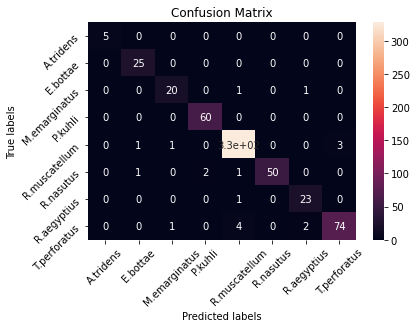

In [40]:
Y_pred = model.predict(X_test)
actual, predicted = generate_actual_predicted(Y_pred, X_test, Y_test)

##Confusion Matrix
from sklearn.metrics import confusion_matrix
actual_labeled = list()
predict_labeled = list()
for x,y in zip(actual,predicted):
    actual_labeled.append(getSpecies(x))
    predict_labeled.append(getSpecies(y))

labels = ['A.tridens','E.bottae','M.emarginatus','P.kuhli','R.muscatellum','R.nasutus', 'R.aegyptius', 'T.perforatus']
cm=confusion_matrix(actual_labeled,predict_labeled,labels=labels)
print(cm)

ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(labels,rotation=45); ax.yaxis.set_ticklabels(labels,rotation=45);

In [41]:
## Test accuracy
from sklearn.metrics import accuracy_score
print('accuracy', accuracy_score(actual, predicted))


accuracy 0.9685430463576159


In [42]:
## Precision, Recall, F1, Support
from sklearn.metrics import classification_report
print(classification_report(actual_labeled, predict_labeled,labels=labels))

               precision    recall  f1-score   support

    A.tridens       1.00      1.00      1.00         5
     E.bottae       0.93      1.00      0.96        25
M.emarginatus       0.91      0.91      0.91        22
      P.kuhli       0.97      1.00      0.98        60
R.muscatellum       0.98      0.98      0.98       333
    R.nasutus       1.00      0.93      0.96        54
  R.aegyptius       0.88      0.96      0.92        24
 T.perforatus       0.96      0.91      0.94        81

     accuracy                           0.97       604
    macro avg       0.95      0.96      0.96       604
 weighted avg       0.97      0.97      0.97       604



<h2>K-Fold Training and Evaluation</h2>

In [45]:
def build_current_model():
    inp = Input(shape=(112,170,3))
    c1 = Convolution2D(filters=120,kernel_size=(7,7),strides=(2,2),padding='same')(inp)
    bt = BatchNormalization()(c1)
    bt = Activation('relu')(bt)
    mpool = MaxPooling2D(pool_size=(2,2),strides=2,padding='same')(bt)
    mpool = Dropout(0.2)(mpool)


    c2 = Convolution2D(filters=152,kernel_size=(5,5),strides=(2,2),padding='same')(mpool)
    bt = BatchNormalization()(c2)
    bt = Activation('relu')(bt)
    #bt = LeakyReLU(alpha=0.01)(bt)
    mpool = AveragePooling2D(pool_size=(2,2),strides=2,padding='same')(bt)
    mpool = Dropout(0.3)(mpool)

    c2 = Convolution2D(filters=120,kernel_size=(3,3),strides=(1,1),padding='same')(mpool)
    bt = BatchNormalization()(c2)
    bt = Activation('relu')(bt)
    #bt = LeakyReLU(alpha=0.01)(bt)
    mpool = AveragePooling2D(pool_size=(2,2),strides=2,padding='same')(bt)
    mpool = Dropout(rate=0.3)(mpool)

    c3 = Convolution2D(filters=120,kernel_size=(3,3),strides=(1,1),padding='same')(mpool)
    bt = BatchNormalization()(c3)
    bt = Activation('relu')(bt)
    #bt = LeakyReLU(alpha=0.01)(bt)
    mpool = AveragePooling2D(pool_size=(2,2),strides=2,padding='same')(bt)
    mpool = Dropout(rate=0.4)(mpool)

    f = Flatten()(mpool)

    x_dense = Dense(512)(f)
    bt = BatchNormalization()(x_dense)
    bt = Activation('relu')(bt)
    bt = Dropout(0.4)(bt)


    x_dense = Dense(256)(bt)
    bt = BatchNormalization()(x_dense)
    bt = Activation('relu')(bt)
    bt = Dropout(0.3)(bt)

    x_dense = Dense(128)(bt)
    bt = BatchNormalization()(x_dense)
    bt = Activation('relu')(bt)
    bt = Dropout(0.2)(bt)

    x_out = Dense(8, name='output', activation='softmax')(bt)
    model = Model(inputs=inp, outputs=x_out)
    model.compile(
        optimizer=Adam(lr=0.003),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model


In [46]:
model = build_current_model()
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 112, 170, 3)]     0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 56, 85, 120)       17760     
_________________________________________________________________
batch_normalization_7 (Batch (None, 56, 85, 120)       480       
_________________________________________________________________
activation_7 (Activation)    (None, 56, 85, 120)       0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 28, 43, 120)       0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 28, 43, 120)       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 14, 22, 152)       4561

In [47]:
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc, precision_recall_curve
from sklearn.metrics import confusion_matrix

all_base_precision = list()
all_base_recall = list()
all_macro_precision = list()
all_macro_recall = list()
all_f1 = list()
all_macro_f1 = list()


all_tpr = list()
all_fpr = list()
all_precision = list()
all_recall = list()
all_cm=list()
all_accuracy = list()


n_split=5
n_classes=8

y_all_labelled=[]
for i in range(len(Y_all)):
        y_all_labelled.append(np.argmax(Y_all[i]))
        
my_callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=20,verbose=1, mode='min',restore_best_weights=True)]
       
for train_index,test_index in StratifiedKFold(n_split).split(X_all,y_all_labelled):  
    # use the index to generate training an testing sets
    x_train,x_test=X_all[train_index],X_all[test_index]
    y_train,y_test=Y_all[train_index],Y_all[test_index]
    
           
    # create and fit the model
    cv_model=build_current_model() # lr,dense,cnn
    history = cv_model.fit(x_train, y_train,
              batch_size=8,
              epochs=100,
              validation_split=0.1,
              verbose=1)
    
    #generate predictions
    y_pred = cv_model.predict(x_test)
    actual, predicted = generate_actual_predicted(y_pred, x_test, y_test)
    
    #calc metrics
    curr_base_prec, curr_base_rec, curr_f1, _ = precision_recall_fscore_support(actual, predicted)
    curr_macro_prec = precision_score(actual, predicted,average='macro')
    curr_macro_rec = recall_score(actual, predicted,average='macro')
    curr_macro_f1 = f1_score(actual, predicted,average='macro')
    
    
    actual_labeled = list()
    predict_labeled = list()
    for x,y in zip(actual,predicted):
        actual_labeled.append(getSpecies(x))
        predict_labeled.append(getSpecies(y))
        
    labels = ['A.tridens','E.bottae','M.emarginatus','P.kuhli','R.muscatellum','R.nasutus', 'R.aegyptius', 'T.perforatus']
    curr_cm=confusion_matrix(actual_labeled,predict_labeled,labels=labels)
    
    curr_fpr = [0] * n_classes
    curr_tpr = [0] * n_classes
    for i in range(n_classes):
        curr_fpr[i], curr_tpr[i], _ = roc_curve(y_test[:,i], y_pred[:,i])
        
    curr_prec = [0] * n_classes
    curr_rec = [0] * n_classes
    for i in range(n_classes):
        curr_prec[i], curr_rec[i], _ = precision_recall_curve(y_test[:,i], y_pred[:,i])

        
    curr_accuracy = accuracy_score(actual, predicted)
    
    #add to lists
    all_base_precision.append(curr_base_prec)
    all_base_recall.append(curr_base_rec)
    all_macro_precision.append(curr_macro_prec)
    all_macro_recall.append(curr_macro_rec)
    
    all_f1.append(curr_f1)
    all_macro_f1.append(curr_macro_f1)
    
    all_accuracy.append(curr_accuracy)

    
    all_fpr.append(curr_fpr)
    all_tpr.append(curr_tpr)
    all_precision.append(curr_prec)
    all_recall.append(curr_rec)
    all_cm.append(curr_cm)
    
    
    

Train on 2172 samples, validate on 242 samples
Epoch 1/100
2172/2172 [==============================] - ETA: 1:59 - loss: 2.8674 - acc: 0.0000e+0 - ETA: 22s - loss: 2.6171 - acc: 0.1250    - ETA: 13s - loss: 2.3100 - acc: 0.26 - ETA: 9s - loss: 2.1676 - acc: 0.3125 - ETA: 8s - loss: 2.0806 - acc: 0.361 - ETA: 7s - loss: 2.0543 - acc: 0.375 - ETA: 6s - loss: 2.0144 - acc: 0.370 - ETA: 5s - loss: 1.9512 - acc: 0.386 - ETA: 5s - loss: 1.9180 - acc: 0.381 - ETA: 5s - loss: 1.8992 - acc: 0.390 - ETA: 4s - loss: 1.8318 - acc: 0.404 - ETA: 4s - loss: 1.8211 - acc: 0.405 - ETA: 4s - loss: 1.7797 - acc: 0.419 - ETA: 4s - loss: 1.7756 - acc: 0.419 - ETA: 4s - loss: 1.7520 - acc: 0.427 - ETA: 3s - loss: 1.7615 - acc: 0.431 - ETA: 3s - loss: 1.7722 - acc: 0.429 - ETA: 3s - loss: 1.8039 - acc: 0.423 - ETA: 3s - loss: 1.7978 - acc: 0.421 - ETA: 3s - loss: 1.7837 - acc: 0.429 - ETA: 2s - loss: 1.7609 - acc: 0.434 - ETA: 2s - loss: 1.7318 - acc: 0.445 - ETA: 2s - loss: 1.7293 - acc: 0.449 - ETA: 2s - 

2172/2172 [==============================] - ETA: 3s - loss: 0.8402 - acc: 0.625 - ETA: 3s - loss: 1.1078 - acc: 0.583 - ETA: 3s - loss: 1.0680 - acc: 0.625 - ETA: 2s - loss: 1.1392 - acc: 0.609 - ETA: 2s - loss: 1.1952 - acc: 0.585 - ETA: 2s - loss: 1.2038 - acc: 0.588 - ETA: 2s - loss: 1.2001 - acc: 0.582 - ETA: 2s - loss: 1.1965 - acc: 0.582 - ETA: 2s - loss: 1.1826 - acc: 0.588 - ETA: 2s - loss: 1.2213 - acc: 0.576 - ETA: 2s - loss: 1.2180 - acc: 0.576 - ETA: 2s - loss: 1.2035 - acc: 0.579 - ETA: 2s - loss: 1.2003 - acc: 0.582 - ETA: 2s - loss: 1.1865 - acc: 0.589 - ETA: 2s - loss: 1.1879 - acc: 0.590 - ETA: 1s - loss: 1.1634 - acc: 0.602 - ETA: 1s - loss: 1.1909 - acc: 0.592 - ETA: 1s - loss: 1.2123 - acc: 0.589 - ETA: 1s - loss: 1.2096 - acc: 0.592 - ETA: 1s - loss: 1.2083 - acc: 0.592 - ETA: 1s - loss: 1.2130 - acc: 0.591 - ETA: 1s - loss: 1.2118 - acc: 0.592 - ETA: 1s - loss: 1.2119 - acc: 0.592 - ETA: 1s - loss: 1.2040 - acc: 0.593 - ETA: 1s - loss: 1.2124 - acc: 0.589 - ETA: 

2172/2172 [==============================] - ETA: 3s - loss: 0.9941 - acc: 0.625 - ETA: 3s - loss: 0.6628 - acc: 0.775 - ETA: 3s - loss: 1.0466 - acc: 0.652 - ETA: 3s - loss: 1.1162 - acc: 0.642 - ETA: 3s - loss: 1.0127 - acc: 0.668 - ETA: 2s - loss: 0.9832 - acc: 0.685 - ETA: 2s - loss: 0.9975 - acc: 0.677 - ETA: 2s - loss: 0.9727 - acc: 0.680 - ETA: 2s - loss: 0.9589 - acc: 0.679 - ETA: 2s - loss: 0.9732 - acc: 0.679 - ETA: 2s - loss: 0.9403 - acc: 0.691 - ETA: 2s - loss: 0.9202 - acc: 0.691 - ETA: 2s - loss: 0.9286 - acc: 0.687 - ETA: 2s - loss: 0.9311 - acc: 0.683 - ETA: 2s - loss: 0.9229 - acc: 0.687 - ETA: 2s - loss: 0.9202 - acc: 0.695 - ETA: 1s - loss: 0.9065 - acc: 0.699 - ETA: 1s - loss: 0.9103 - acc: 0.691 - ETA: 1s - loss: 0.9126 - acc: 0.687 - ETA: 1s - loss: 0.9172 - acc: 0.683 - ETA: 1s - loss: 0.9145 - acc: 0.685 - ETA: 1s - loss: 0.9081 - acc: 0.688 - ETA: 1s - loss: 0.9069 - acc: 0.687 - ETA: 1s - loss: 0.9201 - acc: 0.684 - ETA: 1s - loss: 0.9234 - acc: 0.682 - ETA: 

2172/2172 [==============================] - ETA: 3s - loss: 0.7416 - acc: 0.750 - ETA: 3s - loss: 0.8289 - acc: 0.750 - ETA: 2s - loss: 0.8657 - acc: 0.666 - ETA: 2s - loss: 0.8622 - acc: 0.687 - ETA: 2s - loss: 0.8064 - acc: 0.712 - ETA: 2s - loss: 0.7689 - acc: 0.728 - ETA: 2s - loss: 0.7478 - acc: 0.742 - ETA: 2s - loss: 0.7896 - acc: 0.716 - ETA: 2s - loss: 0.7901 - acc: 0.718 - ETA: 2s - loss: 0.7988 - acc: 0.721 - ETA: 2s - loss: 0.8241 - acc: 0.714 - ETA: 2s - loss: 0.8231 - acc: 0.720 - ETA: 2s - loss: 0.8020 - acc: 0.729 - ETA: 2s - loss: 0.8141 - acc: 0.729 - ETA: 1s - loss: 0.8157 - acc: 0.729 - ETA: 1s - loss: 0.8003 - acc: 0.733 - ETA: 1s - loss: 0.7908 - acc: 0.738 - ETA: 1s - loss: 0.7807 - acc: 0.744 - ETA: 1s - loss: 0.7741 - acc: 0.745 - ETA: 1s - loss: 0.7623 - acc: 0.750 - ETA: 1s - loss: 0.7703 - acc: 0.745 - ETA: 1s - loss: 0.7739 - acc: 0.744 - ETA: 1s - loss: 0.7805 - acc: 0.743 - ETA: 1s - loss: 0.7798 - acc: 0.743 - ETA: 1s - loss: 0.7889 - acc: 0.738 - ETA: 

2172/2172 [==============================] - ETA: 3s - loss: 0.4330 - acc: 0.875 - ETA: 3s - loss: 0.6105 - acc: 0.833 - ETA: 2s - loss: 0.7230 - acc: 0.778 - ETA: 2s - loss: 0.6668 - acc: 0.815 - ETA: 2s - loss: 0.6046 - acc: 0.830 - ETA: 2s - loss: 0.6189 - acc: 0.814 - ETA: 2s - loss: 0.6241 - acc: 0.817 - ETA: 2s - loss: 0.6352 - acc: 0.815 - ETA: 2s - loss: 0.6137 - acc: 0.816 - ETA: 2s - loss: 0.6545 - acc: 0.813 - ETA: 2s - loss: 0.6373 - acc: 0.811 - ETA: 2s - loss: 0.6268 - acc: 0.807 - ETA: 2s - loss: 0.6276 - acc: 0.805 - ETA: 1s - loss: 0.6285 - acc: 0.802 - ETA: 1s - loss: 0.6335 - acc: 0.802 - ETA: 1s - loss: 0.6172 - acc: 0.807 - ETA: 1s - loss: 0.6165 - acc: 0.808 - ETA: 1s - loss: 0.6239 - acc: 0.807 - ETA: 1s - loss: 0.6375 - acc: 0.803 - ETA: 1s - loss: 0.6594 - acc: 0.795 - ETA: 1s - loss: 0.6603 - acc: 0.794 - ETA: 1s - loss: 0.6756 - acc: 0.788 - ETA: 1s - loss: 0.6696 - acc: 0.789 - ETA: 1s - loss: 0.6792 - acc: 0.787 - ETA: 1s - loss: 0.6742 - acc: 0.788 - ETA: 

2172/2172 [==============================] - ETA: 4s - loss: 0.2097 - acc: 1.000 - ETA: 3s - loss: 0.4705 - acc: 0.850 - ETA: 2s - loss: 0.4593 - acc: 0.829 - ETA: 2s - loss: 0.4273 - acc: 0.851 - ETA: 2s - loss: 0.4191 - acc: 0.843 - ETA: 2s - loss: 0.4113 - acc: 0.843 - ETA: 2s - loss: 0.4335 - acc: 0.848 - ETA: 2s - loss: 0.4433 - acc: 0.841 - ETA: 2s - loss: 0.5064 - acc: 0.828 - ETA: 2s - loss: 0.4900 - acc: 0.833 - ETA: 2s - loss: 0.4690 - acc: 0.840 - ETA: 2s - loss: 0.4775 - acc: 0.840 - ETA: 2s - loss: 0.4680 - acc: 0.841 - ETA: 2s - loss: 0.4940 - acc: 0.831 - ETA: 2s - loss: 0.5096 - acc: 0.827 - ETA: 2s - loss: 0.5151 - acc: 0.828 - ETA: 2s - loss: 0.5180 - acc: 0.828 - ETA: 2s - loss: 0.5274 - acc: 0.823 - ETA: 2s - loss: 0.5285 - acc: 0.824 - ETA: 2s - loss: 0.5285 - acc: 0.826 - ETA: 1s - loss: 0.5177 - acc: 0.833 - ETA: 1s - loss: 0.5256 - acc: 0.830 - ETA: 1s - loss: 0.5263 - acc: 0.831 - ETA: 1s - loss: 0.5188 - acc: 0.832 - ETA: 1s - loss: 0.5142 - acc: 0.834 - ETA: 

2172/2172 [==============================] - ETA: 4s - loss: 0.2183 - acc: 0.875 - ETA: 3s - loss: 0.4904 - acc: 0.800 - ETA: 2s - loss: 0.5554 - acc: 0.829 - ETA: 2s - loss: 0.5275 - acc: 0.823 - ETA: 2s - loss: 0.4656 - acc: 0.837 - ETA: 2s - loss: 0.4502 - acc: 0.857 - ETA: 2s - loss: 0.4167 - acc: 0.871 - ETA: 2s - loss: 0.4070 - acc: 0.871 - ETA: 2s - loss: 0.3994 - acc: 0.877 - ETA: 2s - loss: 0.3873 - acc: 0.877 - ETA: 2s - loss: 0.4000 - acc: 0.870 - ETA: 2s - loss: 0.3953 - acc: 0.870 - ETA: 2s - loss: 0.4037 - acc: 0.867 - ETA: 2s - loss: 0.3824 - acc: 0.873 - ETA: 2s - loss: 0.3714 - acc: 0.875 - ETA: 2s - loss: 0.3634 - acc: 0.878 - ETA: 1s - loss: 0.3578 - acc: 0.879 - ETA: 1s - loss: 0.3625 - acc: 0.877 - ETA: 1s - loss: 0.3677 - acc: 0.876 - ETA: 1s - loss: 0.3730 - acc: 0.875 - ETA: 1s - loss: 0.3767 - acc: 0.875 - ETA: 1s - loss: 0.3685 - acc: 0.880 - ETA: 1s - loss: 0.3617 - acc: 0.885 - ETA: 1s - loss: 0.3618 - acc: 0.885 - ETA: 1s - loss: 0.3639 - acc: 0.885 - ETA: 

2172/2172 [==============================] - ETA: 3s - loss: 0.4177 - acc: 0.875 - ETA: 3s - loss: 0.3766 - acc: 0.895 - ETA: 2s - loss: 0.4011 - acc: 0.884 - ETA: 2s - loss: 0.4016 - acc: 0.868 - ETA: 2s - loss: 0.3896 - acc: 0.870 - ETA: 2s - loss: 0.3997 - acc: 0.862 - ETA: 2s - loss: 0.4053 - acc: 0.860 - ETA: 2s - loss: 0.4054 - acc: 0.865 - ETA: 2s - loss: 0.4502 - acc: 0.847 - ETA: 2s - loss: 0.4527 - acc: 0.843 - ETA: 2s - loss: 0.4598 - acc: 0.837 - ETA: 2s - loss: 0.4790 - acc: 0.838 - ETA: 2s - loss: 0.4900 - acc: 0.834 - ETA: 2s - loss: 0.4706 - acc: 0.840 - ETA: 1s - loss: 0.4767 - acc: 0.839 - ETA: 1s - loss: 0.4623 - acc: 0.844 - ETA: 1s - loss: 0.4557 - acc: 0.848 - ETA: 1s - loss: 0.4563 - acc: 0.846 - ETA: 1s - loss: 0.4616 - acc: 0.840 - ETA: 1s - loss: 0.4609 - acc: 0.840 - ETA: 1s - loss: 0.4667 - acc: 0.843 - ETA: 1s - loss: 0.4638 - acc: 0.844 - ETA: 1s - loss: 0.4566 - acc: 0.847 - ETA: 1s - loss: 0.4473 - acc: 0.850 - ETA: 1s - loss: 0.4460 - acc: 0.852 - ETA: 

2172/2172 [==============================] - ETA: 4s - loss: 0.1428 - acc: 1.000 - ETA: 3s - loss: 0.3788 - acc: 0.854 - ETA: 2s - loss: 0.2838 - acc: 0.875 - ETA: 2s - loss: 0.3656 - acc: 0.867 - ETA: 3s - loss: 0.3449 - acc: 0.875 - ETA: 3s - loss: 0.3386 - acc: 0.875 - ETA: 3s - loss: 0.3318 - acc: 0.879 - ETA: 3s - loss: 0.3094 - acc: 0.887 - ETA: 2s - loss: 0.2956 - acc: 0.899 - ETA: 2s - loss: 0.2883 - acc: 0.905 - ETA: 2s - loss: 0.2760 - acc: 0.908 - ETA: 2s - loss: 0.2835 - acc: 0.910 - ETA: 2s - loss: 0.2967 - acc: 0.908 - ETA: 2s - loss: 0.2926 - acc: 0.910 - ETA: 2s - loss: 0.2916 - acc: 0.912 - ETA: 2s - loss: 0.3117 - acc: 0.900 - ETA: 2s - loss: 0.3154 - acc: 0.894 - ETA: 2s - loss: 0.3292 - acc: 0.891 - ETA: 2s - loss: 0.3187 - acc: 0.896 - ETA: 2s - loss: 0.3175 - acc: 0.898 - ETA: 2s - loss: 0.3204 - acc: 0.898 - ETA: 2s - loss: 0.3261 - acc: 0.898 - ETA: 2s - loss: 0.3209 - acc: 0.898 - ETA: 1s - loss: 0.3255 - acc: 0.897 - ETA: 1s - loss: 0.3233 - acc: 0.897 - ETA: 

2172/2172 [==============================] - ETA: 2s - loss: 0.0099 - acc: 1.000 - ETA: 2s - loss: 0.3216 - acc: 0.890 - ETA: 2s - loss: 0.3204 - acc: 0.866 - ETA: 2s - loss: 0.3109 - acc: 0.887 - ETA: 2s - loss: 0.3252 - acc: 0.885 - ETA: 2s - loss: 0.3117 - acc: 0.888 - ETA: 2s - loss: 0.2982 - acc: 0.890 - ETA: 2s - loss: 0.2918 - acc: 0.898 - ETA: 2s - loss: 0.2781 - acc: 0.904 - ETA: 2s - loss: 0.2670 - acc: 0.903 - ETA: 2s - loss: 0.2726 - acc: 0.902 - ETA: 2s - loss: 0.2710 - acc: 0.902 - ETA: 2s - loss: 0.2985 - acc: 0.894 - ETA: 2s - loss: 0.2925 - acc: 0.897 - ETA: 2s - loss: 0.3009 - acc: 0.898 - ETA: 2s - loss: 0.3128 - acc: 0.895 - ETA: 1s - loss: 0.3046 - acc: 0.897 - ETA: 1s - loss: 0.3119 - acc: 0.894 - ETA: 1s - loss: 0.3235 - acc: 0.886 - ETA: 1s - loss: 0.3221 - acc: 0.888 - ETA: 1s - loss: 0.3204 - acc: 0.890 - ETA: 1s - loss: 0.3127 - acc: 0.891 - ETA: 1s - loss: 0.3139 - acc: 0.888 - ETA: 1s - loss: 0.3184 - acc: 0.888 - ETA: 1s - loss: 0.3324 - acc: 0.886 - ETA: 

2172/2172 [==============================] - ETA: 3s - loss: 0.1335 - acc: 1.000 - ETA: 3s - loss: 0.2957 - acc: 0.875 - ETA: 2s - loss: 0.2492 - acc: 0.897 - ETA: 2s - loss: 0.2292 - acc: 0.906 - ETA: 2s - loss: 0.2384 - acc: 0.892 - ETA: 2s - loss: 0.2456 - acc: 0.898 - ETA: 2s - loss: 0.2733 - acc: 0.894 - ETA: 2s - loss: 0.2661 - acc: 0.898 - ETA: 2s - loss: 0.2711 - acc: 0.898 - ETA: 2s - loss: 0.2584 - acc: 0.901 - ETA: 2s - loss: 0.2613 - acc: 0.905 - ETA: 2s - loss: 0.2521 - acc: 0.908 - ETA: 2s - loss: 0.2552 - acc: 0.907 - ETA: 2s - loss: 0.2558 - acc: 0.910 - ETA: 2s - loss: 0.2587 - acc: 0.910 - ETA: 1s - loss: 0.2570 - acc: 0.910 - ETA: 1s - loss: 0.2524 - acc: 0.911 - ETA: 1s - loss: 0.2517 - acc: 0.912 - ETA: 1s - loss: 0.2568 - acc: 0.908 - ETA: 1s - loss: 0.2577 - acc: 0.910 - ETA: 1s - loss: 0.2546 - acc: 0.910 - ETA: 1s - loss: 0.2508 - acc: 0.911 - ETA: 1s - loss: 0.2509 - acc: 0.911 - ETA: 1s - loss: 0.2536 - acc: 0.912 - ETA: 1s - loss: 0.2538 - acc: 0.912 - ETA: 

2172/2172 [==============================] - ETA: 3s - loss: 0.4381 - acc: 0.750 - ETA: 3s - loss: 0.2822 - acc: 0.895 - ETA: 2s - loss: 0.2432 - acc: 0.920 - ETA: 2s - loss: 0.2902 - acc: 0.914 - ETA: 2s - loss: 0.2629 - acc: 0.928 - ETA: 2s - loss: 0.2261 - acc: 0.944 - ETA: 2s - loss: 0.2244 - acc: 0.941 - ETA: 2s - loss: 0.2207 - acc: 0.935 - ETA: 2s - loss: 0.2040 - acc: 0.943 - ETA: 2s - loss: 0.1932 - acc: 0.944 - ETA: 2s - loss: 0.2031 - acc: 0.936 - ETA: 2s - loss: 0.2090 - acc: 0.930 - ETA: 2s - loss: 0.2079 - acc: 0.927 - ETA: 2s - loss: 0.2182 - acc: 0.923 - ETA: 2s - loss: 0.2221 - acc: 0.922 - ETA: 2s - loss: 0.2182 - acc: 0.924 - ETA: 2s - loss: 0.2125 - acc: 0.927 - ETA: 1s - loss: 0.2061 - acc: 0.929 - ETA: 1s - loss: 0.2165 - acc: 0.926 - ETA: 1s - loss: 0.2109 - acc: 0.928 - ETA: 1s - loss: 0.2260 - acc: 0.922 - ETA: 1s - loss: 0.2245 - acc: 0.923 - ETA: 1s - loss: 0.2242 - acc: 0.923 - ETA: 1s - loss: 0.2227 - acc: 0.923 - ETA: 1s - loss: 0.2275 - acc: 0.923 - ETA: 

2172/2172 [==============================] - ETA: 4s - loss: 0.1942 - acc: 0.875 - ETA: 4s - loss: 0.1096 - acc: 0.968 - ETA: 4s - loss: 0.1382 - acc: 0.964 - ETA: 3s - loss: 0.2268 - acc: 0.942 - ETA: 3s - loss: 0.2604 - acc: 0.921 - ETA: 2s - loss: 0.2478 - acc: 0.915 - ETA: 2s - loss: 0.2402 - acc: 0.916 - ETA: 2s - loss: 0.2350 - acc: 0.921 - ETA: 2s - loss: 0.2183 - acc: 0.928 - ETA: 2s - loss: 0.2004 - acc: 0.934 - ETA: 2s - loss: 0.1865 - acc: 0.942 - ETA: 2s - loss: 0.1873 - acc: 0.938 - ETA: 2s - loss: 0.1806 - acc: 0.940 - ETA: 2s - loss: 0.1827 - acc: 0.942 - ETA: 2s - loss: 0.1997 - acc: 0.935 - ETA: 2s - loss: 0.1993 - acc: 0.934 - ETA: 2s - loss: 0.1973 - acc: 0.932 - ETA: 1s - loss: 0.1929 - acc: 0.935 - ETA: 1s - loss: 0.2033 - acc: 0.930 - ETA: 1s - loss: 0.2045 - acc: 0.931 - ETA: 1s - loss: 0.2023 - acc: 0.931 - ETA: 1s - loss: 0.2038 - acc: 0.929 - ETA: 1s - loss: 0.2067 - acc: 0.928 - ETA: 1s - loss: 0.2029 - acc: 0.930 - ETA: 1s - loss: 0.2019 - acc: 0.930 - ETA: 

2172/2172 [==============================] - ETA: 2s - loss: 1.0703 - acc: 0.625 - ETA: 2s - loss: 0.3254 - acc: 0.875 - ETA: 2s - loss: 0.2760 - acc: 0.906 - ETA: 2s - loss: 0.2430 - acc: 0.914 - ETA: 2s - loss: 0.2550 - acc: 0.910 - ETA: 2s - loss: 0.2233 - acc: 0.921 - ETA: 2s - loss: 0.2106 - acc: 0.925 - ETA: 2s - loss: 0.2235 - acc: 0.922 - ETA: 2s - loss: 0.2189 - acc: 0.927 - ETA: 2s - loss: 0.2096 - acc: 0.931 - ETA: 2s - loss: 0.2000 - acc: 0.933 - ETA: 2s - loss: 0.1924 - acc: 0.934 - ETA: 2s - loss: 0.1898 - acc: 0.935 - ETA: 2s - loss: 0.2030 - acc: 0.930 - ETA: 1s - loss: 0.2148 - acc: 0.925 - ETA: 1s - loss: 0.2675 - acc: 0.917 - ETA: 1s - loss: 0.2796 - acc: 0.916 - ETA: 1s - loss: 0.2799 - acc: 0.913 - ETA: 1s - loss: 0.2882 - acc: 0.914 - ETA: 1s - loss: 0.2771 - acc: 0.918 - ETA: 1s - loss: 0.2736 - acc: 0.919 - ETA: 1s - loss: 0.2718 - acc: 0.918 - ETA: 1s - loss: 0.2819 - acc: 0.918 - ETA: 1s - loss: 0.2796 - acc: 0.918 - ETA: 1s - loss: 0.2817 - acc: 0.917 - ETA: 

2172/2172 [==============================] - ETA: 3s - loss: 0.0395 - acc: 1.000 - ETA: 2s - loss: 0.0655 - acc: 0.979 - ETA: 2s - loss: 0.1340 - acc: 0.947 - ETA: 2s - loss: 0.1516 - acc: 0.945 - ETA: 2s - loss: 0.1419 - acc: 0.950 - ETA: 2s - loss: 0.1870 - acc: 0.940 - ETA: 2s - loss: 0.1870 - acc: 0.947 - ETA: 2s - loss: 0.1794 - acc: 0.947 - ETA: 2s - loss: 0.1720 - acc: 0.951 - ETA: 2s - loss: 0.1678 - acc: 0.953 - ETA: 2s - loss: 0.1598 - acc: 0.955 - ETA: 2s - loss: 0.1563 - acc: 0.956 - ETA: 2s - loss: 0.1493 - acc: 0.958 - ETA: 2s - loss: 0.1446 - acc: 0.959 - ETA: 2s - loss: 0.1409 - acc: 0.960 - ETA: 2s - loss: 0.1389 - acc: 0.960 - ETA: 2s - loss: 0.1510 - acc: 0.955 - ETA: 2s - loss: 0.1745 - acc: 0.949 - ETA: 2s - loss: 0.1835 - acc: 0.947 - ETA: 2s - loss: 0.1925 - acc: 0.946 - ETA: 2s - loss: 0.1871 - acc: 0.947 - ETA: 1s - loss: 0.1974 - acc: 0.946 - ETA: 1s - loss: 0.1912 - acc: 0.948 - ETA: 1s - loss: 0.1876 - acc: 0.950 - ETA: 1s - loss: 0.1917 - acc: 0.947 - ETA: 

2172/2172 [==============================] - ETA: 4s - loss: 0.0092 - acc: 1.000 - ETA: 4s - loss: 0.1693 - acc: 0.925 - ETA: 3s - loss: 0.1456 - acc: 0.925 - ETA: 3s - loss: 0.1368 - acc: 0.941 - ETA: 3s - loss: 0.1863 - acc: 0.937 - ETA: 2s - loss: 0.1700 - acc: 0.947 - ETA: 2s - loss: 0.1620 - acc: 0.951 - ETA: 2s - loss: 0.1511 - acc: 0.954 - ETA: 2s - loss: 0.1593 - acc: 0.949 - ETA: 2s - loss: 0.1488 - acc: 0.953 - ETA: 2s - loss: 0.1372 - acc: 0.958 - ETA: 2s - loss: 0.1343 - acc: 0.960 - ETA: 2s - loss: 0.1418 - acc: 0.955 - ETA: 2s - loss: 0.1532 - acc: 0.951 - ETA: 2s - loss: 0.1488 - acc: 0.955 - ETA: 2s - loss: 0.1587 - acc: 0.954 - ETA: 2s - loss: 0.1731 - acc: 0.950 - ETA: 1s - loss: 0.1685 - acc: 0.951 - ETA: 1s - loss: 0.1888 - acc: 0.949 - ETA: 1s - loss: 0.1886 - acc: 0.950 - ETA: 1s - loss: 0.1856 - acc: 0.950 - ETA: 1s - loss: 0.1816 - acc: 0.951 - ETA: 1s - loss: 0.1883 - acc: 0.950 - ETA: 1s - loss: 0.1833 - acc: 0.951 - ETA: 1s - loss: 0.1902 - acc: 0.948 - ETA: 

2172/2172 [==============================] - ETA: 4s - loss: 0.0667 - acc: 1.000 - ETA: 4s - loss: 0.2187 - acc: 0.937 - ETA: 4s - loss: 0.1490 - acc: 0.964 - ETA: 3s - loss: 0.1240 - acc: 0.968 - ETA: 3s - loss: 0.2034 - acc: 0.944 - ETA: 3s - loss: 0.1779 - acc: 0.951 - ETA: 2s - loss: 0.1685 - acc: 0.955 - ETA: 2s - loss: 0.1911 - acc: 0.935 - ETA: 2s - loss: 0.1789 - acc: 0.939 - ETA: 2s - loss: 0.1811 - acc: 0.942 - ETA: 2s - loss: 0.1911 - acc: 0.937 - ETA: 2s - loss: 0.1961 - acc: 0.936 - ETA: 2s - loss: 0.1900 - acc: 0.936 - ETA: 2s - loss: 0.1781 - acc: 0.940 - ETA: 2s - loss: 0.1807 - acc: 0.941 - ETA: 2s - loss: 0.1746 - acc: 0.941 - ETA: 2s - loss: 0.1771 - acc: 0.939 - ETA: 2s - loss: 0.1726 - acc: 0.941 - ETA: 2s - loss: 0.1762 - acc: 0.939 - ETA: 1s - loss: 0.1849 - acc: 0.938 - ETA: 1s - loss: 0.1820 - acc: 0.939 - ETA: 1s - loss: 0.1740 - acc: 0.941 - ETA: 1s - loss: 0.1709 - acc: 0.942 - ETA: 1s - loss: 0.1747 - acc: 0.940 - ETA: 1s - loss: 0.1776 - acc: 0.938 - ETA: 

2172/2172 [==============================] - ETA: 2s - loss: 0.1363 - acc: 0.875 - ETA: 2s - loss: 0.1680 - acc: 0.916 - ETA: 2s - loss: 0.1107 - acc: 0.947 - ETA: 2s - loss: 0.1050 - acc: 0.951 - ETA: 2s - loss: 0.0846 - acc: 0.963 - ETA: 2s - loss: 0.0757 - acc: 0.966 - ETA: 2s - loss: 0.1070 - acc: 0.961 - ETA: 2s - loss: 0.0975 - acc: 0.966 - ETA: 2s - loss: 0.1058 - acc: 0.960 - ETA: 2s - loss: 0.1079 - acc: 0.959 - ETA: 2s - loss: 0.1028 - acc: 0.961 - ETA: 2s - loss: 0.1012 - acc: 0.963 - ETA: 2s - loss: 0.1052 - acc: 0.962 - ETA: 1s - loss: 0.1042 - acc: 0.962 - ETA: 1s - loss: 0.1056 - acc: 0.963 - ETA: 1s - loss: 0.1080 - acc: 0.963 - ETA: 1s - loss: 0.1256 - acc: 0.961 - ETA: 1s - loss: 0.1225 - acc: 0.961 - ETA: 1s - loss: 0.1368 - acc: 0.961 - ETA: 1s - loss: 0.1376 - acc: 0.961 - ETA: 1s - loss: 0.1404 - acc: 0.961 - ETA: 1s - loss: 0.1403 - acc: 0.962 - ETA: 1s - loss: 0.1363 - acc: 0.963 - ETA: 1s - loss: 0.1403 - acc: 0.961 - ETA: 1s - loss: 0.1375 - acc: 0.962 - ETA: 

2172/2172 [==============================] - ETA: 3s - loss: 0.3206 - acc: 0.750 - ETA: 3s - loss: 0.1986 - acc: 0.875 - ETA: 3s - loss: 0.1539 - acc: 0.916 - ETA: 3s - loss: 0.1657 - acc: 0.937 - ETA: 3s - loss: 0.1724 - acc: 0.947 - ETA: 3s - loss: 0.1530 - acc: 0.953 - ETA: 2s - loss: 0.1411 - acc: 0.956 - ETA: 2s - loss: 0.1332 - acc: 0.960 - ETA: 2s - loss: 0.1285 - acc: 0.959 - ETA: 2s - loss: 0.1221 - acc: 0.961 - ETA: 2s - loss: 0.1182 - acc: 0.960 - ETA: 2s - loss: 0.1179 - acc: 0.959 - ETA: 2s - loss: 0.1162 - acc: 0.957 - ETA: 2s - loss: 0.1286 - acc: 0.952 - ETA: 2s - loss: 0.1322 - acc: 0.951 - ETA: 2s - loss: 0.1326 - acc: 0.951 - ETA: 2s - loss: 0.1291 - acc: 0.951 - ETA: 2s - loss: 0.1266 - acc: 0.953 - ETA: 2s - loss: 0.1286 - acc: 0.953 - ETA: 2s - loss: 0.1266 - acc: 0.954 - ETA: 2s - loss: 0.1235 - acc: 0.953 - ETA: 1s - loss: 0.1187 - acc: 0.955 - ETA: 1s - loss: 0.1166 - acc: 0.956 - ETA: 1s - loss: 0.1186 - acc: 0.955 - ETA: 1s - loss: 0.1224 - acc: 0.954 - ETA: 

2172/2172 [==============================] - ETA: 2s - loss: 0.0011 - acc: 1.000 - ETA: 2s - loss: 0.0341 - acc: 0.982 - ETA: 2s - loss: 0.0656 - acc: 0.971 - ETA: 2s - loss: 0.0744 - acc: 0.972 - ETA: 2s - loss: 0.0706 - acc: 0.972 - ETA: 2s - loss: 0.1225 - acc: 0.965 - ETA: 2s - loss: 0.1100 - acc: 0.970 - ETA: 2s - loss: 0.1013 - acc: 0.970 - ETA: 2s - loss: 0.0946 - acc: 0.970 - ETA: 2s - loss: 0.0883 - acc: 0.974 - ETA: 2s - loss: 0.1586 - acc: 0.962 - ETA: 2s - loss: 0.1458 - acc: 0.966 - ETA: 2s - loss: 0.1410 - acc: 0.965 - ETA: 2s - loss: 0.1449 - acc: 0.965 - ETA: 2s - loss: 0.1456 - acc: 0.964 - ETA: 2s - loss: 0.1477 - acc: 0.962 - ETA: 2s - loss: 0.1511 - acc: 0.963 - ETA: 2s - loss: 0.1669 - acc: 0.963 - ETA: 1s - loss: 0.1632 - acc: 0.964 - ETA: 1s - loss: 0.1553 - acc: 0.966 - ETA: 1s - loss: 0.1509 - acc: 0.966 - ETA: 1s - loss: 0.1494 - acc: 0.965 - ETA: 1s - loss: 0.1473 - acc: 0.966 - ETA: 1s - loss: 0.1482 - acc: 0.963 - ETA: 1s - loss: 0.1576 - acc: 0.962 - ETA: 

2172/2172 [==============================] - ETA: 3s - loss: 0.1079 - acc: 0.875 - ETA: 2s - loss: 0.1850 - acc: 0.946 - ETA: 2s - loss: 0.1194 - acc: 0.961 - ETA: 2s - loss: 0.1134 - acc: 0.958 - ETA: 2s - loss: 0.1067 - acc: 0.962 - ETA: 2s - loss: 0.0962 - acc: 0.968 - ETA: 2s - loss: 0.0829 - acc: 0.973 - ETA: 2s - loss: 0.0762 - acc: 0.974 - ETA: 2s - loss: 0.0736 - acc: 0.975 - ETA: 2s - loss: 0.0690 - acc: 0.977 - ETA: 2s - loss: 0.0726 - acc: 0.975 - ETA: 2s - loss: 0.0731 - acc: 0.971 - ETA: 2s - loss: 0.0797 - acc: 0.969 - ETA: 2s - loss: 0.0742 - acc: 0.972 - ETA: 1s - loss: 0.0724 - acc: 0.972 - ETA: 1s - loss: 0.0685 - acc: 0.974 - ETA: 1s - loss: 0.0672 - acc: 0.974 - ETA: 1s - loss: 0.0687 - acc: 0.974 - ETA: 1s - loss: 0.0677 - acc: 0.974 - ETA: 1s - loss: 0.0653 - acc: 0.975 - ETA: 1s - loss: 0.0654 - acc: 0.976 - ETA: 1s - loss: 0.0658 - acc: 0.977 - ETA: 1s - loss: 0.0677 - acc: 0.976 - ETA: 1s - loss: 0.0746 - acc: 0.973 - ETA: 1s - loss: 0.0713 - acc: 0.974 - ETA: 

2172/2172 [==============================] - ETA: 4s - loss: 0.0445 - acc: 1.000 - ETA: 4s - loss: 0.0519 - acc: 0.968 - ETA: 3s - loss: 0.0653 - acc: 0.975 - ETA: 2s - loss: 0.0687 - acc: 0.976 - ETA: 2s - loss: 0.0756 - acc: 0.977 - ETA: 2s - loss: 0.0695 - acc: 0.980 - ETA: 3s - loss: 0.0652 - acc: 0.982 - ETA: 3s - loss: 0.0994 - acc: 0.975 - ETA: 3s - loss: 0.0921 - acc: 0.977 - ETA: 3s - loss: 0.0813 - acc: 0.980 - ETA: 2s - loss: 0.0903 - acc: 0.980 - ETA: 2s - loss: 0.0895 - acc: 0.977 - ETA: 2s - loss: 0.0860 - acc: 0.976 - ETA: 2s - loss: 0.1001 - acc: 0.974 - ETA: 2s - loss: 0.0960 - acc: 0.975 - ETA: 2s - loss: 0.0943 - acc: 0.973 - ETA: 2s - loss: 0.0987 - acc: 0.970 - ETA: 2s - loss: 0.1070 - acc: 0.971 - ETA: 2s - loss: 0.1031 - acc: 0.971 - ETA: 2s - loss: 0.0984 - acc: 0.973 - ETA: 2s - loss: 0.0963 - acc: 0.974 - ETA: 1s - loss: 0.1007 - acc: 0.972 - ETA: 1s - loss: 0.1111 - acc: 0.967 - ETA: 1s - loss: 0.1133 - acc: 0.966 - ETA: 1s - loss: 0.1157 - acc: 0.965 - ETA: 

2172/2172 [==============================] - ETA: 3s - loss: 0.0248 - acc: 1.000 - ETA: 3s - loss: 0.0312 - acc: 0.975 - ETA: 3s - loss: 0.0576 - acc: 0.975 - ETA: 2s - loss: 0.0977 - acc: 0.968 - ETA: 2s - loss: 0.0806 - acc: 0.971 - ETA: 2s - loss: 0.0774 - acc: 0.973 - ETA: 2s - loss: 0.0727 - acc: 0.970 - ETA: 2s - loss: 0.0691 - acc: 0.973 - ETA: 2s - loss: 0.0636 - acc: 0.976 - ETA: 2s - loss: 0.0752 - acc: 0.974 - ETA: 2s - loss: 0.0700 - acc: 0.976 - ETA: 2s - loss: 0.0658 - acc: 0.978 - ETA: 2s - loss: 0.0655 - acc: 0.978 - ETA: 2s - loss: 0.0704 - acc: 0.973 - ETA: 2s - loss: 0.0737 - acc: 0.972 - ETA: 2s - loss: 0.0746 - acc: 0.971 - ETA: 2s - loss: 0.0796 - acc: 0.971 - ETA: 1s - loss: 0.0806 - acc: 0.970 - ETA: 1s - loss: 0.0775 - acc: 0.971 - ETA: 1s - loss: 0.0760 - acc: 0.972 - ETA: 1s - loss: 0.0726 - acc: 0.973 - ETA: 1s - loss: 0.0696 - acc: 0.975 - ETA: 1s - loss: 0.0683 - acc: 0.975 - ETA: 1s - loss: 0.0660 - acc: 0.976 - ETA: 1s - loss: 0.0637 - acc: 0.977 - ETA: 

2172/2172 [==============================] - ETA: 3s - loss: 0.0148 - acc: 1.000 - ETA: 3s - loss: 0.0091 - acc: 1.000 - ETA: 3s - loss: 0.1223 - acc: 0.975 - ETA: 2s - loss: 0.0917 - acc: 0.976 - ETA: 2s - loss: 0.1041 - acc: 0.977 - ETA: 2s - loss: 0.1304 - acc: 0.968 - ETA: 2s - loss: 0.1420 - acc: 0.962 - ETA: 2s - loss: 0.1352 - acc: 0.960 - ETA: 2s - loss: 0.1266 - acc: 0.960 - ETA: 2s - loss: 0.1209 - acc: 0.962 - ETA: 2s - loss: 0.1167 - acc: 0.963 - ETA: 2s - loss: 0.1150 - acc: 0.961 - ETA: 2s - loss: 0.1232 - acc: 0.957 - ETA: 2s - loss: 0.1382 - acc: 0.957 - ETA: 2s - loss: 0.1315 - acc: 0.958 - ETA: 1s - loss: 0.1259 - acc: 0.959 - ETA: 1s - loss: 0.1242 - acc: 0.958 - ETA: 1s - loss: 0.1196 - acc: 0.960 - ETA: 1s - loss: 0.1165 - acc: 0.960 - ETA: 1s - loss: 0.1164 - acc: 0.960 - ETA: 1s - loss: 0.1214 - acc: 0.957 - ETA: 1s - loss: 0.1259 - acc: 0.956 - ETA: 1s - loss: 0.1222 - acc: 0.957 - ETA: 1s - loss: 0.1205 - acc: 0.957 - ETA: 1s - loss: 0.1233 - acc: 0.957 - ETA: 

2172/2172 [==============================] - ETA: 2s - loss: 0.0137 - acc: 1.000 - ETA: 2s - loss: 0.0849 - acc: 0.968 - ETA: 2s - loss: 0.0784 - acc: 0.973 - ETA: 2s - loss: 0.0674 - acc: 0.975 - ETA: 2s - loss: 0.0605 - acc: 0.980 - ETA: 2s - loss: 0.0550 - acc: 0.983 - ETA: 2s - loss: 0.0648 - acc: 0.981 - ETA: 2s - loss: 0.0581 - acc: 0.984 - ETA: 2s - loss: 0.0862 - acc: 0.977 - ETA: 2s - loss: 0.0796 - acc: 0.980 - ETA: 2s - loss: 0.0749 - acc: 0.981 - ETA: 2s - loss: 0.0872 - acc: 0.978 - ETA: 2s - loss: 0.0834 - acc: 0.980 - ETA: 2s - loss: 0.0925 - acc: 0.978 - ETA: 2s - loss: 0.0869 - acc: 0.980 - ETA: 1s - loss: 0.0854 - acc: 0.979 - ETA: 1s - loss: 0.0923 - acc: 0.977 - ETA: 1s - loss: 0.0894 - acc: 0.978 - ETA: 1s - loss: 0.0876 - acc: 0.977 - ETA: 1s - loss: 0.0851 - acc: 0.977 - ETA: 1s - loss: 0.0824 - acc: 0.978 - ETA: 1s - loss: 0.0860 - acc: 0.975 - ETA: 1s - loss: 0.0841 - acc: 0.976 - ETA: 1s - loss: 0.0833 - acc: 0.976 - ETA: 1s - loss: 0.0810 - acc: 0.977 - ETA: 

2172/2172 [==============================] - ETA: 3s - loss: 0.0278 - acc: 1.000 - ETA: 3s - loss: 0.0300 - acc: 1.000 - ETA: 2s - loss: 0.0771 - acc: 0.977 - ETA: 2s - loss: 0.0709 - acc: 0.975 - ETA: 3s - loss: 0.0673 - acc: 0.973 - ETA: 2s - loss: 0.0640 - acc: 0.975 - ETA: 2s - loss: 0.0677 - acc: 0.975 - ETA: 2s - loss: 0.0645 - acc: 0.979 - ETA: 2s - loss: 0.0755 - acc: 0.976 - ETA: 2s - loss: 0.0700 - acc: 0.979 - ETA: 2s - loss: 0.0683 - acc: 0.981 - ETA: 2s - loss: 0.0655 - acc: 0.980 - ETA: 2s - loss: 0.0606 - acc: 0.982 - ETA: 2s - loss: 0.0619 - acc: 0.980 - ETA: 2s - loss: 0.0646 - acc: 0.978 - ETA: 2s - loss: 0.0635 - acc: 0.978 - ETA: 1s - loss: 0.0642 - acc: 0.977 - ETA: 1s - loss: 0.0664 - acc: 0.977 - ETA: 1s - loss: 0.0663 - acc: 0.977 - ETA: 1s - loss: 0.0657 - acc: 0.977 - ETA: 1s - loss: 0.0721 - acc: 0.976 - ETA: 1s - loss: 0.0724 - acc: 0.976 - ETA: 1s - loss: 0.0705 - acc: 0.977 - ETA: 1s - loss: 0.0723 - acc: 0.976 - ETA: 1s - loss: 0.0709 - acc: 0.976 - ETA: 

2172/2172 [==============================] - ETA: 2s - loss: 0.0020 - acc: 1.000 - ETA: 2s - loss: 0.0439 - acc: 0.982 - ETA: 2s - loss: 0.0293 - acc: 0.989 - ETA: 2s - loss: 0.1017 - acc: 0.976 - ETA: 2s - loss: 0.0818 - acc: 0.983 - ETA: 2s - loss: 0.0789 - acc: 0.986 - ETA: 2s - loss: 0.0897 - acc: 0.981 - ETA: 2s - loss: 0.0927 - acc: 0.977 - ETA: 2s - loss: 0.0912 - acc: 0.977 - ETA: 2s - loss: 0.0847 - acc: 0.979 - ETA: 2s - loss: 0.0786 - acc: 0.981 - ETA: 2s - loss: 0.0721 - acc: 0.983 - ETA: 2s - loss: 0.0797 - acc: 0.975 - ETA: 2s - loss: 0.0881 - acc: 0.973 - ETA: 2s - loss: 0.0870 - acc: 0.974 - ETA: 1s - loss: 0.0855 - acc: 0.974 - ETA: 1s - loss: 0.0923 - acc: 0.971 - ETA: 1s - loss: 0.0908 - acc: 0.973 - ETA: 1s - loss: 0.0877 - acc: 0.974 - ETA: 1s - loss: 0.0873 - acc: 0.974 - ETA: 1s - loss: 0.0846 - acc: 0.975 - ETA: 1s - loss: 0.0843 - acc: 0.975 - ETA: 1s - loss: 0.0825 - acc: 0.975 - ETA: 1s - loss: 0.0842 - acc: 0.975 - ETA: 1s - loss: 0.0866 - acc: 0.974 - ETA: 

2172/2172 [==============================] - ETA: 2s - loss: 0.1593 - acc: 0.875 - ETA: 2s - loss: 0.0489 - acc: 0.984 - ETA: 2s - loss: 0.0334 - acc: 0.991 - ETA: 2s - loss: 0.0360 - acc: 0.993 - ETA: 2s - loss: 0.0523 - acc: 0.990 - ETA: 2s - loss: 0.0470 - acc: 0.991 - ETA: 2s - loss: 0.0494 - acc: 0.989 - ETA: 2s - loss: 0.0493 - acc: 0.990 - ETA: 2s - loss: 0.0494 - acc: 0.991 - ETA: 2s - loss: 0.0495 - acc: 0.990 - ETA: 2s - loss: 0.0475 - acc: 0.991 - ETA: 1s - loss: 0.0446 - acc: 0.992 - ETA: 1s - loss: 0.0412 - acc: 0.993 - ETA: 1s - loss: 0.0629 - acc: 0.987 - ETA: 1s - loss: 0.0594 - acc: 0.988 - ETA: 1s - loss: 0.0590 - acc: 0.987 - ETA: 1s - loss: 0.0592 - acc: 0.987 - ETA: 1s - loss: 0.0569 - acc: 0.987 - ETA: 1s - loss: 0.0543 - acc: 0.988 - ETA: 1s - loss: 0.0542 - acc: 0.986 - ETA: 1s - loss: 0.0524 - acc: 0.987 - ETA: 1s - loss: 0.0526 - acc: 0.986 - ETA: 1s - loss: 0.0531 - acc: 0.986 - ETA: 1s - loss: 0.0519 - acc: 0.986 - ETA: 1s - loss: 0.0562 - acc: 0.984 - ETA: 

2172/2172 [==============================] - ETA: 2s - loss: 0.0024 - acc: 1.000 - ETA: 2s - loss: 0.0108 - acc: 1.000 - ETA: 2s - loss: 0.0165 - acc: 1.000 - ETA: 2s - loss: 0.0132 - acc: 1.000 - ETA: 2s - loss: 0.0263 - acc: 0.995 - ETA: 2s - loss: 0.0572 - acc: 0.988 - ETA: 2s - loss: 0.0487 - acc: 0.990 - ETA: 2s - loss: 0.0454 - acc: 0.991 - ETA: 2s - loss: 0.0436 - acc: 0.992 - ETA: 2s - loss: 0.0462 - acc: 0.990 - ETA: 2s - loss: 0.0523 - acc: 0.989 - ETA: 2s - loss: 0.0495 - acc: 0.989 - ETA: 2s - loss: 0.0471 - acc: 0.990 - ETA: 1s - loss: 0.0545 - acc: 0.988 - ETA: 1s - loss: 0.0519 - acc: 0.988 - ETA: 1s - loss: 0.0589 - acc: 0.986 - ETA: 1s - loss: 0.0563 - acc: 0.987 - ETA: 1s - loss: 0.0675 - acc: 0.984 - ETA: 1s - loss: 0.0681 - acc: 0.983 - ETA: 1s - loss: 0.0657 - acc: 0.984 - ETA: 1s - loss: 0.0685 - acc: 0.983 - ETA: 1s - loss: 0.0655 - acc: 0.983 - ETA: 1s - loss: 0.0645 - acc: 0.984 - ETA: 1s - loss: 0.0675 - acc: 0.983 - ETA: 1s - loss: 0.0651 - acc: 0.983 - ETA: 

2172/2172 [==============================] - ETA: 2s - loss: 0.0014 - acc: 1.000 - ETA: 2s - loss: 0.0118 - acc: 1.000 - ETA: 2s - loss: 0.0119 - acc: 1.000 - ETA: 2s - loss: 0.0122 - acc: 1.000 - ETA: 2s - loss: 0.0233 - acc: 0.994 - ETA: 2s - loss: 0.0467 - acc: 0.982 - ETA: 2s - loss: 0.0619 - acc: 0.981 - ETA: 2s - loss: 0.0561 - acc: 0.983 - ETA: 2s - loss: 0.0703 - acc: 0.982 - ETA: 2s - loss: 0.0853 - acc: 0.981 - ETA: 2s - loss: 0.0870 - acc: 0.978 - ETA: 2s - loss: 0.0884 - acc: 0.976 - ETA: 2s - loss: 0.0845 - acc: 0.976 - ETA: 2s - loss: 0.0780 - acc: 0.978 - ETA: 2s - loss: 0.0847 - acc: 0.976 - ETA: 2s - loss: 0.0879 - acc: 0.972 - ETA: 1s - loss: 0.0826 - acc: 0.974 - ETA: 1s - loss: 0.0804 - acc: 0.976 - ETA: 1s - loss: 0.0769 - acc: 0.977 - ETA: 1s - loss: 0.0740 - acc: 0.978 - ETA: 1s - loss: 0.0796 - acc: 0.977 - ETA: 1s - loss: 0.0793 - acc: 0.976 - ETA: 1s - loss: 0.0796 - acc: 0.975 - ETA: 1s - loss: 0.0775 - acc: 0.975 - ETA: 1s - loss: 0.0758 - acc: 0.976 - ETA: 

2172/2172 [==============================] - ETA: 5s - loss: 5.8943e-04 - acc: 1.000 - ETA: 4s - loss: 0.0042 - acc: 1.0000    - ETA: 4s - loss: 0.0153 - acc: 1.000 - ETA: 4s - loss: 0.0142 - acc: 1.000 - ETA: 3s - loss: 0.0234 - acc: 1.000 - ETA: 3s - loss: 0.0210 - acc: 1.000 - ETA: 3s - loss: 0.0185 - acc: 1.000 - ETA: 3s - loss: 0.0219 - acc: 1.000 - ETA: 2s - loss: 0.0228 - acc: 0.996 - ETA: 2s - loss: 0.0359 - acc: 0.993 - ETA: 2s - loss: 0.0460 - acc: 0.986 - ETA: 2s - loss: 0.0543 - acc: 0.982 - ETA: 2s - loss: 0.0607 - acc: 0.978 - ETA: 2s - loss: 0.0561 - acc: 0.979 - ETA: 2s - loss: 0.0542 - acc: 0.981 - ETA: 2s - loss: 0.0523 - acc: 0.982 - ETA: 2s - loss: 0.0545 - acc: 0.980 - ETA: 2s - loss: 0.0532 - acc: 0.981 - ETA: 2s - loss: 0.0572 - acc: 0.979 - ETA: 2s - loss: 0.0555 - acc: 0.980 - ETA: 2s - loss: 0.0566 - acc: 0.978 - ETA: 2s - loss: 0.0547 - acc: 0.979 - ETA: 1s - loss: 0.0634 - acc: 0.978 - ETA: 1s - loss: 0.0625 - acc: 0.978 - ETA: 1s - loss: 0.0624 - acc: 0.978

2172/2172 [==============================] - ETA: 3s - loss: 0.0091 - acc: 1.000 - ETA: 3s - loss: 0.1892 - acc: 0.937 - ETA: 2s - loss: 0.1140 - acc: 0.958 - ETA: 2s - loss: 0.0920 - acc: 0.963 - ETA: 2s - loss: 0.0798 - acc: 0.971 - ETA: 2s - loss: 0.0954 - acc: 0.968 - ETA: 2s - loss: 0.1249 - acc: 0.962 - ETA: 2s - loss: 0.1254 - acc: 0.963 - ETA: 2s - loss: 0.1224 - acc: 0.962 - ETA: 2s - loss: 0.1119 - acc: 0.966 - ETA: 2s - loss: 0.1051 - acc: 0.965 - ETA: 2s - loss: 0.1028 - acc: 0.966 - ETA: 2s - loss: 0.0970 - acc: 0.969 - ETA: 2s - loss: 0.0914 - acc: 0.971 - ETA: 1s - loss: 0.0956 - acc: 0.970 - ETA: 1s - loss: 0.0925 - acc: 0.971 - ETA: 1s - loss: 0.0895 - acc: 0.972 - ETA: 1s - loss: 0.0869 - acc: 0.972 - ETA: 1s - loss: 0.0947 - acc: 0.970 - ETA: 1s - loss: 0.0928 - acc: 0.970 - ETA: 1s - loss: 0.0913 - acc: 0.970 - ETA: 1s - loss: 0.0908 - acc: 0.970 - ETA: 1s - loss: 0.0912 - acc: 0.969 - ETA: 1s - loss: 0.0885 - acc: 0.970 - ETA: 1s - loss: 0.0860 - acc: 0.971 - ETA: 

2172/2172 [==============================] - ETA: 3s - loss: 0.1361 - acc: 0.875 - ETA: 4s - loss: 0.0554 - acc: 0.968 - ETA: 3s - loss: 0.0291 - acc: 0.986 - ETA: 2s - loss: 0.1724 - acc: 0.941 - ETA: 2s - loss: 0.1282 - acc: 0.958 - ETA: 2s - loss: 0.1100 - acc: 0.966 - ETA: 2s - loss: 0.0965 - acc: 0.967 - ETA: 2s - loss: 0.0933 - acc: 0.969 - ETA: 2s - loss: 0.0819 - acc: 0.973 - ETA: 2s - loss: 0.0825 - acc: 0.974 - ETA: 2s - loss: 0.0823 - acc: 0.972 - ETA: 2s - loss: 0.0854 - acc: 0.972 - ETA: 2s - loss: 0.0782 - acc: 0.975 - ETA: 2s - loss: 0.0748 - acc: 0.975 - ETA: 1s - loss: 0.0734 - acc: 0.974 - ETA: 1s - loss: 0.0689 - acc: 0.975 - ETA: 1s - loss: 0.0766 - acc: 0.973 - ETA: 1s - loss: 0.0748 - acc: 0.973 - ETA: 1s - loss: 0.0709 - acc: 0.975 - ETA: 1s - loss: 0.0683 - acc: 0.976 - ETA: 1s - loss: 0.0654 - acc: 0.977 - ETA: 1s - loss: 0.0625 - acc: 0.978 - ETA: 1s - loss: 0.0606 - acc: 0.979 - ETA: 1s - loss: 0.0596 - acc: 0.980 - ETA: 1s - loss: 0.0585 - acc: 0.981 - ETA: 

2172/2172 [==============================] - ETA: 2s - loss: 0.0147 - acc: 1.000 - ETA: 2s - loss: 0.2544 - acc: 0.937 - ETA: 2s - loss: 0.2288 - acc: 0.943 - ETA: 2s - loss: 0.1485 - acc: 0.963 - ETA: 2s - loss: 0.1281 - acc: 0.967 - ETA: 2s - loss: 0.1388 - acc: 0.959 - ETA: 2s - loss: 0.1335 - acc: 0.962 - ETA: 2s - loss: 0.1300 - acc: 0.963 - ETA: 2s - loss: 0.1162 - acc: 0.968 - ETA: 2s - loss: 0.1056 - acc: 0.971 - ETA: 2s - loss: 0.1171 - acc: 0.972 - ETA: 2s - loss: 0.1296 - acc: 0.968 - ETA: 2s - loss: 0.1223 - acc: 0.968 - ETA: 2s - loss: 0.1239 - acc: 0.967 - ETA: 2s - loss: 0.1164 - acc: 0.969 - ETA: 2s - loss: 0.1163 - acc: 0.968 - ETA: 2s - loss: 0.1144 - acc: 0.968 - ETA: 2s - loss: 0.1095 - acc: 0.969 - ETA: 2s - loss: 0.1048 - acc: 0.971 - ETA: 1s - loss: 0.1065 - acc: 0.970 - ETA: 1s - loss: 0.1017 - acc: 0.971 - ETA: 1s - loss: 0.0982 - acc: 0.973 - ETA: 1s - loss: 0.0954 - acc: 0.973 - ETA: 1s - loss: 0.0947 - acc: 0.973 - ETA: 1s - loss: 0.0926 - acc: 0.974 - ETA: 

2172/2172 [==============================] - ETA: 4s - loss: 1.2303 - acc: 0.375 - ETA: 3s - loss: 1.5416 - acc: 0.437 - ETA: 3s - loss: 1.4350 - acc: 0.500 - ETA: 3s - loss: 1.4277 - acc: 0.516 - ETA: 3s - loss: 1.4015 - acc: 0.539 - ETA: 3s - loss: 1.3882 - acc: 0.536 - ETA: 2s - loss: 1.4372 - acc: 0.530 - ETA: 2s - loss: 1.3555 - acc: 0.557 - ETA: 2s - loss: 1.3524 - acc: 0.568 - ETA: 2s - loss: 1.3320 - acc: 0.572 - ETA: 2s - loss: 1.3486 - acc: 0.563 - ETA: 2s - loss: 1.3513 - acc: 0.553 - ETA: 2s - loss: 1.3461 - acc: 0.554 - ETA: 2s - loss: 1.3451 - acc: 0.552 - ETA: 2s - loss: 1.3432 - acc: 0.544 - ETA: 2s - loss: 1.3500 - acc: 0.542 - ETA: 2s - loss: 1.3554 - acc: 0.548 - ETA: 2s - loss: 1.3451 - acc: 0.552 - ETA: 2s - loss: 1.3345 - acc: 0.555 - ETA: 2s - loss: 1.3484 - acc: 0.551 - ETA: 2s - loss: 1.3452 - acc: 0.552 - ETA: 2s - loss: 1.3413 - acc: 0.555 - ETA: 1s - loss: 1.3476 - acc: 0.554 - ETA: 1s - loss: 1.3499 - acc: 0.556 - ETA: 1s - loss: 1.3477 - acc: 0.557 - ETA: 

2172/2172 [==============================] - ETA: 3s - loss: 0.5100 - acc: 0.875 - ETA: 3s - loss: 0.8978 - acc: 0.729 - ETA: 2s - loss: 0.9975 - acc: 0.656 - ETA: 2s - loss: 1.0527 - acc: 0.625 - ETA: 2s - loss: 1.0093 - acc: 0.653 - ETA: 2s - loss: 0.9795 - acc: 0.668 - ETA: 2s - loss: 0.9351 - acc: 0.689 - ETA: 2s - loss: 0.9072 - acc: 0.699 - ETA: 2s - loss: 0.8862 - acc: 0.711 - ETA: 2s - loss: 0.8809 - acc: 0.715 - ETA: 2s - loss: 0.8827 - acc: 0.709 - ETA: 2s - loss: 0.8935 - acc: 0.705 - ETA: 2s - loss: 0.9347 - acc: 0.690 - ETA: 2s - loss: 0.9331 - acc: 0.689 - ETA: 2s - loss: 0.9439 - acc: 0.687 - ETA: 2s - loss: 0.9309 - acc: 0.690 - ETA: 2s - loss: 0.9380 - acc: 0.688 - ETA: 2s - loss: 0.9347 - acc: 0.689 - ETA: 2s - loss: 0.9456 - acc: 0.684 - ETA: 2s - loss: 0.9570 - acc: 0.681 - ETA: 2s - loss: 0.9656 - acc: 0.678 - ETA: 2s - loss: 0.9631 - acc: 0.682 - ETA: 1s - loss: 0.9656 - acc: 0.678 - ETA: 1s - loss: 0.9750 - acc: 0.672 - ETA: 1s - loss: 0.9825 - acc: 0.666 - ETA: 

2172/2172 [==============================] - ETA: 3s - loss: 0.2949 - acc: 1.000 - ETA: 3s - loss: 0.9558 - acc: 0.708 - ETA: 3s - loss: 1.0029 - acc: 0.712 - ETA: 2s - loss: 0.9575 - acc: 0.718 - ETA: 2s - loss: 0.9046 - acc: 0.733 - ETA: 2s - loss: 0.9111 - acc: 0.721 - ETA: 2s - loss: 0.8932 - acc: 0.718 - ETA: 2s - loss: 0.8616 - acc: 0.730 - ETA: 2s - loss: 0.8453 - acc: 0.735 - ETA: 2s - loss: 0.8158 - acc: 0.750 - ETA: 2s - loss: 0.8581 - acc: 0.742 - ETA: 2s - loss: 0.8277 - acc: 0.750 - ETA: 2s - loss: 0.8163 - acc: 0.756 - ETA: 2s - loss: 0.8240 - acc: 0.751 - ETA: 2s - loss: 0.8135 - acc: 0.755 - ETA: 2s - loss: 0.8090 - acc: 0.757 - ETA: 2s - loss: 0.8035 - acc: 0.758 - ETA: 2s - loss: 0.7923 - acc: 0.762 - ETA: 2s - loss: 0.7887 - acc: 0.759 - ETA: 2s - loss: 0.7866 - acc: 0.758 - ETA: 1s - loss: 0.7966 - acc: 0.757 - ETA: 1s - loss: 0.7877 - acc: 0.761 - ETA: 1s - loss: 0.7923 - acc: 0.757 - ETA: 1s - loss: 0.7821 - acc: 0.759 - ETA: 1s - loss: 0.7839 - acc: 0.758 - ETA: 

2172/2172 [==============================] - ETA: 3s - loss: 0.3798 - acc: 0.875 - ETA: 3s - loss: 0.6781 - acc: 0.812 - ETA: 3s - loss: 0.6585 - acc: 0.806 - ETA: 3s - loss: 0.7019 - acc: 0.812 - ETA: 3s - loss: 0.6774 - acc: 0.803 - ETA: 2s - loss: 0.6862 - acc: 0.793 - ETA: 2s - loss: 0.6548 - acc: 0.798 - ETA: 2s - loss: 0.6489 - acc: 0.796 - ETA: 2s - loss: 0.6378 - acc: 0.801 - ETA: 2s - loss: 0.6335 - acc: 0.801 - ETA: 2s - loss: 0.6295 - acc: 0.800 - ETA: 2s - loss: 0.6221 - acc: 0.802 - ETA: 2s - loss: 0.6280 - acc: 0.794 - ETA: 2s - loss: 0.6242 - acc: 0.794 - ETA: 2s - loss: 0.6219 - acc: 0.796 - ETA: 2s - loss: 0.6088 - acc: 0.804 - ETA: 2s - loss: 0.6215 - acc: 0.797 - ETA: 2s - loss: 0.6096 - acc: 0.802 - ETA: 2s - loss: 0.6054 - acc: 0.803 - ETA: 2s - loss: 0.5956 - acc: 0.805 - ETA: 2s - loss: 0.5923 - acc: 0.803 - ETA: 2s - loss: 0.5966 - acc: 0.799 - ETA: 2s - loss: 0.6038 - acc: 0.796 - ETA: 2s - loss: 0.6096 - acc: 0.794 - ETA: 2s - loss: 0.6031 - acc: 0.798 - ETA: 

2172/2172 [==============================] - ETA: 3s - loss: 1.4174 - acc: 0.750 - ETA: 3s - loss: 0.6524 - acc: 0.825 - ETA: 3s - loss: 0.5751 - acc: 0.833 - ETA: 3s - loss: 0.5234 - acc: 0.836 - ETA: 3s - loss: 0.4952 - acc: 0.830 - ETA: 3s - loss: 0.4894 - acc: 0.829 - ETA: 3s - loss: 0.5006 - acc: 0.824 - ETA: 3s - loss: 0.4920 - acc: 0.826 - ETA: 3s - loss: 0.4901 - acc: 0.832 - ETA: 3s - loss: 0.4604 - acc: 0.842 - ETA: 3s - loss: 0.4956 - acc: 0.825 - ETA: 3s - loss: 0.4737 - acc: 0.835 - ETA: 2s - loss: 0.4920 - acc: 0.826 - ETA: 2s - loss: 0.4965 - acc: 0.824 - ETA: 2s - loss: 0.4928 - acc: 0.827 - ETA: 2s - loss: 0.5017 - acc: 0.823 - ETA: 2s - loss: 0.5028 - acc: 0.818 - ETA: 2s - loss: 0.5076 - acc: 0.814 - ETA: 2s - loss: 0.5043 - acc: 0.812 - ETA: 2s - loss: 0.5005 - acc: 0.815 - ETA: 2s - loss: 0.5031 - acc: 0.813 - ETA: 2s - loss: 0.5090 - acc: 0.809 - ETA: 2s - loss: 0.5186 - acc: 0.806 - ETA: 2s - loss: 0.5250 - acc: 0.806 - ETA: 1s - loss: 0.5208 - acc: 0.809 - ETA: 

2172/2172 [==============================] - ETA: 3s - loss: 0.4765 - acc: 0.875 - ETA: 3s - loss: 0.4921 - acc: 0.825 - ETA: 3s - loss: 0.4297 - acc: 0.862 - ETA: 2s - loss: 0.3841 - acc: 0.867 - ETA: 2s - loss: 0.3964 - acc: 0.875 - ETA: 2s - loss: 0.4226 - acc: 0.860 - ETA: 2s - loss: 0.4283 - acc: 0.863 - ETA: 2s - loss: 0.4059 - acc: 0.871 - ETA: 2s - loss: 0.4336 - acc: 0.869 - ETA: 2s - loss: 0.4406 - acc: 0.864 - ETA: 2s - loss: 0.4481 - acc: 0.865 - ETA: 2s - loss: 0.4491 - acc: 0.864 - ETA: 2s - loss: 0.4335 - acc: 0.871 - ETA: 2s - loss: 0.4197 - acc: 0.875 - ETA: 2s - loss: 0.4207 - acc: 0.873 - ETA: 2s - loss: 0.4088 - acc: 0.876 - ETA: 2s - loss: 0.4096 - acc: 0.873 - ETA: 1s - loss: 0.3958 - acc: 0.876 - ETA: 1s - loss: 0.3867 - acc: 0.877 - ETA: 1s - loss: 0.3925 - acc: 0.875 - ETA: 1s - loss: 0.3986 - acc: 0.875 - ETA: 1s - loss: 0.3995 - acc: 0.873 - ETA: 1s - loss: 0.3991 - acc: 0.872 - ETA: 1s - loss: 0.4124 - acc: 0.868 - ETA: 1s - loss: 0.4090 - acc: 0.869 - ETA: 

2172/2172 [==============================] - ETA: 3s - loss: 0.0477 - acc: 1.000 - ETA: 3s - loss: 0.2390 - acc: 0.895 - ETA: 3s - loss: 0.2319 - acc: 0.900 - ETA: 2s - loss: 0.2697 - acc: 0.882 - ETA: 2s - loss: 0.3053 - acc: 0.880 - ETA: 2s - loss: 0.3154 - acc: 0.883 - ETA: 2s - loss: 0.3068 - acc: 0.886 - ETA: 2s - loss: 0.2940 - acc: 0.894 - ETA: 2s - loss: 0.2944 - acc: 0.892 - ETA: 2s - loss: 0.2836 - acc: 0.896 - ETA: 2s - loss: 0.3029 - acc: 0.895 - ETA: 2s - loss: 0.3046 - acc: 0.888 - ETA: 2s - loss: 0.2992 - acc: 0.887 - ETA: 2s - loss: 0.3038 - acc: 0.888 - ETA: 2s - loss: 0.3121 - acc: 0.883 - ETA: 2s - loss: 0.3101 - acc: 0.889 - ETA: 2s - loss: 0.3110 - acc: 0.890 - ETA: 2s - loss: 0.3107 - acc: 0.889 - ETA: 2s - loss: 0.3098 - acc: 0.891 - ETA: 1s - loss: 0.3142 - acc: 0.889 - ETA: 1s - loss: 0.3202 - acc: 0.888 - ETA: 1s - loss: 0.3165 - acc: 0.891 - ETA: 1s - loss: 0.3198 - acc: 0.889 - ETA: 1s - loss: 0.3162 - acc: 0.892 - ETA: 1s - loss: 0.3133 - acc: 0.893 - ETA: 

2172/2172 [==============================] - ETA: 3s - loss: 0.1243 - acc: 1.000 - ETA: 2s - loss: 0.2841 - acc: 0.916 - ETA: 2s - loss: 0.2588 - acc: 0.927 - ETA: 2s - loss: 0.2524 - acc: 0.929 - ETA: 3s - loss: 0.3248 - acc: 0.900 - ETA: 2s - loss: 0.3021 - acc: 0.908 - ETA: 2s - loss: 0.2891 - acc: 0.912 - ETA: 2s - loss: 0.3025 - acc: 0.900 - ETA: 2s - loss: 0.2938 - acc: 0.903 - ETA: 2s - loss: 0.3004 - acc: 0.904 - ETA: 2s - loss: 0.3015 - acc: 0.903 - ETA: 2s - loss: 0.3091 - acc: 0.905 - ETA: 2s - loss: 0.3115 - acc: 0.905 - ETA: 2s - loss: 0.3232 - acc: 0.902 - ETA: 2s - loss: 0.3139 - acc: 0.905 - ETA: 2s - loss: 0.3116 - acc: 0.906 - ETA: 2s - loss: 0.3049 - acc: 0.907 - ETA: 2s - loss: 0.3137 - acc: 0.903 - ETA: 2s - loss: 0.3080 - acc: 0.904 - ETA: 1s - loss: 0.3096 - acc: 0.902 - ETA: 1s - loss: 0.3157 - acc: 0.901 - ETA: 1s - loss: 0.3083 - acc: 0.904 - ETA: 1s - loss: 0.3125 - acc: 0.902 - ETA: 1s - loss: 0.3105 - acc: 0.902 - ETA: 1s - loss: 0.3082 - acc: 0.903 - ETA: 

2172/2172 [==============================] - ETA: 3s - loss: 0.2191 - acc: 0.875 - ETA: 3s - loss: 0.1327 - acc: 0.925 - ETA: 3s - loss: 0.1232 - acc: 0.944 - ETA: 3s - loss: 0.1799 - acc: 0.932 - ETA: 3s - loss: 0.2303 - acc: 0.926 - ETA: 3s - loss: 0.2574 - acc: 0.913 - ETA: 3s - loss: 0.2477 - acc: 0.915 - ETA: 2s - loss: 0.2380 - acc: 0.912 - ETA: 2s - loss: 0.2500 - acc: 0.904 - ETA: 2s - loss: 0.2396 - acc: 0.909 - ETA: 2s - loss: 0.2437 - acc: 0.905 - ETA: 2s - loss: 0.2395 - acc: 0.905 - ETA: 2s - loss: 0.2571 - acc: 0.900 - ETA: 2s - loss: 0.2632 - acc: 0.900 - ETA: 2s - loss: 0.2607 - acc: 0.900 - ETA: 2s - loss: 0.2623 - acc: 0.898 - ETA: 2s - loss: 0.2614 - acc: 0.900 - ETA: 2s - loss: 0.2539 - acc: 0.902 - ETA: 2s - loss: 0.2573 - acc: 0.902 - ETA: 2s - loss: 0.2508 - acc: 0.905 - ETA: 2s - loss: 0.2418 - acc: 0.909 - ETA: 2s - loss: 0.2471 - acc: 0.905 - ETA: 2s - loss: 0.2468 - acc: 0.906 - ETA: 1s - loss: 0.2404 - acc: 0.908 - ETA: 1s - loss: 0.2388 - acc: 0.909 - ETA: 

2172/2172 [==============================] - ETA: 2s - loss: 0.0549 - acc: 1.000 - ETA: 2s - loss: 0.3069 - acc: 0.892 - ETA: 3s - loss: 0.3068 - acc: 0.887 - ETA: 3s - loss: 0.3129 - acc: 0.884 - ETA: 3s - loss: 0.3628 - acc: 0.875 - ETA: 3s - loss: 0.3339 - acc: 0.886 - ETA: 3s - loss: 0.2991 - acc: 0.895 - ETA: 3s - loss: 0.2785 - acc: 0.906 - ETA: 3s - loss: 0.3078 - acc: 0.893 - ETA: 3s - loss: 0.2748 - acc: 0.906 - ETA: 2s - loss: 0.2929 - acc: 0.894 - ETA: 2s - loss: 0.2934 - acc: 0.892 - ETA: 2s - loss: 0.3068 - acc: 0.893 - ETA: 2s - loss: 0.2918 - acc: 0.900 - ETA: 2s - loss: 0.3038 - acc: 0.896 - ETA: 2s - loss: 0.3032 - acc: 0.898 - ETA: 2s - loss: 0.3153 - acc: 0.897 - ETA: 2s - loss: 0.3060 - acc: 0.902 - ETA: 2s - loss: 0.3023 - acc: 0.903 - ETA: 2s - loss: 0.2917 - acc: 0.905 - ETA: 2s - loss: 0.2870 - acc: 0.908 - ETA: 2s - loss: 0.2798 - acc: 0.910 - ETA: 2s - loss: 0.2764 - acc: 0.911 - ETA: 2s - loss: 0.2899 - acc: 0.907 - ETA: 2s - loss: 0.2804 - acc: 0.909 - ETA: 

2172/2172 [==============================] - ETA: 2s - loss: 0.3509 - acc: 0.875 - ETA: 2s - loss: 0.1805 - acc: 0.964 - ETA: 2s - loss: 0.1835 - acc: 0.947 - ETA: 2s - loss: 0.1744 - acc: 0.945 - ETA: 2s - loss: 0.1821 - acc: 0.928 - ETA: 2s - loss: 0.1829 - acc: 0.935 - ETA: 2s - loss: 0.1690 - acc: 0.944 - ETA: 2s - loss: 0.1711 - acc: 0.942 - ETA: 2s - loss: 0.1770 - acc: 0.939 - ETA: 2s - loss: 0.1959 - acc: 0.930 - ETA: 2s - loss: 0.2185 - acc: 0.924 - ETA: 2s - loss: 0.2069 - acc: 0.929 - ETA: 2s - loss: 0.2124 - acc: 0.928 - ETA: 2s - loss: 0.2108 - acc: 0.930 - ETA: 2s - loss: 0.2113 - acc: 0.930 - ETA: 2s - loss: 0.2054 - acc: 0.930 - ETA: 2s - loss: 0.2167 - acc: 0.925 - ETA: 2s - loss: 0.2215 - acc: 0.924 - ETA: 1s - loss: 0.2368 - acc: 0.918 - ETA: 1s - loss: 0.2286 - acc: 0.922 - ETA: 1s - loss: 0.2231 - acc: 0.925 - ETA: 1s - loss: 0.2193 - acc: 0.926 - ETA: 1s - loss: 0.2146 - acc: 0.928 - ETA: 1s - loss: 0.2139 - acc: 0.928 - ETA: 1s - loss: 0.2187 - acc: 0.926 - ETA: 

2172/2172 [==============================] - ETA: 5s - loss: 0.0702 - acc: 1.000 - ETA: 5s - loss: 0.1519 - acc: 0.968 - ETA: 5s - loss: 0.1441 - acc: 0.964 - ETA: 4s - loss: 0.1230 - acc: 0.962 - ETA: 4s - loss: 0.1318 - acc: 0.950 - ETA: 3s - loss: 0.1692 - acc: 0.937 - ETA: 3s - loss: 0.1718 - acc: 0.942 - ETA: 2s - loss: 0.1806 - acc: 0.937 - ETA: 2s - loss: 0.1636 - acc: 0.944 - ETA: 2s - loss: 0.1881 - acc: 0.931 - ETA: 2s - loss: 0.1842 - acc: 0.933 - ETA: 2s - loss: 0.2029 - acc: 0.926 - ETA: 2s - loss: 0.1976 - acc: 0.927 - ETA: 2s - loss: 0.2063 - acc: 0.929 - ETA: 2s - loss: 0.2187 - acc: 0.925 - ETA: 2s - loss: 0.2158 - acc: 0.927 - ETA: 2s - loss: 0.2280 - acc: 0.921 - ETA: 2s - loss: 0.2274 - acc: 0.922 - ETA: 2s - loss: 0.2283 - acc: 0.923 - ETA: 2s - loss: 0.2298 - acc: 0.922 - ETA: 2s - loss: 0.2324 - acc: 0.920 - ETA: 2s - loss: 0.2326 - acc: 0.920 - ETA: 2s - loss: 0.2261 - acc: 0.923 - ETA: 2s - loss: 0.2218 - acc: 0.925 - ETA: 2s - loss: 0.2243 - acc: 0.924 - ETA: 

2172/2172 [==============================] - ETA: 3s - loss: 1.2636 - acc: 0.875 - ETA: 2s - loss: 0.6922 - acc: 0.916 - ETA: 4s - loss: 0.5331 - acc: 0.925 - ETA: 4s - loss: 0.4524 - acc: 0.932 - ETA: 4s - loss: 0.3952 - acc: 0.937 - ETA: 4s - loss: 0.3607 - acc: 0.934 - ETA: 4s - loss: 0.3475 - acc: 0.932 - ETA: 3s - loss: 0.3348 - acc: 0.928 - ETA: 3s - loss: 0.3098 - acc: 0.931 - ETA: 3s - loss: 0.3068 - acc: 0.921 - ETA: 3s - loss: 0.2846 - acc: 0.929 - ETA: 3s - loss: 0.2799 - acc: 0.927 - ETA: 3s - loss: 0.2645 - acc: 0.930 - ETA: 3s - loss: 0.2707 - acc: 0.931 - ETA: 3s - loss: 0.2759 - acc: 0.927 - ETA: 3s - loss: 0.2593 - acc: 0.932 - ETA: 2s - loss: 0.2516 - acc: 0.931 - ETA: 2s - loss: 0.2497 - acc: 0.932 - ETA: 2s - loss: 0.2402 - acc: 0.934 - ETA: 2s - loss: 0.2350 - acc: 0.935 - ETA: 2s - loss: 0.2339 - acc: 0.932 - ETA: 2s - loss: 0.2385 - acc: 0.931 - ETA: 2s - loss: 0.2325 - acc: 0.934 - ETA: 2s - loss: 0.2303 - acc: 0.933 - ETA: 2s - loss: 0.2257 - acc: 0.934 - ETA: 

2172/2172 [==============================] - ETA: 3s - loss: 0.2622 - acc: 0.875 - ETA: 3s - loss: 0.0990 - acc: 0.958 - ETA: 2s - loss: 0.1295 - acc: 0.958 - ETA: 2s - loss: 0.1471 - acc: 0.945 - ETA: 2s - loss: 0.1328 - acc: 0.950 - ETA: 2s - loss: 0.1319 - acc: 0.947 - ETA: 2s - loss: 0.1299 - acc: 0.950 - ETA: 2s - loss: 0.2857 - acc: 0.941 - ETA: 2s - loss: 0.2541 - acc: 0.946 - ETA: 2s - loss: 0.2565 - acc: 0.941 - ETA: 2s - loss: 0.2403 - acc: 0.946 - ETA: 2s - loss: 0.2287 - acc: 0.946 - ETA: 2s - loss: 0.2320 - acc: 0.938 - ETA: 2s - loss: 0.2233 - acc: 0.941 - ETA: 2s - loss: 0.2151 - acc: 0.942 - ETA: 2s - loss: 0.2124 - acc: 0.941 - ETA: 2s - loss: 0.2153 - acc: 0.935 - ETA: 2s - loss: 0.2193 - acc: 0.935 - ETA: 2s - loss: 0.2269 - acc: 0.931 - ETA: 1s - loss: 0.2176 - acc: 0.935 - ETA: 1s - loss: 0.2094 - acc: 0.938 - ETA: 1s - loss: 0.2042 - acc: 0.939 - ETA: 1s - loss: 0.2000 - acc: 0.942 - ETA: 1s - loss: 0.1959 - acc: 0.943 - ETA: 1s - loss: 0.1913 - acc: 0.943 - ETA: 

2172/2172 [==============================] - ETA: 3s - loss: 0.7229 - acc: 0.875 - ETA: 2s - loss: 0.2280 - acc: 0.946 - ETA: 2s - loss: 0.2193 - acc: 0.932 - ETA: 2s - loss: 0.1787 - acc: 0.948 - ETA: 2s - loss: 0.1676 - acc: 0.948 - ETA: 2s - loss: 0.1733 - acc: 0.939 - ETA: 2s - loss: 0.1819 - acc: 0.945 - ETA: 2s - loss: 0.1783 - acc: 0.944 - ETA: 2s - loss: 0.1988 - acc: 0.942 - ETA: 2s - loss: 0.1826 - acc: 0.945 - ETA: 2s - loss: 0.1706 - acc: 0.950 - ETA: 2s - loss: 0.1704 - acc: 0.945 - ETA: 2s - loss: 0.1882 - acc: 0.943 - ETA: 2s - loss: 0.3385 - acc: 0.930 - ETA: 2s - loss: 0.3342 - acc: 0.931 - ETA: 2s - loss: 0.3279 - acc: 0.931 - ETA: 2s - loss: 0.3478 - acc: 0.925 - ETA: 2s - loss: 0.3522 - acc: 0.920 - ETA: 2s - loss: 0.3458 - acc: 0.921 - ETA: 2s - loss: 0.3392 - acc: 0.923 - ETA: 2s - loss: 0.3399 - acc: 0.922 - ETA: 2s - loss: 0.3370 - acc: 0.922 - ETA: 2s - loss: 0.3322 - acc: 0.922 - ETA: 2s - loss: 0.3425 - acc: 0.917 - ETA: 2s - loss: 0.3395 - acc: 0.917 - ETA: 

2172/2172 [==============================] - ETA: 4s - loss: 0.8170 - acc: 0.750 - ETA: 4s - loss: 0.4762 - acc: 0.875 - ETA: 4s - loss: 0.4121 - acc: 0.892 - ETA: 4s - loss: 0.3499 - acc: 0.912 - ETA: 4s - loss: 0.2688 - acc: 0.928 - ETA: 4s - loss: 0.2182 - acc: 0.944 - ETA: 3s - loss: 0.2412 - acc: 0.942 - ETA: 3s - loss: 0.2279 - acc: 0.939 - ETA: 3s - loss: 0.2073 - acc: 0.941 - ETA: 3s - loss: 0.1879 - acc: 0.947 - ETA: 3s - loss: 0.1802 - acc: 0.952 - ETA: 3s - loss: 0.1800 - acc: 0.952 - ETA: 2s - loss: 0.1739 - acc: 0.954 - ETA: 2s - loss: 0.1674 - acc: 0.952 - ETA: 2s - loss: 0.1610 - acc: 0.952 - ETA: 2s - loss: 0.1632 - acc: 0.951 - ETA: 2s - loss: 0.1584 - acc: 0.952 - ETA: 2s - loss: 0.1772 - acc: 0.948 - ETA: 2s - loss: 0.1732 - acc: 0.947 - ETA: 2s - loss: 0.1661 - acc: 0.950 - ETA: 2s - loss: 0.1707 - acc: 0.948 - ETA: 2s - loss: 0.1719 - acc: 0.947 - ETA: 2s - loss: 0.1746 - acc: 0.946 - ETA: 2s - loss: 0.1688 - acc: 0.948 - ETA: 2s - loss: 0.1710 - acc: 0.947 - ETA: 

2172/2172 [==============================] - ETA: 3s - loss: 0.0016 - acc: 1.000 - ETA: 2s - loss: 0.1528 - acc: 0.937 - ETA: 2s - loss: 0.1104 - acc: 0.954 - ETA: 2s - loss: 0.1380 - acc: 0.948 - ETA: 2s - loss: 0.1101 - acc: 0.956 - ETA: 2s - loss: 0.1356 - acc: 0.950 - ETA: 2s - loss: 0.1185 - acc: 0.958 - ETA: 2s - loss: 0.1175 - acc: 0.960 - ETA: 2s - loss: 0.1115 - acc: 0.960 - ETA: 2s - loss: 0.1303 - acc: 0.952 - ETA: 2s - loss: 0.1360 - acc: 0.951 - ETA: 2s - loss: 0.1424 - acc: 0.949 - ETA: 2s - loss: 0.1387 - acc: 0.949 - ETA: 2s - loss: 0.1346 - acc: 0.949 - ETA: 2s - loss: 0.1408 - acc: 0.946 - ETA: 2s - loss: 0.1387 - acc: 0.946 - ETA: 2s - loss: 0.1327 - acc: 0.949 - ETA: 1s - loss: 0.1255 - acc: 0.952 - ETA: 1s - loss: 0.1216 - acc: 0.953 - ETA: 1s - loss: 0.1188 - acc: 0.954 - ETA: 1s - loss: 0.1160 - acc: 0.955 - ETA: 1s - loss: 0.1317 - acc: 0.955 - ETA: 1s - loss: 0.1327 - acc: 0.956 - ETA: 1s - loss: 0.1368 - acc: 0.955 - ETA: 1s - loss: 0.1352 - acc: 0.955 - ETA: 

2172/2172 [==============================] - ETA: 3s - loss: 0.0648 - acc: 1.000 - ETA: 3s - loss: 0.1733 - acc: 0.975 - ETA: 2s - loss: 0.1361 - acc: 0.977 - ETA: 3s - loss: 0.1238 - acc: 0.975 - ETA: 3s - loss: 0.1497 - acc: 0.972 - ETA: 3s - loss: 0.1458 - acc: 0.970 - ETA: 3s - loss: 0.1805 - acc: 0.963 - ETA: 3s - loss: 0.1721 - acc: 0.963 - ETA: 3s - loss: 0.1604 - acc: 0.966 - ETA: 3s - loss: 0.1534 - acc: 0.966 - ETA: 3s - loss: 0.1825 - acc: 0.953 - ETA: 3s - loss: 0.1730 - acc: 0.957 - ETA: 3s - loss: 0.1639 - acc: 0.960 - ETA: 3s - loss: 0.1882 - acc: 0.952 - ETA: 3s - loss: 0.1797 - acc: 0.952 - ETA: 3s - loss: 0.1867 - acc: 0.948 - ETA: 3s - loss: 0.1825 - acc: 0.948 - ETA: 3s - loss: 0.1889 - acc: 0.949 - ETA: 3s - loss: 0.1824 - acc: 0.948 - ETA: 3s - loss: 0.1722 - acc: 0.950 - ETA: 3s - loss: 0.1661 - acc: 0.952 - ETA: 3s - loss: 0.1613 - acc: 0.954 - ETA: 2s - loss: 0.1838 - acc: 0.948 - ETA: 2s - loss: 0.1812 - acc: 0.947 - ETA: 2s - loss: 0.1718 - acc: 0.950 - ETA: 

2172/2172 [==============================] - ETA: 3s - loss: 0.0125 - acc: 1.000 - ETA: 2s - loss: 0.0870 - acc: 0.964 - ETA: 2s - loss: 0.0803 - acc: 0.961 - ETA: 2s - loss: 0.0718 - acc: 0.968 - ETA: 3s - loss: 0.0656 - acc: 0.968 - ETA: 3s - loss: 0.0620 - acc: 0.974 - ETA: 2s - loss: 0.0807 - acc: 0.969 - ETA: 2s - loss: 0.0726 - acc: 0.975 - ETA: 2s - loss: 0.0678 - acc: 0.975 - ETA: 2s - loss: 0.1025 - acc: 0.971 - ETA: 2s - loss: 0.0968 - acc: 0.973 - ETA: 2s - loss: 0.0941 - acc: 0.975 - ETA: 2s - loss: 0.0974 - acc: 0.972 - ETA: 2s - loss: 0.0938 - acc: 0.974 - ETA: 2s - loss: 0.0991 - acc: 0.973 - ETA: 2s - loss: 0.1105 - acc: 0.972 - ETA: 2s - loss: 0.1197 - acc: 0.969 - ETA: 2s - loss: 0.1774 - acc: 0.964 - ETA: 2s - loss: 0.1719 - acc: 0.964 - ETA: 2s - loss: 0.1707 - acc: 0.963 - ETA: 2s - loss: 0.1656 - acc: 0.965 - ETA: 2s - loss: 0.1646 - acc: 0.963 - ETA: 2s - loss: 0.1607 - acc: 0.965 - ETA: 2s - loss: 0.1574 - acc: 0.966 - ETA: 2s - loss: 0.1560 - acc: 0.966 - ETA: 

2172/2172 [==============================] - ETA: 2s - loss: 0.5514 - acc: 0.875 - ETA: 2s - loss: 0.2601 - acc: 0.916 - ETA: 2s - loss: 0.1477 - acc: 0.958 - ETA: 2s - loss: 0.1197 - acc: 0.966 - ETA: 2s - loss: 0.1229 - acc: 0.964 - ETA: 2s - loss: 0.1338 - acc: 0.958 - ETA: 2s - loss: 0.1633 - acc: 0.953 - ETA: 2s - loss: 0.1613 - acc: 0.956 - ETA: 2s - loss: 0.1606 - acc: 0.955 - ETA: 2s - loss: 0.1634 - acc: 0.952 - ETA: 2s - loss: 0.1767 - acc: 0.949 - ETA: 2s - loss: 0.1673 - acc: 0.951 - ETA: 2s - loss: 0.1571 - acc: 0.953 - ETA: 2s - loss: 0.1540 - acc: 0.954 - ETA: 2s - loss: 0.1522 - acc: 0.952 - ETA: 2s - loss: 0.1469 - acc: 0.953 - ETA: 2s - loss: 0.1463 - acc: 0.954 - ETA: 2s - loss: 0.1421 - acc: 0.955 - ETA: 2s - loss: 0.1434 - acc: 0.954 - ETA: 2s - loss: 0.1560 - acc: 0.953 - ETA: 2s - loss: 0.1523 - acc: 0.954 - ETA: 2s - loss: 0.1563 - acc: 0.953 - ETA: 2s - loss: 0.1495 - acc: 0.955 - ETA: 1s - loss: 0.1833 - acc: 0.953 - ETA: 1s - loss: 0.1856 - acc: 0.953 - ETA: 

2172/2172 [==============================] - ETA: 4s - loss: 0.0061 - acc: 1.000 - ETA: 5s - loss: 0.0207 - acc: 1.000 - ETA: 5s - loss: 0.1148 - acc: 0.982 - ETA: 5s - loss: 0.1161 - acc: 0.975 - ETA: 5s - loss: 0.1373 - acc: 0.961 - ETA: 5s - loss: 0.1213 - acc: 0.968 - ETA: 4s - loss: 0.1249 - acc: 0.967 - ETA: 4s - loss: 0.1121 - acc: 0.971 - ETA: 4s - loss: 0.0892 - acc: 0.977 - ETA: 3s - loss: 0.0996 - acc: 0.974 - ETA: 3s - loss: 0.0944 - acc: 0.972 - ETA: 3s - loss: 0.1172 - acc: 0.968 - ETA: 2s - loss: 0.1251 - acc: 0.964 - ETA: 2s - loss: 0.1259 - acc: 0.961 - ETA: 2s - loss: 0.1210 - acc: 0.964 - ETA: 2s - loss: 0.1226 - acc: 0.964 - ETA: 2s - loss: 0.1177 - acc: 0.965 - ETA: 2s - loss: 0.1131 - acc: 0.967 - ETA: 2s - loss: 0.1091 - acc: 0.968 - ETA: 2s - loss: 0.1059 - acc: 0.969 - ETA: 2s - loss: 0.1042 - acc: 0.970 - ETA: 2s - loss: 0.1019 - acc: 0.971 - ETA: 2s - loss: 0.1053 - acc: 0.970 - ETA: 2s - loss: 0.1010 - acc: 0.972 - ETA: 2s - loss: 0.0996 - acc: 0.972 - ETA: 

2172/2172 [==============================] - ETA: 4s - loss: 0.0142 - acc: 1.000 - ETA: 4s - loss: 0.0070 - acc: 1.000 - ETA: 3s - loss: 0.1463 - acc: 0.987 - ETA: 2s - loss: 0.1088 - acc: 0.984 - ETA: 2s - loss: 0.1398 - acc: 0.976 - ETA: 2s - loss: 0.1466 - acc: 0.966 - ETA: 2s - loss: 0.1247 - acc: 0.971 - ETA: 2s - loss: 0.1165 - acc: 0.969 - ETA: 2s - loss: 0.1325 - acc: 0.961 - ETA: 2s - loss: 0.1261 - acc: 0.963 - ETA: 2s - loss: 0.1465 - acc: 0.962 - ETA: 2s - loss: 0.1365 - acc: 0.965 - ETA: 2s - loss: 0.1363 - acc: 0.964 - ETA: 2s - loss: 0.1311 - acc: 0.963 - ETA: 2s - loss: 0.1234 - acc: 0.965 - ETA: 2s - loss: 0.1179 - acc: 0.967 - ETA: 2s - loss: 0.1136 - acc: 0.968 - ETA: 2s - loss: 0.1114 - acc: 0.967 - ETA: 1s - loss: 0.1072 - acc: 0.969 - ETA: 1s - loss: 0.1045 - acc: 0.970 - ETA: 1s - loss: 0.1017 - acc: 0.971 - ETA: 1s - loss: 0.1069 - acc: 0.970 - ETA: 1s - loss: 0.1046 - acc: 0.971 - ETA: 1s - loss: 0.1163 - acc: 0.970 - ETA: 1s - loss: 0.1218 - acc: 0.969 - ETA: 

2172/2172 [==============================] - ETA: 4s - loss: 0.0031 - acc: 1.000 - ETA: 3s - loss: 0.0566 - acc: 0.975 - ETA: 3s - loss: 0.1272 - acc: 0.965 - ETA: 3s - loss: 0.1484 - acc: 0.953 - ETA: 3s - loss: 0.1782 - acc: 0.931 - ETA: 3s - loss: 0.1588 - acc: 0.942 - ETA: 3s - loss: 0.1667 - acc: 0.942 - ETA: 3s - loss: 0.1740 - acc: 0.941 - ETA: 3s - loss: 0.1703 - acc: 0.941 - ETA: 3s - loss: 0.1649 - acc: 0.940 - ETA: 2s - loss: 0.1577 - acc: 0.942 - ETA: 2s - loss: 0.1774 - acc: 0.939 - ETA: 2s - loss: 0.1702 - acc: 0.943 - ETA: 2s - loss: 0.1808 - acc: 0.940 - ETA: 2s - loss: 0.1738 - acc: 0.943 - ETA: 2s - loss: 0.1677 - acc: 0.945 - ETA: 2s - loss: 0.1655 - acc: 0.948 - ETA: 2s - loss: 0.1675 - acc: 0.946 - ETA: 2s - loss: 0.1664 - acc: 0.947 - ETA: 2s - loss: 0.1625 - acc: 0.949 - ETA: 2s - loss: 0.1574 - acc: 0.951 - ETA: 2s - loss: 0.1519 - acc: 0.952 - ETA: 2s - loss: 0.1501 - acc: 0.953 - ETA: 2s - loss: 0.1446 - acc: 0.955 - ETA: 2s - loss: 0.1388 - acc: 0.956 - ETA: 

2172/2172 [==============================] - ETA: 4s - loss: 3.8423e-04 - acc: 1.000 - ETA: 3s - loss: 0.0407 - acc: 0.9750    - ETA: 3s - loss: 0.0690 - acc: 0.962 - ETA: 3s - loss: 0.0818 - acc: 0.966 - ETA: 2s - loss: 0.0707 - acc: 0.970 - ETA: 2s - loss: 0.0764 - acc: 0.971 - ETA: 2s - loss: 0.0764 - acc: 0.971 - ETA: 2s - loss: 0.0694 - acc: 0.976 - ETA: 2s - loss: 0.0611 - acc: 0.979 - ETA: 2s - loss: 0.0555 - acc: 0.982 - ETA: 2s - loss: 0.0536 - acc: 0.981 - ETA: 2s - loss: 0.0506 - acc: 0.983 - ETA: 2s - loss: 0.0475 - acc: 0.984 - ETA: 2s - loss: 0.0484 - acc: 0.985 - ETA: 2s - loss: 0.0482 - acc: 0.986 - ETA: 2s - loss: 0.0475 - acc: 0.985 - ETA: 2s - loss: 0.0550 - acc: 0.984 - ETA: 2s - loss: 0.0554 - acc: 0.984 - ETA: 2s - loss: 0.0578 - acc: 0.981 - ETA: 2s - loss: 0.0635 - acc: 0.980 - ETA: 1s - loss: 0.0609 - acc: 0.981 - ETA: 1s - loss: 0.0642 - acc: 0.978 - ETA: 1s - loss: 0.0616 - acc: 0.979 - ETA: 1s - loss: 0.0855 - acc: 0.974 - ETA: 1s - loss: 0.0887 - acc: 0.974

2172/2172 [==============================] - ETA: 4s - loss: 0.0064 - acc: 1.000 - ETA: 4s - loss: 0.2014 - acc: 0.937 - ETA: 4s - loss: 0.1221 - acc: 0.964 - ETA: 3s - loss: 0.1847 - acc: 0.958 - ETA: 3s - loss: 0.1444 - acc: 0.970 - ETA: 3s - loss: 0.1239 - acc: 0.971 - ETA: 3s - loss: 0.1171 - acc: 0.972 - ETA: 2s - loss: 0.1277 - acc: 0.958 - ETA: 2s - loss: 0.1123 - acc: 0.961 - ETA: 2s - loss: 0.1135 - acc: 0.954 - ETA: 2s - loss: 0.1030 - acc: 0.959 - ETA: 2s - loss: 0.1377 - acc: 0.949 - ETA: 2s - loss: 0.1361 - acc: 0.950 - ETA: 2s - loss: 0.1298 - acc: 0.952 - ETA: 2s - loss: 0.1213 - acc: 0.955 - ETA: 2s - loss: 0.1159 - acc: 0.958 - ETA: 2s - loss: 0.1109 - acc: 0.959 - ETA: 2s - loss: 0.1085 - acc: 0.960 - ETA: 2s - loss: 0.1026 - acc: 0.962 - ETA: 2s - loss: 0.1083 - acc: 0.962 - ETA: 2s - loss: 0.1029 - acc: 0.964 - ETA: 2s - loss: 0.0989 - acc: 0.965 - ETA: 1s - loss: 0.0970 - acc: 0.965 - ETA: 1s - loss: 0.0927 - acc: 0.967 - ETA: 1s - loss: 0.0972 - acc: 0.967 - ETA: 

2172/2172 [==============================] - ETA: 4s - loss: 0.1726 - acc: 0.875 - ETA: 3s - loss: 0.0769 - acc: 0.958 - ETA: 3s - loss: 0.0717 - acc: 0.965 - ETA: 3s - loss: 0.0768 - acc: 0.960 - ETA: 2s - loss: 0.0742 - acc: 0.964 - ETA: 2s - loss: 0.0643 - acc: 0.971 - ETA: 2s - loss: 0.0557 - acc: 0.975 - ETA: 2s - loss: 0.0707 - acc: 0.973 - ETA: 2s - loss: 0.0673 - acc: 0.973 - ETA: 2s - loss: 0.0736 - acc: 0.972 - ETA: 2s - loss: 0.0729 - acc: 0.972 - ETA: 2s - loss: 0.0694 - acc: 0.972 - ETA: 2s - loss: 0.0694 - acc: 0.972 - ETA: 2s - loss: 0.0823 - acc: 0.970 - ETA: 2s - loss: 0.0766 - acc: 0.973 - ETA: 2s - loss: 0.0758 - acc: 0.972 - ETA: 2s - loss: 0.0860 - acc: 0.970 - ETA: 2s - loss: 0.0804 - acc: 0.972 - ETA: 2s - loss: 0.0805 - acc: 0.972 - ETA: 2s - loss: 0.0782 - acc: 0.973 - ETA: 2s - loss: 0.0755 - acc: 0.974 - ETA: 1s - loss: 0.0732 - acc: 0.975 - ETA: 1s - loss: 0.0702 - acc: 0.976 - ETA: 1s - loss: 0.0693 - acc: 0.977 - ETA: 1s - loss: 0.0727 - acc: 0.974 - ETA: 

2172/2172 [==============================] - ETA: 3s - loss: 0.0143 - acc: 1.000 - ETA: 3s - loss: 0.1490 - acc: 0.937 - ETA: 3s - loss: 0.1021 - acc: 0.962 - ETA: 3s - loss: 0.0929 - acc: 0.961 - ETA: 3s - loss: 0.0847 - acc: 0.968 - ETA: 3s - loss: 0.0784 - acc: 0.968 - ETA: 3s - loss: 0.0898 - acc: 0.966 - ETA: 3s - loss: 0.0934 - acc: 0.967 - ETA: 3s - loss: 0.0868 - acc: 0.967 - ETA: 3s - loss: 0.0804 - acc: 0.971 - ETA: 2s - loss: 0.0750 - acc: 0.973 - ETA: 2s - loss: 0.0776 - acc: 0.974 - ETA: 2s - loss: 0.0808 - acc: 0.974 - ETA: 2s - loss: 0.0748 - acc: 0.976 - ETA: 2s - loss: 0.0767 - acc: 0.975 - ETA: 2s - loss: 0.0730 - acc: 0.976 - ETA: 2s - loss: 0.0730 - acc: 0.976 - ETA: 2s - loss: 0.0711 - acc: 0.976 - ETA: 2s - loss: 0.0736 - acc: 0.973 - ETA: 2s - loss: 0.0725 - acc: 0.973 - ETA: 2s - loss: 0.0696 - acc: 0.975 - ETA: 1s - loss: 0.0719 - acc: 0.972 - ETA: 1s - loss: 0.0693 - acc: 0.974 - ETA: 1s - loss: 0.0695 - acc: 0.974 - ETA: 1s - loss: 0.0686 - acc: 0.974 - ETA: 

2172/2172 [==============================] - ETA: 4s - loss: 0.0010 - acc: 1.000 - ETA: 4s - loss: 0.0015 - acc: 1.000 - ETA: 4s - loss: 0.0042 - acc: 1.000 - ETA: 3s - loss: 0.0123 - acc: 1.000 - ETA: 3s - loss: 0.0302 - acc: 0.993 - ETA: 2s - loss: 0.0437 - acc: 0.989 - ETA: 2s - loss: 0.0391 - acc: 0.991 - ETA: 2s - loss: 0.0471 - acc: 0.989 - ETA: 2s - loss: 0.0426 - acc: 0.990 - ETA: 2s - loss: 0.0389 - acc: 0.991 - ETA: 2s - loss: 0.0383 - acc: 0.992 - ETA: 2s - loss: 0.0387 - acc: 0.990 - ETA: 2s - loss: 0.0432 - acc: 0.987 - ETA: 2s - loss: 0.0668 - acc: 0.978 - ETA: 2s - loss: 0.0648 - acc: 0.977 - ETA: 2s - loss: 0.0654 - acc: 0.977 - ETA: 2s - loss: 0.0608 - acc: 0.979 - ETA: 2s - loss: 0.0577 - acc: 0.980 - ETA: 2s - loss: 0.0551 - acc: 0.981 - ETA: 2s - loss: 0.0548 - acc: 0.981 - ETA: 1s - loss: 0.1206 - acc: 0.978 - ETA: 1s - loss: 0.1179 - acc: 0.978 - ETA: 1s - loss: 0.1267 - acc: 0.977 - ETA: 1s - loss: 0.1233 - acc: 0.978 - ETA: 1s - loss: 0.1252 - acc: 0.978 - ETA: 

2172/2172 [==============================] - ETA: 2s - loss: 0.5513 - acc: 0.750 - ETA: 2s - loss: 0.1477 - acc: 0.928 - ETA: 2s - loss: 0.1138 - acc: 0.942 - ETA: 2s - loss: 0.0907 - acc: 0.953 - ETA: 2s - loss: 0.0803 - acc: 0.963 - ETA: 2s - loss: 0.0690 - acc: 0.969 - ETA: 2s - loss: 0.0611 - acc: 0.974 - ETA: 2s - loss: 0.0671 - acc: 0.974 - ETA: 2s - loss: 0.2220 - acc: 0.963 - ETA: 2s - loss: 0.2018 - acc: 0.964 - ETA: 2s - loss: 0.2073 - acc: 0.963 - ETA: 2s - loss: 0.1905 - acc: 0.966 - ETA: 2s - loss: 0.1952 - acc: 0.964 - ETA: 2s - loss: 0.1920 - acc: 0.963 - ETA: 2s - loss: 0.1813 - acc: 0.965 - ETA: 2s - loss: 0.1785 - acc: 0.965 - ETA: 2s - loss: 0.1710 - acc: 0.966 - ETA: 1s - loss: 0.1664 - acc: 0.967 - ETA: 1s - loss: 0.1587 - acc: 0.968 - ETA: 1s - loss: 0.1630 - acc: 0.969 - ETA: 1s - loss: 0.1586 - acc: 0.969 - ETA: 1s - loss: 0.1522 - acc: 0.970 - ETA: 1s - loss: 0.1472 - acc: 0.971 - ETA: 1s - loss: 0.1424 - acc: 0.972 - ETA: 1s - loss: 0.1380 - acc: 0.973 - ETA: 

2172/2172 [==============================] - ETA: 4s - loss: 0.1230 - acc: 1.000 - ETA: 4s - loss: 0.0579 - acc: 1.000 - ETA: 3s - loss: 0.1904 - acc: 0.962 - ETA: 3s - loss: 0.2006 - acc: 0.941 - ETA: 3s - loss: 0.1823 - acc: 0.940 - ETA: 3s - loss: 0.1703 - acc: 0.948 - ETA: 3s - loss: 0.1438 - acc: 0.958 - ETA: 3s - loss: 0.1787 - acc: 0.953 - ETA: 3s - loss: 0.1614 - acc: 0.956 - ETA: 2s - loss: 0.1455 - acc: 0.961 - ETA: 2s - loss: 0.1388 - acc: 0.960 - ETA: 2s - loss: 0.1249 - acc: 0.964 - ETA: 2s - loss: 0.1492 - acc: 0.961 - ETA: 2s - loss: 0.1404 - acc: 0.963 - ETA: 2s - loss: 0.1345 - acc: 0.963 - ETA: 2s - loss: 0.1321 - acc: 0.962 - ETA: 2s - loss: 0.1293 - acc: 0.961 - ETA: 2s - loss: 0.1275 - acc: 0.962 - ETA: 2s - loss: 0.1243 - acc: 0.962 - ETA: 2s - loss: 0.1280 - acc: 0.962 - ETA: 2s - loss: 0.1239 - acc: 0.963 - ETA: 1s - loss: 0.1215 - acc: 0.964 - ETA: 1s - loss: 0.1202 - acc: 0.965 - ETA: 1s - loss: 0.1222 - acc: 0.963 - ETA: 1s - loss: 0.1182 - acc: 0.964 - ETA: 

2172/2172 [==============================] - ETA: 4s - loss: 0.0012 - acc: 1.000 - ETA: 4s - loss: 0.1234 - acc: 0.968 - ETA: 3s - loss: 0.1136 - acc: 0.950 - ETA: 3s - loss: 0.0770 - acc: 0.966 - ETA: 2s - loss: 0.0612 - acc: 0.975 - ETA: 2s - loss: 0.0538 - acc: 0.980 - ETA: 2s - loss: 0.0516 - acc: 0.978 - ETA: 2s - loss: 0.0457 - acc: 0.981 - ETA: 2s - loss: 0.0584 - acc: 0.980 - ETA: 2s - loss: 0.0536 - acc: 0.982 - ETA: 2s - loss: 0.0556 - acc: 0.978 - ETA: 2s - loss: 0.0497 - acc: 0.980 - ETA: 2s - loss: 0.0546 - acc: 0.978 - ETA: 2s - loss: 0.0522 - acc: 0.979 - ETA: 2s - loss: 0.0552 - acc: 0.979 - ETA: 2s - loss: 0.0528 - acc: 0.980 - ETA: 2s - loss: 0.0500 - acc: 0.982 - ETA: 2s - loss: 0.0477 - acc: 0.983 - ETA: 2s - loss: 0.0462 - acc: 0.984 - ETA: 1s - loss: 0.0445 - acc: 0.985 - ETA: 1s - loss: 0.0442 - acc: 0.986 - ETA: 1s - loss: 0.0431 - acc: 0.986 - ETA: 1s - loss: 0.0424 - acc: 0.986 - ETA: 1s - loss: 0.0409 - acc: 0.987 - ETA: 1s - loss: 0.0405 - acc: 0.987 - ETA: 

2172/2172 [==============================] - ETA: 2s - loss: 0.0829 - acc: 1.000 - ETA: 2s - loss: 0.0376 - acc: 1.000 - ETA: 2s - loss: 0.0539 - acc: 0.988 - ETA: 2s - loss: 0.0493 - acc: 0.984 - ETA: 2s - loss: 0.0398 - acc: 0.987 - ETA: 2s - loss: 0.0358 - acc: 0.989 - ETA: 3s - loss: 0.0320 - acc: 0.990 - ETA: 3s - loss: 0.0324 - acc: 0.987 - ETA: 3s - loss: 0.0373 - acc: 0.984 - ETA: 3s - loss: 0.0393 - acc: 0.982 - ETA: 3s - loss: 0.0363 - acc: 0.983 - ETA: 3s - loss: 0.0629 - acc: 0.978 - ETA: 3s - loss: 0.0660 - acc: 0.977 - ETA: 3s - loss: 0.2006 - acc: 0.965 - ETA: 3s - loss: 0.1820 - acc: 0.967 - ETA: 3s - loss: 0.1665 - acc: 0.968 - ETA: 2s - loss: 0.1678 - acc: 0.968 - ETA: 2s - loss: 0.1621 - acc: 0.968 - ETA: 2s - loss: 0.1532 - acc: 0.970 - ETA: 2s - loss: 0.1478 - acc: 0.970 - ETA: 2s - loss: 0.1440 - acc: 0.970 - ETA: 2s - loss: 0.1398 - acc: 0.970 - ETA: 2s - loss: 0.1410 - acc: 0.970 - ETA: 2s - loss: 0.1416 - acc: 0.968 - ETA: 2s - loss: 0.1491 - acc: 0.966 - ETA: 

2172/2172 [==============================] - ETA: 2s - loss: 0.0016 - acc: 1.000 - ETA: 3s - loss: 0.1485 - acc: 0.937 - ETA: 3s - loss: 0.0999 - acc: 0.958 - ETA: 3s - loss: 0.0893 - acc: 0.961 - ETA: 3s - loss: 0.0959 - acc: 0.958 - ETA: 3s - loss: 0.1067 - acc: 0.960 - ETA: 3s - loss: 0.0955 - acc: 0.961 - ETA: 3s - loss: 0.0840 - acc: 0.963 - ETA: 3s - loss: 0.0760 - acc: 0.967 - ETA: 2s - loss: 0.0777 - acc: 0.967 - ETA: 2s - loss: 0.1264 - acc: 0.958 - ETA: 2s - loss: 0.1218 - acc: 0.961 - ETA: 2s - loss: 0.1187 - acc: 0.960 - ETA: 2s - loss: 0.1125 - acc: 0.964 - ETA: 2s - loss: 0.1099 - acc: 0.964 - ETA: 2s - loss: 0.1022 - acc: 0.967 - ETA: 2s - loss: 0.0972 - acc: 0.969 - ETA: 2s - loss: 0.0954 - acc: 0.969 - ETA: 2s - loss: 0.0964 - acc: 0.968 - ETA: 2s - loss: 0.0916 - acc: 0.970 - ETA: 2s - loss: 0.0912 - acc: 0.970 - ETA: 2s - loss: 0.0933 - acc: 0.970 - ETA: 1s - loss: 0.0887 - acc: 0.971 - ETA: 1s - loss: 0.0852 - acc: 0.973 - ETA: 1s - loss: 0.0816 - acc: 0.974 - ETA: 

2172/2172 [==============================] - ETA: 2s - loss: 1.4425 - acc: 0.500 - ETA: 2s - loss: 1.3432 - acc: 0.609 - ETA: 2s - loss: 1.3628 - acc: 0.589 - ETA: 2s - loss: 1.4227 - acc: 0.575 - ETA: 2s - loss: 1.3605 - acc: 0.595 - ETA: 2s - loss: 1.3043 - acc: 0.608 - ETA: 2s - loss: 1.3513 - acc: 0.584 - ETA: 2s - loss: 1.3432 - acc: 0.588 - ETA: 2s - loss: 1.3174 - acc: 0.591 - ETA: 2s - loss: 1.3173 - acc: 0.590 - ETA: 2s - loss: 1.3145 - acc: 0.582 - ETA: 2s - loss: 1.3182 - acc: 0.586 - ETA: 2s - loss: 1.3073 - acc: 0.587 - ETA: 1s - loss: 1.2754 - acc: 0.598 - ETA: 1s - loss: 1.2776 - acc: 0.599 - ETA: 1s - loss: 1.2782 - acc: 0.597 - ETA: 1s - loss: 1.2956 - acc: 0.599 - ETA: 1s - loss: 1.2963 - acc: 0.599 - ETA: 1s - loss: 1.3019 - acc: 0.596 - ETA: 1s - loss: 1.3117 - acc: 0.589 - ETA: 1s - loss: 1.3126 - acc: 0.584 - ETA: 1s - loss: 1.3153 - acc: 0.580 - ETA: 1s - loss: 1.3189 - acc: 0.581 - ETA: 1s - loss: 1.3094 - acc: 0.585 - ETA: 1s - loss: 1.3113 - acc: 0.583 - ETA: 

2172/2172 [==============================] - ETA: 4s - loss: 0.7952 - acc: 0.750 - ETA: 3s - loss: 1.1090 - acc: 0.650 - ETA: 2s - loss: 1.1546 - acc: 0.659 - ETA: 2s - loss: 1.1392 - acc: 0.640 - ETA: 2s - loss: 1.1883 - acc: 0.631 - ETA: 2s - loss: 1.1648 - acc: 0.629 - ETA: 2s - loss: 1.2049 - acc: 0.609 - ETA: 2s - loss: 1.1675 - acc: 0.615 - ETA: 2s - loss: 1.1587 - acc: 0.613 - ETA: 2s - loss: 1.1609 - acc: 0.612 - ETA: 2s - loss: 1.1358 - acc: 0.625 - ETA: 2s - loss: 1.1241 - acc: 0.633 - ETA: 2s - loss: 1.1217 - acc: 0.630 - ETA: 1s - loss: 1.1227 - acc: 0.628 - ETA: 1s - loss: 1.1413 - acc: 0.621 - ETA: 1s - loss: 1.1539 - acc: 0.616 - ETA: 1s - loss: 1.1529 - acc: 0.615 - ETA: 1s - loss: 1.1536 - acc: 0.615 - ETA: 1s - loss: 1.1670 - acc: 0.609 - ETA: 1s - loss: 1.1574 - acc: 0.615 - ETA: 1s - loss: 1.1756 - acc: 0.606 - ETA: 1s - loss: 1.1709 - acc: 0.608 - ETA: 1s - loss: 1.1713 - acc: 0.606 - ETA: 1s - loss: 1.1721 - acc: 0.605 - ETA: 1s - loss: 1.1676 - acc: 0.606 - ETA: 

2172/2172 [==============================] - ETA: 4s - loss: 0.8135 - acc: 0.875 - ETA: 3s - loss: 1.2876 - acc: 0.575 - ETA: 3s - loss: 1.0973 - acc: 0.590 - ETA: 2s - loss: 1.1363 - acc: 0.578 - ETA: 2s - loss: 1.0342 - acc: 0.625 - ETA: 2s - loss: 1.0363 - acc: 0.651 - ETA: 2s - loss: 1.0277 - acc: 0.651 - ETA: 2s - loss: 0.9972 - acc: 0.667 - ETA: 2s - loss: 0.9463 - acc: 0.683 - ETA: 2s - loss: 0.9436 - acc: 0.687 - ETA: 2s - loss: 0.9267 - acc: 0.689 - ETA: 2s - loss: 0.9247 - acc: 0.684 - ETA: 2s - loss: 0.9222 - acc: 0.681 - ETA: 2s - loss: 0.9217 - acc: 0.678 - ETA: 2s - loss: 0.8973 - acc: 0.690 - ETA: 2s - loss: 0.9056 - acc: 0.687 - ETA: 2s - loss: 0.9110 - acc: 0.683 - ETA: 1s - loss: 0.9073 - acc: 0.688 - ETA: 1s - loss: 0.9125 - acc: 0.688 - ETA: 1s - loss: 0.9101 - acc: 0.688 - ETA: 1s - loss: 0.8967 - acc: 0.692 - ETA: 1s - loss: 0.8903 - acc: 0.692 - ETA: 1s - loss: 0.8900 - acc: 0.690 - ETA: 1s - loss: 0.8856 - acc: 0.693 - ETA: 1s - loss: 0.8982 - acc: 0.691 - ETA: 

2172/2172 [==============================] - ETA: 3s - loss: 0.8072 - acc: 0.625 - ETA: 3s - loss: 0.7038 - acc: 0.791 - ETA: 2s - loss: 0.6000 - acc: 0.818 - ETA: 2s - loss: 0.8003 - acc: 0.757 - ETA: 2s - loss: 0.7291 - acc: 0.767 - ETA: 2s - loss: 0.7342 - acc: 0.745 - ETA: 2s - loss: 0.7143 - acc: 0.757 - ETA: 2s - loss: 0.7217 - acc: 0.756 - ETA: 2s - loss: 0.7550 - acc: 0.750 - ETA: 2s - loss: 0.7569 - acc: 0.752 - ETA: 2s - loss: 0.7450 - acc: 0.755 - ETA: 2s - loss: 0.7464 - acc: 0.752 - ETA: 2s - loss: 0.7402 - acc: 0.750 - ETA: 2s - loss: 0.7221 - acc: 0.758 - ETA: 2s - loss: 0.7212 - acc: 0.761 - ETA: 2s - loss: 0.7185 - acc: 0.764 - ETA: 2s - loss: 0.7332 - acc: 0.762 - ETA: 2s - loss: 0.7317 - acc: 0.761 - ETA: 2s - loss: 0.7365 - acc: 0.760 - ETA: 2s - loss: 0.7418 - acc: 0.761 - ETA: 2s - loss: 0.7491 - acc: 0.759 - ETA: 2s - loss: 0.7338 - acc: 0.762 - ETA: 2s - loss: 0.7259 - acc: 0.764 - ETA: 1s - loss: 0.7233 - acc: 0.762 - ETA: 1s - loss: 0.7197 - acc: 0.762 - ETA: 

2172/2172 [==============================] - ETA: 4s - loss: 0.4163 - acc: 0.875 - ETA: 4s - loss: 0.4146 - acc: 0.906 - ETA: 4s - loss: 0.4752 - acc: 0.857 - ETA: 4s - loss: 0.4506 - acc: 0.862 - ETA: 4s - loss: 0.4804 - acc: 0.846 - ETA: 4s - loss: 0.5043 - acc: 0.833 - ETA: 3s - loss: 0.5932 - acc: 0.817 - ETA: 3s - loss: 0.6136 - acc: 0.819 - ETA: 3s - loss: 0.6122 - acc: 0.812 - ETA: 3s - loss: 0.5832 - acc: 0.825 - ETA: 2s - loss: 0.5647 - acc: 0.830 - ETA: 2s - loss: 0.5527 - acc: 0.832 - ETA: 2s - loss: 0.6006 - acc: 0.815 - ETA: 2s - loss: 0.5906 - acc: 0.816 - ETA: 2s - loss: 0.6054 - acc: 0.811 - ETA: 2s - loss: 0.6077 - acc: 0.816 - ETA: 2s - loss: 0.5982 - acc: 0.817 - ETA: 2s - loss: 0.5992 - acc: 0.812 - ETA: 2s - loss: 0.5865 - acc: 0.818 - ETA: 2s - loss: 0.5863 - acc: 0.815 - ETA: 2s - loss: 0.5844 - acc: 0.813 - ETA: 2s - loss: 0.5810 - acc: 0.813 - ETA: 2s - loss: 0.5638 - acc: 0.815 - ETA: 2s - loss: 0.5531 - acc: 0.820 - ETA: 2s - loss: 0.5563 - acc: 0.819 - ETA: 

2172/2172 [==============================] - ETA: 3s - loss: 0.3229 - acc: 0.875 - ETA: 2s - loss: 0.2135 - acc: 0.946 - ETA: 2s - loss: 0.2733 - acc: 0.932 - ETA: 2s - loss: 0.4070 - acc: 0.902 - ETA: 2s - loss: 0.3526 - acc: 0.918 - ETA: 2s - loss: 0.3766 - acc: 0.909 - ETA: 2s - loss: 0.4842 - acc: 0.896 - ETA: 2s - loss: 0.4702 - acc: 0.887 - ETA: 2s - loss: 0.4607 - acc: 0.883 - ETA: 2s - loss: 0.4613 - acc: 0.880 - ETA: 2s - loss: 0.4538 - acc: 0.881 - ETA: 2s - loss: 0.4711 - acc: 0.872 - ETA: 2s - loss: 0.5093 - acc: 0.861 - ETA: 2s - loss: 0.5133 - acc: 0.860 - ETA: 2s - loss: 0.5176 - acc: 0.860 - ETA: 2s - loss: 0.5304 - acc: 0.858 - ETA: 2s - loss: 0.5290 - acc: 0.856 - ETA: 2s - loss: 0.5290 - acc: 0.853 - ETA: 2s - loss: 0.5301 - acc: 0.852 - ETA: 2s - loss: 0.5251 - acc: 0.853 - ETA: 2s - loss: 0.5301 - acc: 0.854 - ETA: 2s - loss: 0.5186 - acc: 0.858 - ETA: 1s - loss: 0.5109 - acc: 0.858 - ETA: 1s - loss: 0.5040 - acc: 0.858 - ETA: 1s - loss: 0.5094 - acc: 0.856 - ETA: 

2172/2172 [==============================] - ETA: 2s - loss: 0.2348 - acc: 0.875 - ETA: 3s - loss: 0.3039 - acc: 0.850 - ETA: 3s - loss: 0.2197 - acc: 0.902 - ETA: 3s - loss: 0.2472 - acc: 0.919 - ETA: 3s - loss: 0.2837 - acc: 0.907 - ETA: 2s - loss: 0.3277 - acc: 0.901 - ETA: 2s - loss: 0.3921 - acc: 0.883 - ETA: 2s - loss: 0.3903 - acc: 0.878 - ETA: 2s - loss: 0.3793 - acc: 0.881 - ETA: 2s - loss: 0.3744 - acc: 0.886 - ETA: 2s - loss: 0.3896 - acc: 0.877 - ETA: 2s - loss: 0.3825 - acc: 0.877 - ETA: 2s - loss: 0.3692 - acc: 0.879 - ETA: 2s - loss: 0.3802 - acc: 0.878 - ETA: 2s - loss: 0.3677 - acc: 0.883 - ETA: 2s - loss: 0.3904 - acc: 0.875 - ETA: 2s - loss: 0.3780 - acc: 0.879 - ETA: 2s - loss: 0.3823 - acc: 0.878 - ETA: 2s - loss: 0.3850 - acc: 0.875 - ETA: 1s - loss: 0.3775 - acc: 0.876 - ETA: 1s - loss: 0.3837 - acc: 0.873 - ETA: 1s - loss: 0.3760 - acc: 0.877 - ETA: 1s - loss: 0.3696 - acc: 0.879 - ETA: 1s - loss: 0.3765 - acc: 0.877 - ETA: 1s - loss: 0.3744 - acc: 0.876 - ETA: 

2172/2172 [==============================] - ETA: 3s - loss: 0.0786 - acc: 1.000 - ETA: 3s - loss: 0.1641 - acc: 0.950 - ETA: 2s - loss: 0.1689 - acc: 0.954 - ETA: 2s - loss: 0.3203 - acc: 0.904 - ETA: 2s - loss: 0.3214 - acc: 0.897 - ETA: 2s - loss: 0.2952 - acc: 0.912 - ETA: 2s - loss: 0.3372 - acc: 0.898 - ETA: 2s - loss: 0.3299 - acc: 0.898 - ETA: 2s - loss: 0.3656 - acc: 0.886 - ETA: 2s - loss: 0.3617 - acc: 0.890 - ETA: 2s - loss: 0.3638 - acc: 0.891 - ETA: 2s - loss: 0.3652 - acc: 0.892 - ETA: 2s - loss: 0.3656 - acc: 0.892 - ETA: 2s - loss: 0.3520 - acc: 0.894 - ETA: 2s - loss: 0.3472 - acc: 0.898 - ETA: 2s - loss: 0.3464 - acc: 0.898 - ETA: 1s - loss: 0.3448 - acc: 0.897 - ETA: 1s - loss: 0.3484 - acc: 0.891 - ETA: 1s - loss: 0.3466 - acc: 0.889 - ETA: 1s - loss: 0.3376 - acc: 0.893 - ETA: 1s - loss: 0.3438 - acc: 0.890 - ETA: 1s - loss: 0.3420 - acc: 0.889 - ETA: 1s - loss: 0.3429 - acc: 0.891 - ETA: 1s - loss: 0.3376 - acc: 0.891 - ETA: 1s - loss: 0.3351 - acc: 0.890 - ETA: 

2172/2172 [==============================] - ETA: 4s - loss: 0.3569 - acc: 0.875 - ETA: 3s - loss: 0.2249 - acc: 0.950 - ETA: 3s - loss: 0.2655 - acc: 0.954 - ETA: 2s - loss: 0.3272 - acc: 0.921 - ETA: 2s - loss: 0.3411 - acc: 0.916 - ETA: 2s - loss: 0.3855 - acc: 0.908 - ETA: 2s - loss: 0.3441 - acc: 0.919 - ETA: 2s - loss: 0.3516 - acc: 0.909 - ETA: 2s - loss: 0.3679 - acc: 0.906 - ETA: 2s - loss: 0.4004 - acc: 0.886 - ETA: 2s - loss: 0.3834 - acc: 0.893 - ETA: 2s - loss: 0.3851 - acc: 0.892 - ETA: 2s - loss: 0.3917 - acc: 0.888 - ETA: 2s - loss: 0.3870 - acc: 0.886 - ETA: 2s - loss: 0.3889 - acc: 0.877 - ETA: 2s - loss: 0.3794 - acc: 0.878 - ETA: 2s - loss: 0.3580 - acc: 0.885 - ETA: 2s - loss: 0.3505 - acc: 0.889 - ETA: 2s - loss: 0.3515 - acc: 0.888 - ETA: 2s - loss: 0.3501 - acc: 0.892 - ETA: 2s - loss: 0.3420 - acc: 0.895 - ETA: 2s - loss: 0.3415 - acc: 0.894 - ETA: 2s - loss: 0.3305 - acc: 0.897 - ETA: 1s - loss: 0.3302 - acc: 0.896 - ETA: 1s - loss: 0.3274 - acc: 0.896 - ETA: 

2172/2172 [==============================] - ETA: 3s - loss: 0.1103 - acc: 1.000 - ETA: 3s - loss: 0.1658 - acc: 0.979 - ETA: 2s - loss: 0.2447 - acc: 0.931 - ETA: 2s - loss: 0.2852 - acc: 0.926 - ETA: 2s - loss: 0.3252 - acc: 0.902 - ETA: 2s - loss: 0.3128 - acc: 0.909 - ETA: 2s - loss: 0.2840 - acc: 0.920 - ETA: 2s - loss: 0.2983 - acc: 0.917 - ETA: 2s - loss: 0.2819 - acc: 0.924 - ETA: 2s - loss: 0.2891 - acc: 0.919 - ETA: 2s - loss: 0.2996 - acc: 0.912 - ETA: 2s - loss: 0.3200 - acc: 0.905 - ETA: 2s - loss: 0.3304 - acc: 0.897 - ETA: 2s - loss: 0.3315 - acc: 0.897 - ETA: 2s - loss: 0.3373 - acc: 0.894 - ETA: 2s - loss: 0.3317 - acc: 0.891 - ETA: 2s - loss: 0.3526 - acc: 0.891 - ETA: 2s - loss: 0.3460 - acc: 0.893 - ETA: 1s - loss: 0.3547 - acc: 0.891 - ETA: 1s - loss: 0.3454 - acc: 0.895 - ETA: 1s - loss: 0.3486 - acc: 0.894 - ETA: 1s - loss: 0.3389 - acc: 0.898 - ETA: 1s - loss: 0.3354 - acc: 0.899 - ETA: 1s - loss: 0.3280 - acc: 0.901 - ETA: 1s - loss: 0.3313 - acc: 0.900 - ETA: 

2172/2172 [==============================] - ETA: 4s - loss: 0.8041 - acc: 0.750 - ETA: 3s - loss: 0.6272 - acc: 0.825 - ETA: 2s - loss: 0.3596 - acc: 0.909 - ETA: 2s - loss: 0.3306 - acc: 0.906 - ETA: 2s - loss: 0.3237 - acc: 0.900 - ETA: 2s - loss: 0.3018 - acc: 0.906 - ETA: 2s - loss: 0.3028 - acc: 0.909 - ETA: 2s - loss: 0.2787 - acc: 0.915 - ETA: 2s - loss: 0.2585 - acc: 0.923 - ETA: 2s - loss: 0.2456 - acc: 0.926 - ETA: 2s - loss: 0.2348 - acc: 0.931 - ETA: 2s - loss: 0.2282 - acc: 0.928 - ETA: 2s - loss: 0.2276 - acc: 0.928 - ETA: 2s - loss: 0.2267 - acc: 0.931 - ETA: 2s - loss: 0.2238 - acc: 0.931 - ETA: 2s - loss: 0.2186 - acc: 0.934 - ETA: 2s - loss: 0.2112 - acc: 0.935 - ETA: 2s - loss: 0.2168 - acc: 0.934 - ETA: 2s - loss: 0.2127 - acc: 0.934 - ETA: 2s - loss: 0.2190 - acc: 0.932 - ETA: 1s - loss: 0.2210 - acc: 0.931 - ETA: 1s - loss: 0.2158 - acc: 0.934 - ETA: 1s - loss: 0.2113 - acc: 0.935 - ETA: 1s - loss: 0.2191 - acc: 0.930 - ETA: 1s - loss: 0.2231 - acc: 0.928 - ETA: 

2172/2172 [==============================] - ETA: 3s - loss: 0.0353 - acc: 1.000 - ETA: 2s - loss: 0.1600 - acc: 0.958 - ETA: 2s - loss: 0.1370 - acc: 0.947 - ETA: 2s - loss: 0.1280 - acc: 0.955 - ETA: 2s - loss: 0.1122 - acc: 0.965 - ETA: 2s - loss: 0.1226 - acc: 0.963 - ETA: 2s - loss: 0.1070 - acc: 0.968 - ETA: 2s - loss: 0.1359 - acc: 0.959 - ETA: 2s - loss: 0.1409 - acc: 0.959 - ETA: 2s - loss: 0.1663 - acc: 0.955 - ETA: 2s - loss: 0.1639 - acc: 0.955 - ETA: 2s - loss: 0.1591 - acc: 0.958 - ETA: 2s - loss: 0.1635 - acc: 0.956 - ETA: 2s - loss: 0.1737 - acc: 0.950 - ETA: 2s - loss: 0.1719 - acc: 0.950 - ETA: 2s - loss: 0.1928 - acc: 0.941 - ETA: 2s - loss: 0.1900 - acc: 0.942 - ETA: 2s - loss: 0.2028 - acc: 0.938 - ETA: 2s - loss: 0.1941 - acc: 0.941 - ETA: 2s - loss: 0.1997 - acc: 0.939 - ETA: 1s - loss: 0.2025 - acc: 0.937 - ETA: 1s - loss: 0.2034 - acc: 0.937 - ETA: 1s - loss: 0.2002 - acc: 0.939 - ETA: 1s - loss: 0.2016 - acc: 0.938 - ETA: 1s - loss: 0.2034 - acc: 0.938 - ETA: 

2172/2172 [==============================] - ETA: 3s - loss: 0.0067 - acc: 1.000 - ETA: 3s - loss: 0.1576 - acc: 0.937 - ETA: 3s - loss: 0.1834 - acc: 0.925 - ETA: 3s - loss: 0.1586 - acc: 0.937 - ETA: 3s - loss: 0.1418 - acc: 0.947 - ETA: 2s - loss: 0.1263 - acc: 0.953 - ETA: 2s - loss: 0.1517 - acc: 0.945 - ETA: 2s - loss: 0.1480 - acc: 0.947 - ETA: 2s - loss: 0.1386 - acc: 0.951 - ETA: 2s - loss: 0.1384 - acc: 0.951 - ETA: 2s - loss: 0.1398 - acc: 0.951 - ETA: 2s - loss: 0.1479 - acc: 0.946 - ETA: 2s - loss: 0.1547 - acc: 0.937 - ETA: 2s - loss: 0.1584 - acc: 0.933 - ETA: 2s - loss: 0.1670 - acc: 0.932 - ETA: 2s - loss: 0.1678 - acc: 0.933 - ETA: 2s - loss: 0.1734 - acc: 0.932 - ETA: 2s - loss: 0.1986 - acc: 0.927 - ETA: 2s - loss: 0.1972 - acc: 0.927 - ETA: 2s - loss: 0.1990 - acc: 0.929 - ETA: 2s - loss: 0.1978 - acc: 0.930 - ETA: 2s - loss: 0.1973 - acc: 0.931 - ETA: 2s - loss: 0.2104 - acc: 0.927 - ETA: 2s - loss: 0.2106 - acc: 0.926 - ETA: 1s - loss: 0.2086 - acc: 0.928 - ETA: 

2172/2172 [==============================] - ETA: 4s - loss: 0.2060 - acc: 0.875 - ETA: 4s - loss: 0.1899 - acc: 0.937 - ETA: 4s - loss: 0.2599 - acc: 0.910 - ETA: 3s - loss: 0.1852 - acc: 0.937 - ETA: 3s - loss: 0.1729 - acc: 0.948 - ETA: 3s - loss: 0.1763 - acc: 0.948 - ETA: 3s - loss: 0.1904 - acc: 0.942 - ETA: 2s - loss: 0.1974 - acc: 0.939 - ETA: 2s - loss: 0.2145 - acc: 0.934 - ETA: 2s - loss: 0.2026 - acc: 0.937 - ETA: 2s - loss: 0.2074 - acc: 0.937 - ETA: 2s - loss: 0.1980 - acc: 0.942 - ETA: 2s - loss: 0.2042 - acc: 0.938 - ETA: 2s - loss: 0.2014 - acc: 0.938 - ETA: 2s - loss: 0.2040 - acc: 0.936 - ETA: 2s - loss: 0.1925 - acc: 0.940 - ETA: 2s - loss: 0.1873 - acc: 0.943 - ETA: 2s - loss: 0.1968 - acc: 0.939 - ETA: 1s - loss: 0.1956 - acc: 0.938 - ETA: 1s - loss: 0.1898 - acc: 0.942 - ETA: 1s - loss: 0.1971 - acc: 0.940 - ETA: 1s - loss: 0.1968 - acc: 0.939 - ETA: 1s - loss: 0.2025 - acc: 0.939 - ETA: 1s - loss: 0.2039 - acc: 0.937 - ETA: 1s - loss: 0.1987 - acc: 0.939 - ETA: 

2172/2172 [==============================] - ETA: 4s - loss: 0.0384 - acc: 1.000 - ETA: 4s - loss: 0.0742 - acc: 0.968 - ETA: 4s - loss: 0.0918 - acc: 0.964 - ETA: 4s - loss: 0.0883 - acc: 0.975 - ETA: 4s - loss: 0.0753 - acc: 0.982 - ETA: 3s - loss: 0.1378 - acc: 0.943 - ETA: 3s - loss: 0.1319 - acc: 0.950 - ETA: 3s - loss: 0.1202 - acc: 0.954 - ETA: 2s - loss: 0.1350 - acc: 0.951 - ETA: 2s - loss: 0.1393 - acc: 0.950 - ETA: 2s - loss: 0.1379 - acc: 0.951 - ETA: 2s - loss: 0.1279 - acc: 0.956 - ETA: 2s - loss: 0.1358 - acc: 0.953 - ETA: 2s - loss: 0.1467 - acc: 0.951 - ETA: 2s - loss: 0.1466 - acc: 0.953 - ETA: 2s - loss: 0.1434 - acc: 0.951 - ETA: 2s - loss: 0.1337 - acc: 0.955 - ETA: 2s - loss: 0.1396 - acc: 0.954 - ETA: 2s - loss: 0.1379 - acc: 0.955 - ETA: 2s - loss: 0.1376 - acc: 0.954 - ETA: 2s - loss: 0.1367 - acc: 0.953 - ETA: 1s - loss: 0.1397 - acc: 0.953 - ETA: 1s - loss: 0.1404 - acc: 0.953 - ETA: 1s - loss: 0.1365 - acc: 0.955 - ETA: 1s - loss: 0.1375 - acc: 0.956 - ETA: 

2172/2172 [==============================] - ETA: 4s - loss: 0.0362 - acc: 1.000 - ETA: 4s - loss: 0.0986 - acc: 0.968 - ETA: 4s - loss: 0.0898 - acc: 0.982 - ETA: 4s - loss: 0.1116 - acc: 0.975 - ETA: 3s - loss: 0.0853 - acc: 0.983 - ETA: 3s - loss: 0.0826 - acc: 0.982 - ETA: 3s - loss: 0.0854 - acc: 0.976 - ETA: 3s - loss: 0.1125 - acc: 0.962 - ETA: 3s - loss: 0.1219 - acc: 0.959 - ETA: 2s - loss: 0.1143 - acc: 0.962 - ETA: 2s - loss: 0.1115 - acc: 0.962 - ETA: 2s - loss: 0.1117 - acc: 0.961 - ETA: 2s - loss: 0.1452 - acc: 0.953 - ETA: 2s - loss: 0.1497 - acc: 0.951 - ETA: 2s - loss: 0.1557 - acc: 0.945 - ETA: 2s - loss: 0.1539 - acc: 0.946 - ETA: 2s - loss: 0.1674 - acc: 0.937 - ETA: 2s - loss: 0.1625 - acc: 0.939 - ETA: 2s - loss: 0.1739 - acc: 0.938 - ETA: 2s - loss: 0.1719 - acc: 0.937 - ETA: 1s - loss: 0.1786 - acc: 0.937 - ETA: 1s - loss: 0.1786 - acc: 0.936 - ETA: 1s - loss: 0.1980 - acc: 0.934 - ETA: 1s - loss: 0.1951 - acc: 0.935 - ETA: 1s - loss: 0.1886 - acc: 0.938 - ETA: 

2172/2172 [==============================] - ETA: 3s - loss: 0.0377 - acc: 1.000 - ETA: 4s - loss: 0.3726 - acc: 0.925 - ETA: 3s - loss: 0.2355 - acc: 0.958 - ETA: 3s - loss: 0.1937 - acc: 0.961 - ETA: 3s - loss: 0.4158 - acc: 0.921 - ETA: 2s - loss: 0.3441 - acc: 0.930 - ETA: 2s - loss: 0.3440 - acc: 0.931 - ETA: 2s - loss: 0.3037 - acc: 0.937 - ETA: 2s - loss: 0.2890 - acc: 0.936 - ETA: 2s - loss: 0.2903 - acc: 0.934 - ETA: 2s - loss: 0.2824 - acc: 0.935 - ETA: 2s - loss: 0.2686 - acc: 0.938 - ETA: 2s - loss: 0.2570 - acc: 0.938 - ETA: 2s - loss: 0.2483 - acc: 0.939 - ETA: 2s - loss: 0.2411 - acc: 0.941 - ETA: 2s - loss: 0.2272 - acc: 0.945 - ETA: 2s - loss: 0.2207 - acc: 0.946 - ETA: 2s - loss: 0.2113 - acc: 0.949 - ETA: 2s - loss: 0.2130 - acc: 0.948 - ETA: 2s - loss: 0.2100 - acc: 0.948 - ETA: 1s - loss: 0.2055 - acc: 0.947 - ETA: 1s - loss: 0.2011 - acc: 0.949 - ETA: 1s - loss: 0.1987 - acc: 0.949 - ETA: 1s - loss: 0.1936 - acc: 0.949 - ETA: 1s - loss: 0.1925 - acc: 0.949 - ETA: 

2172/2172 [==============================] - ETA: 4s - loss: 0.3480 - acc: 0.750 - ETA: 4s - loss: 0.1223 - acc: 0.937 - ETA: 3s - loss: 0.2122 - acc: 0.944 - ETA: 3s - loss: 0.2158 - acc: 0.946 - ETA: 3s - loss: 0.1650 - acc: 0.956 - ETA: 2s - loss: 0.1516 - acc: 0.960 - ETA: 2s - loss: 0.1376 - acc: 0.959 - ETA: 2s - loss: 0.1391 - acc: 0.956 - ETA: 2s - loss: 0.1372 - acc: 0.956 - ETA: 2s - loss: 0.1385 - acc: 0.958 - ETA: 2s - loss: 0.1502 - acc: 0.954 - ETA: 2s - loss: 0.1433 - acc: 0.957 - ETA: 2s - loss: 0.1367 - acc: 0.960 - ETA: 2s - loss: 0.1319 - acc: 0.961 - ETA: 2s - loss: 0.1252 - acc: 0.964 - ETA: 2s - loss: 0.1309 - acc: 0.962 - ETA: 2s - loss: 0.1255 - acc: 0.964 - ETA: 2s - loss: 0.1211 - acc: 0.966 - ETA: 2s - loss: 0.1233 - acc: 0.965 - ETA: 2s - loss: 0.1208 - acc: 0.965 - ETA: 2s - loss: 0.1192 - acc: 0.966 - ETA: 1s - loss: 0.1331 - acc: 0.963 - ETA: 1s - loss: 0.1342 - acc: 0.963 - ETA: 1s - loss: 0.1351 - acc: 0.961 - ETA: 1s - loss: 0.1397 - acc: 0.961 - ETA: 

2172/2172 [==============================] - ETA: 2s - loss: 0.0041 - acc: 1.000 - ETA: 2s - loss: 0.1300 - acc: 0.964 - ETA: 2s - loss: 0.0982 - acc: 0.971 - ETA: 2s - loss: 0.1278 - acc: 0.967 - ETA: 2s - loss: 0.1442 - acc: 0.958 - ETA: 2s - loss: 0.1381 - acc: 0.961 - ETA: 2s - loss: 0.1533 - acc: 0.958 - ETA: 2s - loss: 0.1732 - acc: 0.953 - ETA: 2s - loss: 0.1902 - acc: 0.947 - ETA: 2s - loss: 0.1794 - acc: 0.950 - ETA: 2s - loss: 0.2054 - acc: 0.948 - ETA: 2s - loss: 0.2231 - acc: 0.938 - ETA: 2s - loss: 0.2077 - acc: 0.944 - ETA: 2s - loss: 0.2236 - acc: 0.937 - ETA: 2s - loss: 0.2207 - acc: 0.938 - ETA: 2s - loss: 0.2107 - acc: 0.939 - ETA: 1s - loss: 0.2132 - acc: 0.941 - ETA: 1s - loss: 0.2239 - acc: 0.936 - ETA: 1s - loss: 0.2190 - acc: 0.937 - ETA: 1s - loss: 0.2187 - acc: 0.938 - ETA: 1s - loss: 0.2130 - acc: 0.938 - ETA: 1s - loss: 0.2186 - acc: 0.936 - ETA: 1s - loss: 0.2171 - acc: 0.936 - ETA: 1s - loss: 0.2130 - acc: 0.938 - ETA: 1s - loss: 0.2060 - acc: 0.941 - ETA: 

2172/2172 [==============================] - ETA: 4s - loss: 0.0032 - acc: 1.000 - ETA: 4s - loss: 0.0500 - acc: 1.000 - ETA: 4s - loss: 0.0343 - acc: 1.000 - ETA: 4s - loss: 0.0475 - acc: 1.000 - ETA: 3s - loss: 0.0764 - acc: 0.983 - ETA: 3s - loss: 0.1070 - acc: 0.960 - ETA: 3s - loss: 0.3792 - acc: 0.940 - ETA: 3s - loss: 0.3220 - acc: 0.939 - ETA: 3s - loss: 0.2989 - acc: 0.941 - ETA: 2s - loss: 0.2565 - acc: 0.950 - ETA: 2s - loss: 0.2454 - acc: 0.951 - ETA: 2s - loss: 0.2239 - acc: 0.956 - ETA: 2s - loss: 0.2300 - acc: 0.953 - ETA: 2s - loss: 0.2151 - acc: 0.955 - ETA: 2s - loss: 0.2047 - acc: 0.957 - ETA: 2s - loss: 0.1972 - acc: 0.957 - ETA: 2s - loss: 0.1954 - acc: 0.956 - ETA: 2s - loss: 0.1921 - acc: 0.957 - ETA: 2s - loss: 0.1886 - acc: 0.954 - ETA: 2s - loss: 0.1786 - acc: 0.957 - ETA: 2s - loss: 0.1748 - acc: 0.958 - ETA: 2s - loss: 0.1749 - acc: 0.958 - ETA: 2s - loss: 0.1760 - acc: 0.958 - ETA: 1s - loss: 0.1740 - acc: 0.957 - ETA: 1s - loss: 0.1716 - acc: 0.957 - ETA: 

2172/2172 [==============================] - ETA: 4s - loss: 0.1609 - acc: 0.875 - ETA: 3s - loss: 0.2996 - acc: 0.900 - ETA: 3s - loss: 0.1798 - acc: 0.931 - ETA: 2s - loss: 0.1376 - acc: 0.953 - ETA: 2s - loss: 0.1186 - acc: 0.952 - ETA: 2s - loss: 0.1177 - acc: 0.956 - ETA: 2s - loss: 0.1056 - acc: 0.962 - ETA: 2s - loss: 0.1042 - acc: 0.963 - ETA: 2s - loss: 0.1005 - acc: 0.960 - ETA: 2s - loss: 0.0967 - acc: 0.963 - ETA: 2s - loss: 0.0965 - acc: 0.963 - ETA: 2s - loss: 0.1101 - acc: 0.960 - ETA: 3s - loss: 0.1141 - acc: 0.957 - ETA: 3s - loss: 0.1236 - acc: 0.955 - ETA: 3s - loss: 0.1289 - acc: 0.948 - ETA: 3s - loss: 0.1519 - acc: 0.944 - ETA: 3s - loss: 0.1455 - acc: 0.947 - ETA: 2s - loss: 0.1386 - acc: 0.950 - ETA: 2s - loss: 0.1343 - acc: 0.952 - ETA: 2s - loss: 0.1314 - acc: 0.954 - ETA: 2s - loss: 0.1288 - acc: 0.954 - ETA: 2s - loss: 0.1265 - acc: 0.956 - ETA: 2s - loss: 0.1234 - acc: 0.957 - ETA: 2s - loss: 0.1247 - acc: 0.954 - ETA: 2s - loss: 0.1234 - acc: 0.954 - ETA: 

2172/2172 [==============================] - ETA: 3s - loss: 0.0060 - acc: 1.000 - ETA: 3s - loss: 0.1593 - acc: 0.937 - ETA: 2s - loss: 0.0936 - acc: 0.965 - ETA: 2s - loss: 0.0783 - acc: 0.970 - ETA: 2s - loss: 0.1007 - acc: 0.962 - ETA: 2s - loss: 0.1184 - acc: 0.959 - ETA: 2s - loss: 0.1021 - acc: 0.965 - ETA: 2s - loss: 0.1134 - acc: 0.961 - ETA: 2s - loss: 0.1050 - acc: 0.964 - ETA: 2s - loss: 0.1069 - acc: 0.965 - ETA: 2s - loss: 0.1080 - acc: 0.962 - ETA: 2s - loss: 0.1017 - acc: 0.965 - ETA: 2s - loss: 0.0964 - acc: 0.968 - ETA: 2s - loss: 0.0940 - acc: 0.968 - ETA: 2s - loss: 0.0907 - acc: 0.969 - ETA: 2s - loss: 0.0980 - acc: 0.968 - ETA: 2s - loss: 0.1012 - acc: 0.967 - ETA: 2s - loss: 0.1007 - acc: 0.967 - ETA: 2s - loss: 0.1036 - acc: 0.963 - ETA: 2s - loss: 0.1050 - acc: 0.964 - ETA: 2s - loss: 0.1015 - acc: 0.966 - ETA: 1s - loss: 0.1002 - acc: 0.966 - ETA: 1s - loss: 0.0982 - acc: 0.967 - ETA: 1s - loss: 0.0999 - acc: 0.967 - ETA: 1s - loss: 0.1051 - acc: 0.966 - ETA: 

2172/2172 [==============================] - ETA: 2s - loss: 0.0080 - acc: 1.000 - ETA: 2s - loss: 0.0155 - acc: 1.000 - ETA: 2s - loss: 0.0169 - acc: 1.000 - ETA: 2s - loss: 0.0625 - acc: 0.986 - ETA: 2s - loss: 0.0864 - acc: 0.978 - ETA: 2s - loss: 0.0761 - acc: 0.982 - ETA: 2s - loss: 0.0898 - acc: 0.977 - ETA: 2s - loss: 0.0881 - acc: 0.977 - ETA: 2s - loss: 0.0833 - acc: 0.977 - ETA: 2s - loss: 0.0936 - acc: 0.974 - ETA: 2s - loss: 0.0886 - acc: 0.975 - ETA: 2s - loss: 0.0925 - acc: 0.973 - ETA: 2s - loss: 0.0916 - acc: 0.973 - ETA: 2s - loss: 0.0896 - acc: 0.972 - ETA: 2s - loss: 0.1021 - acc: 0.970 - ETA: 2s - loss: 0.0995 - acc: 0.971 - ETA: 2s - loss: 0.0978 - acc: 0.971 - ETA: 1s - loss: 0.0951 - acc: 0.972 - ETA: 1s - loss: 0.0950 - acc: 0.973 - ETA: 1s - loss: 0.0921 - acc: 0.975 - ETA: 1s - loss: 0.0909 - acc: 0.975 - ETA: 1s - loss: 0.0893 - acc: 0.975 - ETA: 1s - loss: 0.1014 - acc: 0.970 - ETA: 1s - loss: 0.1021 - acc: 0.970 - ETA: 1s - loss: 0.0994 - acc: 0.971 - ETA: 

2173/2173 [==============================] - ETA: 4s - loss: 0.9674 - acc: 0.750 - ETA: 4s - loss: 1.3177 - acc: 0.600 - ETA: 3s - loss: 1.1674 - acc: 0.638 - ETA: 3s - loss: 1.0745 - acc: 0.683 - ETA: 3s - loss: 1.0670 - acc: 0.671 - ETA: 3s - loss: 1.0252 - acc: 0.687 - ETA: 2s - loss: 1.0358 - acc: 0.675 - ETA: 2s - loss: 1.0385 - acc: 0.659 - ETA: 2s - loss: 1.0646 - acc: 0.652 - ETA: 2s - loss: 1.0866 - acc: 0.648 - ETA: 2s - loss: 1.1141 - acc: 0.641 - ETA: 2s - loss: 1.1344 - acc: 0.627 - ETA: 2s - loss: 1.1268 - acc: 0.629 - ETA: 2s - loss: 1.1426 - acc: 0.621 - ETA: 2s - loss: 1.1347 - acc: 0.618 - ETA: 1s - loss: 1.1229 - acc: 0.615 - ETA: 1s - loss: 1.1164 - acc: 0.620 - ETA: 1s - loss: 1.1080 - acc: 0.625 - ETA: 1s - loss: 1.0958 - acc: 0.627 - ETA: 1s - loss: 1.1035 - acc: 0.625 - ETA: 1s - loss: 1.1090 - acc: 0.621 - ETA: 1s - loss: 1.0978 - acc: 0.628 - ETA: 1s - loss: 1.0915 - acc: 0.629 - ETA: 1s - loss: 1.0931 - acc: 0.634 - ETA: 1s - loss: 1.0886 - acc: 0.639 - ETA: 

2173/2173 [==============================] - ETA: 4s - loss: 1.6546 - acc: 0.500 - ETA: 4s - loss: 0.9296 - acc: 0.718 - ETA: 4s - loss: 0.8186 - acc: 0.750 - ETA: 4s - loss: 0.8793 - acc: 0.712 - ETA: 3s - loss: 0.8433 - acc: 0.726 - ETA: 3s - loss: 0.8639 - acc: 0.727 - ETA: 2s - loss: 0.8375 - acc: 0.723 - ETA: 2s - loss: 0.8432 - acc: 0.716 - ETA: 2s - loss: 0.8686 - acc: 0.707 - ETA: 2s - loss: 0.8665 - acc: 0.706 - ETA: 2s - loss: 0.8690 - acc: 0.706 - ETA: 2s - loss: 0.8723 - acc: 0.703 - ETA: 2s - loss: 0.8551 - acc: 0.706 - ETA: 2s - loss: 0.8640 - acc: 0.703 - ETA: 2s - loss: 0.8760 - acc: 0.699 - ETA: 2s - loss: 0.8760 - acc: 0.701 - ETA: 2s - loss: 0.8733 - acc: 0.697 - ETA: 2s - loss: 0.8917 - acc: 0.693 - ETA: 2s - loss: 0.9023 - acc: 0.688 - ETA: 2s - loss: 0.9003 - acc: 0.688 - ETA: 1s - loss: 0.9102 - acc: 0.685 - ETA: 1s - loss: 0.9214 - acc: 0.687 - ETA: 1s - loss: 0.9201 - acc: 0.687 - ETA: 1s - loss: 0.9225 - acc: 0.685 - ETA: 1s - loss: 0.9342 - acc: 0.680 - ETA: 

2173/2173 [==============================] - ETA: 2s - loss: 0.3474 - acc: 0.875 - ETA: 2s - loss: 0.4690 - acc: 0.857 - ETA: 2s - loss: 0.7381 - acc: 0.778 - ETA: 2s - loss: 0.7999 - acc: 0.750 - ETA: 2s - loss: 0.8123 - acc: 0.744 - ETA: 2s - loss: 0.7140 - acc: 0.777 - ETA: 2s - loss: 0.7583 - acc: 0.757 - ETA: 2s - loss: 0.7397 - acc: 0.770 - ETA: 2s - loss: 0.7314 - acc: 0.776 - ETA: 2s - loss: 0.7394 - acc: 0.771 - ETA: 2s - loss: 0.7377 - acc: 0.774 - ETA: 2s - loss: 0.7488 - acc: 0.771 - ETA: 2s - loss: 0.7368 - acc: 0.778 - ETA: 2s - loss: 0.7194 - acc: 0.784 - ETA: 2s - loss: 0.7220 - acc: 0.778 - ETA: 2s - loss: 0.7153 - acc: 0.778 - ETA: 2s - loss: 0.7212 - acc: 0.775 - ETA: 1s - loss: 0.7210 - acc: 0.774 - ETA: 1s - loss: 0.7105 - acc: 0.778 - ETA: 1s - loss: 0.7095 - acc: 0.776 - ETA: 1s - loss: 0.7085 - acc: 0.775 - ETA: 1s - loss: 0.7090 - acc: 0.778 - ETA: 1s - loss: 0.7048 - acc: 0.778 - ETA: 1s - loss: 0.6999 - acc: 0.781 - ETA: 1s - loss: 0.6987 - acc: 0.780 - ETA: 

2173/2173 [==============================] - ETA: 2s - loss: 0.7476 - acc: 0.750 - ETA: 2s - loss: 0.4695 - acc: 0.839 - ETA: 2s - loss: 0.5607 - acc: 0.854 - ETA: 2s - loss: 0.4794 - acc: 0.875 - ETA: 2s - loss: 0.4465 - acc: 0.875 - ETA: 2s - loss: 0.4906 - acc: 0.870 - ETA: 2s - loss: 0.4977 - acc: 0.867 - ETA: 2s - loss: 0.5107 - acc: 0.855 - ETA: 2s - loss: 0.4920 - acc: 0.860 - ETA: 2s - loss: 0.4824 - acc: 0.864 - ETA: 2s - loss: 0.4863 - acc: 0.856 - ETA: 2s - loss: 0.4950 - acc: 0.847 - ETA: 2s - loss: 0.4822 - acc: 0.851 - ETA: 2s - loss: 0.4722 - acc: 0.858 - ETA: 2s - loss: 0.4703 - acc: 0.857 - ETA: 2s - loss: 0.4669 - acc: 0.858 - ETA: 2s - loss: 0.4713 - acc: 0.856 - ETA: 2s - loss: 0.4752 - acc: 0.859 - ETA: 1s - loss: 0.4759 - acc: 0.857 - ETA: 1s - loss: 0.4782 - acc: 0.854 - ETA: 1s - loss: 0.4749 - acc: 0.854 - ETA: 1s - loss: 0.4647 - acc: 0.856 - ETA: 1s - loss: 0.4668 - acc: 0.854 - ETA: 1s - loss: 0.4829 - acc: 0.850 - ETA: 1s - loss: 0.4817 - acc: 0.851 - ETA: 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



2173/2173 [==============================] - ETA: 1s - loss: 0.2905 - acc: 0.924 - ETA: 1s - loss: 0.2892 - acc: 0.924 - ETA: 1s - loss: 0.2833 - acc: 0.925 - ETA: 1s - loss: 0.2844 - acc: 0.923 - ETA: 1s - loss: 0.2800 - acc: 0.926 - ETA: 1s - loss: 0.2864 - acc: 0.922 - ETA: 1s - loss: 0.2815 - acc: 0.922 - ETA: 1s - loss: 0.2796 - acc: 0.922 - ETA: 1s - loss: 0.2723 - acc: 0.923 - ETA: 1s - loss: 0.2670 - acc: 0.924 - ETA: 1s - loss: 0.2683 - acc: 0.924 - ETA: 1s - loss: 0.2657 - acc: 0.925 - ETA: 1s - loss: 0.2624 - acc: 0.926 - ETA: 1s - loss: 0.2599 - acc: 0.926 - ETA: 1s - loss: 0.2565 - acc: 0.926 - ETA: 1s - loss: 0.2501 - acc: 0.928 - ETA: 0s - loss: 0.2434 - acc: 0.929 - ETA: 0s - loss: 0.2407 - acc: 0.930 - ETA: 0s - loss: 0.2378 - acc: 0.931 - ETA: 0s - loss: 0.2340 - acc: 0.931 - ETA: 0s - loss: 0.2330 - acc: 0.930 - ETA: 0s - loss: 0.2363 - acc: 0.930 - ETA: 0s - loss: 0.2352 - acc: 0.930 - ETA: 0s - loss: 0.2324 - acc: 0.931 - ETA: 0s - loss: 0.2331 - acc: 0.931 - ETA: 

2173/2173 [==============================] - ETA: 3s - loss: 0.0176 - acc: 1.000 - ETA: 3s - loss: 0.0894 - acc: 0.950 - ETA: 3s - loss: 0.1921 - acc: 0.943 - ETA: 2s - loss: 0.2045 - acc: 0.929 - ETA: 2s - loss: 0.1860 - acc: 0.934 - ETA: 2s - loss: 0.1904 - acc: 0.923 - ETA: 2s - loss: 0.2121 - acc: 0.919 - ETA: 2s - loss: 0.2048 - acc: 0.920 - ETA: 2s - loss: 0.1943 - acc: 0.926 - ETA: 2s - loss: 0.2052 - acc: 0.922 - ETA: 2s - loss: 0.1985 - acc: 0.923 - ETA: 2s - loss: 0.2294 - acc: 0.921 - ETA: 2s - loss: 0.2193 - acc: 0.926 - ETA: 2s - loss: 0.2349 - acc: 0.918 - ETA: 2s - loss: 0.2200 - acc: 0.924 - ETA: 2s - loss: 0.2185 - acc: 0.923 - ETA: 2s - loss: 0.2060 - acc: 0.927 - ETA: 2s - loss: 0.2077 - acc: 0.924 - ETA: 2s - loss: 0.2086 - acc: 0.922 - ETA: 2s - loss: 0.2058 - acc: 0.923 - ETA: 1s - loss: 0.2106 - acc: 0.922 - ETA: 1s - loss: 0.2099 - acc: 0.920 - ETA: 1s - loss: 0.2071 - acc: 0.921 - ETA: 1s - loss: 0.2073 - acc: 0.921 - ETA: 1s - loss: 0.2063 - acc: 0.921 - ETA: 

2173/2173 [==============================] - ETA: 4s - loss: 0.6966 - acc: 0.875 - ETA: 3s - loss: 0.1712 - acc: 0.975 - ETA: 3s - loss: 0.1054 - acc: 0.975 - ETA: 2s - loss: 0.1022 - acc: 0.976 - ETA: 2s - loss: 0.1258 - acc: 0.976 - ETA: 2s - loss: 0.1098 - acc: 0.976 - ETA: 2s - loss: 0.1327 - acc: 0.963 - ETA: 2s - loss: 0.1212 - acc: 0.966 - ETA: 2s - loss: 0.1209 - acc: 0.967 - ETA: 2s - loss: 0.1337 - acc: 0.960 - ETA: 2s - loss: 0.1250 - acc: 0.964 - ETA: 2s - loss: 0.1269 - acc: 0.963 - ETA: 2s - loss: 0.1384 - acc: 0.960 - ETA: 2s - loss: 0.1440 - acc: 0.959 - ETA: 2s - loss: 0.1411 - acc: 0.959 - ETA: 2s - loss: 0.1426 - acc: 0.955 - ETA: 2s - loss: 0.1360 - acc: 0.957 - ETA: 2s - loss: 0.1444 - acc: 0.955 - ETA: 2s - loss: 0.1405 - acc: 0.956 - ETA: 1s - loss: 0.1395 - acc: 0.954 - ETA: 1s - loss: 0.1319 - acc: 0.957 - ETA: 1s - loss: 0.1305 - acc: 0.958 - ETA: 1s - loss: 0.1261 - acc: 0.959 - ETA: 1s - loss: 0.1226 - acc: 0.959 - ETA: 1s - loss: 0.1276 - acc: 0.959 - ETA: 

2173/2173 [==============================] - ETA: 2s - loss: 0.2580 - acc: 0.875 - ETA: 2s - loss: 0.1208 - acc: 0.958 - ETA: 2s - loss: 0.0813 - acc: 0.979 - ETA: 2s - loss: 0.1029 - acc: 0.965 - ETA: 2s - loss: 0.0847 - acc: 0.968 - ETA: 2s - loss: 0.1326 - acc: 0.961 - ETA: 2s - loss: 0.1201 - acc: 0.964 - ETA: 2s - loss: 0.1058 - acc: 0.969 - ETA: 2s - loss: 0.1115 - acc: 0.967 - ETA: 2s - loss: 0.1133 - acc: 0.968 - ETA: 2s - loss: 0.1105 - acc: 0.968 - ETA: 2s - loss: 0.1048 - acc: 0.971 - ETA: 2s - loss: 0.1144 - acc: 0.966 - ETA: 2s - loss: 0.1070 - acc: 0.969 - ETA: 1s - loss: 0.1051 - acc: 0.969 - ETA: 1s - loss: 0.1105 - acc: 0.966 - ETA: 1s - loss: 0.1073 - acc: 0.966 - ETA: 1s - loss: 0.1059 - acc: 0.966 - ETA: 1s - loss: 0.1106 - acc: 0.966 - ETA: 1s - loss: 0.1070 - acc: 0.968 - ETA: 1s - loss: 0.1035 - acc: 0.969 - ETA: 1s - loss: 0.1008 - acc: 0.970 - ETA: 1s - loss: 0.0999 - acc: 0.969 - ETA: 1s - loss: 0.1004 - acc: 0.969 - ETA: 1s - loss: 0.1009 - acc: 0.970 - ETA: 

2173/2173 [==============================] - ETA: 3s - loss: 0.0277 - acc: 1.000 - ETA: 3s - loss: 0.1752 - acc: 0.979 - ETA: 2s - loss: 0.1440 - acc: 0.977 - ETA: 2s - loss: 0.1331 - acc: 0.968 - ETA: 2s - loss: 0.1789 - acc: 0.970 - ETA: 2s - loss: 0.1608 - acc: 0.975 - ETA: 2s - loss: 0.1549 - acc: 0.971 - ETA: 2s - loss: 0.1358 - acc: 0.973 - ETA: 2s - loss: 0.1234 - acc: 0.973 - ETA: 2s - loss: 0.1133 - acc: 0.976 - ETA: 2s - loss: 0.1083 - acc: 0.978 - ETA: 2s - loss: 0.1101 - acc: 0.974 - ETA: 2s - loss: 0.1110 - acc: 0.970 - ETA: 2s - loss: 0.1070 - acc: 0.970 - ETA: 2s - loss: 0.1035 - acc: 0.970 - ETA: 2s - loss: 0.0997 - acc: 0.971 - ETA: 2s - loss: 0.0986 - acc: 0.969 - ETA: 2s - loss: 0.1002 - acc: 0.970 - ETA: 1s - loss: 0.0981 - acc: 0.970 - ETA: 1s - loss: 0.0977 - acc: 0.970 - ETA: 1s - loss: 0.0978 - acc: 0.970 - ETA: 1s - loss: 0.1024 - acc: 0.968 - ETA: 1s - loss: 0.1029 - acc: 0.966 - ETA: 1s - loss: 0.1017 - acc: 0.968 - ETA: 1s - loss: 0.1027 - acc: 0.968 - ETA: 

2173/2173 [==============================] - ETA: 3s - loss: 0.0208 - acc: 1.000 - ETA: 3s - loss: 0.1326 - acc: 0.950 - ETA: 3s - loss: 0.1258 - acc: 0.950 - ETA: 2s - loss: 0.1551 - acc: 0.945 - ETA: 2s - loss: 0.1429 - acc: 0.943 - ETA: 2s - loss: 0.1219 - acc: 0.953 - ETA: 2s - loss: 0.1175 - acc: 0.956 - ETA: 2s - loss: 0.1056 - acc: 0.963 - ETA: 2s - loss: 0.1020 - acc: 0.964 - ETA: 2s - loss: 0.0966 - acc: 0.965 - ETA: 2s - loss: 0.0946 - acc: 0.965 - ETA: 2s - loss: 0.0951 - acc: 0.963 - ETA: 2s - loss: 0.0976 - acc: 0.962 - ETA: 2s - loss: 0.0911 - acc: 0.965 - ETA: 2s - loss: 0.0983 - acc: 0.962 - ETA: 2s - loss: 0.0992 - acc: 0.961 - ETA: 2s - loss: 0.1064 - acc: 0.958 - ETA: 2s - loss: 0.1151 - acc: 0.958 - ETA: 2s - loss: 0.1124 - acc: 0.959 - ETA: 2s - loss: 0.1119 - acc: 0.960 - ETA: 1s - loss: 0.1137 - acc: 0.958 - ETA: 1s - loss: 0.1116 - acc: 0.960 - ETA: 1s - loss: 0.1191 - acc: 0.957 - ETA: 1s - loss: 0.1237 - acc: 0.956 - ETA: 1s - loss: 0.1220 - acc: 0.957 - ETA: 

2173/2173 [==============================] - ETA: 3s - loss: 7.2558e-04 - acc: 1.000 - ETA: 3s - loss: 0.0165 - acc: 1.0000    - ETA: 2s - loss: 0.0115 - acc: 1.000 - ETA: 2s - loss: 0.0232 - acc: 0.993 - ETA: 2s - loss: 0.0491 - acc: 0.983 - ETA: 2s - loss: 0.0458 - acc: 0.985 - ETA: 2s - loss: 0.0413 - acc: 0.987 - ETA: 3s - loss: 0.0375 - acc: 0.988 - ETA: 3s - loss: 0.0621 - acc: 0.982 - ETA: 3s - loss: 0.0636 - acc: 0.980 - ETA: 3s - loss: 0.0584 - acc: 0.982 - ETA: 2s - loss: 0.0515 - acc: 0.984 - ETA: 2s - loss: 0.0510 - acc: 0.983 - ETA: 2s - loss: 0.0503 - acc: 0.982 - ETA: 2s - loss: 0.0625 - acc: 0.980 - ETA: 2s - loss: 0.0588 - acc: 0.981 - ETA: 2s - loss: 0.0558 - acc: 0.982 - ETA: 2s - loss: 0.0530 - acc: 0.984 - ETA: 2s - loss: 0.0574 - acc: 0.981 - ETA: 2s - loss: 0.0581 - acc: 0.981 - ETA: 2s - loss: 0.0560 - acc: 0.982 - ETA: 2s - loss: 0.0558 - acc: 0.981 - ETA: 2s - loss: 0.0552 - acc: 0.982 - ETA: 2s - loss: 0.0540 - acc: 0.982 - ETA: 2s - loss: 0.0536 - acc: 0.983

2173/2173 [==============================] - ETA: 2s - loss: 0.0043 - acc: 1.000 - ETA: 2s - loss: 0.0444 - acc: 0.982 - ETA: 2s - loss: 0.0658 - acc: 0.980 - ETA: 2s - loss: 0.0606 - acc: 0.979 - ETA: 2s - loss: 0.0594 - acc: 0.979 - ETA: 2s - loss: 0.0646 - acc: 0.979 - ETA: 2s - loss: 0.0869 - acc: 0.972 - ETA: 2s - loss: 0.0880 - acc: 0.971 - ETA: 2s - loss: 0.0836 - acc: 0.971 - ETA: 2s - loss: 0.0896 - acc: 0.971 - ETA: 2s - loss: 0.1136 - acc: 0.968 - ETA: 2s - loss: 0.1185 - acc: 0.968 - ETA: 2s - loss: 0.1328 - acc: 0.963 - ETA: 2s - loss: 0.1293 - acc: 0.963 - ETA: 2s - loss: 0.1309 - acc: 0.962 - ETA: 2s - loss: 0.1289 - acc: 0.962 - ETA: 2s - loss: 0.1215 - acc: 0.964 - ETA: 2s - loss: 0.1175 - acc: 0.965 - ETA: 2s - loss: 0.1149 - acc: 0.966 - ETA: 2s - loss: 0.1187 - acc: 0.965 - ETA: 2s - loss: 0.1132 - acc: 0.967 - ETA: 1s - loss: 0.1085 - acc: 0.968 - ETA: 1s - loss: 0.1083 - acc: 0.969 - ETA: 1s - loss: 0.1032 - acc: 0.970 - ETA: 1s - loss: 0.1034 - acc: 0.970 - ETA: 

2173/2173 [==============================] - ETA: 2:14 - loss: 2.9882 - acc: 0.0000e+0 - ETA: 24s - loss: 2.5215 - acc: 0.1042    - ETA: 14s - loss: 2.2638 - acc: 0.22 - ETA: 10s - loss: 2.1142 - acc: 0.32 - ETA: 9s - loss: 2.0556 - acc: 0.3438 - ETA: 7s - loss: 1.8725 - acc: 0.408 - ETA: 6s - loss: 1.8990 - acc: 0.414 - ETA: 5s - loss: 1.9058 - acc: 0.424 - ETA: 4s - loss: 1.9179 - acc: 0.433 - ETA: 4s - loss: 1.9036 - acc: 0.421 - ETA: 4s - loss: 1.8554 - acc: 0.429 - ETA: 4s - loss: 1.8258 - acc: 0.439 - ETA: 3s - loss: 1.8177 - acc: 0.441 - ETA: 3s - loss: 1.8149 - acc: 0.447 - ETA: 3s - loss: 1.7821 - acc: 0.452 - ETA: 3s - loss: 1.7608 - acc: 0.457 - ETA: 3s - loss: 1.7410 - acc: 0.455 - ETA: 2s - loss: 1.7174 - acc: 0.463 - ETA: 2s - loss: 1.7095 - acc: 0.469 - ETA: 2s - loss: 1.6907 - acc: 0.472 - ETA: 2s - loss: 1.6971 - acc: 0.471 - ETA: 2s - loss: 1.6827 - acc: 0.473 - ETA: 2s - loss: 1.6690 - acc: 0.475 - ETA: 2s - loss: 1.6564 - acc: 0.479 - ETA: 2s - loss: 1.6541 - acc: 0

2173/2173 [==============================] - ETA: 3s - loss: 1.0454 - acc: 0.500 - ETA: 2s - loss: 1.1326 - acc: 0.640 - ETA: 2s - loss: 1.2072 - acc: 0.633 - ETA: 2s - loss: 1.2204 - acc: 0.611 - ETA: 2s - loss: 1.2026 - acc: 0.619 - ETA: 2s - loss: 1.1960 - acc: 0.606 - ETA: 2s - loss: 1.1872 - acc: 0.590 - ETA: 2s - loss: 1.2123 - acc: 0.594 - ETA: 2s - loss: 1.2088 - acc: 0.593 - ETA: 2s - loss: 1.1952 - acc: 0.605 - ETA: 2s - loss: 1.1940 - acc: 0.606 - ETA: 2s - loss: 1.1837 - acc: 0.605 - ETA: 2s - loss: 1.1904 - acc: 0.601 - ETA: 2s - loss: 1.2216 - acc: 0.590 - ETA: 2s - loss: 1.2131 - acc: 0.595 - ETA: 2s - loss: 1.1979 - acc: 0.598 - ETA: 1s - loss: 1.1933 - acc: 0.602 - ETA: 1s - loss: 1.1759 - acc: 0.609 - ETA: 1s - loss: 1.1756 - acc: 0.609 - ETA: 1s - loss: 1.1862 - acc: 0.607 - ETA: 1s - loss: 1.1956 - acc: 0.605 - ETA: 1s - loss: 1.1862 - acc: 0.610 - ETA: 1s - loss: 1.1893 - acc: 0.607 - ETA: 1s - loss: 1.1832 - acc: 0.609 - ETA: 1s - loss: 1.1895 - acc: 0.604 - ETA: 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



2173/2173 [==============================] - ETA: 1s - loss: 0.2550 - acc: 0.924 - ETA: 1s - loss: 0.2654 - acc: 0.922 - ETA: 1s - loss: 0.2682 - acc: 0.921 - ETA: 1s - loss: 0.2729 - acc: 0.919 - ETA: 1s - loss: 0.2733 - acc: 0.918 - ETA: 1s - loss: 0.2674 - acc: 0.920 - ETA: 1s - loss: 0.2672 - acc: 0.920 - ETA: 0s - loss: 0.2698 - acc: 0.919 - ETA: 0s - loss: 0.2709 - acc: 0.918 - ETA: 0s - loss: 0.2692 - acc: 0.918 - ETA: 0s - loss: 0.2698 - acc: 0.917 - ETA: 0s - loss: 0.2698 - acc: 0.918 - ETA: 0s - loss: 0.2688 - acc: 0.919 - ETA: 0s - loss: 0.2678 - acc: 0.918 - ETA: 0s - loss: 0.2700 - acc: 0.918 - ETA: 0s - loss: 0.2676 - acc: 0.918 - ETA: 0s - loss: 0.2659 - acc: 0.919 - ETA: 0s - loss: 0.2660 - acc: 0.920 - ETA: 0s - loss: 0.2706 - acc: 0.918 - ETA: 0s - loss: 0.2715 - acc: 0.918 - ETA: 0s - loss: 0.2676 - acc: 0.919 - ETA: 0s - loss: 0.2674 - acc: 0.919 - ETA: 0s - loss: 0.2644 - acc: 0.921 - ETA: 0s - loss: 0.2636 - acc: 0.921 - ETA: 0s - loss: 0.2630 - acc: 0.920 - 3s 1m

2173/2173 [==============================] - ETA: 3s - loss: 0.5355 - acc: 0.875 - ETA: 3s - loss: 0.3216 - acc: 0.925 - ETA: 3s - loss: 0.2623 - acc: 0.916 - ETA: 3s - loss: 0.2308 - acc: 0.932 - ETA: 3s - loss: 0.1927 - acc: 0.947 - ETA: 2s - loss: 0.2041 - acc: 0.940 - ETA: 2s - loss: 0.1969 - acc: 0.941 - ETA: 2s - loss: 0.2025 - acc: 0.937 - ETA: 2s - loss: 0.1889 - acc: 0.946 - ETA: 2s - loss: 0.1778 - acc: 0.948 - ETA: 2s - loss: 0.1878 - acc: 0.944 - ETA: 2s - loss: 0.1962 - acc: 0.943 - ETA: 2s - loss: 0.1848 - acc: 0.945 - ETA: 2s - loss: 0.1906 - acc: 0.944 - ETA: 2s - loss: 0.1842 - acc: 0.943 - ETA: 2s - loss: 0.1919 - acc: 0.943 - ETA: 1s - loss: 0.1871 - acc: 0.945 - ETA: 1s - loss: 0.1978 - acc: 0.940 - ETA: 1s - loss: 0.1902 - acc: 0.943 - ETA: 1s - loss: 0.2455 - acc: 0.935 - ETA: 1s - loss: 0.2640 - acc: 0.931 - ETA: 1s - loss: 0.2541 - acc: 0.933 - ETA: 1s - loss: 0.2504 - acc: 0.933 - ETA: 1s - loss: 0.2466 - acc: 0.934 - ETA: 1s - loss: 0.2409 - acc: 0.935 - ETA: 

2173/2173 [==============================] - ETA: 4s - loss: 0.0328 - acc: 1.000 - ETA: 3s - loss: 0.0985 - acc: 0.975 - ETA: 3s - loss: 0.0862 - acc: 0.977 - ETA: 2s - loss: 0.0757 - acc: 0.984 - ETA: 2s - loss: 0.1269 - acc: 0.970 - ETA: 2s - loss: 0.1708 - acc: 0.958 - ETA: 2s - loss: 0.1546 - acc: 0.960 - ETA: 2s - loss: 0.1446 - acc: 0.959 - ETA: 2s - loss: 0.1573 - acc: 0.955 - ETA: 2s - loss: 0.1718 - acc: 0.945 - ETA: 2s - loss: 0.2035 - acc: 0.934 - ETA: 2s - loss: 0.2036 - acc: 0.933 - ETA: 2s - loss: 0.1918 - acc: 0.937 - ETA: 2s - loss: 0.1870 - acc: 0.938 - ETA: 2s - loss: 0.1879 - acc: 0.939 - ETA: 2s - loss: 0.1875 - acc: 0.939 - ETA: 1s - loss: 0.1903 - acc: 0.939 - ETA: 1s - loss: 0.1844 - acc: 0.941 - ETA: 1s - loss: 0.1859 - acc: 0.939 - ETA: 1s - loss: 0.1800 - acc: 0.941 - ETA: 1s - loss: 0.1732 - acc: 0.942 - ETA: 1s - loss: 0.1721 - acc: 0.943 - ETA: 1s - loss: 0.1773 - acc: 0.940 - ETA: 1s - loss: 0.1759 - acc: 0.940 - ETA: 1s - loss: 0.1724 - acc: 0.942 - ETA: 

2173/2173 [==============================] - ETA: 2s - loss: 0.2188 - acc: 0.875 - ETA: 2s - loss: 0.1991 - acc: 0.928 - ETA: 2s - loss: 0.1623 - acc: 0.942 - ETA: 2s - loss: 0.1964 - acc: 0.934 - ETA: 2s - loss: 0.1704 - acc: 0.940 - ETA: 2s - loss: 0.2153 - acc: 0.923 - ETA: 2s - loss: 0.2208 - acc: 0.923 - ETA: 2s - loss: 0.1994 - acc: 0.932 - ETA: 2s - loss: 0.1977 - acc: 0.932 - ETA: 2s - loss: 0.1899 - acc: 0.935 - ETA: 1s - loss: 0.1737 - acc: 0.941 - ETA: 1s - loss: 0.1682 - acc: 0.944 - ETA: 1s - loss: 0.1670 - acc: 0.941 - ETA: 1s - loss: 0.1649 - acc: 0.941 - ETA: 1s - loss: 0.1567 - acc: 0.946 - ETA: 1s - loss: 0.1535 - acc: 0.948 - ETA: 1s - loss: 0.1521 - acc: 0.949 - ETA: 1s - loss: 0.1496 - acc: 0.949 - ETA: 1s - loss: 0.1447 - acc: 0.952 - ETA: 1s - loss: 0.1451 - acc: 0.952 - ETA: 1s - loss: 0.1466 - acc: 0.952 - ETA: 1s - loss: 0.1566 - acc: 0.950 - ETA: 1s - loss: 0.1548 - acc: 0.951 - ETA: 1s - loss: 0.1506 - acc: 0.953 - ETA: 1s - loss: 0.1506 - acc: 0.953 - ETA: 

2173/2173 [==============================] - ETA: 4s - loss: 0.0227 - acc: 1.000 - ETA: 3s - loss: 0.0916 - acc: 0.979 - ETA: 2s - loss: 0.1859 - acc: 0.937 - ETA: 2s - loss: 0.1593 - acc: 0.945 - ETA: 3s - loss: 0.1642 - acc: 0.934 - ETA: 2s - loss: 0.1916 - acc: 0.932 - ETA: 2s - loss: 0.1917 - acc: 0.935 - ETA: 2s - loss: 0.1735 - acc: 0.939 - ETA: 2s - loss: 0.1620 - acc: 0.943 - ETA: 2s - loss: 0.1727 - acc: 0.942 - ETA: 2s - loss: 0.1952 - acc: 0.937 - ETA: 2s - loss: 0.2040 - acc: 0.936 - ETA: 2s - loss: 0.1924 - acc: 0.940 - ETA: 2s - loss: 0.1898 - acc: 0.938 - ETA: 2s - loss: 0.1846 - acc: 0.940 - ETA: 2s - loss: 0.1785 - acc: 0.941 - ETA: 2s - loss: 0.1758 - acc: 0.943 - ETA: 2s - loss: 0.1695 - acc: 0.945 - ETA: 2s - loss: 0.1823 - acc: 0.942 - ETA: 2s - loss: 0.1809 - acc: 0.943 - ETA: 1s - loss: 0.1954 - acc: 0.941 - ETA: 1s - loss: 0.1953 - acc: 0.941 - ETA: 1s - loss: 0.1906 - acc: 0.944 - ETA: 1s - loss: 0.1936 - acc: 0.942 - ETA: 1s - loss: 0.1962 - acc: 0.941 - ETA: 

2173/2173 [==============================] - ETA: 2s - loss: 0.4048 - acc: 0.875 - ETA: 2s - loss: 0.1354 - acc: 0.937 - ETA: 3s - loss: 0.1194 - acc: 0.958 - ETA: 3s - loss: 0.1237 - acc: 0.955 - ETA: 3s - loss: 0.1189 - acc: 0.953 - ETA: 3s - loss: 0.1915 - acc: 0.923 - ETA: 2s - loss: 0.1796 - acc: 0.931 - ETA: 2s - loss: 0.1890 - acc: 0.932 - ETA: 2s - loss: 0.1705 - acc: 0.939 - ETA: 2s - loss: 0.1674 - acc: 0.944 - ETA: 2s - loss: 0.1666 - acc: 0.947 - ETA: 2s - loss: 0.1745 - acc: 0.943 - ETA: 2s - loss: 0.1663 - acc: 0.944 - ETA: 2s - loss: 0.1600 - acc: 0.946 - ETA: 2s - loss: 0.1501 - acc: 0.950 - ETA: 2s - loss: 0.1423 - acc: 0.953 - ETA: 2s - loss: 0.1377 - acc: 0.953 - ETA: 1s - loss: 0.1381 - acc: 0.953 - ETA: 1s - loss: 0.1371 - acc: 0.953 - ETA: 1s - loss: 0.1320 - acc: 0.955 - ETA: 1s - loss: 0.1319 - acc: 0.953 - ETA: 1s - loss: 0.1320 - acc: 0.954 - ETA: 1s - loss: 0.1300 - acc: 0.955 - ETA: 1s - loss: 0.1251 - acc: 0.956 - ETA: 1s - loss: 0.1217 - acc: 0.958 - ETA: 

2173/2173 [==============================] - ETA: 2s - loss: 0.0022 - acc: 1.000 - ETA: 2s - loss: 0.2979 - acc: 0.916 - ETA: 2s - loss: 0.1704 - acc: 0.954 - ETA: 2s - loss: 0.1759 - acc: 0.955 - ETA: 2s - loss: 0.2189 - acc: 0.929 - ETA: 2s - loss: 0.2267 - acc: 0.935 - ETA: 2s - loss: 0.2065 - acc: 0.939 - ETA: 2s - loss: 0.1926 - acc: 0.939 - ETA: 2s - loss: 0.1876 - acc: 0.944 - ETA: 2s - loss: 0.1786 - acc: 0.946 - ETA: 2s - loss: 0.1642 - acc: 0.951 - ETA: 2s - loss: 0.1510 - acc: 0.956 - ETA: 2s - loss: 0.1418 - acc: 0.959 - ETA: 1s - loss: 0.1348 - acc: 0.962 - ETA: 1s - loss: 0.1408 - acc: 0.960 - ETA: 1s - loss: 0.1371 - acc: 0.960 - ETA: 1s - loss: 0.1360 - acc: 0.960 - ETA: 1s - loss: 0.1355 - acc: 0.960 - ETA: 1s - loss: 0.1377 - acc: 0.960 - ETA: 1s - loss: 0.1329 - acc: 0.960 - ETA: 1s - loss: 0.1332 - acc: 0.961 - ETA: 1s - loss: 0.1430 - acc: 0.960 - ETA: 1s - loss: 0.1385 - acc: 0.962 - ETA: 1s - loss: 0.1416 - acc: 0.960 - ETA: 1s - loss: 0.1435 - acc: 0.959 - ETA: 

2173/2173 [==============================] - ETA: 4s - loss: 0.1750 - acc: 0.875 - ETA: 3s - loss: 0.2412 - acc: 0.875 - ETA: 2s - loss: 0.1766 - acc: 0.909 - ETA: 2s - loss: 0.1483 - acc: 0.929 - ETA: 2s - loss: 0.1170 - acc: 0.946 - ETA: 2s - loss: 0.1951 - acc: 0.949 - ETA: 2s - loss: 0.1622 - acc: 0.958 - ETA: 2s - loss: 0.1764 - acc: 0.947 - ETA: 2s - loss: 0.1705 - acc: 0.951 - ETA: 2s - loss: 0.1687 - acc: 0.951 - ETA: 2s - loss: 0.1612 - acc: 0.953 - ETA: 2s - loss: 0.1588 - acc: 0.952 - ETA: 2s - loss: 0.1563 - acc: 0.953 - ETA: 2s - loss: 0.1516 - acc: 0.955 - ETA: 2s - loss: 0.1597 - acc: 0.950 - ETA: 2s - loss: 0.1509 - acc: 0.953 - ETA: 2s - loss: 0.1427 - acc: 0.957 - ETA: 2s - loss: 0.1405 - acc: 0.958 - ETA: 2s - loss: 0.1456 - acc: 0.954 - ETA: 1s - loss: 0.1412 - acc: 0.954 - ETA: 1s - loss: 0.1410 - acc: 0.955 - ETA: 1s - loss: 0.1378 - acc: 0.956 - ETA: 1s - loss: 0.1345 - acc: 0.957 - ETA: 1s - loss: 0.1343 - acc: 0.956 - ETA: 1s - loss: 0.1298 - acc: 0.957 - ETA: 

2173/2173 [==============================] - ETA: 3s - loss: 0.0150 - acc: 1.000 - ETA: 3s - loss: 0.0704 - acc: 0.979 - ETA: 3s - loss: 0.0439 - acc: 0.987 - ETA: 3s - loss: 0.0452 - acc: 0.983 - ETA: 2s - loss: 0.0455 - acc: 0.988 - ETA: 2s - loss: 0.0378 - acc: 0.990 - ETA: 2s - loss: 0.0586 - acc: 0.983 - ETA: 2s - loss: 0.0593 - acc: 0.981 - ETA: 2s - loss: 0.0597 - acc: 0.981 - ETA: 2s - loss: 0.0573 - acc: 0.980 - ETA: 2s - loss: 0.0602 - acc: 0.977 - ETA: 2s - loss: 0.0653 - acc: 0.975 - ETA: 2s - loss: 0.0692 - acc: 0.972 - ETA: 2s - loss: 0.0701 - acc: 0.973 - ETA: 2s - loss: 0.0736 - acc: 0.974 - ETA: 2s - loss: 0.0836 - acc: 0.970 - ETA: 2s - loss: 0.0883 - acc: 0.967 - ETA: 2s - loss: 0.0864 - acc: 0.968 - ETA: 2s - loss: 0.0838 - acc: 0.968 - ETA: 1s - loss: 0.0823 - acc: 0.969 - ETA: 1s - loss: 0.0851 - acc: 0.968 - ETA: 1s - loss: 0.0824 - acc: 0.969 - ETA: 1s - loss: 0.1316 - acc: 0.967 - ETA: 1s - loss: 0.1265 - acc: 0.969 - ETA: 1s - loss: 0.1292 - acc: 0.968 - ETA: 

2173/2173 [==============================] - ETA: 2s - loss: 0.0679 - acc: 1.000 - ETA: 2s - loss: 0.0590 - acc: 0.984 - ETA: 2s - loss: 0.0824 - acc: 0.964 - ETA: 2s - loss: 0.0778 - acc: 0.975 - ETA: 2s - loss: 0.0661 - acc: 0.980 - ETA: 2s - loss: 0.0642 - acc: 0.983 - ETA: 2s - loss: 0.0566 - acc: 0.986 - ETA: 2s - loss: 0.0563 - acc: 0.988 - ETA: 2s - loss: 0.0607 - acc: 0.984 - ETA: 2s - loss: 0.0564 - acc: 0.985 - ETA: 2s - loss: 0.0724 - acc: 0.982 - ETA: 2s - loss: 0.0690 - acc: 0.983 - ETA: 2s - loss: 0.0663 - acc: 0.983 - ETA: 2s - loss: 0.0765 - acc: 0.977 - ETA: 2s - loss: 0.0817 - acc: 0.976 - ETA: 2s - loss: 0.0887 - acc: 0.975 - ETA: 1s - loss: 0.0871 - acc: 0.975 - ETA: 1s - loss: 0.0875 - acc: 0.975 - ETA: 1s - loss: 0.0889 - acc: 0.974 - ETA: 1s - loss: 0.0888 - acc: 0.974 - ETA: 1s - loss: 0.0903 - acc: 0.974 - ETA: 1s - loss: 0.0900 - acc: 0.974 - ETA: 1s - loss: 0.0917 - acc: 0.973 - ETA: 1s - loss: 0.0897 - acc: 0.974 - ETA: 1s - loss: 0.0883 - acc: 0.975 - ETA: 

2173/2173 [==============================] - ETA: 2s - loss: 0.0909 - acc: 0.875 - ETA: 2s - loss: 0.0467 - acc: 0.982 - ETA: 2s - loss: 0.0315 - acc: 0.990 - ETA: 2s - loss: 0.0684 - acc: 0.965 - ETA: 2s - loss: 0.0569 - acc: 0.971 - ETA: 2s - loss: 0.0759 - acc: 0.967 - ETA: 2s - loss: 0.0908 - acc: 0.960 - ETA: 2s - loss: 0.1045 - acc: 0.962 - ETA: 2s - loss: 0.0942 - acc: 0.968 - ETA: 2s - loss: 0.1067 - acc: 0.960 - ETA: 2s - loss: 0.0987 - acc: 0.963 - ETA: 2s - loss: 0.0933 - acc: 0.966 - ETA: 2s - loss: 0.0879 - acc: 0.968 - ETA: 2s - loss: 0.0831 - acc: 0.970 - ETA: 2s - loss: 0.0814 - acc: 0.970 - ETA: 2s - loss: 0.0788 - acc: 0.972 - ETA: 2s - loss: 0.0776 - acc: 0.970 - ETA: 2s - loss: 0.0726 - acc: 0.972 - ETA: 2s - loss: 0.0714 - acc: 0.973 - ETA: 1s - loss: 0.0856 - acc: 0.970 - ETA: 1s - loss: 0.0917 - acc: 0.970 - ETA: 1s - loss: 0.0997 - acc: 0.967 - ETA: 1s - loss: 0.1026 - acc: 0.968 - ETA: 1s - loss: 0.1000 - acc: 0.968 - ETA: 1s - loss: 0.0998 - acc: 0.967 - ETA: 

2173/2173 [==============================] - ETA: 4s - loss: 0.0013 - acc: 1.000 - ETA: 4s - loss: 0.0272 - acc: 1.000 - ETA: 3s - loss: 0.0261 - acc: 0.988 - ETA: 2s - loss: 0.1154 - acc: 0.955 - ETA: 2s - loss: 0.1210 - acc: 0.958 - ETA: 2s - loss: 0.1275 - acc: 0.958 - ETA: 2s - loss: 0.1223 - acc: 0.957 - ETA: 2s - loss: 0.1137 - acc: 0.962 - ETA: 2s - loss: 0.1201 - acc: 0.962 - ETA: 2s - loss: 0.1340 - acc: 0.957 - ETA: 2s - loss: 0.1209 - acc: 0.962 - ETA: 2s - loss: 0.1189 - acc: 0.964 - ETA: 2s - loss: 0.1164 - acc: 0.964 - ETA: 2s - loss: 0.1124 - acc: 0.966 - ETA: 2s - loss: 0.1086 - acc: 0.967 - ETA: 2s - loss: 0.1026 - acc: 0.969 - ETA: 2s - loss: 0.1039 - acc: 0.969 - ETA: 2s - loss: 0.1000 - acc: 0.969 - ETA: 2s - loss: 0.1040 - acc: 0.967 - ETA: 1s - loss: 0.1081 - acc: 0.964 - ETA: 1s - loss: 0.1033 - acc: 0.966 - ETA: 1s - loss: 0.1009 - acc: 0.966 - ETA: 1s - loss: 0.0963 - acc: 0.968 - ETA: 1s - loss: 0.0941 - acc: 0.968 - ETA: 1s - loss: 0.0979 - acc: 0.968 - ETA: 

2173/2173 [==============================] - ETA: 2s - loss: 0.0480 - acc: 1.000 - ETA: 2s - loss: 0.0273 - acc: 1.000 - ETA: 2s - loss: 0.0482 - acc: 0.988 - ETA: 2s - loss: 0.0383 - acc: 0.992 - ETA: 2s - loss: 0.0336 - acc: 0.994 - ETA: 2s - loss: 0.0350 - acc: 0.990 - ETA: 2s - loss: 0.0671 - acc: 0.979 - ETA: 2s - loss: 0.0849 - acc: 0.975 - ETA: 2s - loss: 0.0783 - acc: 0.978 - ETA: 2s - loss: 0.0691 - acc: 0.981 - ETA: 2s - loss: 0.0679 - acc: 0.980 - ETA: 2s - loss: 0.0825 - acc: 0.978 - ETA: 2s - loss: 0.0850 - acc: 0.977 - ETA: 2s - loss: 0.0796 - acc: 0.979 - ETA: 2s - loss: 0.0757 - acc: 0.980 - ETA: 2s - loss: 0.0916 - acc: 0.975 - ETA: 2s - loss: 0.1000 - acc: 0.973 - ETA: 2s - loss: 0.0994 - acc: 0.972 - ETA: 1s - loss: 0.1012 - acc: 0.971 - ETA: 1s - loss: 0.0964 - acc: 0.973 - ETA: 1s - loss: 0.0992 - acc: 0.972 - ETA: 1s - loss: 0.1001 - acc: 0.971 - ETA: 1s - loss: 0.1090 - acc: 0.969 - ETA: 1s - loss: 0.1066 - acc: 0.969 - ETA: 1s - loss: 0.1033 - acc: 0.970 - ETA: 

2173/2173 [==============================] - ETA: 4s - loss: 0.0018 - acc: 1.000 - ETA: 3s - loss: 0.9849 - acc: 0.900 - ETA: 2s - loss: 1.0572 - acc: 0.897 - ETA: 2s - loss: 0.7293 - acc: 0.904 - ETA: 2s - loss: 0.6208 - acc: 0.902 - ETA: 2s - loss: 0.5310 - acc: 0.915 - ETA: 2s - loss: 0.4680 - acc: 0.920 - ETA: 2s - loss: 0.4060 - acc: 0.926 - ETA: 2s - loss: 0.3553 - acc: 0.936 - ETA: 2s - loss: 0.3340 - acc: 0.940 - ETA: 2s - loss: 0.3444 - acc: 0.937 - ETA: 2s - loss: 0.3214 - acc: 0.941 - ETA: 2s - loss: 0.3025 - acc: 0.945 - ETA: 2s - loss: 0.2821 - acc: 0.948 - ETA: 2s - loss: 0.2643 - acc: 0.951 - ETA: 2s - loss: 0.2573 - acc: 0.950 - ETA: 2s - loss: 0.2557 - acc: 0.949 - ETA: 2s - loss: 0.2451 - acc: 0.952 - ETA: 2s - loss: 0.2379 - acc: 0.952 - ETA: 2s - loss: 0.2308 - acc: 0.953 - ETA: 1s - loss: 0.2177 - acc: 0.956 - ETA: 1s - loss: 0.2098 - acc: 0.957 - ETA: 1s - loss: 0.2038 - acc: 0.959 - ETA: 1s - loss: 0.1996 - acc: 0.959 - ETA: 1s - loss: 0.1920 - acc: 0.960 - ETA: 

2173/2173 [==============================] - ETA: 3s - loss: 0.2366 - acc: 0.875 - ETA: 3s - loss: 0.0671 - acc: 0.958 - ETA: 2s - loss: 0.0383 - acc: 0.979 - ETA: 2s - loss: 0.0388 - acc: 0.985 - ETA: 2s - loss: 0.0339 - acc: 0.989 - ETA: 2s - loss: 0.0336 - acc: 0.990 - ETA: 2s - loss: 0.0301 - acc: 0.992 - ETA: 2s - loss: 0.0419 - acc: 0.986 - ETA: 2s - loss: 0.0395 - acc: 0.988 - ETA: 2s - loss: 0.0362 - acc: 0.989 - ETA: 2s - loss: 0.0341 - acc: 0.990 - ETA: 2s - loss: 0.0346 - acc: 0.991 - ETA: 2s - loss: 0.0406 - acc: 0.986 - ETA: 2s - loss: 0.0409 - acc: 0.987 - ETA: 1s - loss: 0.0506 - acc: 0.983 - ETA: 1s - loss: 0.0584 - acc: 0.983 - ETA: 1s - loss: 0.0587 - acc: 0.981 - ETA: 1s - loss: 0.0626 - acc: 0.980 - ETA: 1s - loss: 0.0629 - acc: 0.980 - ETA: 1s - loss: 0.0617 - acc: 0.980 - ETA: 1s - loss: 0.0593 - acc: 0.981 - ETA: 1s - loss: 0.0615 - acc: 0.981 - ETA: 1s - loss: 0.0597 - acc: 0.981 - ETA: 1s - loss: 0.0607 - acc: 0.980 - ETA: 1s - loss: 0.0732 - acc: 0.978 - ETA: 

2173/2173 [==============================] - ETA: 2s - loss: 0.0832 - acc: 1.000 - ETA: 2s - loss: 0.0370 - acc: 0.982 - ETA: 2s - loss: 0.0711 - acc: 0.979 - ETA: 2s - loss: 0.0883 - acc: 0.976 - ETA: 3s - loss: 0.0872 - acc: 0.973 - ETA: 3s - loss: 0.0756 - acc: 0.977 - ETA: 3s - loss: 0.0674 - acc: 0.980 - ETA: 3s - loss: 0.0822 - acc: 0.978 - ETA: 3s - loss: 0.0772 - acc: 0.977 - ETA: 3s - loss: 0.0925 - acc: 0.974 - ETA: 2s - loss: 0.0873 - acc: 0.974 - ETA: 2s - loss: 0.0862 - acc: 0.974 - ETA: 2s - loss: 0.0781 - acc: 0.977 - ETA: 2s - loss: 0.0760 - acc: 0.977 - ETA: 2s - loss: 0.0818 - acc: 0.975 - ETA: 2s - loss: 0.0772 - acc: 0.976 - ETA: 2s - loss: 0.0849 - acc: 0.974 - ETA: 2s - loss: 0.0844 - acc: 0.974 - ETA: 2s - loss: 0.0794 - acc: 0.976 - ETA: 2s - loss: 0.0775 - acc: 0.976 - ETA: 2s - loss: 0.0758 - acc: 0.977 - ETA: 2s - loss: 0.0733 - acc: 0.978 - ETA: 2s - loss: 0.0767 - acc: 0.977 - ETA: 1s - loss: 0.0751 - acc: 0.977 - ETA: 1s - loss: 0.0737 - acc: 0.977 - ETA: 

2173/2173 [==============================] - ETA: 4s - loss: 0.4569 - acc: 0.750 - ETA: 4s - loss: 0.1175 - acc: 0.937 - ETA: 4s - loss: 0.1054 - acc: 0.953 - ETA: 3s - loss: 0.0858 - acc: 0.964 - ETA: 3s - loss: 0.0639 - acc: 0.973 - ETA: 3s - loss: 0.0715 - acc: 0.971 - ETA: 3s - loss: 0.0660 - acc: 0.972 - ETA: 2s - loss: 0.0599 - acc: 0.973 - ETA: 2s - loss: 0.0667 - acc: 0.970 - ETA: 2s - loss: 0.0593 - acc: 0.973 - ETA: 2s - loss: 0.0555 - acc: 0.974 - ETA: 2s - loss: 0.0625 - acc: 0.975 - ETA: 2s - loss: 0.0706 - acc: 0.975 - ETA: 2s - loss: 0.0669 - acc: 0.976 - ETA: 2s - loss: 0.0643 - acc: 0.978 - ETA: 2s - loss: 0.0606 - acc: 0.980 - ETA: 2s - loss: 0.0671 - acc: 0.978 - ETA: 1s - loss: 0.0768 - acc: 0.975 - ETA: 1s - loss: 0.0774 - acc: 0.974 - ETA: 1s - loss: 0.0926 - acc: 0.970 - ETA: 1s - loss: 0.0970 - acc: 0.968 - ETA: 1s - loss: 0.0937 - acc: 0.969 - ETA: 1s - loss: 0.0984 - acc: 0.968 - ETA: 1s - loss: 0.0953 - acc: 0.970 - ETA: 1s - loss: 0.0958 - acc: 0.970 - ETA: 

2173/2173 [==============================] - ETA: 2s - loss: 0.0019 - acc: 1.000 - ETA: 2s - loss: 0.0103 - acc: 1.000 - ETA: 2s - loss: 0.0061 - acc: 1.000 - ETA: 2s - loss: 0.0206 - acc: 1.000 - ETA: 2s - loss: 0.0267 - acc: 0.994 - ETA: 2s - loss: 0.0489 - acc: 0.982 - ETA: 2s - loss: 0.0499 - acc: 0.982 - ETA: 2s - loss: 0.0452 - acc: 0.984 - ETA: 2s - loss: 0.0416 - acc: 0.986 - ETA: 2s - loss: 0.0445 - acc: 0.985 - ETA: 1s - loss: 0.0433 - acc: 0.987 - ETA: 1s - loss: 0.0436 - acc: 0.986 - ETA: 1s - loss: 0.0413 - acc: 0.987 - ETA: 1s - loss: 0.0407 - acc: 0.986 - ETA: 1s - loss: 0.0409 - acc: 0.987 - ETA: 1s - loss: 0.0395 - acc: 0.988 - ETA: 1s - loss: 0.0402 - acc: 0.987 - ETA: 1s - loss: 0.0441 - acc: 0.985 - ETA: 1s - loss: 0.0504 - acc: 0.983 - ETA: 1s - loss: 0.0506 - acc: 0.983 - ETA: 1s - loss: 0.0502 - acc: 0.983 - ETA: 1s - loss: 0.0487 - acc: 0.984 - ETA: 1s - loss: 0.0468 - acc: 0.985 - ETA: 1s - loss: 0.0570 - acc: 0.982 - ETA: 1s - loss: 0.0601 - acc: 0.982 - ETA: 

2173/2173 [==============================] - ETA: 4s - loss: 0.1813 - acc: 0.875 - ETA: 3s - loss: 0.0586 - acc: 0.979 - ETA: 2s - loss: 0.0323 - acc: 0.989 - ETA: 2s - loss: 0.0371 - acc: 0.992 - ETA: 2s - loss: 0.0322 - acc: 0.994 - ETA: 2s - loss: 0.0338 - acc: 0.995 - ETA: 2s - loss: 0.0299 - acc: 0.996 - ETA: 2s - loss: 0.0388 - acc: 0.990 - ETA: 2s - loss: 0.0443 - acc: 0.989 - ETA: 2s - loss: 0.0417 - acc: 0.990 - ETA: 2s - loss: 0.0520 - acc: 0.985 - ETA: 1s - loss: 0.0491 - acc: 0.986 - ETA: 1s - loss: 0.0458 - acc: 0.987 - ETA: 1s - loss: 0.0438 - acc: 0.988 - ETA: 1s - loss: 0.0426 - acc: 0.988 - ETA: 1s - loss: 0.0408 - acc: 0.989 - ETA: 1s - loss: 0.0409 - acc: 0.988 - ETA: 1s - loss: 0.0390 - acc: 0.989 - ETA: 1s - loss: 0.0409 - acc: 0.988 - ETA: 1s - loss: 0.0431 - acc: 0.988 - ETA: 1s - loss: 0.0460 - acc: 0.987 - ETA: 1s - loss: 0.0461 - acc: 0.987 - ETA: 1s - loss: 0.0529 - acc: 0.983 - ETA: 1s - loss: 0.0509 - acc: 0.984 - ETA: 1s - loss: 0.0503 - acc: 0.984 - ETA: 

2173/2173 [==============================] - ETA: 5s - loss: 0.0064 - acc: 1.000 - ETA: 5s - loss: 0.0032 - acc: 1.000 - ETA: 4s - loss: 0.0295 - acc: 0.984 - ETA: 3s - loss: 0.0228 - acc: 0.991 - ETA: 3s - loss: 0.0447 - acc: 0.980 - ETA: 3s - loss: 0.0486 - acc: 0.979 - ETA: 3s - loss: 0.0513 - acc: 0.978 - ETA: 2s - loss: 0.0682 - acc: 0.977 - ETA: 2s - loss: 0.0754 - acc: 0.978 - ETA: 2s - loss: 0.0805 - acc: 0.975 - ETA: 2s - loss: 0.0968 - acc: 0.973 - ETA: 2s - loss: 0.0982 - acc: 0.973 - ETA: 2s - loss: 0.0942 - acc: 0.975 - ETA: 2s - loss: 0.0902 - acc: 0.976 - ETA: 2s - loss: 0.0865 - acc: 0.978 - ETA: 2s - loss: 0.0905 - acc: 0.978 - ETA: 2s - loss: 0.1006 - acc: 0.976 - ETA: 2s - loss: 0.0971 - acc: 0.977 - ETA: 1s - loss: 0.0979 - acc: 0.977 - ETA: 1s - loss: 0.0989 - acc: 0.974 - ETA: 1s - loss: 0.1074 - acc: 0.972 - ETA: 1s - loss: 0.1028 - acc: 0.973 - ETA: 1s - loss: 0.1022 - acc: 0.972 - ETA: 1s - loss: 0.0988 - acc: 0.974 - ETA: 1s - loss: 0.0965 - acc: 0.975 - ETA: 

2173/2173 [==============================] - ETA: 2s - loss: 0.0059 - acc: 1.000 - ETA: 2s - loss: 0.0129 - acc: 1.000 - ETA: 2s - loss: 0.0122 - acc: 1.000 - ETA: 2s - loss: 0.0100 - acc: 1.000 - ETA: 2s - loss: 0.0226 - acc: 0.988 - ETA: 2s - loss: 0.0223 - acc: 0.986 - ETA: 2s - loss: 0.0246 - acc: 0.984 - ETA: 2s - loss: 0.0297 - acc: 0.982 - ETA: 2s - loss: 0.0264 - acc: 0.984 - ETA: 2s - loss: 0.0282 - acc: 0.983 - ETA: 2s - loss: 0.0305 - acc: 0.982 - ETA: 2s - loss: 0.0315 - acc: 0.982 - ETA: 2s - loss: 0.0291 - acc: 0.984 - ETA: 2s - loss: 0.0439 - acc: 0.979 - ETA: 2s - loss: 0.0417 - acc: 0.980 - ETA: 2s - loss: 0.0508 - acc: 0.980 - ETA: 2s - loss: 0.0510 - acc: 0.980 - ETA: 1s - loss: 0.0522 - acc: 0.978 - ETA: 1s - loss: 0.0593 - acc: 0.977 - ETA: 1s - loss: 0.0590 - acc: 0.977 - ETA: 1s - loss: 0.0575 - acc: 0.977 - ETA: 1s - loss: 0.0549 - acc: 0.979 - ETA: 1s - loss: 0.0531 - acc: 0.980 - ETA: 1s - loss: 0.0549 - acc: 0.980 - ETA: 1s - loss: 0.0532 - acc: 0.980 - ETA: 

2173/2173 [==============================] - ETA: 4s - loss: 0.0254 - acc: 1.000 - ETA: 4s - loss: 0.0108 - acc: 1.000 - ETA: 3s - loss: 0.0222 - acc: 1.000 - ETA: 3s - loss: 0.0251 - acc: 1.000 - ETA: 3s - loss: 0.0556 - acc: 0.987 - ETA: 3s - loss: 0.0722 - acc: 0.984 - ETA: 3s - loss: 0.0696 - acc: 0.982 - ETA: 2s - loss: 0.0701 - acc: 0.982 - ETA: 2s - loss: 0.0649 - acc: 0.983 - ETA: 3s - loss: 0.0687 - acc: 0.981 - ETA: 3s - loss: 0.0641 - acc: 0.983 - ETA: 2s - loss: 0.0608 - acc: 0.984 - ETA: 2s - loss: 0.0671 - acc: 0.983 - ETA: 2s - loss: 0.0615 - acc: 0.984 - ETA: 2s - loss: 0.0569 - acc: 0.985 - ETA: 2s - loss: 0.0536 - acc: 0.987 - ETA: 2s - loss: 0.0557 - acc: 0.986 - ETA: 2s - loss: 0.0526 - acc: 0.987 - ETA: 2s - loss: 0.0503 - acc: 0.988 - ETA: 2s - loss: 0.0481 - acc: 0.988 - ETA: 2s - loss: 0.0531 - acc: 0.986 - ETA: 2s - loss: 0.0598 - acc: 0.985 - ETA: 2s - loss: 0.0578 - acc: 0.986 - ETA: 1s - loss: 0.0571 - acc: 0.986 - ETA: 1s - loss: 0.0616 - acc: 0.985 - ETA: 

In [49]:
print('precision mean by class', np.array(all_base_precision).mean(axis=0))
print('precision sdev by class', np.array(all_base_precision).std(axis=0))

print('macro precision mean', np.array(all_macro_precision).mean())
print('macro precision sdev', np.array(all_macro_precision).std())


print('recall mean', np.array(all_base_recall).mean(axis=0))
print('recall sdev', np.array(all_base_recall).std(axis=0))

print('macro recall mean', np.array(all_macro_recall).mean())
print('macro recall sdev', np.array(all_macro_recall).std())

print('f1 mean', np.array(all_f1).mean(axis=0))
print('f1 sdev', np.array(all_f1).std(axis=0))

print('macro f1 mean', np.array(all_macro_f1).mean())
print('macro f1 sdev', np.array(all_macro_f1).std())

print('accuracy mean', np.array(all_accuracy).mean())
print('accuracy sdev', np.array(all_accuracy).std())



precision mean by class [1.         0.9030557  0.85197324 0.95275613 0.98146531 0.9811267
 0.8702381  0.97983534]
precision sdev by class [0.         0.05721241 0.07961766 0.03561573 0.00654207 0.01171647
 0.11421129 0.00981101]
macro precision mean 0.940056315134313
macro precision sdev 0.019754089231445355
recall mean [0.92       0.90233333 0.82924901 0.97661017 0.98378378 0.94067086
 0.917      0.96040123]
recall sdev [0.09797959 0.06278358 0.06211447 0.00811949 0.01084413 0.03769532
 0.05916455 0.01966454]
macro recall mean 0.9287560490716296
macro recall sdev 0.012255600778134363
f1 mean [0.95555556 0.89914941 0.83772257 0.96407299 0.9825845  0.95986328
 0.88607456 0.96988885]
f1 sdev [0.05443311 0.02228988 0.04988168 0.01589894 0.00651451 0.01627513
 0.05709828 0.01088672]
macro f1 mean 0.9318639648805511
macro f1 sdev 0.01637680375772751
accuracy mean 0.9638847704084433
accuracy sdev 0.006730882509360448


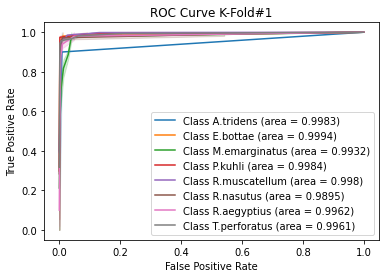

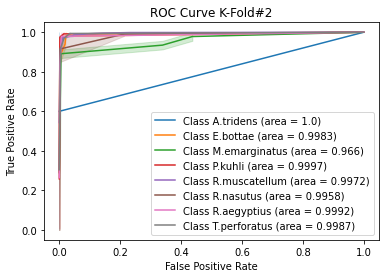

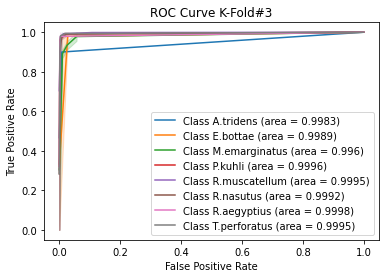

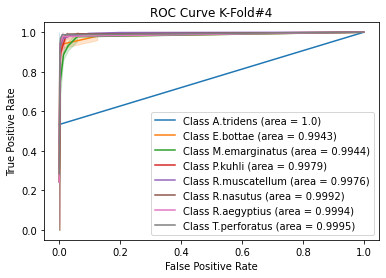

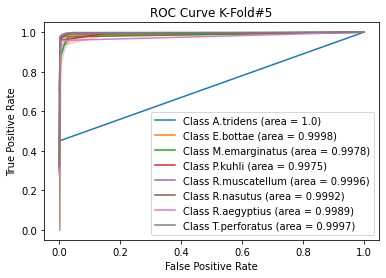

In [50]:
# Plot all K-Fold ROC curves

for i in range(n_split):
    _, axs = plt.subplots(ncols=1)
    axs.set(xlabel='False Positive Rate',ylabel='True Positive Rate', title='ROC Curve K-Fold#'+str(i+1))
    for j in range(n_classes):
        auc_val = auc(all_fpr[i][j], all_tpr[i][j])
        auc_val = np.around(auc_val,4)
        sns.lineplot(x=all_fpr[i][j],y=all_tpr[i][j],ax=axs, label='Class '+ getSpecies(j) +' (area = ' + str(auc_val) + ')', legend='brief')
        

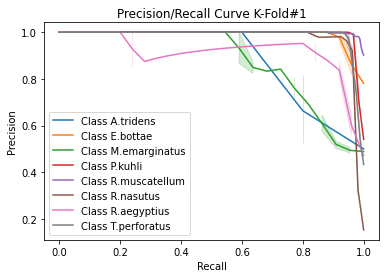

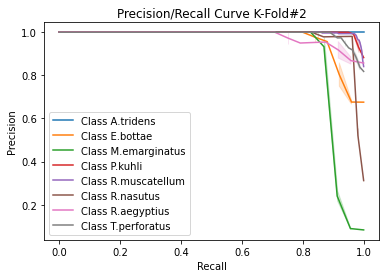

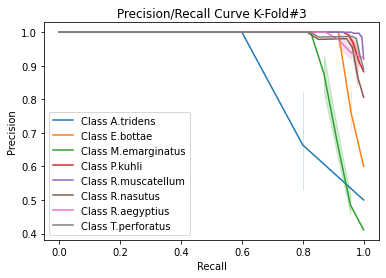

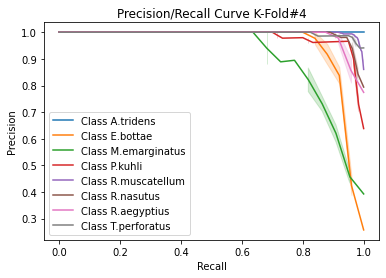

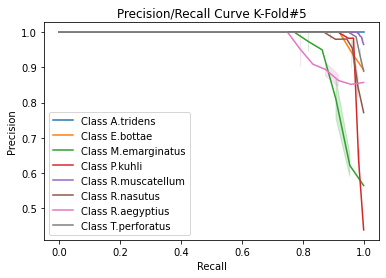

In [51]:
#Plot all K-Fold Precision/Recall curves
for i in range(n_split):
    _, axs = plt.subplots(ncols=1)
    axs.set(xlabel='Recall',ylabel='Precision', title='Precision/Recall Curve K-Fold#'+str(i+1))
    for j in range(n_classes):
        sns.lineplot(x=all_recall[i][j],y=all_precision[i][j],ax=axs, label='Class '+ getSpecies(j), legend='brief')

Confusion Matrix K-Fold #1

[[  4   0   0   0   0   0   1   0]
 [  0  24   0   0   0   1   0   0]
 [  0   1  16   0   1   0   4   0]
 [  0   0   0  58   1   0   0   0]
 [  0   3   3   0 322   0   4   1]
 [  0   0   0   1   0  51   2   0]
 [  0   0   0   1   0   0  24   0]
 [  0   1   1   0   2   0   1  76]]


Confusion Matrix K-Fold #2

[[  5   0   0   0   0   0   0   0]
 [  0  23   0   0   1   1   0   0]
 [  0   0  21   0   2   0   0   0]
 [  0   0   0  58   1   0   0   1]
 [  0   3   1   0 327   0   1   1]
 [  0   0   1   0   0  52   0   0]
 [  0   0   1   0   3   0  20   0]
 [  0   0   2   0   3   0   0  76]]


Confusion Matrix K-Fold #3

[[  4   0   0   0   0   0   1   0]
 [  0  19   2   0   1   1   1   0]
 [  0   0  20   1   1   0   0   1]
 [  0   0   0  59   0   0   1   0]
 [  0   0   0   1 332   0   0   0]
 [  0   0   1   2   0  51   0   0]
 [  0   0   0   0   0   0  24   0]
 [  0   0   0   0   2   0   1  78]]


Confusion Matrix K-Fold #4

[[  5   0   0   0   0   0   0   0]
 [  

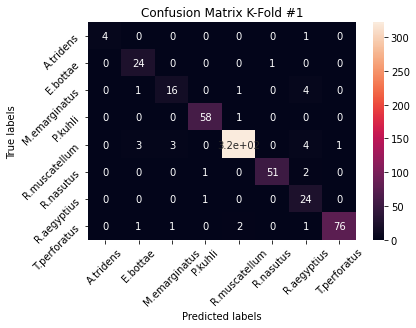

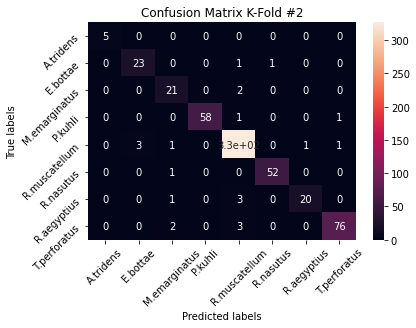

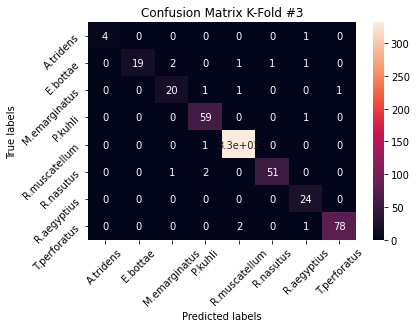

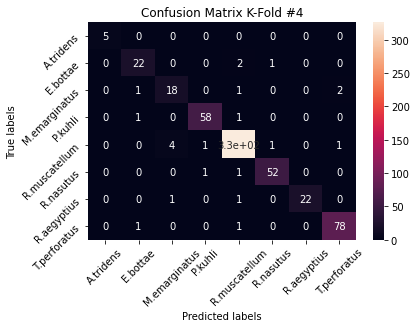

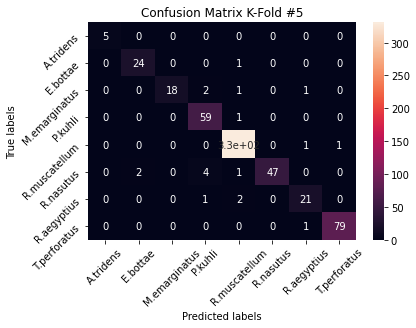

In [52]:
## Plot all K-Fold confusion matrices
import numpy as np
import matplotlib.pylab as pl
import matplotlib.gridspec as gridspec
from matplotlib import pyplot as plt

# Create 1X 5 sub plots
# gs = gridspec.GridSpec(1,n_split)
figs=[]
for i in range(n_split):
    figs.append(plt.figure())
    
for i in range(n_split):
    print('Confusion Matrix K-Fold #'+ str(i+1)+"\n")
    print(all_cm[i])
    print("\n")
    
    ax=figs[i].add_subplot()
    sns.heatmap(all_cm[i], annot=True, ax = ax); #annot=True to annotate cells

    
    # labels, title and ticks
    ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
    ax.set_title('Confusion Matrix K-Fold #'+ str(i+1)); 
    ax.xaxis.set_ticklabels(labels,rotation=45); ax.yaxis.set_ticklabels(labels,rotation=45);

sum of all confuion matrices
 [[  23    0    0    0    0    0    2    0]
 [   0  112    2    0    5    4    1    0]
 [   0    2   93    3    6    0    5    3]
 [   0    1    0  292    4    0    1    1]
 [   0    6    8    2 1638    1    6    4]
 [   0    2    2    8    2  253    2    0]
 [   0    0    2    2    6    0  111    0]
 [   0    2    3    0    8    0    3  387]]

average of all confuion matrices
 [[  4   0   0   0   0   0   0   0]
 [  0  22   0   0   1   0   0   0]
 [  0   0  18   0   1   0   1   0]
 [  0   0   0  58   0   0   0   0]
 [  0   1   1   0 327   0   1   0]
 [  0   0   0   1   0  50   0   0]
 [  0   0   0   0   1   0  22   0]
 [  0   0   0   0   1   0   0  77]]


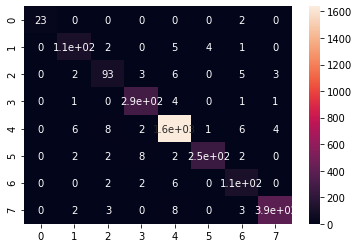

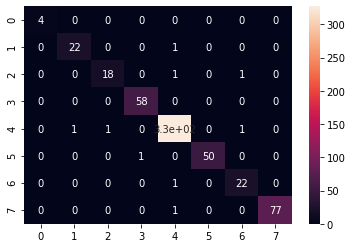

In [53]:
## plot macro cm

sum_all_cm=np.zeros((n_classes,n_classes)).astype('int64')
for i in range(n_split):
    sum_all_cm+=all_cm[i]
    
    
#plot 
figs=[]
for i in range(2):
    figs.append(plt.figure())
       
print("sum of all confuion matrices\n",sum_all_cm)
ax=figs[0].add_subplot()
sns.heatmap(sum_all_cm, annot=True, ax = ax);

avg_all_cm=np.divide(sum_all_cm,n_split).astype('int64')
print("\naverage of all confuion matrices\n",avg_all_cm)
ax=figs[1].add_subplot()
sns.heatmap(avg_all_cm, annot=True, ax = ax);

[[0.92 0.   0.   0.   0.   0.   0.08 0.  ]
 [0.   0.9  0.02 0.   0.04 0.03 0.01 0.  ]
 [0.   0.02 0.83 0.03 0.05 0.   0.04 0.03]
 [0.   0.   0.   0.98 0.01 0.   0.   0.  ]
 [0.   0.   0.   0.   0.98 0.   0.   0.  ]
 [0.   0.01 0.01 0.03 0.01 0.94 0.01 0.  ]
 [0.   0.   0.02 0.02 0.05 0.   0.92 0.  ]
 [0.   0.   0.01 0.   0.02 0.   0.01 0.96]]


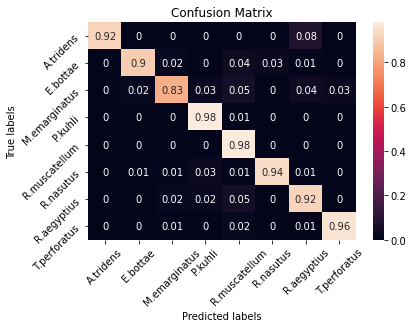

In [54]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


cm= sum_all_cm/ sum_all_cm.astype(np.float).sum(axis=1,keepdims = True)
cm = (np.around(cm,2))
print(cm)


labels = ['A.tridens','E.bottae','M.emarginatus','P.kuhli','R.muscatellum','R.nasutus', 'R.aegyptius', 'T.perforatus']


ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(labels,rotation=45); ax.yaxis.set_ticklabels(labels,rotation=45);

<h2>Storing/Loading history and model to file</h2>

In [23]:
#Store History
hist_df = pd.DataFrame(history.history) 
hist_json_file = 'Model2-P-bats.json' 
with open(hist_json_file, mode='w') as f:
    hist_df.to_json(f)

In [25]:
#Load History 
history_info = pd.read_json('Model2-P-bats.json')

In [26]:
##Save Model
model.save('Model2-P-bats_trained.model') #Save the model

In [27]:
## Load Model
model = tf.keras.models.load_model('Model2V2-bats_trained.model') #Re load model

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
